In [1]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
import pytesseract
import editdistance
import re
from pdf2image import convert_from_path
from statistics import mean
import copy
import sys
import base64
from datetime import datetime
from IPython.display import clear_output
%run find_similar_docs.ipynb


ERROR:root:File `'find_similar_docs.ipynb.py'` not found.


In [2]:
def load_image(input_path):
#     input_path = "/home/zeus/Downloads/yieldstreet/For_Fuse3/W2/W2_example11.pdf"
    if input_path.endswith(('.pdf','.PDF')):
        pages = convert_from_path(input_path)  
        page = pages[0] # only selects first image for now
        img = np.asarray(page)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         print(img.shape)
    else:
        img = cv2.imread(input_path, 0)
#         print(img.shape)
#     print("image shape",img.shape)
    return img

In [24]:
def get_content_image(img):
    content_image = copy.deepcopy(img)
    content_image = cv2.cvtColor(content_image, cv2.COLOR_BGR2GRAY)
    _,thresh = cv2.threshold(content_image,1,255,cv2.THRESH_BINARY)
    #     cv2.imwrite("./rotation_intermediate/AfterThresholdImage.jpg", img)
    im2, contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    contour_area = [cv2.contourArea(c) for c in contours]
    cnt = contours[np.argmax(contour_area)]
    x,y,w,h = cv2.boundingRect(cnt)
#     cv2.imwrite(os.path.join(INTERMEDIATE_FOLDER,"content_image.jpg"), 
#                 cv2.rectangle(cv2.cvtColor(content_image, cv2.COLOR_GRAY2BGR),(x,y),(x+w,y+h),(0,0,255),5))

    content_image = img[y:y+h, x:x+w,:]
    return content_image

In [4]:
def find_required_rotation_angle(original_img):
    QUANTIZATION_GAP = 1
    img = copy.deepcopy(original_img)
#     cv2.imwrite("./rotation_intermediate/Original.jpg", img)
    
    
    '''Bluring and Thresholding'''
    blur = cv2.GaussianBlur(copy.deepcopy(img),(3,3),0)
#     cv2.imwrite("./rotation_intermediate/AfterBluringImage.jpg", img)
    
    threshold_value = get_thresholding_value(blur)
    img_bin = cv2.threshold(blur, threshold_value, 255, cv2.THRESH_BINARY| cv2.THRESH_OTSU)[1]
#     cv2.imwrite("./rotation_intermediate/AfterThresholdFirstImage.jpg", img)
    
    
    '''Detect Contours'''
    _, contours, _ = cv2.findContours(copy.deepcopy(img_bin), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     cv2.imwrite("./rotation_intermediate/AfterFirstContour.jpg", img)
    
    
    
    angles_count = {}
    for count, c in enumerate(contours):
        
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        
        w = int(rect[1][0])
        h = int(rect[1][1])
        y = int(rect[0][0])
        x = int(rect[0][1])
        angle = rect[2]
        
        if angle > 45:
            angle -= 90
            tmp = w
            w = h
            h = tmp
        elif angle < -45:
            angle += 90
            tmp = w
            w = h
            h = tmp
        elif abs(angle)==0:
            angle=0

#If the box height is greater then 20, widht is >80, then only save it as a box in "cropped/" folder.
        if (w > 80 and h > 20) and w < img.shape[1]//1.5 and h < img.shape[0]//4:
            quantized_angle = str((angle//QUANTIZATION_GAP)*QUANTIZATION_GAP)
            if  quantized_angle in angles_count.keys():
                angles_count[quantized_angle] += 1
            else:
                angles_count[quantized_angle] = 1
    
    if angles_count:
        required_rotation = int(float(max(angles_count, key=angles_count.get)))
    else:
        required_rotation = 0
        print("No boxes found")
    print(angles_count)
    print("Angle: ", required_rotation)
    return required_rotation

In [5]:
def correct_orientation(original_img, folder):
    
    required_angle = find_required_rotation_angle(original_img)
    print(required_angle)
    if abs(required_angle) >2:
        ROTATION_FLAG = True
        img = rotate_image(original_img, required_angle)
        img = get_content_image(img)
    else:
        ROTATION_FLAG = False
        img = original_img
    
    return img, ROTATION_FLAG
            
    
    

In [6]:
def rotate_image(mat, angle):
    """
    Rotates an image (angle in degrees) and expands image to avoid cropping
    """
    if abs(angle) < 1:
        return mat
    image_center = (mat.shape[1]/2, mat.shape[0]/2)
    height, width = mat.shape[:2] # image shape has 3 dimensions

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)
#     print("rotation_mat: ", rotation_mat)

    # rotation calculates the cos and sin, taking absolutes of those.
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    # find the new width and height bounds
    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    # subtract old image center (bringing image back to origo) and adding the new image center coordinates
    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]
#     print("rotation_mat: ", rotation_mat)
#     print("Image Center: ", image_center)
#     print("Angle: ", angle)
    
#     print("rotation_mat: ", rotation_mat)
#     print("bound_w: ", bound_w)
#     print("bound_h: ", bound_h)

    # rotate image with the new bounds and translated rotation matrix
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h))
    return rotated_mat

/media/raj/new/Driving_license/Data/jpgfile/IMG_20190115_0025.jpg
(816, 1149, 3)
Iteration:  1
(816, 1149, 3) 0 0
(816, 1149, 3) 0 1
(816, 1149, 3) 0 2
(816, 1149, 3) 0 3
(816, 1149, 3) 0 4
(816, 1149, 3) 0 5
(816, 1149, 3) 0 6
(816, 1149, 3) 0 7
(816, 1149, 3) 0 8
(816, 1149, 3) 0 9
(816, 1149, 3) 0 10
(816, 1149, 3) 0 11
(816, 1149, 3) 0 12
(816, 1149, 3) 0 13
(816, 1149, 3) 0 14
(816, 1149, 3) 0 15
(816, 1149, 3) 0 16
(816, 1149, 3) 0 17
(816, 1149, 3) 0 18
(816, 1149, 3) 0 19
(816, 1149, 3) 0 20
(816, 1149, 3) 0 21
(816, 1149, 3) 0 22
(816, 1149, 3) 0 23
(816, 1149, 3) 0 24
(816, 1149, 3) 0 25
(816, 1149, 3) 0 26
(816, 1149, 3) 0 27
(816, 1149, 3) 0 28
(816, 1149, 3) 0 29
(816, 1149, 3) 0 30
(816, 1149, 3) 0 31
(816, 1149, 3) 0 32
(816, 1149, 3) 0 33
(816, 1149, 3) 0 34
(816, 1149, 3) 0 35
(816, 1149, 3) 0 36
(816, 1149, 3) 0 37
(816, 1149, 3) 0 38
(816, 1149, 3) 0 39
(816, 1149, 3) 0 40
(816, 1149, 3) 0 41
(816, 1149, 3) 0 42
(816, 1149, 3) 0 43
(816, 1149, 3) 0 44
(816, 1149, 3) 

(816, 1149, 3) 0 408
(816, 1149, 3) 0 409
(816, 1149, 3) 0 410
(816, 1149, 3) 0 411
(816, 1149, 3) 0 412
(816, 1149, 3) 0 413
(816, 1149, 3) 0 414
(816, 1149, 3) 0 415
(816, 1149, 3) 0 416
(816, 1149, 3) 0 417
(816, 1149, 3) 0 418
(816, 1149, 3) 0 419
(816, 1149, 3) 0 420
(816, 1149, 3) 0 421
(816, 1149, 3) 0 422
(816, 1149, 3) 0 423
(816, 1149, 3) 0 424
(816, 1149, 3) 0 425
(816, 1149, 3) 0 426
(816, 1149, 3) 0 427
(816, 1149, 3) 0 428
(816, 1149, 3) 0 429
(816, 1149, 3) 0 430
(816, 1149, 3) 0 431
(816, 1149, 3) 0 432
(816, 1149, 3) 0 433
(816, 1149, 3) 0 434
(816, 1149, 3) 0 435
(816, 1149, 3) 0 436
(816, 1149, 3) 0 437
(816, 1149, 3) 0 438
(816, 1149, 3) 0 439
(816, 1149, 3) 0 440
(816, 1149, 3) 0 441
(816, 1149, 3) 0 442
(816, 1149, 3) 0 443
(816, 1149, 3) 0 444
(816, 1149, 3) 0 445
(816, 1149, 3) 0 446
(816, 1149, 3) 0 447
(816, 1149, 3) 0 448
(816, 1149, 3) 0 449
(816, 1149, 3) 0 450
(816, 1149, 3) 0 451
(816, 1149, 3) 0 452
(816, 1149, 3) 0 453
(816, 1149, 3) 0 454
(816, 1149, 3

(816, 1149, 3) 0 1075
(816, 1149, 3) 0 1076
(816, 1149, 3) 0 1077
(816, 1149, 3) 0 1078
(816, 1149, 3) 0 1079
(816, 1149, 3) 0 1080
(816, 1149, 3) 0 1081
(816, 1149, 3) 0 1082
(816, 1149, 3) 0 1083
(816, 1149, 3) 0 1084
(816, 1149, 3) 0 1085
(816, 1149, 3) 0 1086
(816, 1149, 3) 0 1087
(816, 1149, 3) 0 1088
(816, 1149, 3) 0 1089
(816, 1149, 3) 0 1090
(816, 1149, 3) 0 1091
(816, 1149, 3) 0 1092
(816, 1149, 3) 0 1093
(816, 1149, 3) 0 1094
(816, 1149, 3) 0 1095
(816, 1149, 3) 0 1096
(816, 1149, 3) 0 1097
(816, 1149, 3) 0 1098
(816, 1149, 3) 0 1099
(816, 1149, 3) 0 1100
(816, 1149, 3) 0 1101
(816, 1149, 3) 0 1102
(816, 1149, 3) 0 1103
(816, 1149, 3) 0 1104
(816, 1149, 3) 0 1105
(816, 1149, 3) 0 1106
(816, 1149, 3) 0 1107
(816, 1149, 3) 0 1108
(816, 1149, 3) 0 1109
(816, 1149, 3) 0 1110
(816, 1149, 3) 0 1111
(816, 1149, 3) 0 1112
(816, 1149, 3) 0 1113
(816, 1149, 3) 0 1114
(816, 1149, 3) 0 1115
(816, 1149, 3) 0 1116
(816, 1149, 3) 0 1117
(816, 1149, 3) 0 1118
(816, 1149, 3) 0 1119
(816, 1149

(816, 1149, 3) 1 592
(816, 1149, 3) 1 593
(816, 1149, 3) 1 594
(816, 1149, 3) 1 595
(816, 1149, 3) 1 596
(816, 1149, 3) 1 597
(816, 1149, 3) 1 598
(816, 1149, 3) 1 599
(816, 1149, 3) 1 600
(816, 1149, 3) 1 601
(816, 1149, 3) 1 602
(816, 1149, 3) 1 603
(816, 1149, 3) 1 604
(816, 1149, 3) 1 605
(816, 1149, 3) 1 606
(816, 1149, 3) 1 607
(816, 1149, 3) 1 608
(816, 1149, 3) 1 609
(816, 1149, 3) 1 610
(816, 1149, 3) 1 611
(816, 1149, 3) 1 612
(816, 1149, 3) 1 613
(816, 1149, 3) 1 614
(816, 1149, 3) 1 615
(816, 1149, 3) 1 616
(816, 1149, 3) 1 617
(816, 1149, 3) 1 618
(816, 1149, 3) 1 619
(816, 1149, 3) 1 620
(816, 1149, 3) 1 621
(816, 1149, 3) 1 622
(816, 1149, 3) 1 623
(816, 1149, 3) 1 624
(816, 1149, 3) 1 625
(816, 1149, 3) 1 626
(816, 1149, 3) 1 627
(816, 1149, 3) 1 628
(816, 1149, 3) 1 629
(816, 1149, 3) 1 630
(816, 1149, 3) 1 631
(816, 1149, 3) 1 632
(816, 1149, 3) 1 633
(816, 1149, 3) 1 634
(816, 1149, 3) 1 635
(816, 1149, 3) 1 636
(816, 1149, 3) 1 637
(816, 1149, 3) 1 638
(816, 1149, 3

(816, 1149, 3) 2 109
(816, 1149, 3) 2 110
(816, 1149, 3) 2 111
(816, 1149, 3) 2 112
(816, 1149, 3) 2 113
(816, 1149, 3) 2 114
(816, 1149, 3) 2 115
(816, 1149, 3) 2 116
(816, 1149, 3) 2 117
(816, 1149, 3) 2 118
(816, 1149, 3) 2 119
(816, 1149, 3) 2 120
(816, 1149, 3) 2 121
(816, 1149, 3) 2 122
(816, 1149, 3) 2 123
(816, 1149, 3) 2 124
(816, 1149, 3) 2 125
(816, 1149, 3) 2 126
(816, 1149, 3) 2 127
(816, 1149, 3) 2 128
(816, 1149, 3) 2 129
(816, 1149, 3) 2 130
(816, 1149, 3) 2 131
(816, 1149, 3) 2 132
(816, 1149, 3) 2 133
(816, 1149, 3) 2 134
(816, 1149, 3) 2 135
(816, 1149, 3) 2 136
(816, 1149, 3) 2 137
(816, 1149, 3) 2 138
(816, 1149, 3) 2 139
(816, 1149, 3) 2 140
(816, 1149, 3) 2 141
(816, 1149, 3) 2 142
(816, 1149, 3) 2 143
(816, 1149, 3) 2 144
(816, 1149, 3) 2 145
(816, 1149, 3) 2 146
(816, 1149, 3) 2 147
(816, 1149, 3) 2 148
(816, 1149, 3) 2 149
(816, 1149, 3) 2 150
(816, 1149, 3) 2 151
(816, 1149, 3) 2 152
(816, 1149, 3) 2 153
(816, 1149, 3) 2 154
(816, 1149, 3) 2 155
(816, 1149, 3

(816, 1149, 3) 2 776
(816, 1149, 3) 2 777
(816, 1149, 3) 2 778
(816, 1149, 3) 2 779
(816, 1149, 3) 2 780
(816, 1149, 3) 2 781
(816, 1149, 3) 2 782
(816, 1149, 3) 2 783
(816, 1149, 3) 2 784
(816, 1149, 3) 2 785
(816, 1149, 3) 2 786
(816, 1149, 3) 2 787
(816, 1149, 3) 2 788
(816, 1149, 3) 2 789
(816, 1149, 3) 2 790
(816, 1149, 3) 2 791
(816, 1149, 3) 2 792
(816, 1149, 3) 2 793
(816, 1149, 3) 2 794
(816, 1149, 3) 2 795
(816, 1149, 3) 2 796
(816, 1149, 3) 2 797
(816, 1149, 3) 2 798
(816, 1149, 3) 2 799
(816, 1149, 3) 2 800
(816, 1149, 3) 2 801
(816, 1149, 3) 2 802
(816, 1149, 3) 2 803
(816, 1149, 3) 2 804
(816, 1149, 3) 2 805
(816, 1149, 3) 2 806
(816, 1149, 3) 2 807
(816, 1149, 3) 2 808
(816, 1149, 3) 2 809
(816, 1149, 3) 2 810
(816, 1149, 3) 2 811
(816, 1149, 3) 2 812
(816, 1149, 3) 2 813
(816, 1149, 3) 2 814
(816, 1149, 3) 2 815
(816, 1149, 3) 2 816
(816, 1149, 3) 2 817
(816, 1149, 3) 2 818
(816, 1149, 3) 2 819
(816, 1149, 3) 2 820
(816, 1149, 3) 2 821
(816, 1149, 3) 2 822
(816, 1149, 3

(816, 1149, 3) 3 277
(816, 1149, 3) 3 278
(816, 1149, 3) 3 279
(816, 1149, 3) 3 280
(816, 1149, 3) 3 281
(816, 1149, 3) 3 282
(816, 1149, 3) 3 283
(816, 1149, 3) 3 284
(816, 1149, 3) 3 285
(816, 1149, 3) 3 286
(816, 1149, 3) 3 287
(816, 1149, 3) 3 288
(816, 1149, 3) 3 289
(816, 1149, 3) 3 290
(816, 1149, 3) 3 291
(816, 1149, 3) 3 292
(816, 1149, 3) 3 293
(816, 1149, 3) 3 294
(816, 1149, 3) 3 295
(816, 1149, 3) 3 296
(816, 1149, 3) 3 297
(816, 1149, 3) 3 298
(816, 1149, 3) 3 299
(816, 1149, 3) 3 300
(816, 1149, 3) 3 301
(816, 1149, 3) 3 302
(816, 1149, 3) 3 303
(816, 1149, 3) 3 304
(816, 1149, 3) 3 305
(816, 1149, 3) 3 306
(816, 1149, 3) 3 307
(816, 1149, 3) 3 308
(816, 1149, 3) 3 309
(816, 1149, 3) 3 310
(816, 1149, 3) 3 311
(816, 1149, 3) 3 312
(816, 1149, 3) 3 313
(816, 1149, 3) 3 314
(816, 1149, 3) 3 315
(816, 1149, 3) 3 316
(816, 1149, 3) 3 317
(816, 1149, 3) 3 318
(816, 1149, 3) 3 319
(816, 1149, 3) 3 320
(816, 1149, 3) 3 321
(816, 1149, 3) 3 322
(816, 1149, 3) 3 323
(816, 1149, 3

(816, 1149, 3) 3 793
(816, 1149, 3) 3 794
(816, 1149, 3) 3 795
(816, 1149, 3) 3 796
(816, 1149, 3) 3 797
(816, 1149, 3) 3 798
(816, 1149, 3) 3 799
(816, 1149, 3) 3 800
(816, 1149, 3) 3 801
(816, 1149, 3) 3 802
(816, 1149, 3) 3 803
(816, 1149, 3) 3 804
(816, 1149, 3) 3 805
(816, 1149, 3) 3 806
(816, 1149, 3) 3 807
(816, 1149, 3) 3 808
(816, 1149, 3) 3 809
(816, 1149, 3) 3 810
(816, 1149, 3) 3 811
(816, 1149, 3) 3 812
(816, 1149, 3) 3 813
(816, 1149, 3) 3 814
(816, 1149, 3) 3 815
(816, 1149, 3) 3 816
(816, 1149, 3) 3 817
(816, 1149, 3) 3 818
(816, 1149, 3) 3 819
(816, 1149, 3) 3 820
(816, 1149, 3) 3 821
(816, 1149, 3) 3 822
(816, 1149, 3) 3 823
(816, 1149, 3) 3 824
(816, 1149, 3) 3 825
(816, 1149, 3) 3 826
(816, 1149, 3) 3 827
(816, 1149, 3) 3 828
(816, 1149, 3) 3 829
(816, 1149, 3) 3 830
(816, 1149, 3) 3 831
(816, 1149, 3) 3 832
(816, 1149, 3) 3 833
(816, 1149, 3) 3 834
(816, 1149, 3) 3 835
(816, 1149, 3) 3 836
(816, 1149, 3) 3 837
(816, 1149, 3) 3 838
(816, 1149, 3) 3 839
(816, 1149, 3

(816, 1149, 3) 4 310
(816, 1149, 3) 4 311
(816, 1149, 3) 4 312
(816, 1149, 3) 4 313
(816, 1149, 3) 4 314
(816, 1149, 3) 4 315
(816, 1149, 3) 4 316
(816, 1149, 3) 4 317
(816, 1149, 3) 4 318
(816, 1149, 3) 4 319
(816, 1149, 3) 4 320
(816, 1149, 3) 4 321
(816, 1149, 3) 4 322
(816, 1149, 3) 4 323
(816, 1149, 3) 4 324
(816, 1149, 3) 4 325
(816, 1149, 3) 4 326
(816, 1149, 3) 4 327
(816, 1149, 3) 4 328
(816, 1149, 3) 4 329
(816, 1149, 3) 4 330
(816, 1149, 3) 4 331
(816, 1149, 3) 4 332
(816, 1149, 3) 4 333
(816, 1149, 3) 4 334
(816, 1149, 3) 4 335
(816, 1149, 3) 4 336
(816, 1149, 3) 4 337
(816, 1149, 3) 4 338
(816, 1149, 3) 4 339
(816, 1149, 3) 4 340
(816, 1149, 3) 4 341
(816, 1149, 3) 4 342
(816, 1149, 3) 4 343
(816, 1149, 3) 4 344
(816, 1149, 3) 4 345
(816, 1149, 3) 4 346
(816, 1149, 3) 4 347
(816, 1149, 3) 4 348
(816, 1149, 3) 4 349
(816, 1149, 3) 4 350
(816, 1149, 3) 4 351
(816, 1149, 3) 4 352
(816, 1149, 3) 4 353
(816, 1149, 3) 4 354
(816, 1149, 3) 4 355
(816, 1149, 3) 4 356
(816, 1149, 3

(816, 1149, 3) 4 810
(816, 1149, 3) 4 811
(816, 1149, 3) 4 812
(816, 1149, 3) 4 813
(816, 1149, 3) 4 814
(816, 1149, 3) 4 815
(816, 1149, 3) 4 816
(816, 1149, 3) 4 817
(816, 1149, 3) 4 818
(816, 1149, 3) 4 819
(816, 1149, 3) 4 820
(816, 1149, 3) 4 821
(816, 1149, 3) 4 822
(816, 1149, 3) 4 823
(816, 1149, 3) 4 824
(816, 1149, 3) 4 825
(816, 1149, 3) 4 826
(816, 1149, 3) 4 827
(816, 1149, 3) 4 828
(816, 1149, 3) 4 829
(816, 1149, 3) 4 830
(816, 1149, 3) 4 831
(816, 1149, 3) 4 832
(816, 1149, 3) 4 833
(816, 1149, 3) 4 834
(816, 1149, 3) 4 835
(816, 1149, 3) 4 836
(816, 1149, 3) 4 837
(816, 1149, 3) 4 838
(816, 1149, 3) 4 839
(816, 1149, 3) 4 840
(816, 1149, 3) 4 841
(816, 1149, 3) 4 842
(816, 1149, 3) 4 843
(816, 1149, 3) 4 844
(816, 1149, 3) 4 845
(816, 1149, 3) 4 846
(816, 1149, 3) 4 847
(816, 1149, 3) 4 848
(816, 1149, 3) 4 849
(816, 1149, 3) 4 850
(816, 1149, 3) 4 851
(816, 1149, 3) 4 852
(816, 1149, 3) 4 853
(816, 1149, 3) 4 854
(816, 1149, 3) 4 855
(816, 1149, 3) 4 856
(816, 1149, 3

(816, 1149, 3) 5 327
(816, 1149, 3) 5 328
(816, 1149, 3) 5 329
(816, 1149, 3) 5 330
(816, 1149, 3) 5 331
(816, 1149, 3) 5 332
(816, 1149, 3) 5 333
(816, 1149, 3) 5 334
(816, 1149, 3) 5 335
(816, 1149, 3) 5 336
(816, 1149, 3) 5 337
(816, 1149, 3) 5 338
(816, 1149, 3) 5 339
(816, 1149, 3) 5 340
(816, 1149, 3) 5 341
(816, 1149, 3) 5 342
(816, 1149, 3) 5 343
(816, 1149, 3) 5 344
(816, 1149, 3) 5 345
(816, 1149, 3) 5 346
(816, 1149, 3) 5 347
(816, 1149, 3) 5 348
(816, 1149, 3) 5 349
(816, 1149, 3) 5 350
(816, 1149, 3) 5 351
(816, 1149, 3) 5 352
(816, 1149, 3) 5 353
(816, 1149, 3) 5 354
(816, 1149, 3) 5 355
(816, 1149, 3) 5 356
(816, 1149, 3) 5 357
(816, 1149, 3) 5 358
(816, 1149, 3) 5 359
(816, 1149, 3) 5 360
(816, 1149, 3) 5 361
(816, 1149, 3) 5 362
(816, 1149, 3) 5 363
(816, 1149, 3) 5 364
(816, 1149, 3) 5 365
(816, 1149, 3) 5 366
(816, 1149, 3) 5 367
(816, 1149, 3) 5 368
(816, 1149, 3) 5 369
(816, 1149, 3) 5 370
(816, 1149, 3) 5 371
(816, 1149, 3) 5 372
(816, 1149, 3) 5 373
(816, 1149, 3

(816, 1149, 3) 5 993
(816, 1149, 3) 5 994
(816, 1149, 3) 5 995
(816, 1149, 3) 5 996
(816, 1149, 3) 5 997
(816, 1149, 3) 5 998
(816, 1149, 3) 5 999
(816, 1149, 3) 5 1000
(816, 1149, 3) 5 1001
(816, 1149, 3) 5 1002
(816, 1149, 3) 5 1003
(816, 1149, 3) 5 1004
(816, 1149, 3) 5 1005
(816, 1149, 3) 5 1006
(816, 1149, 3) 5 1007
(816, 1149, 3) 5 1008
(816, 1149, 3) 5 1009
(816, 1149, 3) 5 1010
(816, 1149, 3) 5 1011
(816, 1149, 3) 5 1012
(816, 1149, 3) 5 1013
(816, 1149, 3) 5 1014
(816, 1149, 3) 5 1015
(816, 1149, 3) 5 1016
(816, 1149, 3) 5 1017
(816, 1149, 3) 5 1018
(816, 1149, 3) 5 1019
(816, 1149, 3) 5 1020
(816, 1149, 3) 5 1021
(816, 1149, 3) 5 1022
(816, 1149, 3) 5 1023
(816, 1149, 3) 5 1024
(816, 1149, 3) 5 1025
(816, 1149, 3) 5 1026
(816, 1149, 3) 5 1027
(816, 1149, 3) 5 1028
(816, 1149, 3) 5 1029
(816, 1149, 3) 5 1030
(816, 1149, 3) 5 1031
(816, 1149, 3) 5 1032
(816, 1149, 3) 5 1033
(816, 1149, 3) 5 1034
(816, 1149, 3) 5 1035
(816, 1149, 3) 5 1036
(816, 1149, 3) 5 1037
(816, 1149, 3) 5 

(816, 1149, 3) 6 511
(816, 1149, 3) 6 512
(816, 1149, 3) 6 513
(816, 1149, 3) 6 514
(816, 1149, 3) 6 515
(816, 1149, 3) 6 516
(816, 1149, 3) 6 517
(816, 1149, 3) 6 518
(816, 1149, 3) 6 519
(816, 1149, 3) 6 520
(816, 1149, 3) 6 521
(816, 1149, 3) 6 522
(816, 1149, 3) 6 523
(816, 1149, 3) 6 524
(816, 1149, 3) 6 525
(816, 1149, 3) 6 526
(816, 1149, 3) 6 527
(816, 1149, 3) 6 528
(816, 1149, 3) 6 529
(816, 1149, 3) 6 530
(816, 1149, 3) 6 531
(816, 1149, 3) 6 532
(816, 1149, 3) 6 533
(816, 1149, 3) 6 534
(816, 1149, 3) 6 535
(816, 1149, 3) 6 536
(816, 1149, 3) 6 537
(816, 1149, 3) 6 538
(816, 1149, 3) 6 539
(816, 1149, 3) 6 540
(816, 1149, 3) 6 541
(816, 1149, 3) 6 542
(816, 1149, 3) 6 543
(816, 1149, 3) 6 544
(816, 1149, 3) 6 545
(816, 1149, 3) 6 546
(816, 1149, 3) 6 547
(816, 1149, 3) 6 548
(816, 1149, 3) 6 549
(816, 1149, 3) 6 550
(816, 1149, 3) 6 551
(816, 1149, 3) 6 552
(816, 1149, 3) 6 553
(816, 1149, 3) 6 554
(816, 1149, 3) 6 555
(816, 1149, 3) 6 556
(816, 1149, 3) 6 557
(816, 1149, 3

(816, 1149, 3) 6 1010
(816, 1149, 3) 6 1011
(816, 1149, 3) 6 1012
(816, 1149, 3) 6 1013
(816, 1149, 3) 6 1014
(816, 1149, 3) 6 1015
(816, 1149, 3) 6 1016
(816, 1149, 3) 6 1017
(816, 1149, 3) 6 1018
(816, 1149, 3) 6 1019
(816, 1149, 3) 6 1020
(816, 1149, 3) 6 1021
(816, 1149, 3) 6 1022
(816, 1149, 3) 6 1023
(816, 1149, 3) 6 1024
(816, 1149, 3) 6 1025
(816, 1149, 3) 6 1026
(816, 1149, 3) 6 1027
(816, 1149, 3) 6 1028
(816, 1149, 3) 6 1029
(816, 1149, 3) 6 1030
(816, 1149, 3) 6 1031
(816, 1149, 3) 6 1032
(816, 1149, 3) 6 1033
(816, 1149, 3) 6 1034
(816, 1149, 3) 6 1035
(816, 1149, 3) 6 1036
(816, 1149, 3) 6 1037
(816, 1149, 3) 6 1038
(816, 1149, 3) 6 1039
(816, 1149, 3) 6 1040
(816, 1149, 3) 6 1041
(816, 1149, 3) 6 1042
(816, 1149, 3) 6 1043
(816, 1149, 3) 6 1044
(816, 1149, 3) 6 1045
(816, 1149, 3) 6 1046
(816, 1149, 3) 6 1047
(816, 1149, 3) 6 1048
(816, 1149, 3) 6 1049
(816, 1149, 3) 6 1050
(816, 1149, 3) 6 1051
(816, 1149, 3) 6 1052
(816, 1149, 3) 6 1053
(816, 1149, 3) 6 1054
(816, 1149

(816, 1149, 3) 7 528
(816, 1149, 3) 7 529
(816, 1149, 3) 7 530
(816, 1149, 3) 7 531
(816, 1149, 3) 7 532
(816, 1149, 3) 7 533
(816, 1149, 3) 7 534
(816, 1149, 3) 7 535
(816, 1149, 3) 7 536
(816, 1149, 3) 7 537
(816, 1149, 3) 7 538
(816, 1149, 3) 7 539
(816, 1149, 3) 7 540
(816, 1149, 3) 7 541
(816, 1149, 3) 7 542
(816, 1149, 3) 7 543
(816, 1149, 3) 7 544
(816, 1149, 3) 7 545
(816, 1149, 3) 7 546
(816, 1149, 3) 7 547
(816, 1149, 3) 7 548
(816, 1149, 3) 7 549
(816, 1149, 3) 7 550
(816, 1149, 3) 7 551
(816, 1149, 3) 7 552
(816, 1149, 3) 7 553
(816, 1149, 3) 7 554
(816, 1149, 3) 7 555
(816, 1149, 3) 7 556
(816, 1149, 3) 7 557
(816, 1149, 3) 7 558
(816, 1149, 3) 7 559
(816, 1149, 3) 7 560
(816, 1149, 3) 7 561
(816, 1149, 3) 7 562
(816, 1149, 3) 7 563
(816, 1149, 3) 7 564
(816, 1149, 3) 7 565
(816, 1149, 3) 7 566
(816, 1149, 3) 7 567
(816, 1149, 3) 7 568
(816, 1149, 3) 7 569
(816, 1149, 3) 7 570
(816, 1149, 3) 7 571
(816, 1149, 3) 7 572
(816, 1149, 3) 7 573
(816, 1149, 3) 7 574
(816, 1149, 3

(816, 1149, 3) 8 45
(816, 1149, 3) 8 46
(816, 1149, 3) 8 47
(816, 1149, 3) 8 48
(816, 1149, 3) 8 49
(816, 1149, 3) 8 50
(816, 1149, 3) 8 51
(816, 1149, 3) 8 52
(816, 1149, 3) 8 53
(816, 1149, 3) 8 54
(816, 1149, 3) 8 55
(816, 1149, 3) 8 56
(816, 1149, 3) 8 57
(816, 1149, 3) 8 58
(816, 1149, 3) 8 59
(816, 1149, 3) 8 60
(816, 1149, 3) 8 61
(816, 1149, 3) 8 62
(816, 1149, 3) 8 63
(816, 1149, 3) 8 64
(816, 1149, 3) 8 65
(816, 1149, 3) 8 66
(816, 1149, 3) 8 67
(816, 1149, 3) 8 68
(816, 1149, 3) 8 69
(816, 1149, 3) 8 70
(816, 1149, 3) 8 71
(816, 1149, 3) 8 72
(816, 1149, 3) 8 73
(816, 1149, 3) 8 74
(816, 1149, 3) 8 75
(816, 1149, 3) 8 76
(816, 1149, 3) 8 77
(816, 1149, 3) 8 78
(816, 1149, 3) 8 79
(816, 1149, 3) 8 80
(816, 1149, 3) 8 81
(816, 1149, 3) 8 82
(816, 1149, 3) 8 83
(816, 1149, 3) 8 84
(816, 1149, 3) 8 85
(816, 1149, 3) 8 86
(816, 1149, 3) 8 87
(816, 1149, 3) 8 88
(816, 1149, 3) 8 89
(816, 1149, 3) 8 90
(816, 1149, 3) 8 91
(816, 1149, 3) 8 92
(816, 1149, 3) 8 93
(816, 1149, 3) 8 94


(816, 1149, 3) 8 545
(816, 1149, 3) 8 546
(816, 1149, 3) 8 547
(816, 1149, 3) 8 548
(816, 1149, 3) 8 549
(816, 1149, 3) 8 550
(816, 1149, 3) 8 551
(816, 1149, 3) 8 552
(816, 1149, 3) 8 553
(816, 1149, 3) 8 554
(816, 1149, 3) 8 555
(816, 1149, 3) 8 556
(816, 1149, 3) 8 557
(816, 1149, 3) 8 558
(816, 1149, 3) 8 559
(816, 1149, 3) 8 560
(816, 1149, 3) 8 561
(816, 1149, 3) 8 562
(816, 1149, 3) 8 563
(816, 1149, 3) 8 564
(816, 1149, 3) 8 565
(816, 1149, 3) 8 566
(816, 1149, 3) 8 567
(816, 1149, 3) 8 568
(816, 1149, 3) 8 569
(816, 1149, 3) 8 570
(816, 1149, 3) 8 571
(816, 1149, 3) 8 572
(816, 1149, 3) 8 573
(816, 1149, 3) 8 574
(816, 1149, 3) 8 575
(816, 1149, 3) 8 576
(816, 1149, 3) 8 577
(816, 1149, 3) 8 578
(816, 1149, 3) 8 579
(816, 1149, 3) 8 580
(816, 1149, 3) 8 581
(816, 1149, 3) 8 582
(816, 1149, 3) 8 583
(816, 1149, 3) 8 584
(816, 1149, 3) 8 585
(816, 1149, 3) 8 586
(816, 1149, 3) 8 587
(816, 1149, 3) 8 588
(816, 1149, 3) 8 589
(816, 1149, 3) 8 590
(816, 1149, 3) 8 591
(816, 1149, 3

(816, 1149, 3) 8 1044
(816, 1149, 3) 8 1045
(816, 1149, 3) 8 1046
(816, 1149, 3) 8 1047
(816, 1149, 3) 8 1048
(816, 1149, 3) 8 1049
(816, 1149, 3) 8 1050
(816, 1149, 3) 8 1051
(816, 1149, 3) 8 1052
(816, 1149, 3) 8 1053
(816, 1149, 3) 8 1054
(816, 1149, 3) 8 1055
(816, 1149, 3) 8 1056
(816, 1149, 3) 8 1057
(816, 1149, 3) 8 1058
(816, 1149, 3) 8 1059
(816, 1149, 3) 8 1060
(816, 1149, 3) 8 1061
(816, 1149, 3) 8 1062
(816, 1149, 3) 8 1063
(816, 1149, 3) 8 1064
(816, 1149, 3) 8 1065
(816, 1149, 3) 8 1066
(816, 1149, 3) 8 1067
(816, 1149, 3) 8 1068
(816, 1149, 3) 8 1069
(816, 1149, 3) 8 1070
(816, 1149, 3) 8 1071
(816, 1149, 3) 8 1072
(816, 1149, 3) 8 1073
(816, 1149, 3) 8 1074
(816, 1149, 3) 8 1075
(816, 1149, 3) 8 1076
(816, 1149, 3) 8 1077
(816, 1149, 3) 8 1078
(816, 1149, 3) 8 1079
(816, 1149, 3) 8 1080
(816, 1149, 3) 8 1081
(816, 1149, 3) 8 1082
(816, 1149, 3) 8 1083
(816, 1149, 3) 8 1084
(816, 1149, 3) 8 1085
(816, 1149, 3) 8 1086
(816, 1149, 3) 8 1087
(816, 1149, 3) 8 1088
(816, 1149

(816, 1149, 3) 9 516
(816, 1149, 3) 9 517
(816, 1149, 3) 9 518
(816, 1149, 3) 9 519
(816, 1149, 3) 9 520
(816, 1149, 3) 9 521
(816, 1149, 3) 9 522
(816, 1149, 3) 9 523
(816, 1149, 3) 9 524
(816, 1149, 3) 9 525
(816, 1149, 3) 9 526
(816, 1149, 3) 9 527
(816, 1149, 3) 9 528
(816, 1149, 3) 9 529
(816, 1149, 3) 9 530
(816, 1149, 3) 9 531
(816, 1149, 3) 9 532
(816, 1149, 3) 9 533
(816, 1149, 3) 9 534
(816, 1149, 3) 9 535
(816, 1149, 3) 9 536
(816, 1149, 3) 9 537
(816, 1149, 3) 9 538
(816, 1149, 3) 9 539
(816, 1149, 3) 9 540
(816, 1149, 3) 9 541
(816, 1149, 3) 9 542
(816, 1149, 3) 9 543
(816, 1149, 3) 9 544
(816, 1149, 3) 9 545
(816, 1149, 3) 9 546
(816, 1149, 3) 9 547
(816, 1149, 3) 9 548
(816, 1149, 3) 9 549
(816, 1149, 3) 9 550
(816, 1149, 3) 9 551
(816, 1149, 3) 9 552
(816, 1149, 3) 9 553
(816, 1149, 3) 9 554
(816, 1149, 3) 9 555
(816, 1149, 3) 9 556
(816, 1149, 3) 9 557
(816, 1149, 3) 9 558
(816, 1149, 3) 9 559
(816, 1149, 3) 9 560
(816, 1149, 3) 9 561
(816, 1149, 3) 9 562
(816, 1149, 3

(816, 1149, 3) 9 960
(816, 1149, 3) 9 961
(816, 1149, 3) 9 962
(816, 1149, 3) 9 963
(816, 1149, 3) 9 964
(816, 1149, 3) 9 965
(816, 1149, 3) 9 966
(816, 1149, 3) 9 967
(816, 1149, 3) 9 968
(816, 1149, 3) 9 969
(816, 1149, 3) 9 970
(816, 1149, 3) 9 971
(816, 1149, 3) 9 972
(816, 1149, 3) 9 973
(816, 1149, 3) 9 974
(816, 1149, 3) 9 975
(816, 1149, 3) 9 976
(816, 1149, 3) 9 977
(816, 1149, 3) 9 978
(816, 1149, 3) 9 979
(816, 1149, 3) 9 980
(816, 1149, 3) 9 981
(816, 1149, 3) 9 982
(816, 1149, 3) 9 983
(816, 1149, 3) 9 984
(816, 1149, 3) 9 985
(816, 1149, 3) 9 986
(816, 1149, 3) 9 987
(816, 1149, 3) 9 988
(816, 1149, 3) 9 989
(816, 1149, 3) 9 990
(816, 1149, 3) 9 991
(816, 1149, 3) 9 992
(816, 1149, 3) 9 993
(816, 1149, 3) 9 994
(816, 1149, 3) 9 995
(816, 1149, 3) 9 996
(816, 1149, 3) 9 997
(816, 1149, 3) 9 998
(816, 1149, 3) 9 999
(816, 1149, 3) 9 1000
(816, 1149, 3) 9 1001
(816, 1149, 3) 9 1002
(816, 1149, 3) 9 1003
(816, 1149, 3) 9 1004
(816, 1149, 3) 9 1005
(816, 1149, 3) 9 1006
(816, 

(816, 1149, 3) 10 245
(816, 1149, 3) 10 246
(816, 1149, 3) 10 247
(816, 1149, 3) 10 248
(816, 1149, 3) 10 249
(816, 1149, 3) 10 250
(816, 1149, 3) 10 251
(816, 1149, 3) 10 252
(816, 1149, 3) 10 253
(816, 1149, 3) 10 254
(816, 1149, 3) 10 255
(816, 1149, 3) 10 256
(816, 1149, 3) 10 257
(816, 1149, 3) 10 258
(816, 1149, 3) 10 259
(816, 1149, 3) 10 260
(816, 1149, 3) 10 261
(816, 1149, 3) 10 262
(816, 1149, 3) 10 263
(816, 1149, 3) 10 264
(816, 1149, 3) 10 265
(816, 1149, 3) 10 266
(816, 1149, 3) 10 267
(816, 1149, 3) 10 268
(816, 1149, 3) 10 269
(816, 1149, 3) 10 270
(816, 1149, 3) 10 271
(816, 1149, 3) 10 272
(816, 1149, 3) 10 273
(816, 1149, 3) 10 274
(816, 1149, 3) 10 275
(816, 1149, 3) 10 276
(816, 1149, 3) 10 277
(816, 1149, 3) 10 278
(816, 1149, 3) 10 279
(816, 1149, 3) 10 280
(816, 1149, 3) 10 281
(816, 1149, 3) 10 282
(816, 1149, 3) 10 283
(816, 1149, 3) 10 284
(816, 1149, 3) 10 285
(816, 1149, 3) 10 286
(816, 1149, 3) 10 287
(816, 1149, 3) 10 288
(816, 1149, 3) 10 289
(816, 1149

(816, 1149, 3) 10 911
(816, 1149, 3) 10 912
(816, 1149, 3) 10 913
(816, 1149, 3) 10 914
(816, 1149, 3) 10 915
(816, 1149, 3) 10 916
(816, 1149, 3) 10 917
(816, 1149, 3) 10 918
(816, 1149, 3) 10 919
(816, 1149, 3) 10 920
(816, 1149, 3) 10 921
(816, 1149, 3) 10 922
(816, 1149, 3) 10 923
(816, 1149, 3) 10 924
(816, 1149, 3) 10 925
(816, 1149, 3) 10 926
(816, 1149, 3) 10 927
(816, 1149, 3) 10 928
(816, 1149, 3) 10 929
(816, 1149, 3) 10 930
(816, 1149, 3) 10 931
(816, 1149, 3) 10 932
(816, 1149, 3) 10 933
(816, 1149, 3) 10 934
(816, 1149, 3) 10 935
(816, 1149, 3) 10 936
(816, 1149, 3) 10 937
(816, 1149, 3) 10 938
(816, 1149, 3) 10 939
(816, 1149, 3) 10 940
(816, 1149, 3) 10 941
(816, 1149, 3) 10 942
(816, 1149, 3) 10 943
(816, 1149, 3) 10 944
(816, 1149, 3) 10 945
(816, 1149, 3) 10 946
(816, 1149, 3) 10 947
(816, 1149, 3) 10 948
(816, 1149, 3) 10 949
(816, 1149, 3) 10 950
(816, 1149, 3) 10 951
(816, 1149, 3) 10 952
(816, 1149, 3) 10 953
(816, 1149, 3) 10 954
(816, 1149, 3) 10 955
(816, 1149

(816, 1149, 3) 11 429
(816, 1149, 3) 11 430
(816, 1149, 3) 11 431
(816, 1149, 3) 11 432
(816, 1149, 3) 11 433
(816, 1149, 3) 11 434
(816, 1149, 3) 11 435
(816, 1149, 3) 11 436
(816, 1149, 3) 11 437
(816, 1149, 3) 11 438
(816, 1149, 3) 11 439
(816, 1149, 3) 11 440
(816, 1149, 3) 11 441
(816, 1149, 3) 11 442
(816, 1149, 3) 11 443
(816, 1149, 3) 11 444
(816, 1149, 3) 11 445
(816, 1149, 3) 11 446
(816, 1149, 3) 11 447
(816, 1149, 3) 11 448
(816, 1149, 3) 11 449
(816, 1149, 3) 11 450
(816, 1149, 3) 11 451
(816, 1149, 3) 11 452
(816, 1149, 3) 11 453
(816, 1149, 3) 11 454
(816, 1149, 3) 11 455
(816, 1149, 3) 11 456
(816, 1149, 3) 11 457
(816, 1149, 3) 11 458
(816, 1149, 3) 11 459
(816, 1149, 3) 11 460
(816, 1149, 3) 11 461
(816, 1149, 3) 11 462
(816, 1149, 3) 11 463
(816, 1149, 3) 11 464
(816, 1149, 3) 11 465
(816, 1149, 3) 11 466
(816, 1149, 3) 11 467
(816, 1149, 3) 11 468
(816, 1149, 3) 11 469
(816, 1149, 3) 11 470
(816, 1149, 3) 11 471
(816, 1149, 3) 11 472
(816, 1149, 3) 11 473
(816, 1149

(816, 1149, 3) 11 928
(816, 1149, 3) 11 929
(816, 1149, 3) 11 930
(816, 1149, 3) 11 931
(816, 1149, 3) 11 932
(816, 1149, 3) 11 933
(816, 1149, 3) 11 934
(816, 1149, 3) 11 935
(816, 1149, 3) 11 936
(816, 1149, 3) 11 937
(816, 1149, 3) 11 938
(816, 1149, 3) 11 939
(816, 1149, 3) 11 940
(816, 1149, 3) 11 941
(816, 1149, 3) 11 942
(816, 1149, 3) 11 943
(816, 1149, 3) 11 944
(816, 1149, 3) 11 945
(816, 1149, 3) 11 946
(816, 1149, 3) 11 947
(816, 1149, 3) 11 948
(816, 1149, 3) 11 949
(816, 1149, 3) 11 950
(816, 1149, 3) 11 951
(816, 1149, 3) 11 952
(816, 1149, 3) 11 953
(816, 1149, 3) 11 954
(816, 1149, 3) 11 955
(816, 1149, 3) 11 956
(816, 1149, 3) 11 957
(816, 1149, 3) 11 958
(816, 1149, 3) 11 959
(816, 1149, 3) 11 960
(816, 1149, 3) 11 961
(816, 1149, 3) 11 962
(816, 1149, 3) 11 963
(816, 1149, 3) 11 964
(816, 1149, 3) 11 965
(816, 1149, 3) 11 966
(816, 1149, 3) 11 967
(816, 1149, 3) 11 968
(816, 1149, 3) 11 969
(816, 1149, 3) 11 970
(816, 1149, 3) 11 971
(816, 1149, 3) 11 972
(816, 1149

(816, 1149, 3) 12 446
(816, 1149, 3) 12 447
(816, 1149, 3) 12 448
(816, 1149, 3) 12 449
(816, 1149, 3) 12 450
(816, 1149, 3) 12 451
(816, 1149, 3) 12 452
(816, 1149, 3) 12 453
(816, 1149, 3) 12 454
(816, 1149, 3) 12 455
(816, 1149, 3) 12 456
(816, 1149, 3) 12 457
(816, 1149, 3) 12 458
(816, 1149, 3) 12 459
(816, 1149, 3) 12 460
(816, 1149, 3) 12 461
(816, 1149, 3) 12 462
(816, 1149, 3) 12 463
(816, 1149, 3) 12 464
(816, 1149, 3) 12 465
(816, 1149, 3) 12 466
(816, 1149, 3) 12 467
(816, 1149, 3) 12 468
(816, 1149, 3) 12 469
(816, 1149, 3) 12 470
(816, 1149, 3) 12 471
(816, 1149, 3) 12 472
(816, 1149, 3) 12 473
(816, 1149, 3) 12 474
(816, 1149, 3) 12 475
(816, 1149, 3) 12 476
(816, 1149, 3) 12 477
(816, 1149, 3) 12 478
(816, 1149, 3) 12 479
(816, 1149, 3) 12 480
(816, 1149, 3) 12 481
(816, 1149, 3) 12 482
(816, 1149, 3) 12 483
(816, 1149, 3) 12 484
(816, 1149, 3) 12 485
(816, 1149, 3) 12 486
(816, 1149, 3) 12 487
(816, 1149, 3) 12 488
(816, 1149, 3) 12 489
(816, 1149, 3) 12 490
(816, 1149

(816, 1149, 3) 12 1112
(816, 1149, 3) 12 1113
(816, 1149, 3) 12 1114
(816, 1149, 3) 12 1115
(816, 1149, 3) 12 1116
(816, 1149, 3) 12 1117
(816, 1149, 3) 12 1118
(816, 1149, 3) 12 1119
(816, 1149, 3) 12 1120
(816, 1149, 3) 12 1121
(816, 1149, 3) 12 1122
(816, 1149, 3) 12 1123
(816, 1149, 3) 12 1124
(816, 1149, 3) 12 1125
(816, 1149, 3) 12 1126
(816, 1149, 3) 12 1127
(816, 1149, 3) 12 1128
(816, 1149, 3) 12 1129
(816, 1149, 3) 12 1130
(816, 1149, 3) 12 1131
(816, 1149, 3) 12 1132
(816, 1149, 3) 12 1133
(816, 1149, 3) 12 1134
(816, 1149, 3) 12 1135
(816, 1149, 3) 12 1136
(816, 1149, 3) 12 1137
(816, 1149, 3) 12 1138
(816, 1149, 3) 12 1139
(816, 1149, 3) 12 1140
(816, 1149, 3) 12 1141
(816, 1149, 3) 12 1142
(816, 1149, 3) 12 1143
(816, 1149, 3) 12 1144
(816, 1149, 3) 12 1145
(816, 1149, 3) 12 1146
(816, 1149, 3) 12 1147
(816, 1149, 3) 12 1148
(816, 1149, 3) 13 0
(816, 1149, 3) 13 1
(816, 1149, 3) 13 2
(816, 1149, 3) 13 3
(816, 1149, 3) 13 4
(816, 1149, 3) 13 5
(816, 1149, 3) 13 6
(816, 114

(816, 1149, 3) 13 629
(816, 1149, 3) 13 630
(816, 1149, 3) 13 631
(816, 1149, 3) 13 632
(816, 1149, 3) 13 633
(816, 1149, 3) 13 634
(816, 1149, 3) 13 635
(816, 1149, 3) 13 636
(816, 1149, 3) 13 637
(816, 1149, 3) 13 638
(816, 1149, 3) 13 639
(816, 1149, 3) 13 640
(816, 1149, 3) 13 641
(816, 1149, 3) 13 642
(816, 1149, 3) 13 643
(816, 1149, 3) 13 644
(816, 1149, 3) 13 645
(816, 1149, 3) 13 646
(816, 1149, 3) 13 647
(816, 1149, 3) 13 648
(816, 1149, 3) 13 649
(816, 1149, 3) 13 650
(816, 1149, 3) 13 651
(816, 1149, 3) 13 652
(816, 1149, 3) 13 653
(816, 1149, 3) 13 654
(816, 1149, 3) 13 655
(816, 1149, 3) 13 656
(816, 1149, 3) 13 657
(816, 1149, 3) 13 658
(816, 1149, 3) 13 659
(816, 1149, 3) 13 660
(816, 1149, 3) 13 661
(816, 1149, 3) 13 662
(816, 1149, 3) 13 663
(816, 1149, 3) 13 664
(816, 1149, 3) 13 665
(816, 1149, 3) 13 666
(816, 1149, 3) 13 667
(816, 1149, 3) 13 668
(816, 1149, 3) 13 669
(816, 1149, 3) 13 670
(816, 1149, 3) 13 671
(816, 1149, 3) 13 672
(816, 1149, 3) 13 673
(816, 1149

(816, 1149, 3) 13 1129
(816, 1149, 3) 13 1130
(816, 1149, 3) 13 1131
(816, 1149, 3) 13 1132
(816, 1149, 3) 13 1133
(816, 1149, 3) 13 1134
(816, 1149, 3) 13 1135
(816, 1149, 3) 13 1136
(816, 1149, 3) 13 1137
(816, 1149, 3) 13 1138
(816, 1149, 3) 13 1139
(816, 1149, 3) 13 1140
(816, 1149, 3) 13 1141
(816, 1149, 3) 13 1142
(816, 1149, 3) 13 1143
(816, 1149, 3) 13 1144
(816, 1149, 3) 13 1145
(816, 1149, 3) 13 1146
(816, 1149, 3) 13 1147
(816, 1149, 3) 13 1148
(816, 1149, 3) 14 0
(816, 1149, 3) 14 1
(816, 1149, 3) 14 2
(816, 1149, 3) 14 3
(816, 1149, 3) 14 4
(816, 1149, 3) 14 5
(816, 1149, 3) 14 6
(816, 1149, 3) 14 7
(816, 1149, 3) 14 8
(816, 1149, 3) 14 9
(816, 1149, 3) 14 10
(816, 1149, 3) 14 11
(816, 1149, 3) 14 12
(816, 1149, 3) 14 13
(816, 1149, 3) 14 14
(816, 1149, 3) 14 15
(816, 1149, 3) 14 16
(816, 1149, 3) 14 17
(816, 1149, 3) 14 18
(816, 1149, 3) 14 19
(816, 1149, 3) 14 20
(816, 1149, 3) 14 21
(816, 1149, 3) 14 22
(816, 1149, 3) 14 23
(816, 1149, 3) 14 24
(816, 1149, 3) 14 25
(816

(816, 1149, 3) 14 646
(816, 1149, 3) 14 647
(816, 1149, 3) 14 648
(816, 1149, 3) 14 649
(816, 1149, 3) 14 650
(816, 1149, 3) 14 651
(816, 1149, 3) 14 652
(816, 1149, 3) 14 653
(816, 1149, 3) 14 654
(816, 1149, 3) 14 655
(816, 1149, 3) 14 656
(816, 1149, 3) 14 657
(816, 1149, 3) 14 658
(816, 1149, 3) 14 659
(816, 1149, 3) 14 660
(816, 1149, 3) 14 661
(816, 1149, 3) 14 662
(816, 1149, 3) 14 663
(816, 1149, 3) 14 664
(816, 1149, 3) 14 665
(816, 1149, 3) 14 666
(816, 1149, 3) 14 667
(816, 1149, 3) 14 668
(816, 1149, 3) 14 669
(816, 1149, 3) 14 670
(816, 1149, 3) 14 671
(816, 1149, 3) 14 672
(816, 1149, 3) 14 673
(816, 1149, 3) 14 674
(816, 1149, 3) 14 675
(816, 1149, 3) 14 676
(816, 1149, 3) 14 677
(816, 1149, 3) 14 678
(816, 1149, 3) 14 679
(816, 1149, 3) 14 680
(816, 1149, 3) 14 681
(816, 1149, 3) 14 682
(816, 1149, 3) 14 683
(816, 1149, 3) 14 684
(816, 1149, 3) 14 685
(816, 1149, 3) 14 686
(816, 1149, 3) 14 687
(816, 1149, 3) 14 688
(816, 1149, 3) 14 689
(816, 1149, 3) 14 690
(816, 1149

(816, 1149, 3) 15 88
(816, 1149, 3) 15 89
(816, 1149, 3) 15 90
(816, 1149, 3) 15 91
(816, 1149, 3) 15 92
(816, 1149, 3) 15 93
(816, 1149, 3) 15 94
(816, 1149, 3) 15 95
(816, 1149, 3) 15 96
(816, 1149, 3) 15 97
(816, 1149, 3) 15 98
(816, 1149, 3) 15 99
(816, 1149, 3) 15 100
(816, 1149, 3) 15 101
(816, 1149, 3) 15 102
(816, 1149, 3) 15 103
(816, 1149, 3) 15 104
(816, 1149, 3) 15 105
(816, 1149, 3) 15 106
(816, 1149, 3) 15 107
(816, 1149, 3) 15 108
(816, 1149, 3) 15 109
(816, 1149, 3) 15 110
(816, 1149, 3) 15 111
(816, 1149, 3) 15 112
(816, 1149, 3) 15 113
(816, 1149, 3) 15 114
(816, 1149, 3) 15 115
(816, 1149, 3) 15 116
(816, 1149, 3) 15 117
(816, 1149, 3) 15 118
(816, 1149, 3) 15 119
(816, 1149, 3) 15 120
(816, 1149, 3) 15 121
(816, 1149, 3) 15 122
(816, 1149, 3) 15 123
(816, 1149, 3) 15 124
(816, 1149, 3) 15 125
(816, 1149, 3) 15 126
(816, 1149, 3) 15 127
(816, 1149, 3) 15 128
(816, 1149, 3) 15 129
(816, 1149, 3) 15 130
(816, 1149, 3) 15 131
(816, 1149, 3) 15 132
(816, 1149, 3) 15 133


(816, 1149, 3) 15 663
(816, 1149, 3) 15 664
(816, 1149, 3) 15 665
(816, 1149, 3) 15 666
(816, 1149, 3) 15 667
(816, 1149, 3) 15 668
(816, 1149, 3) 15 669
(816, 1149, 3) 15 670
(816, 1149, 3) 15 671
(816, 1149, 3) 15 672
(816, 1149, 3) 15 673
(816, 1149, 3) 15 674
(816, 1149, 3) 15 675
(816, 1149, 3) 15 676
(816, 1149, 3) 15 677
(816, 1149, 3) 15 678
(816, 1149, 3) 15 679
(816, 1149, 3) 15 680
(816, 1149, 3) 15 681
(816, 1149, 3) 15 682
(816, 1149, 3) 15 683
(816, 1149, 3) 15 684
(816, 1149, 3) 15 685
(816, 1149, 3) 15 686
(816, 1149, 3) 15 687
(816, 1149, 3) 15 688
(816, 1149, 3) 15 689
(816, 1149, 3) 15 690
(816, 1149, 3) 15 691
(816, 1149, 3) 15 692
(816, 1149, 3) 15 693
(816, 1149, 3) 15 694
(816, 1149, 3) 15 695
(816, 1149, 3) 15 696
(816, 1149, 3) 15 697
(816, 1149, 3) 15 698
(816, 1149, 3) 15 699
(816, 1149, 3) 15 700
(816, 1149, 3) 15 701
(816, 1149, 3) 15 702
(816, 1149, 3) 15 703
(816, 1149, 3) 15 704
(816, 1149, 3) 15 705
(816, 1149, 3) 15 706
(816, 1149, 3) 15 707
(816, 1149

(816, 1149, 3) 16 181
(816, 1149, 3) 16 182
(816, 1149, 3) 16 183
(816, 1149, 3) 16 184
(816, 1149, 3) 16 185
(816, 1149, 3) 16 186
(816, 1149, 3) 16 187
(816, 1149, 3) 16 188
(816, 1149, 3) 16 189
(816, 1149, 3) 16 190
(816, 1149, 3) 16 191
(816, 1149, 3) 16 192
(816, 1149, 3) 16 193
(816, 1149, 3) 16 194
(816, 1149, 3) 16 195
(816, 1149, 3) 16 196
(816, 1149, 3) 16 197
(816, 1149, 3) 16 198
(816, 1149, 3) 16 199
(816, 1149, 3) 16 200
(816, 1149, 3) 16 201
(816, 1149, 3) 16 202
(816, 1149, 3) 16 203
(816, 1149, 3) 16 204
(816, 1149, 3) 16 205
(816, 1149, 3) 16 206
(816, 1149, 3) 16 207
(816, 1149, 3) 16 208
(816, 1149, 3) 16 209
(816, 1149, 3) 16 210
(816, 1149, 3) 16 211
(816, 1149, 3) 16 212
(816, 1149, 3) 16 213
(816, 1149, 3) 16 214
(816, 1149, 3) 16 215
(816, 1149, 3) 16 216
(816, 1149, 3) 16 217
(816, 1149, 3) 16 218
(816, 1149, 3) 16 219
(816, 1149, 3) 16 220
(816, 1149, 3) 16 221
(816, 1149, 3) 16 222
(816, 1149, 3) 16 223
(816, 1149, 3) 16 224
(816, 1149, 3) 16 225
(816, 1149

(816, 1149, 3) 16 847
(816, 1149, 3) 16 848
(816, 1149, 3) 16 849
(816, 1149, 3) 16 850
(816, 1149, 3) 16 851
(816, 1149, 3) 16 852
(816, 1149, 3) 16 853
(816, 1149, 3) 16 854
(816, 1149, 3) 16 855
(816, 1149, 3) 16 856
(816, 1149, 3) 16 857
(816, 1149, 3) 16 858
(816, 1149, 3) 16 859
(816, 1149, 3) 16 860
(816, 1149, 3) 16 861
(816, 1149, 3) 16 862
(816, 1149, 3) 16 863
(816, 1149, 3) 16 864
(816, 1149, 3) 16 865
(816, 1149, 3) 16 866
(816, 1149, 3) 16 867
(816, 1149, 3) 16 868
(816, 1149, 3) 16 869
(816, 1149, 3) 16 870
(816, 1149, 3) 16 871
(816, 1149, 3) 16 872
(816, 1149, 3) 16 873
(816, 1149, 3) 16 874
(816, 1149, 3) 16 875
(816, 1149, 3) 16 876
(816, 1149, 3) 16 877
(816, 1149, 3) 16 878
(816, 1149, 3) 16 879
(816, 1149, 3) 16 880
(816, 1149, 3) 16 881
(816, 1149, 3) 16 882
(816, 1149, 3) 16 883
(816, 1149, 3) 16 884
(816, 1149, 3) 16 885
(816, 1149, 3) 16 886
(816, 1149, 3) 16 887
(816, 1149, 3) 16 888
(816, 1149, 3) 16 889
(816, 1149, 3) 16 890
(816, 1149, 3) 16 891
(816, 1149

(816, 1149, 3) 17 364
(816, 1149, 3) 17 365
(816, 1149, 3) 17 366
(816, 1149, 3) 17 367
(816, 1149, 3) 17 368
(816, 1149, 3) 17 369
(816, 1149, 3) 17 370
(816, 1149, 3) 17 371
(816, 1149, 3) 17 372
(816, 1149, 3) 17 373
(816, 1149, 3) 17 374
(816, 1149, 3) 17 375
(816, 1149, 3) 17 376
(816, 1149, 3) 17 377
(816, 1149, 3) 17 378
(816, 1149, 3) 17 379
(816, 1149, 3) 17 380
(816, 1149, 3) 17 381
(816, 1149, 3) 17 382
(816, 1149, 3) 17 383
(816, 1149, 3) 17 384
(816, 1149, 3) 17 385
(816, 1149, 3) 17 386
(816, 1149, 3) 17 387
(816, 1149, 3) 17 388
(816, 1149, 3) 17 389
(816, 1149, 3) 17 390
(816, 1149, 3) 17 391
(816, 1149, 3) 17 392
(816, 1149, 3) 17 393
(816, 1149, 3) 17 394
(816, 1149, 3) 17 395
(816, 1149, 3) 17 396
(816, 1149, 3) 17 397
(816, 1149, 3) 17 398
(816, 1149, 3) 17 399
(816, 1149, 3) 17 400
(816, 1149, 3) 17 401
(816, 1149, 3) 17 402
(816, 1149, 3) 17 403
(816, 1149, 3) 17 404
(816, 1149, 3) 17 405
(816, 1149, 3) 17 406
(816, 1149, 3) 17 407
(816, 1149, 3) 17 408
(816, 1149

(816, 1149, 3) 17 1031
(816, 1149, 3) 17 1032
(816, 1149, 3) 17 1033
(816, 1149, 3) 17 1034
(816, 1149, 3) 17 1035
(816, 1149, 3) 17 1036
(816, 1149, 3) 17 1037
(816, 1149, 3) 17 1038
(816, 1149, 3) 17 1039
(816, 1149, 3) 17 1040
(816, 1149, 3) 17 1041
(816, 1149, 3) 17 1042
(816, 1149, 3) 17 1043
(816, 1149, 3) 17 1044
(816, 1149, 3) 17 1045
(816, 1149, 3) 17 1046
(816, 1149, 3) 17 1047
(816, 1149, 3) 17 1048
(816, 1149, 3) 17 1049
(816, 1149, 3) 17 1050
(816, 1149, 3) 17 1051
(816, 1149, 3) 17 1052
(816, 1149, 3) 17 1053
(816, 1149, 3) 17 1054
(816, 1149, 3) 17 1055
(816, 1149, 3) 17 1056
(816, 1149, 3) 17 1057
(816, 1149, 3) 17 1058
(816, 1149, 3) 17 1059
(816, 1149, 3) 17 1060
(816, 1149, 3) 17 1061
(816, 1149, 3) 17 1062
(816, 1149, 3) 17 1063
(816, 1149, 3) 17 1064
(816, 1149, 3) 17 1065
(816, 1149, 3) 17 1066
(816, 1149, 3) 17 1067
(816, 1149, 3) 17 1068
(816, 1149, 3) 17 1069
(816, 1149, 3) 17 1070
(816, 1149, 3) 17 1071
(816, 1149, 3) 17 1072
(816, 1149, 3) 17 1073
(816, 1149,

(816, 1149, 3) 18 548
(816, 1149, 3) 18 549
(816, 1149, 3) 18 550
(816, 1149, 3) 18 551
(816, 1149, 3) 18 552
(816, 1149, 3) 18 553
(816, 1149, 3) 18 554
(816, 1149, 3) 18 555
(816, 1149, 3) 18 556
(816, 1149, 3) 18 557
(816, 1149, 3) 18 558
(816, 1149, 3) 18 559
(816, 1149, 3) 18 560
(816, 1149, 3) 18 561
(816, 1149, 3) 18 562
(816, 1149, 3) 18 563
(816, 1149, 3) 18 564
(816, 1149, 3) 18 565
(816, 1149, 3) 18 566
(816, 1149, 3) 18 567
(816, 1149, 3) 18 568
(816, 1149, 3) 18 569
(816, 1149, 3) 18 570
(816, 1149, 3) 18 571
(816, 1149, 3) 18 572
(816, 1149, 3) 18 573
(816, 1149, 3) 18 574
(816, 1149, 3) 18 575
(816, 1149, 3) 18 576
(816, 1149, 3) 18 577
(816, 1149, 3) 18 578
(816, 1149, 3) 18 579
(816, 1149, 3) 18 580
(816, 1149, 3) 18 581
(816, 1149, 3) 18 582
(816, 1149, 3) 18 583
(816, 1149, 3) 18 584
(816, 1149, 3) 18 585
(816, 1149, 3) 18 586
(816, 1149, 3) 18 587
(816, 1149, 3) 18 588
(816, 1149, 3) 18 589
(816, 1149, 3) 18 590
(816, 1149, 3) 18 591
(816, 1149, 3) 18 592
(816, 1149

(816, 1149, 3) 19 65
(816, 1149, 3) 19 66
(816, 1149, 3) 19 67
(816, 1149, 3) 19 68
(816, 1149, 3) 19 69
(816, 1149, 3) 19 70
(816, 1149, 3) 19 71
(816, 1149, 3) 19 72
(816, 1149, 3) 19 73
(816, 1149, 3) 19 74
(816, 1149, 3) 19 75
(816, 1149, 3) 19 76
(816, 1149, 3) 19 77
(816, 1149, 3) 19 78
(816, 1149, 3) 19 79
(816, 1149, 3) 19 80
(816, 1149, 3) 19 81
(816, 1149, 3) 19 82
(816, 1149, 3) 19 83
(816, 1149, 3) 19 84
(816, 1149, 3) 19 85
(816, 1149, 3) 19 86
(816, 1149, 3) 19 87
(816, 1149, 3) 19 88
(816, 1149, 3) 19 89
(816, 1149, 3) 19 90
(816, 1149, 3) 19 91
(816, 1149, 3) 19 92
(816, 1149, 3) 19 93
(816, 1149, 3) 19 94
(816, 1149, 3) 19 95
(816, 1149, 3) 19 96
(816, 1149, 3) 19 97
(816, 1149, 3) 19 98
(816, 1149, 3) 19 99
(816, 1149, 3) 19 100
(816, 1149, 3) 19 101
(816, 1149, 3) 19 102
(816, 1149, 3) 19 103
(816, 1149, 3) 19 104
(816, 1149, 3) 19 105
(816, 1149, 3) 19 106
(816, 1149, 3) 19 107
(816, 1149, 3) 19 108
(816, 1149, 3) 19 109
(816, 1149, 3) 19 110
(816, 1149, 3) 19 111
(

(816, 1149, 3) 19 732
(816, 1149, 3) 19 733
(816, 1149, 3) 19 734
(816, 1149, 3) 19 735
(816, 1149, 3) 19 736
(816, 1149, 3) 19 737
(816, 1149, 3) 19 738
(816, 1149, 3) 19 739
(816, 1149, 3) 19 740
(816, 1149, 3) 19 741
(816, 1149, 3) 19 742
(816, 1149, 3) 19 743
(816, 1149, 3) 19 744
(816, 1149, 3) 19 745
(816, 1149, 3) 19 746
(816, 1149, 3) 19 747
(816, 1149, 3) 19 748
(816, 1149, 3) 19 749
(816, 1149, 3) 19 750
(816, 1149, 3) 19 751
(816, 1149, 3) 19 752
(816, 1149, 3) 19 753
(816, 1149, 3) 19 754
(816, 1149, 3) 19 755
(816, 1149, 3) 19 756
(816, 1149, 3) 19 757
(816, 1149, 3) 19 758
(816, 1149, 3) 19 759
(816, 1149, 3) 19 760
(816, 1149, 3) 19 761
(816, 1149, 3) 19 762
(816, 1149, 3) 19 763
(816, 1149, 3) 19 764
(816, 1149, 3) 19 765
(816, 1149, 3) 19 766
(816, 1149, 3) 19 767
(816, 1149, 3) 19 768
(816, 1149, 3) 19 769
(816, 1149, 3) 19 770
(816, 1149, 3) 19 771
(816, 1149, 3) 19 772
(816, 1149, 3) 19 773
(816, 1149, 3) 19 774
(816, 1149, 3) 19 775
(816, 1149, 3) 19 776
(816, 1149

(816, 1149, 3) 20 249
(816, 1149, 3) 20 250
(816, 1149, 3) 20 251
(816, 1149, 3) 20 252
(816, 1149, 3) 20 253
(816, 1149, 3) 20 254
(816, 1149, 3) 20 255
(816, 1149, 3) 20 256
(816, 1149, 3) 20 257
(816, 1149, 3) 20 258
(816, 1149, 3) 20 259
(816, 1149, 3) 20 260
(816, 1149, 3) 20 261
(816, 1149, 3) 20 262
(816, 1149, 3) 20 263
(816, 1149, 3) 20 264
(816, 1149, 3) 20 265
(816, 1149, 3) 20 266
(816, 1149, 3) 20 267
(816, 1149, 3) 20 268
(816, 1149, 3) 20 269
(816, 1149, 3) 20 270
(816, 1149, 3) 20 271
(816, 1149, 3) 20 272
(816, 1149, 3) 20 273
(816, 1149, 3) 20 274
(816, 1149, 3) 20 275
(816, 1149, 3) 20 276
(816, 1149, 3) 20 277
(816, 1149, 3) 20 278
(816, 1149, 3) 20 279
(816, 1149, 3) 20 280
(816, 1149, 3) 20 281
(816, 1149, 3) 20 282
(816, 1149, 3) 20 283
(816, 1149, 3) 20 284
(816, 1149, 3) 20 285
(816, 1149, 3) 20 286
(816, 1149, 3) 20 287
(816, 1149, 3) 20 288
(816, 1149, 3) 20 289
(816, 1149, 3) 20 290
(816, 1149, 3) 20 291
(816, 1149, 3) 20 292
(816, 1149, 3) 20 293
(816, 1149

(816, 1149, 3) 20 915
(816, 1149, 3) 20 916
(816, 1149, 3) 20 917
(816, 1149, 3) 20 918
(816, 1149, 3) 20 919
(816, 1149, 3) 20 920
(816, 1149, 3) 20 921
(816, 1149, 3) 20 922
(816, 1149, 3) 20 923
(816, 1149, 3) 20 924
(816, 1149, 3) 20 925
(816, 1149, 3) 20 926
(816, 1149, 3) 20 927
(816, 1149, 3) 20 928
(816, 1149, 3) 20 929
(816, 1149, 3) 20 930
(816, 1149, 3) 20 931
(816, 1149, 3) 20 932
(816, 1149, 3) 20 933
(816, 1149, 3) 20 934
(816, 1149, 3) 20 935
(816, 1149, 3) 20 936
(816, 1149, 3) 20 937
(816, 1149, 3) 20 938
(816, 1149, 3) 20 939
(816, 1149, 3) 20 940
(816, 1149, 3) 20 941
(816, 1149, 3) 20 942
(816, 1149, 3) 20 943
(816, 1149, 3) 20 944
(816, 1149, 3) 20 945
(816, 1149, 3) 20 946
(816, 1149, 3) 20 947
(816, 1149, 3) 20 948
(816, 1149, 3) 20 949
(816, 1149, 3) 20 950
(816, 1149, 3) 20 951
(816, 1149, 3) 20 952
(816, 1149, 3) 20 953
(816, 1149, 3) 20 954
(816, 1149, 3) 20 955
(816, 1149, 3) 20 956
(816, 1149, 3) 20 957
(816, 1149, 3) 20 958
(816, 1149, 3) 20 959
(816, 1149

(816, 1149, 3) 21 433
(816, 1149, 3) 21 434
(816, 1149, 3) 21 435
(816, 1149, 3) 21 436
(816, 1149, 3) 21 437
(816, 1149, 3) 21 438
(816, 1149, 3) 21 439
(816, 1149, 3) 21 440
(816, 1149, 3) 21 441
(816, 1149, 3) 21 442
(816, 1149, 3) 21 443
(816, 1149, 3) 21 444
(816, 1149, 3) 21 445
(816, 1149, 3) 21 446
(816, 1149, 3) 21 447
(816, 1149, 3) 21 448
(816, 1149, 3) 21 449
(816, 1149, 3) 21 450
(816, 1149, 3) 21 451
(816, 1149, 3) 21 452
(816, 1149, 3) 21 453
(816, 1149, 3) 21 454
(816, 1149, 3) 21 455
(816, 1149, 3) 21 456
(816, 1149, 3) 21 457
(816, 1149, 3) 21 458
(816, 1149, 3) 21 459
(816, 1149, 3) 21 460
(816, 1149, 3) 21 461
(816, 1149, 3) 21 462
(816, 1149, 3) 21 463
(816, 1149, 3) 21 464
(816, 1149, 3) 21 465
(816, 1149, 3) 21 466
(816, 1149, 3) 21 467
(816, 1149, 3) 21 468
(816, 1149, 3) 21 469
(816, 1149, 3) 21 470
(816, 1149, 3) 21 471
(816, 1149, 3) 21 472
(816, 1149, 3) 21 473
(816, 1149, 3) 21 474
(816, 1149, 3) 21 475
(816, 1149, 3) 21 476
(816, 1149, 3) 21 477
(816, 1149

(816, 1149, 3) 21 1099
(816, 1149, 3) 21 1100
(816, 1149, 3) 21 1101
(816, 1149, 3) 21 1102
(816, 1149, 3) 21 1103
(816, 1149, 3) 21 1104
(816, 1149, 3) 21 1105
(816, 1149, 3) 21 1106
(816, 1149, 3) 21 1107
(816, 1149, 3) 21 1108
(816, 1149, 3) 21 1109
(816, 1149, 3) 21 1110
(816, 1149, 3) 21 1111
(816, 1149, 3) 21 1112
(816, 1149, 3) 21 1113
(816, 1149, 3) 21 1114
(816, 1149, 3) 21 1115
(816, 1149, 3) 21 1116
(816, 1149, 3) 21 1117
(816, 1149, 3) 21 1118
(816, 1149, 3) 21 1119
(816, 1149, 3) 21 1120
(816, 1149, 3) 21 1121
(816, 1149, 3) 21 1122
(816, 1149, 3) 21 1123
(816, 1149, 3) 21 1124
(816, 1149, 3) 21 1125
(816, 1149, 3) 21 1126
(816, 1149, 3) 21 1127
(816, 1149, 3) 21 1128
(816, 1149, 3) 21 1129
(816, 1149, 3) 21 1130
(816, 1149, 3) 21 1131
(816, 1149, 3) 21 1132
(816, 1149, 3) 21 1133
(816, 1149, 3) 21 1134
(816, 1149, 3) 21 1135
(816, 1149, 3) 21 1136
(816, 1149, 3) 21 1137
(816, 1149, 3) 21 1138
(816, 1149, 3) 21 1139
(816, 1149, 3) 21 1140
(816, 1149, 3) 21 1141
(816, 1149,

(816, 1149, 3) 22 616
(816, 1149, 3) 22 617
(816, 1149, 3) 22 618
(816, 1149, 3) 22 619
(816, 1149, 3) 22 620
(816, 1149, 3) 22 621
(816, 1149, 3) 22 622
(816, 1149, 3) 22 623
(816, 1149, 3) 22 624
(816, 1149, 3) 22 625
(816, 1149, 3) 22 626
(816, 1149, 3) 22 627
(816, 1149, 3) 22 628
(816, 1149, 3) 22 629
(816, 1149, 3) 22 630
(816, 1149, 3) 22 631
(816, 1149, 3) 22 632
(816, 1149, 3) 22 633
(816, 1149, 3) 22 634
(816, 1149, 3) 22 635
(816, 1149, 3) 22 636
(816, 1149, 3) 22 637
(816, 1149, 3) 22 638
(816, 1149, 3) 22 639
(816, 1149, 3) 22 640
(816, 1149, 3) 22 641
(816, 1149, 3) 22 642
(816, 1149, 3) 22 643
(816, 1149, 3) 22 644
(816, 1149, 3) 22 645
(816, 1149, 3) 22 646
(816, 1149, 3) 22 647
(816, 1149, 3) 22 648
(816, 1149, 3) 22 649
(816, 1149, 3) 22 650
(816, 1149, 3) 22 651
(816, 1149, 3) 22 652
(816, 1149, 3) 22 653
(816, 1149, 3) 22 654
(816, 1149, 3) 22 655
(816, 1149, 3) 22 656
(816, 1149, 3) 22 657
(816, 1149, 3) 22 658
(816, 1149, 3) 22 659
(816, 1149, 3) 22 660
(816, 1149

(816, 1149, 3) 23 134
(816, 1149, 3) 23 135
(816, 1149, 3) 23 136
(816, 1149, 3) 23 137
(816, 1149, 3) 23 138
(816, 1149, 3) 23 139
(816, 1149, 3) 23 140
(816, 1149, 3) 23 141
(816, 1149, 3) 23 142
(816, 1149, 3) 23 143
(816, 1149, 3) 23 144
(816, 1149, 3) 23 145
(816, 1149, 3) 23 146
(816, 1149, 3) 23 147
(816, 1149, 3) 23 148
(816, 1149, 3) 23 149
(816, 1149, 3) 23 150
(816, 1149, 3) 23 151
(816, 1149, 3) 23 152
(816, 1149, 3) 23 153
(816, 1149, 3) 23 154
(816, 1149, 3) 23 155
(816, 1149, 3) 23 156
(816, 1149, 3) 23 157
(816, 1149, 3) 23 158
(816, 1149, 3) 23 159
(816, 1149, 3) 23 160
(816, 1149, 3) 23 161
(816, 1149, 3) 23 162
(816, 1149, 3) 23 163
(816, 1149, 3) 23 164
(816, 1149, 3) 23 165
(816, 1149, 3) 23 166
(816, 1149, 3) 23 167
(816, 1149, 3) 23 168
(816, 1149, 3) 23 169
(816, 1149, 3) 23 170
(816, 1149, 3) 23 171
(816, 1149, 3) 23 172
(816, 1149, 3) 23 173
(816, 1149, 3) 23 174
(816, 1149, 3) 23 175
(816, 1149, 3) 23 176
(816, 1149, 3) 23 177
(816, 1149, 3) 23 178
(816, 1149

(816, 1149, 3) 23 800
(816, 1149, 3) 23 801
(816, 1149, 3) 23 802
(816, 1149, 3) 23 803
(816, 1149, 3) 23 804
(816, 1149, 3) 23 805
(816, 1149, 3) 23 806
(816, 1149, 3) 23 807
(816, 1149, 3) 23 808
(816, 1149, 3) 23 809
(816, 1149, 3) 23 810
(816, 1149, 3) 23 811
(816, 1149, 3) 23 812
(816, 1149, 3) 23 813
(816, 1149, 3) 23 814
(816, 1149, 3) 23 815
(816, 1149, 3) 23 816
(816, 1149, 3) 23 817
(816, 1149, 3) 23 818
(816, 1149, 3) 23 819
(816, 1149, 3) 23 820
(816, 1149, 3) 23 821
(816, 1149, 3) 23 822
(816, 1149, 3) 23 823
(816, 1149, 3) 23 824
(816, 1149, 3) 23 825
(816, 1149, 3) 23 826
(816, 1149, 3) 23 827
(816, 1149, 3) 23 828
(816, 1149, 3) 23 829
(816, 1149, 3) 23 830
(816, 1149, 3) 23 831
(816, 1149, 3) 23 832
(816, 1149, 3) 23 833
(816, 1149, 3) 23 834
(816, 1149, 3) 23 835
(816, 1149, 3) 23 836
(816, 1149, 3) 23 837
(816, 1149, 3) 23 838
(816, 1149, 3) 23 839
(816, 1149, 3) 23 840
(816, 1149, 3) 23 841
(816, 1149, 3) 23 842
(816, 1149, 3) 23 843
(816, 1149, 3) 23 844
(816, 1149

(816, 1149, 3) 24 317
(816, 1149, 3) 24 318
(816, 1149, 3) 24 319
(816, 1149, 3) 24 320
(816, 1149, 3) 24 321
(816, 1149, 3) 24 322
(816, 1149, 3) 24 323
(816, 1149, 3) 24 324
(816, 1149, 3) 24 325
(816, 1149, 3) 24 326
(816, 1149, 3) 24 327
(816, 1149, 3) 24 328
(816, 1149, 3) 24 329
(816, 1149, 3) 24 330
(816, 1149, 3) 24 331
(816, 1149, 3) 24 332
(816, 1149, 3) 24 333
(816, 1149, 3) 24 334
(816, 1149, 3) 24 335
(816, 1149, 3) 24 336
(816, 1149, 3) 24 337
(816, 1149, 3) 24 338
(816, 1149, 3) 24 339
(816, 1149, 3) 24 340
(816, 1149, 3) 24 341
(816, 1149, 3) 24 342
(816, 1149, 3) 24 343
(816, 1149, 3) 24 344
(816, 1149, 3) 24 345
(816, 1149, 3) 24 346
(816, 1149, 3) 24 347
(816, 1149, 3) 24 348
(816, 1149, 3) 24 349
(816, 1149, 3) 24 350
(816, 1149, 3) 24 351
(816, 1149, 3) 24 352
(816, 1149, 3) 24 353
(816, 1149, 3) 24 354
(816, 1149, 3) 24 355
(816, 1149, 3) 24 356
(816, 1149, 3) 24 357
(816, 1149, 3) 24 358
(816, 1149, 3) 24 359
(816, 1149, 3) 24 360
(816, 1149, 3) 24 361
(816, 1149

(816, 1149, 3) 24 984
(816, 1149, 3) 24 985
(816, 1149, 3) 24 986
(816, 1149, 3) 24 987
(816, 1149, 3) 24 988
(816, 1149, 3) 24 989
(816, 1149, 3) 24 990
(816, 1149, 3) 24 991
(816, 1149, 3) 24 992
(816, 1149, 3) 24 993
(816, 1149, 3) 24 994
(816, 1149, 3) 24 995
(816, 1149, 3) 24 996
(816, 1149, 3) 24 997
(816, 1149, 3) 24 998
(816, 1149, 3) 24 999
(816, 1149, 3) 24 1000
(816, 1149, 3) 24 1001
(816, 1149, 3) 24 1002
(816, 1149, 3) 24 1003
(816, 1149, 3) 24 1004
(816, 1149, 3) 24 1005
(816, 1149, 3) 24 1006
(816, 1149, 3) 24 1007
(816, 1149, 3) 24 1008
(816, 1149, 3) 24 1009
(816, 1149, 3) 24 1010
(816, 1149, 3) 24 1011
(816, 1149, 3) 24 1012
(816, 1149, 3) 24 1013
(816, 1149, 3) 24 1014
(816, 1149, 3) 24 1015
(816, 1149, 3) 24 1016
(816, 1149, 3) 24 1017
(816, 1149, 3) 24 1018
(816, 1149, 3) 24 1019
(816, 1149, 3) 24 1020
(816, 1149, 3) 24 1021
(816, 1149, 3) 24 1022
(816, 1149, 3) 24 1023
(816, 1149, 3) 24 1024
(816, 1149, 3) 24 1025
(816, 1149, 3) 24 1026
(816, 1149, 3) 24 1027
(816

(816, 1149, 3) 25 501
(816, 1149, 3) 25 502
(816, 1149, 3) 25 503
(816, 1149, 3) 25 504
(816, 1149, 3) 25 505
(816, 1149, 3) 25 506
(816, 1149, 3) 25 507
(816, 1149, 3) 25 508
(816, 1149, 3) 25 509
(816, 1149, 3) 25 510
(816, 1149, 3) 25 511
(816, 1149, 3) 25 512
(816, 1149, 3) 25 513
(816, 1149, 3) 25 514
(816, 1149, 3) 25 515
(816, 1149, 3) 25 516
(816, 1149, 3) 25 517
(816, 1149, 3) 25 518
(816, 1149, 3) 25 519
(816, 1149, 3) 25 520
(816, 1149, 3) 25 521
(816, 1149, 3) 25 522
(816, 1149, 3) 25 523
(816, 1149, 3) 25 524
(816, 1149, 3) 25 525
(816, 1149, 3) 25 526
(816, 1149, 3) 25 527
(816, 1149, 3) 25 528
(816, 1149, 3) 25 529
(816, 1149, 3) 25 530
(816, 1149, 3) 25 531
(816, 1149, 3) 25 532
(816, 1149, 3) 25 533
(816, 1149, 3) 25 534
(816, 1149, 3) 25 535
(816, 1149, 3) 25 536
(816, 1149, 3) 25 537
(816, 1149, 3) 25 538
(816, 1149, 3) 25 539
(816, 1149, 3) 25 540
(816, 1149, 3) 25 541
(816, 1149, 3) 25 542
(816, 1149, 3) 25 543
(816, 1149, 3) 25 544
(816, 1149, 3) 25 545
(816, 1149

(816, 1149, 3) 26 18
(816, 1149, 3) 26 19
(816, 1149, 3) 26 20
(816, 1149, 3) 26 21
(816, 1149, 3) 26 22
(816, 1149, 3) 26 23
(816, 1149, 3) 26 24
(816, 1149, 3) 26 25
(816, 1149, 3) 26 26
(816, 1149, 3) 26 27
(816, 1149, 3) 26 28
(816, 1149, 3) 26 29
(816, 1149, 3) 26 30
(816, 1149, 3) 26 31
(816, 1149, 3) 26 32
(816, 1149, 3) 26 33
(816, 1149, 3) 26 34
(816, 1149, 3) 26 35
(816, 1149, 3) 26 36
(816, 1149, 3) 26 37
(816, 1149, 3) 26 38
(816, 1149, 3) 26 39
(816, 1149, 3) 26 40
(816, 1149, 3) 26 41
(816, 1149, 3) 26 42
(816, 1149, 3) 26 43
(816, 1149, 3) 26 44
(816, 1149, 3) 26 45
(816, 1149, 3) 26 46
(816, 1149, 3) 26 47
(816, 1149, 3) 26 48
(816, 1149, 3) 26 49
(816, 1149, 3) 26 50
(816, 1149, 3) 26 51
(816, 1149, 3) 26 52
(816, 1149, 3) 26 53
(816, 1149, 3) 26 54
(816, 1149, 3) 26 55
(816, 1149, 3) 26 56
(816, 1149, 3) 26 57
(816, 1149, 3) 26 58
(816, 1149, 3) 26 59
(816, 1149, 3) 26 60
(816, 1149, 3) 26 61
(816, 1149, 3) 26 62
(816, 1149, 3) 26 63
(816, 1149, 3) 26 64
(816, 1149, 3

(816, 1149, 3) 26 518
(816, 1149, 3) 26 519
(816, 1149, 3) 26 520
(816, 1149, 3) 26 521
(816, 1149, 3) 26 522
(816, 1149, 3) 26 523
(816, 1149, 3) 26 524
(816, 1149, 3) 26 525
(816, 1149, 3) 26 526
(816, 1149, 3) 26 527
(816, 1149, 3) 26 528
(816, 1149, 3) 26 529
(816, 1149, 3) 26 530
(816, 1149, 3) 26 531
(816, 1149, 3) 26 532
(816, 1149, 3) 26 533
(816, 1149, 3) 26 534
(816, 1149, 3) 26 535
(816, 1149, 3) 26 536
(816, 1149, 3) 26 537
(816, 1149, 3) 26 538
(816, 1149, 3) 26 539
(816, 1149, 3) 26 540
(816, 1149, 3) 26 541
(816, 1149, 3) 26 542
(816, 1149, 3) 26 543
(816, 1149, 3) 26 544
(816, 1149, 3) 26 545
(816, 1149, 3) 26 546
(816, 1149, 3) 26 547
(816, 1149, 3) 26 548
(816, 1149, 3) 26 549
(816, 1149, 3) 26 550
(816, 1149, 3) 26 551
(816, 1149, 3) 26 552
(816, 1149, 3) 26 553
(816, 1149, 3) 26 554
(816, 1149, 3) 26 555
(816, 1149, 3) 26 556
(816, 1149, 3) 26 557
(816, 1149, 3) 26 558
(816, 1149, 3) 26 559
(816, 1149, 3) 26 560
(816, 1149, 3) 26 561
(816, 1149, 3) 26 562
(816, 1149

(816, 1149, 3) 26 1018
(816, 1149, 3) 26 1019
(816, 1149, 3) 26 1020
(816, 1149, 3) 26 1021
(816, 1149, 3) 26 1022
(816, 1149, 3) 26 1023
(816, 1149, 3) 26 1024
(816, 1149, 3) 26 1025
(816, 1149, 3) 26 1026
(816, 1149, 3) 26 1027
(816, 1149, 3) 26 1028
(816, 1149, 3) 26 1029
(816, 1149, 3) 26 1030
(816, 1149, 3) 26 1031
(816, 1149, 3) 26 1032
(816, 1149, 3) 26 1033
(816, 1149, 3) 26 1034
(816, 1149, 3) 26 1035
(816, 1149, 3) 26 1036
(816, 1149, 3) 26 1037
(816, 1149, 3) 26 1038
(816, 1149, 3) 26 1039
(816, 1149, 3) 26 1040
(816, 1149, 3) 26 1041
(816, 1149, 3) 26 1042
(816, 1149, 3) 26 1043
(816, 1149, 3) 26 1044
(816, 1149, 3) 26 1045
(816, 1149, 3) 26 1046
(816, 1149, 3) 26 1047
(816, 1149, 3) 26 1048
(816, 1149, 3) 26 1049
(816, 1149, 3) 26 1050
(816, 1149, 3) 26 1051
(816, 1149, 3) 26 1052
(816, 1149, 3) 26 1053
(816, 1149, 3) 26 1054
(816, 1149, 3) 26 1055
(816, 1149, 3) 26 1056
(816, 1149, 3) 26 1057
(816, 1149, 3) 26 1058
(816, 1149, 3) 26 1059
(816, 1149, 3) 26 1060
(816, 1149,

(816, 1149, 3) 27 535
(816, 1149, 3) 27 536
(816, 1149, 3) 27 537
(816, 1149, 3) 27 538
(816, 1149, 3) 27 539
(816, 1149, 3) 27 540
(816, 1149, 3) 27 541
(816, 1149, 3) 27 542
(816, 1149, 3) 27 543
(816, 1149, 3) 27 544
(816, 1149, 3) 27 545
(816, 1149, 3) 27 546
(816, 1149, 3) 27 547
(816, 1149, 3) 27 548
(816, 1149, 3) 27 549
(816, 1149, 3) 27 550
(816, 1149, 3) 27 551
(816, 1149, 3) 27 552
(816, 1149, 3) 27 553
(816, 1149, 3) 27 554
(816, 1149, 3) 27 555
(816, 1149, 3) 27 556
(816, 1149, 3) 27 557
(816, 1149, 3) 27 558
(816, 1149, 3) 27 559
(816, 1149, 3) 27 560
(816, 1149, 3) 27 561
(816, 1149, 3) 27 562
(816, 1149, 3) 27 563
(816, 1149, 3) 27 564
(816, 1149, 3) 27 565
(816, 1149, 3) 27 566
(816, 1149, 3) 27 567
(816, 1149, 3) 27 568
(816, 1149, 3) 27 569
(816, 1149, 3) 27 570
(816, 1149, 3) 27 571
(816, 1149, 3) 27 572
(816, 1149, 3) 27 573
(816, 1149, 3) 27 574
(816, 1149, 3) 27 575
(816, 1149, 3) 27 576
(816, 1149, 3) 27 577
(816, 1149, 3) 27 578
(816, 1149, 3) 27 579
(816, 1149

(816, 1149, 3) 28 52
(816, 1149, 3) 28 53
(816, 1149, 3) 28 54
(816, 1149, 3) 28 55
(816, 1149, 3) 28 56
(816, 1149, 3) 28 57
(816, 1149, 3) 28 58
(816, 1149, 3) 28 59
(816, 1149, 3) 28 60
(816, 1149, 3) 28 61
(816, 1149, 3) 28 62
(816, 1149, 3) 28 63
(816, 1149, 3) 28 64
(816, 1149, 3) 28 65
(816, 1149, 3) 28 66
(816, 1149, 3) 28 67
(816, 1149, 3) 28 68
(816, 1149, 3) 28 69
(816, 1149, 3) 28 70
(816, 1149, 3) 28 71
(816, 1149, 3) 28 72
(816, 1149, 3) 28 73
(816, 1149, 3) 28 74
(816, 1149, 3) 28 75
(816, 1149, 3) 28 76
(816, 1149, 3) 28 77
(816, 1149, 3) 28 78
(816, 1149, 3) 28 79
(816, 1149, 3) 28 80
(816, 1149, 3) 28 81
(816, 1149, 3) 28 82
(816, 1149, 3) 28 83
(816, 1149, 3) 28 84
(816, 1149, 3) 28 85
(816, 1149, 3) 28 86
(816, 1149, 3) 28 87
(816, 1149, 3) 28 88
(816, 1149, 3) 28 89
(816, 1149, 3) 28 90
(816, 1149, 3) 28 91
(816, 1149, 3) 28 92
(816, 1149, 3) 28 93
(816, 1149, 3) 28 94
(816, 1149, 3) 28 95
(816, 1149, 3) 28 96
(816, 1149, 3) 28 97
(816, 1149, 3) 28 98
(816, 1149, 3

(816, 1149, 3) 28 719
(816, 1149, 3) 28 720
(816, 1149, 3) 28 721
(816, 1149, 3) 28 722
(816, 1149, 3) 28 723
(816, 1149, 3) 28 724
(816, 1149, 3) 28 725
(816, 1149, 3) 28 726
(816, 1149, 3) 28 727
(816, 1149, 3) 28 728
(816, 1149, 3) 28 729
(816, 1149, 3) 28 730
(816, 1149, 3) 28 731
(816, 1149, 3) 28 732
(816, 1149, 3) 28 733
(816, 1149, 3) 28 734
(816, 1149, 3) 28 735
(816, 1149, 3) 28 736
(816, 1149, 3) 28 737
(816, 1149, 3) 28 738
(816, 1149, 3) 28 739
(816, 1149, 3) 28 740
(816, 1149, 3) 28 741
(816, 1149, 3) 28 742
(816, 1149, 3) 28 743
(816, 1149, 3) 28 744
(816, 1149, 3) 28 745
(816, 1149, 3) 28 746
(816, 1149, 3) 28 747
(816, 1149, 3) 28 748
(816, 1149, 3) 28 749
(816, 1149, 3) 28 750
(816, 1149, 3) 28 751
(816, 1149, 3) 28 752
(816, 1149, 3) 28 753
(816, 1149, 3) 28 754
(816, 1149, 3) 28 755
(816, 1149, 3) 28 756
(816, 1149, 3) 28 757
(816, 1149, 3) 28 758
(816, 1149, 3) 28 759
(816, 1149, 3) 28 760
(816, 1149, 3) 28 761
(816, 1149, 3) 28 762
(816, 1149, 3) 28 763
(816, 1149

(816, 1149, 3) 29 236
(816, 1149, 3) 29 237
(816, 1149, 3) 29 238
(816, 1149, 3) 29 239
(816, 1149, 3) 29 240
(816, 1149, 3) 29 241
(816, 1149, 3) 29 242
(816, 1149, 3) 29 243
(816, 1149, 3) 29 244
(816, 1149, 3) 29 245
(816, 1149, 3) 29 246
(816, 1149, 3) 29 247
(816, 1149, 3) 29 248
(816, 1149, 3) 29 249
(816, 1149, 3) 29 250
(816, 1149, 3) 29 251
(816, 1149, 3) 29 252
(816, 1149, 3) 29 253
(816, 1149, 3) 29 254
(816, 1149, 3) 29 255
(816, 1149, 3) 29 256
(816, 1149, 3) 29 257
(816, 1149, 3) 29 258
(816, 1149, 3) 29 259
(816, 1149, 3) 29 260
(816, 1149, 3) 29 261
(816, 1149, 3) 29 262
(816, 1149, 3) 29 263
(816, 1149, 3) 29 264
(816, 1149, 3) 29 265
(816, 1149, 3) 29 266
(816, 1149, 3) 29 267
(816, 1149, 3) 29 268
(816, 1149, 3) 29 269
(816, 1149, 3) 29 270
(816, 1149, 3) 29 271
(816, 1149, 3) 29 272
(816, 1149, 3) 29 273
(816, 1149, 3) 29 274
(816, 1149, 3) 29 275
(816, 1149, 3) 29 276
(816, 1149, 3) 29 277
(816, 1149, 3) 29 278
(816, 1149, 3) 29 279
(816, 1149, 3) 29 280
(816, 1149

(816, 1149, 3) 29 902
(816, 1149, 3) 29 903
(816, 1149, 3) 29 904
(816, 1149, 3) 29 905
(816, 1149, 3) 29 906
(816, 1149, 3) 29 907
(816, 1149, 3) 29 908
(816, 1149, 3) 29 909
(816, 1149, 3) 29 910
(816, 1149, 3) 29 911
(816, 1149, 3) 29 912
(816, 1149, 3) 29 913
(816, 1149, 3) 29 914
(816, 1149, 3) 29 915
(816, 1149, 3) 29 916
(816, 1149, 3) 29 917
(816, 1149, 3) 29 918
(816, 1149, 3) 29 919
(816, 1149, 3) 29 920
(816, 1149, 3) 29 921
(816, 1149, 3) 29 922
(816, 1149, 3) 29 923
(816, 1149, 3) 29 924
(816, 1149, 3) 29 925
(816, 1149, 3) 29 926
(816, 1149, 3) 29 927
(816, 1149, 3) 29 928
(816, 1149, 3) 29 929
(816, 1149, 3) 29 930
(816, 1149, 3) 29 931
(816, 1149, 3) 29 932
(816, 1149, 3) 29 933
(816, 1149, 3) 29 934
(816, 1149, 3) 29 935
(816, 1149, 3) 29 936
(816, 1149, 3) 29 937
(816, 1149, 3) 29 938
(816, 1149, 3) 29 939
(816, 1149, 3) 29 940
(816, 1149, 3) 29 941
(816, 1149, 3) 29 942
(816, 1149, 3) 29 943
(816, 1149, 3) 29 944
(816, 1149, 3) 29 945
(816, 1149, 3) 29 946
(816, 1149

(816, 1149, 3) 30 420
(816, 1149, 3) 30 421
(816, 1149, 3) 30 422
(816, 1149, 3) 30 423
(816, 1149, 3) 30 424
(816, 1149, 3) 30 425
(816, 1149, 3) 30 426
(816, 1149, 3) 30 427
(816, 1149, 3) 30 428
(816, 1149, 3) 30 429
(816, 1149, 3) 30 430
(816, 1149, 3) 30 431
(816, 1149, 3) 30 432
(816, 1149, 3) 30 433
(816, 1149, 3) 30 434
(816, 1149, 3) 30 435
(816, 1149, 3) 30 436
(816, 1149, 3) 30 437
(816, 1149, 3) 30 438
(816, 1149, 3) 30 439
(816, 1149, 3) 30 440
(816, 1149, 3) 30 441
(816, 1149, 3) 30 442
(816, 1149, 3) 30 443
(816, 1149, 3) 30 444
(816, 1149, 3) 30 445
(816, 1149, 3) 30 446
(816, 1149, 3) 30 447
(816, 1149, 3) 30 448
(816, 1149, 3) 30 449
(816, 1149, 3) 30 450
(816, 1149, 3) 30 451
(816, 1149, 3) 30 452
(816, 1149, 3) 30 453
(816, 1149, 3) 30 454
(816, 1149, 3) 30 455
(816, 1149, 3) 30 456
(816, 1149, 3) 30 457
(816, 1149, 3) 30 458
(816, 1149, 3) 30 459
(816, 1149, 3) 30 460
(816, 1149, 3) 30 461
(816, 1149, 3) 30 462
(816, 1149, 3) 30 463
(816, 1149, 3) 30 464
(816, 1149

(816, 1149, 3) 30 1086
(816, 1149, 3) 30 1087
(816, 1149, 3) 30 1088
(816, 1149, 3) 30 1089
(816, 1149, 3) 30 1090
(816, 1149, 3) 30 1091
(816, 1149, 3) 30 1092
(816, 1149, 3) 30 1093
(816, 1149, 3) 30 1094
(816, 1149, 3) 30 1095
(816, 1149, 3) 30 1096
(816, 1149, 3) 30 1097
(816, 1149, 3) 30 1098
(816, 1149, 3) 30 1099
(816, 1149, 3) 30 1100
(816, 1149, 3) 30 1101
(816, 1149, 3) 30 1102
(816, 1149, 3) 30 1103
(816, 1149, 3) 30 1104
(816, 1149, 3) 30 1105
(816, 1149, 3) 30 1106
(816, 1149, 3) 30 1107
(816, 1149, 3) 30 1108
(816, 1149, 3) 30 1109
(816, 1149, 3) 30 1110
(816, 1149, 3) 30 1111
(816, 1149, 3) 30 1112
(816, 1149, 3) 30 1113
(816, 1149, 3) 30 1114
(816, 1149, 3) 30 1115
(816, 1149, 3) 30 1116
(816, 1149, 3) 30 1117
(816, 1149, 3) 30 1118
(816, 1149, 3) 30 1119
(816, 1149, 3) 30 1120
(816, 1149, 3) 30 1121
(816, 1149, 3) 30 1122
(816, 1149, 3) 30 1123
(816, 1149, 3) 30 1124
(816, 1149, 3) 30 1125
(816, 1149, 3) 30 1126
(816, 1149, 3) 30 1127
(816, 1149, 3) 30 1128
(816, 1149,

(816, 1149, 3) 31 603
(816, 1149, 3) 31 604
(816, 1149, 3) 31 605
(816, 1149, 3) 31 606
(816, 1149, 3) 31 607
(816, 1149, 3) 31 608
(816, 1149, 3) 31 609
(816, 1149, 3) 31 610
(816, 1149, 3) 31 611
(816, 1149, 3) 31 612
(816, 1149, 3) 31 613
(816, 1149, 3) 31 614
(816, 1149, 3) 31 615
(816, 1149, 3) 31 616
(816, 1149, 3) 31 617
(816, 1149, 3) 31 618
(816, 1149, 3) 31 619
(816, 1149, 3) 31 620
(816, 1149, 3) 31 621
(816, 1149, 3) 31 622
(816, 1149, 3) 31 623
(816, 1149, 3) 31 624
(816, 1149, 3) 31 625
(816, 1149, 3) 31 626
(816, 1149, 3) 31 627
(816, 1149, 3) 31 628
(816, 1149, 3) 31 629
(816, 1149, 3) 31 630
(816, 1149, 3) 31 631
(816, 1149, 3) 31 632
(816, 1149, 3) 31 633
(816, 1149, 3) 31 634
(816, 1149, 3) 31 635
(816, 1149, 3) 31 636
(816, 1149, 3) 31 637
(816, 1149, 3) 31 638
(816, 1149, 3) 31 639
(816, 1149, 3) 31 640
(816, 1149, 3) 31 641
(816, 1149, 3) 31 642
(816, 1149, 3) 31 643
(816, 1149, 3) 31 644
(816, 1149, 3) 31 645
(816, 1149, 3) 31 646
(816, 1149, 3) 31 647
(816, 1149

(816, 1149, 3) 32 121
(816, 1149, 3) 32 122
(816, 1149, 3) 32 123
(816, 1149, 3) 32 124
(816, 1149, 3) 32 125
(816, 1149, 3) 32 126
(816, 1149, 3) 32 127
(816, 1149, 3) 32 128
(816, 1149, 3) 32 129
(816, 1149, 3) 32 130
(816, 1149, 3) 32 131
(816, 1149, 3) 32 132
(816, 1149, 3) 32 133
(816, 1149, 3) 32 134
(816, 1149, 3) 32 135
(816, 1149, 3) 32 136
(816, 1149, 3) 32 137
(816, 1149, 3) 32 138
(816, 1149, 3) 32 139
(816, 1149, 3) 32 140
(816, 1149, 3) 32 141
(816, 1149, 3) 32 142
(816, 1149, 3) 32 143
(816, 1149, 3) 32 144
(816, 1149, 3) 32 145
(816, 1149, 3) 32 146
(816, 1149, 3) 32 147
(816, 1149, 3) 32 148
(816, 1149, 3) 32 149
(816, 1149, 3) 32 150
(816, 1149, 3) 32 151
(816, 1149, 3) 32 152
(816, 1149, 3) 32 153
(816, 1149, 3) 32 154
(816, 1149, 3) 32 155
(816, 1149, 3) 32 156
(816, 1149, 3) 32 157
(816, 1149, 3) 32 158
(816, 1149, 3) 32 159
(816, 1149, 3) 32 160
(816, 1149, 3) 32 161
(816, 1149, 3) 32 162
(816, 1149, 3) 32 163
(816, 1149, 3) 32 164
(816, 1149, 3) 32 165
(816, 1149

(816, 1149, 3) 32 658
(816, 1149, 3) 32 659
(816, 1149, 3) 32 660
(816, 1149, 3) 32 661
(816, 1149, 3) 32 662
(816, 1149, 3) 32 663
(816, 1149, 3) 32 664
(816, 1149, 3) 32 665
(816, 1149, 3) 32 666
(816, 1149, 3) 32 667
(816, 1149, 3) 32 668
(816, 1149, 3) 32 669
(816, 1149, 3) 32 670
(816, 1149, 3) 32 671
(816, 1149, 3) 32 672
(816, 1149, 3) 32 673
(816, 1149, 3) 32 674
(816, 1149, 3) 32 675
(816, 1149, 3) 32 676
(816, 1149, 3) 32 677
(816, 1149, 3) 32 678
(816, 1149, 3) 32 679
(816, 1149, 3) 32 680
(816, 1149, 3) 32 681
(816, 1149, 3) 32 682
(816, 1149, 3) 32 683
(816, 1149, 3) 32 684
(816, 1149, 3) 32 685
(816, 1149, 3) 32 686
(816, 1149, 3) 32 687
(816, 1149, 3) 32 688
(816, 1149, 3) 32 689
(816, 1149, 3) 32 690
(816, 1149, 3) 32 691
(816, 1149, 3) 32 692
(816, 1149, 3) 32 693
(816, 1149, 3) 32 694
(816, 1149, 3) 32 695
(816, 1149, 3) 32 696
(816, 1149, 3) 32 697
(816, 1149, 3) 32 698
(816, 1149, 3) 32 699
(816, 1149, 3) 32 700
(816, 1149, 3) 32 701
(816, 1149, 3) 32 702
(816, 1149

(816, 1149, 3) 33 138
(816, 1149, 3) 33 139
(816, 1149, 3) 33 140
(816, 1149, 3) 33 141
(816, 1149, 3) 33 142
(816, 1149, 3) 33 143
(816, 1149, 3) 33 144
(816, 1149, 3) 33 145
(816, 1149, 3) 33 146
(816, 1149, 3) 33 147
(816, 1149, 3) 33 148
(816, 1149, 3) 33 149
(816, 1149, 3) 33 150
(816, 1149, 3) 33 151
(816, 1149, 3) 33 152
(816, 1149, 3) 33 153
(816, 1149, 3) 33 154
(816, 1149, 3) 33 155
(816, 1149, 3) 33 156
(816, 1149, 3) 33 157
(816, 1149, 3) 33 158
(816, 1149, 3) 33 159
(816, 1149, 3) 33 160
(816, 1149, 3) 33 161
(816, 1149, 3) 33 162
(816, 1149, 3) 33 163
(816, 1149, 3) 33 164
(816, 1149, 3) 33 165
(816, 1149, 3) 33 166
(816, 1149, 3) 33 167
(816, 1149, 3) 33 168
(816, 1149, 3) 33 169
(816, 1149, 3) 33 170
(816, 1149, 3) 33 171
(816, 1149, 3) 33 172
(816, 1149, 3) 33 173
(816, 1149, 3) 33 174
(816, 1149, 3) 33 175
(816, 1149, 3) 33 176
(816, 1149, 3) 33 177
(816, 1149, 3) 33 178
(816, 1149, 3) 33 179
(816, 1149, 3) 33 180
(816, 1149, 3) 33 181
(816, 1149, 3) 33 182
(816, 1149

(816, 1149, 3) 33 804
(816, 1149, 3) 33 805
(816, 1149, 3) 33 806
(816, 1149, 3) 33 807
(816, 1149, 3) 33 808
(816, 1149, 3) 33 809
(816, 1149, 3) 33 810
(816, 1149, 3) 33 811
(816, 1149, 3) 33 812
(816, 1149, 3) 33 813
(816, 1149, 3) 33 814
(816, 1149, 3) 33 815
(816, 1149, 3) 33 816
(816, 1149, 3) 33 817
(816, 1149, 3) 33 818
(816, 1149, 3) 33 819
(816, 1149, 3) 33 820
(816, 1149, 3) 33 821
(816, 1149, 3) 33 822
(816, 1149, 3) 33 823
(816, 1149, 3) 33 824
(816, 1149, 3) 33 825
(816, 1149, 3) 33 826
(816, 1149, 3) 33 827
(816, 1149, 3) 33 828
(816, 1149, 3) 33 829
(816, 1149, 3) 33 830
(816, 1149, 3) 33 831
(816, 1149, 3) 33 832
(816, 1149, 3) 33 833
(816, 1149, 3) 33 834
(816, 1149, 3) 33 835
(816, 1149, 3) 33 836
(816, 1149, 3) 33 837
(816, 1149, 3) 33 838
(816, 1149, 3) 33 839
(816, 1149, 3) 33 840
(816, 1149, 3) 33 841
(816, 1149, 3) 33 842
(816, 1149, 3) 33 843
(816, 1149, 3) 33 844
(816, 1149, 3) 33 845
(816, 1149, 3) 33 846
(816, 1149, 3) 33 847
(816, 1149, 3) 33 848
(816, 1149

(816, 1149, 3) 34 321
(816, 1149, 3) 34 322
(816, 1149, 3) 34 323
(816, 1149, 3) 34 324
(816, 1149, 3) 34 325
(816, 1149, 3) 34 326
(816, 1149, 3) 34 327
(816, 1149, 3) 34 328
(816, 1149, 3) 34 329
(816, 1149, 3) 34 330
(816, 1149, 3) 34 331
(816, 1149, 3) 34 332
(816, 1149, 3) 34 333
(816, 1149, 3) 34 334
(816, 1149, 3) 34 335
(816, 1149, 3) 34 336
(816, 1149, 3) 34 337
(816, 1149, 3) 34 338
(816, 1149, 3) 34 339
(816, 1149, 3) 34 340
(816, 1149, 3) 34 341
(816, 1149, 3) 34 342
(816, 1149, 3) 34 343
(816, 1149, 3) 34 344
(816, 1149, 3) 34 345
(816, 1149, 3) 34 346
(816, 1149, 3) 34 347
(816, 1149, 3) 34 348
(816, 1149, 3) 34 349
(816, 1149, 3) 34 350
(816, 1149, 3) 34 351
(816, 1149, 3) 34 352
(816, 1149, 3) 34 353
(816, 1149, 3) 34 354
(816, 1149, 3) 34 355
(816, 1149, 3) 34 356
(816, 1149, 3) 34 357
(816, 1149, 3) 34 358
(816, 1149, 3) 34 359
(816, 1149, 3) 34 360
(816, 1149, 3) 34 361
(816, 1149, 3) 34 362
(816, 1149, 3) 34 363
(816, 1149, 3) 34 364
(816, 1149, 3) 34 365
(816, 1149

(816, 1149, 3) 34 821
(816, 1149, 3) 34 822
(816, 1149, 3) 34 823
(816, 1149, 3) 34 824
(816, 1149, 3) 34 825
(816, 1149, 3) 34 826
(816, 1149, 3) 34 827
(816, 1149, 3) 34 828
(816, 1149, 3) 34 829
(816, 1149, 3) 34 830
(816, 1149, 3) 34 831
(816, 1149, 3) 34 832
(816, 1149, 3) 34 833
(816, 1149, 3) 34 834
(816, 1149, 3) 34 835
(816, 1149, 3) 34 836
(816, 1149, 3) 34 837
(816, 1149, 3) 34 838
(816, 1149, 3) 34 839
(816, 1149, 3) 34 840
(816, 1149, 3) 34 841
(816, 1149, 3) 34 842
(816, 1149, 3) 34 843
(816, 1149, 3) 34 844
(816, 1149, 3) 34 845
(816, 1149, 3) 34 846
(816, 1149, 3) 34 847
(816, 1149, 3) 34 848
(816, 1149, 3) 34 849
(816, 1149, 3) 34 850
(816, 1149, 3) 34 851
(816, 1149, 3) 34 852
(816, 1149, 3) 34 853
(816, 1149, 3) 34 854
(816, 1149, 3) 34 855
(816, 1149, 3) 34 856
(816, 1149, 3) 34 857
(816, 1149, 3) 34 858
(816, 1149, 3) 34 859
(816, 1149, 3) 34 860
(816, 1149, 3) 34 861
(816, 1149, 3) 34 862
(816, 1149, 3) 34 863
(816, 1149, 3) 34 864
(816, 1149, 3) 34 865
(816, 1149

(816, 1149, 3) 35 172
(816, 1149, 3) 35 173
(816, 1149, 3) 35 174
(816, 1149, 3) 35 175
(816, 1149, 3) 35 176
(816, 1149, 3) 35 177
(816, 1149, 3) 35 178
(816, 1149, 3) 35 179
(816, 1149, 3) 35 180
(816, 1149, 3) 35 181
(816, 1149, 3) 35 182
(816, 1149, 3) 35 183
(816, 1149, 3) 35 184
(816, 1149, 3) 35 185
(816, 1149, 3) 35 186
(816, 1149, 3) 35 187
(816, 1149, 3) 35 188
(816, 1149, 3) 35 189
(816, 1149, 3) 35 190
(816, 1149, 3) 35 191
(816, 1149, 3) 35 192
(816, 1149, 3) 35 193
(816, 1149, 3) 35 194
(816, 1149, 3) 35 195
(816, 1149, 3) 35 196
(816, 1149, 3) 35 197
(816, 1149, 3) 35 198
(816, 1149, 3) 35 199
(816, 1149, 3) 35 200
(816, 1149, 3) 35 201
(816, 1149, 3) 35 202
(816, 1149, 3) 35 203
(816, 1149, 3) 35 204
(816, 1149, 3) 35 205
(816, 1149, 3) 35 206
(816, 1149, 3) 35 207
(816, 1149, 3) 35 208
(816, 1149, 3) 35 209
(816, 1149, 3) 35 210
(816, 1149, 3) 35 211
(816, 1149, 3) 35 212
(816, 1149, 3) 35 213
(816, 1149, 3) 35 214
(816, 1149, 3) 35 215
(816, 1149, 3) 35 216
(816, 1149

(816, 1149, 3) 35 671
(816, 1149, 3) 35 672
(816, 1149, 3) 35 673
(816, 1149, 3) 35 674
(816, 1149, 3) 35 675
(816, 1149, 3) 35 676
(816, 1149, 3) 35 677
(816, 1149, 3) 35 678
(816, 1149, 3) 35 679
(816, 1149, 3) 35 680
(816, 1149, 3) 35 681
(816, 1149, 3) 35 682
(816, 1149, 3) 35 683
(816, 1149, 3) 35 684
(816, 1149, 3) 35 685
(816, 1149, 3) 35 686
(816, 1149, 3) 35 687
(816, 1149, 3) 35 688
(816, 1149, 3) 35 689
(816, 1149, 3) 35 690
(816, 1149, 3) 35 691
(816, 1149, 3) 35 692
(816, 1149, 3) 35 693
(816, 1149, 3) 35 694
(816, 1149, 3) 35 695
(816, 1149, 3) 35 696
(816, 1149, 3) 35 697
(816, 1149, 3) 35 698
(816, 1149, 3) 35 699
(816, 1149, 3) 35 700
(816, 1149, 3) 35 701
(816, 1149, 3) 35 702
(816, 1149, 3) 35 703
(816, 1149, 3) 35 704
(816, 1149, 3) 35 705
(816, 1149, 3) 35 706
(816, 1149, 3) 35 707
(816, 1149, 3) 35 708
(816, 1149, 3) 35 709
(816, 1149, 3) 35 710
(816, 1149, 3) 35 711
(816, 1149, 3) 35 712
(816, 1149, 3) 35 713
(816, 1149, 3) 35 714
(816, 1149, 3) 35 715
(816, 1149

(816, 1149, 3) 36 116
(816, 1149, 3) 36 117
(816, 1149, 3) 36 118
(816, 1149, 3) 36 119
(816, 1149, 3) 36 120
(816, 1149, 3) 36 121
(816, 1149, 3) 36 122
(816, 1149, 3) 36 123
(816, 1149, 3) 36 124
(816, 1149, 3) 36 125
(816, 1149, 3) 36 126
(816, 1149, 3) 36 127
(816, 1149, 3) 36 128
(816, 1149, 3) 36 129
(816, 1149, 3) 36 130
(816, 1149, 3) 36 131
(816, 1149, 3) 36 132
(816, 1149, 3) 36 133
(816, 1149, 3) 36 134
(816, 1149, 3) 36 135
(816, 1149, 3) 36 136
(816, 1149, 3) 36 137
(816, 1149, 3) 36 138
(816, 1149, 3) 36 139
(816, 1149, 3) 36 140
(816, 1149, 3) 36 141
(816, 1149, 3) 36 142
(816, 1149, 3) 36 143
(816, 1149, 3) 36 144
(816, 1149, 3) 36 145
(816, 1149, 3) 36 146
(816, 1149, 3) 36 147
(816, 1149, 3) 36 148
(816, 1149, 3) 36 149
(816, 1149, 3) 36 150
(816, 1149, 3) 36 151
(816, 1149, 3) 36 152
(816, 1149, 3) 36 153
(816, 1149, 3) 36 154
(816, 1149, 3) 36 155
(816, 1149, 3) 36 156
(816, 1149, 3) 36 157
(816, 1149, 3) 36 158
(816, 1149, 3) 36 159
(816, 1149, 3) 36 160
(816, 1149

(816, 1149, 3) 36 507
(816, 1149, 3) 36 508
(816, 1149, 3) 36 509
(816, 1149, 3) 36 510
(816, 1149, 3) 36 511
(816, 1149, 3) 36 512
(816, 1149, 3) 36 513
(816, 1149, 3) 36 514
(816, 1149, 3) 36 515
(816, 1149, 3) 36 516
(816, 1149, 3) 36 517
(816, 1149, 3) 36 518
(816, 1149, 3) 36 519
(816, 1149, 3) 36 520
(816, 1149, 3) 36 521
(816, 1149, 3) 36 522
(816, 1149, 3) 36 523
(816, 1149, 3) 36 524
(816, 1149, 3) 36 525
(816, 1149, 3) 36 526
(816, 1149, 3) 36 527
(816, 1149, 3) 36 528
(816, 1149, 3) 36 529
(816, 1149, 3) 36 530
(816, 1149, 3) 36 531
(816, 1149, 3) 36 532
(816, 1149, 3) 36 533
(816, 1149, 3) 36 534
(816, 1149, 3) 36 535
(816, 1149, 3) 36 536
(816, 1149, 3) 36 537
(816, 1149, 3) 36 538
(816, 1149, 3) 36 539
(816, 1149, 3) 36 540
(816, 1149, 3) 36 541
(816, 1149, 3) 36 542
(816, 1149, 3) 36 543
(816, 1149, 3) 36 544
(816, 1149, 3) 36 545
(816, 1149, 3) 36 546
(816, 1149, 3) 36 547
(816, 1149, 3) 36 548
(816, 1149, 3) 36 549
(816, 1149, 3) 36 550
(816, 1149, 3) 36 551
(816, 1149

(816, 1149, 3) 36 903
(816, 1149, 3) 36 904
(816, 1149, 3) 36 905
(816, 1149, 3) 36 906
(816, 1149, 3) 36 907
(816, 1149, 3) 36 908
(816, 1149, 3) 36 909
(816, 1149, 3) 36 910
(816, 1149, 3) 36 911
(816, 1149, 3) 36 912
(816, 1149, 3) 36 913
(816, 1149, 3) 36 914
(816, 1149, 3) 36 915
(816, 1149, 3) 36 916
(816, 1149, 3) 36 917
(816, 1149, 3) 36 918
(816, 1149, 3) 36 919
(816, 1149, 3) 36 920
(816, 1149, 3) 36 921
(816, 1149, 3) 36 922
(816, 1149, 3) 36 923
(816, 1149, 3) 36 924
(816, 1149, 3) 36 925
(816, 1149, 3) 36 926
(816, 1149, 3) 36 927
(816, 1149, 3) 36 928
(816, 1149, 3) 36 929
(816, 1149, 3) 36 930
(816, 1149, 3) 36 931
(816, 1149, 3) 36 932
(816, 1149, 3) 36 933
(816, 1149, 3) 36 934
(816, 1149, 3) 36 935
(816, 1149, 3) 36 936
(816, 1149, 3) 36 937
(816, 1149, 3) 36 938
(816, 1149, 3) 36 939
(816, 1149, 3) 36 940
(816, 1149, 3) 36 941
(816, 1149, 3) 36 942
(816, 1149, 3) 36 943
(816, 1149, 3) 36 944
(816, 1149, 3) 36 945
(816, 1149, 3) 36 946
(816, 1149, 3) 36 947
(816, 1149

(816, 1149, 3) 37 205
(816, 1149, 3) 37 206
(816, 1149, 3) 37 207
(816, 1149, 3) 37 208
(816, 1149, 3) 37 209
(816, 1149, 3) 37 210
(816, 1149, 3) 37 211
(816, 1149, 3) 37 212
(816, 1149, 3) 37 213
(816, 1149, 3) 37 214
(816, 1149, 3) 37 215
(816, 1149, 3) 37 216
(816, 1149, 3) 37 217
(816, 1149, 3) 37 218
(816, 1149, 3) 37 219
(816, 1149, 3) 37 220
(816, 1149, 3) 37 221
(816, 1149, 3) 37 222
(816, 1149, 3) 37 223
(816, 1149, 3) 37 224
(816, 1149, 3) 37 225
(816, 1149, 3) 37 226
(816, 1149, 3) 37 227
(816, 1149, 3) 37 228
(816, 1149, 3) 37 229
(816, 1149, 3) 37 230
(816, 1149, 3) 37 231
(816, 1149, 3) 37 232
(816, 1149, 3) 37 233
(816, 1149, 3) 37 234
(816, 1149, 3) 37 235
(816, 1149, 3) 37 236
(816, 1149, 3) 37 237
(816, 1149, 3) 37 238
(816, 1149, 3) 37 239
(816, 1149, 3) 37 240
(816, 1149, 3) 37 241
(816, 1149, 3) 37 242
(816, 1149, 3) 37 243
(816, 1149, 3) 37 244
(816, 1149, 3) 37 245
(816, 1149, 3) 37 246
(816, 1149, 3) 37 247
(816, 1149, 3) 37 248
(816, 1149, 3) 37 249
(816, 1149

(816, 1149, 3) 37 704
(816, 1149, 3) 37 705
(816, 1149, 3) 37 706
(816, 1149, 3) 37 707
(816, 1149, 3) 37 708
(816, 1149, 3) 37 709
(816, 1149, 3) 37 710
(816, 1149, 3) 37 711
(816, 1149, 3) 37 712
(816, 1149, 3) 37 713
(816, 1149, 3) 37 714
(816, 1149, 3) 37 715
(816, 1149, 3) 37 716
(816, 1149, 3) 37 717
(816, 1149, 3) 37 718
(816, 1149, 3) 37 719
(816, 1149, 3) 37 720
(816, 1149, 3) 37 721
(816, 1149, 3) 37 722
(816, 1149, 3) 37 723
(816, 1149, 3) 37 724
(816, 1149, 3) 37 725
(816, 1149, 3) 37 726
(816, 1149, 3) 37 727
(816, 1149, 3) 37 728
(816, 1149, 3) 37 729
(816, 1149, 3) 37 730
(816, 1149, 3) 37 731
(816, 1149, 3) 37 732
(816, 1149, 3) 37 733
(816, 1149, 3) 37 734
(816, 1149, 3) 37 735
(816, 1149, 3) 37 736
(816, 1149, 3) 37 737
(816, 1149, 3) 37 738
(816, 1149, 3) 37 739
(816, 1149, 3) 37 740
(816, 1149, 3) 37 741
(816, 1149, 3) 37 742
(816, 1149, 3) 37 743
(816, 1149, 3) 37 744
(816, 1149, 3) 37 745
(816, 1149, 3) 37 746
(816, 1149, 3) 37 747
(816, 1149, 3) 37 748
(816, 1149

(816, 1149, 3) 38 222
(816, 1149, 3) 38 223
(816, 1149, 3) 38 224
(816, 1149, 3) 38 225
(816, 1149, 3) 38 226
(816, 1149, 3) 38 227
(816, 1149, 3) 38 228
(816, 1149, 3) 38 229
(816, 1149, 3) 38 230
(816, 1149, 3) 38 231
(816, 1149, 3) 38 232
(816, 1149, 3) 38 233
(816, 1149, 3) 38 234
(816, 1149, 3) 38 235
(816, 1149, 3) 38 236
(816, 1149, 3) 38 237
(816, 1149, 3) 38 238
(816, 1149, 3) 38 239
(816, 1149, 3) 38 240
(816, 1149, 3) 38 241
(816, 1149, 3) 38 242
(816, 1149, 3) 38 243
(816, 1149, 3) 38 244
(816, 1149, 3) 38 245
(816, 1149, 3) 38 246
(816, 1149, 3) 38 247
(816, 1149, 3) 38 248
(816, 1149, 3) 38 249
(816, 1149, 3) 38 250
(816, 1149, 3) 38 251
(816, 1149, 3) 38 252
(816, 1149, 3) 38 253
(816, 1149, 3) 38 254
(816, 1149, 3) 38 255
(816, 1149, 3) 38 256
(816, 1149, 3) 38 257
(816, 1149, 3) 38 258
(816, 1149, 3) 38 259
(816, 1149, 3) 38 260
(816, 1149, 3) 38 261
(816, 1149, 3) 38 262
(816, 1149, 3) 38 263
(816, 1149, 3) 38 264
(816, 1149, 3) 38 265
(816, 1149, 3) 38 266
(816, 1149

(816, 1149, 3) 38 721
(816, 1149, 3) 38 722
(816, 1149, 3) 38 723
(816, 1149, 3) 38 724
(816, 1149, 3) 38 725
(816, 1149, 3) 38 726
(816, 1149, 3) 38 727
(816, 1149, 3) 38 728
(816, 1149, 3) 38 729
(816, 1149, 3) 38 730
(816, 1149, 3) 38 731
(816, 1149, 3) 38 732
(816, 1149, 3) 38 733
(816, 1149, 3) 38 734
(816, 1149, 3) 38 735
(816, 1149, 3) 38 736
(816, 1149, 3) 38 737
(816, 1149, 3) 38 738
(816, 1149, 3) 38 739
(816, 1149, 3) 38 740
(816, 1149, 3) 38 741
(816, 1149, 3) 38 742
(816, 1149, 3) 38 743
(816, 1149, 3) 38 744
(816, 1149, 3) 38 745
(816, 1149, 3) 38 746
(816, 1149, 3) 38 747
(816, 1149, 3) 38 748
(816, 1149, 3) 38 749
(816, 1149, 3) 38 750
(816, 1149, 3) 38 751
(816, 1149, 3) 38 752
(816, 1149, 3) 38 753
(816, 1149, 3) 38 754
(816, 1149, 3) 38 755
(816, 1149, 3) 38 756
(816, 1149, 3) 38 757
(816, 1149, 3) 38 758
(816, 1149, 3) 38 759
(816, 1149, 3) 38 760
(816, 1149, 3) 38 761
(816, 1149, 3) 38 762
(816, 1149, 3) 38 763
(816, 1149, 3) 38 764
(816, 1149, 3) 38 765
(816, 1149

(816, 1149, 3) 39 72
(816, 1149, 3) 39 73
(816, 1149, 3) 39 74
(816, 1149, 3) 39 75
(816, 1149, 3) 39 76
(816, 1149, 3) 39 77
(816, 1149, 3) 39 78
(816, 1149, 3) 39 79
(816, 1149, 3) 39 80
(816, 1149, 3) 39 81
(816, 1149, 3) 39 82
(816, 1149, 3) 39 83
(816, 1149, 3) 39 84
(816, 1149, 3) 39 85
(816, 1149, 3) 39 86
(816, 1149, 3) 39 87
(816, 1149, 3) 39 88
(816, 1149, 3) 39 89
(816, 1149, 3) 39 90
(816, 1149, 3) 39 91
(816, 1149, 3) 39 92
(816, 1149, 3) 39 93
(816, 1149, 3) 39 94
(816, 1149, 3) 39 95
(816, 1149, 3) 39 96
(816, 1149, 3) 39 97
(816, 1149, 3) 39 98
(816, 1149, 3) 39 99
(816, 1149, 3) 39 100
(816, 1149, 3) 39 101
(816, 1149, 3) 39 102
(816, 1149, 3) 39 103
(816, 1149, 3) 39 104
(816, 1149, 3) 39 105
(816, 1149, 3) 39 106
(816, 1149, 3) 39 107
(816, 1149, 3) 39 108
(816, 1149, 3) 39 109
(816, 1149, 3) 39 110
(816, 1149, 3) 39 111
(816, 1149, 3) 39 112
(816, 1149, 3) 39 113
(816, 1149, 3) 39 114
(816, 1149, 3) 39 115
(816, 1149, 3) 39 116
(816, 1149, 3) 39 117
(816, 1149, 3) 3

(816, 1149, 3) 39 637
(816, 1149, 3) 39 638
(816, 1149, 3) 39 639
(816, 1149, 3) 39 640
(816, 1149, 3) 39 641
(816, 1149, 3) 39 642
(816, 1149, 3) 39 643
(816, 1149, 3) 39 644
(816, 1149, 3) 39 645
(816, 1149, 3) 39 646
(816, 1149, 3) 39 647
(816, 1149, 3) 39 648
(816, 1149, 3) 39 649
(816, 1149, 3) 39 650
(816, 1149, 3) 39 651
(816, 1149, 3) 39 652
(816, 1149, 3) 39 653
(816, 1149, 3) 39 654
(816, 1149, 3) 39 655
(816, 1149, 3) 39 656
(816, 1149, 3) 39 657
(816, 1149, 3) 39 658
(816, 1149, 3) 39 659
(816, 1149, 3) 39 660
(816, 1149, 3) 39 661
(816, 1149, 3) 39 662
(816, 1149, 3) 39 663
(816, 1149, 3) 39 664
(816, 1149, 3) 39 665
(816, 1149, 3) 39 666
(816, 1149, 3) 39 667
(816, 1149, 3) 39 668
(816, 1149, 3) 39 669
(816, 1149, 3) 39 670
(816, 1149, 3) 39 671
(816, 1149, 3) 39 672
(816, 1149, 3) 39 673
(816, 1149, 3) 39 674
(816, 1149, 3) 39 675
(816, 1149, 3) 39 676
(816, 1149, 3) 39 677
(816, 1149, 3) 39 678
(816, 1149, 3) 39 679
(816, 1149, 3) 39 680
(816, 1149, 3) 39 681
(816, 1149

(816, 1149, 3) 39 1012
(816, 1149, 3) 39 1013
(816, 1149, 3) 39 1014
(816, 1149, 3) 39 1015
(816, 1149, 3) 39 1016
(816, 1149, 3) 39 1017
(816, 1149, 3) 39 1018
(816, 1149, 3) 39 1019
(816, 1149, 3) 39 1020
(816, 1149, 3) 39 1021
(816, 1149, 3) 39 1022
(816, 1149, 3) 39 1023
(816, 1149, 3) 39 1024
(816, 1149, 3) 39 1025
(816, 1149, 3) 39 1026
(816, 1149, 3) 39 1027
(816, 1149, 3) 39 1028
(816, 1149, 3) 39 1029
(816, 1149, 3) 39 1030
(816, 1149, 3) 39 1031
(816, 1149, 3) 39 1032
(816, 1149, 3) 39 1033
(816, 1149, 3) 39 1034
(816, 1149, 3) 39 1035
(816, 1149, 3) 39 1036
(816, 1149, 3) 39 1037
(816, 1149, 3) 39 1038
(816, 1149, 3) 39 1039
(816, 1149, 3) 39 1040
(816, 1149, 3) 39 1041
(816, 1149, 3) 39 1042
(816, 1149, 3) 39 1043
(816, 1149, 3) 39 1044
(816, 1149, 3) 39 1045
(816, 1149, 3) 39 1046
(816, 1149, 3) 39 1047
(816, 1149, 3) 39 1048
(816, 1149, 3) 39 1049
(816, 1149, 3) 39 1050
(816, 1149, 3) 39 1051
(816, 1149, 3) 39 1052
(816, 1149, 3) 39 1053
(816, 1149, 3) 39 1054
(816, 1149,

(816, 1149, 3) 40 255
(816, 1149, 3) 40 256
(816, 1149, 3) 40 257
(816, 1149, 3) 40 258
(816, 1149, 3) 40 259
(816, 1149, 3) 40 260
(816, 1149, 3) 40 261
(816, 1149, 3) 40 262
(816, 1149, 3) 40 263
(816, 1149, 3) 40 264
(816, 1149, 3) 40 265
(816, 1149, 3) 40 266
(816, 1149, 3) 40 267
(816, 1149, 3) 40 268
(816, 1149, 3) 40 269
(816, 1149, 3) 40 270
(816, 1149, 3) 40 271
(816, 1149, 3) 40 272
(816, 1149, 3) 40 273
(816, 1149, 3) 40 274
(816, 1149, 3) 40 275
(816, 1149, 3) 40 276
(816, 1149, 3) 40 277
(816, 1149, 3) 40 278
(816, 1149, 3) 40 279
(816, 1149, 3) 40 280
(816, 1149, 3) 40 281
(816, 1149, 3) 40 282
(816, 1149, 3) 40 283
(816, 1149, 3) 40 284
(816, 1149, 3) 40 285
(816, 1149, 3) 40 286
(816, 1149, 3) 40 287
(816, 1149, 3) 40 288
(816, 1149, 3) 40 289
(816, 1149, 3) 40 290
(816, 1149, 3) 40 291
(816, 1149, 3) 40 292
(816, 1149, 3) 40 293
(816, 1149, 3) 40 294
(816, 1149, 3) 40 295
(816, 1149, 3) 40 296
(816, 1149, 3) 40 297
(816, 1149, 3) 40 298
(816, 1149, 3) 40 299
(816, 1149

(816, 1149, 3) 40 653
(816, 1149, 3) 40 654
(816, 1149, 3) 40 655
(816, 1149, 3) 40 656
(816, 1149, 3) 40 657
(816, 1149, 3) 40 658
(816, 1149, 3) 40 659
(816, 1149, 3) 40 660
(816, 1149, 3) 40 661
(816, 1149, 3) 40 662
(816, 1149, 3) 40 663
(816, 1149, 3) 40 664
(816, 1149, 3) 40 665
(816, 1149, 3) 40 666
(816, 1149, 3) 40 667
(816, 1149, 3) 40 668
(816, 1149, 3) 40 669
(816, 1149, 3) 40 670
(816, 1149, 3) 40 671
(816, 1149, 3) 40 672
(816, 1149, 3) 40 673
(816, 1149, 3) 40 674
(816, 1149, 3) 40 675
(816, 1149, 3) 40 676
(816, 1149, 3) 40 677
(816, 1149, 3) 40 678
(816, 1149, 3) 40 679
(816, 1149, 3) 40 680
(816, 1149, 3) 40 681
(816, 1149, 3) 40 682
(816, 1149, 3) 40 683
(816, 1149, 3) 40 684
(816, 1149, 3) 40 685
(816, 1149, 3) 40 686
(816, 1149, 3) 40 687
(816, 1149, 3) 40 688
(816, 1149, 3) 40 689
(816, 1149, 3) 40 690
(816, 1149, 3) 40 691
(816, 1149, 3) 40 692
(816, 1149, 3) 40 693
(816, 1149, 3) 40 694
(816, 1149, 3) 40 695
(816, 1149, 3) 40 696
(816, 1149, 3) 40 697
(816, 1149

(816, 1149, 3) 41 105
(816, 1149, 3) 41 106
(816, 1149, 3) 41 107
(816, 1149, 3) 41 108
(816, 1149, 3) 41 109
(816, 1149, 3) 41 110
(816, 1149, 3) 41 111
(816, 1149, 3) 41 112
(816, 1149, 3) 41 113
(816, 1149, 3) 41 114
(816, 1149, 3) 41 115
(816, 1149, 3) 41 116
(816, 1149, 3) 41 117
(816, 1149, 3) 41 118
(816, 1149, 3) 41 119
(816, 1149, 3) 41 120
(816, 1149, 3) 41 121
(816, 1149, 3) 41 122
(816, 1149, 3) 41 123
(816, 1149, 3) 41 124
(816, 1149, 3) 41 125
(816, 1149, 3) 41 126
(816, 1149, 3) 41 127
(816, 1149, 3) 41 128
(816, 1149, 3) 41 129
(816, 1149, 3) 41 130
(816, 1149, 3) 41 131
(816, 1149, 3) 41 132
(816, 1149, 3) 41 133
(816, 1149, 3) 41 134
(816, 1149, 3) 41 135
(816, 1149, 3) 41 136
(816, 1149, 3) 41 137
(816, 1149, 3) 41 138
(816, 1149, 3) 41 139
(816, 1149, 3) 41 140
(816, 1149, 3) 41 141
(816, 1149, 3) 41 142
(816, 1149, 3) 41 143
(816, 1149, 3) 41 144
(816, 1149, 3) 41 145
(816, 1149, 3) 41 146
(816, 1149, 3) 41 147
(816, 1149, 3) 41 148
(816, 1149, 3) 41 149
(816, 1149

(816, 1149, 3) 41 772
(816, 1149, 3) 41 773
(816, 1149, 3) 41 774
(816, 1149, 3) 41 775
(816, 1149, 3) 41 776
(816, 1149, 3) 41 777
(816, 1149, 3) 41 778
(816, 1149, 3) 41 779
(816, 1149, 3) 41 780
(816, 1149, 3) 41 781
(816, 1149, 3) 41 782
(816, 1149, 3) 41 783
(816, 1149, 3) 41 784
(816, 1149, 3) 41 785
(816, 1149, 3) 41 786
(816, 1149, 3) 41 787
(816, 1149, 3) 41 788
(816, 1149, 3) 41 789
(816, 1149, 3) 41 790
(816, 1149, 3) 41 791
(816, 1149, 3) 41 792
(816, 1149, 3) 41 793
(816, 1149, 3) 41 794
(816, 1149, 3) 41 795
(816, 1149, 3) 41 796
(816, 1149, 3) 41 797
(816, 1149, 3) 41 798
(816, 1149, 3) 41 799
(816, 1149, 3) 41 800
(816, 1149, 3) 41 801
(816, 1149, 3) 41 802
(816, 1149, 3) 41 803
(816, 1149, 3) 41 804
(816, 1149, 3) 41 805
(816, 1149, 3) 41 806
(816, 1149, 3) 41 807
(816, 1149, 3) 41 808
(816, 1149, 3) 41 809
(816, 1149, 3) 41 810
(816, 1149, 3) 41 811
(816, 1149, 3) 41 812
(816, 1149, 3) 41 813
(816, 1149, 3) 41 814
(816, 1149, 3) 41 815
(816, 1149, 3) 41 816
(816, 1149

(816, 1149, 3) 42 122
(816, 1149, 3) 42 123
(816, 1149, 3) 42 124
(816, 1149, 3) 42 125
(816, 1149, 3) 42 126
(816, 1149, 3) 42 127
(816, 1149, 3) 42 128
(816, 1149, 3) 42 129
(816, 1149, 3) 42 130
(816, 1149, 3) 42 131
(816, 1149, 3) 42 132
(816, 1149, 3) 42 133
(816, 1149, 3) 42 134
(816, 1149, 3) 42 135
(816, 1149, 3) 42 136
(816, 1149, 3) 42 137
(816, 1149, 3) 42 138
(816, 1149, 3) 42 139
(816, 1149, 3) 42 140
(816, 1149, 3) 42 141
(816, 1149, 3) 42 142
(816, 1149, 3) 42 143
(816, 1149, 3) 42 144
(816, 1149, 3) 42 145
(816, 1149, 3) 42 146
(816, 1149, 3) 42 147
(816, 1149, 3) 42 148
(816, 1149, 3) 42 149
(816, 1149, 3) 42 150
(816, 1149, 3) 42 151
(816, 1149, 3) 42 152
(816, 1149, 3) 42 153
(816, 1149, 3) 42 154
(816, 1149, 3) 42 155
(816, 1149, 3) 42 156
(816, 1149, 3) 42 157
(816, 1149, 3) 42 158
(816, 1149, 3) 42 159
(816, 1149, 3) 42 160
(816, 1149, 3) 42 161
(816, 1149, 3) 42 162
(816, 1149, 3) 42 163
(816, 1149, 3) 42 164
(816, 1149, 3) 42 165
(816, 1149, 3) 42 166
(816, 1149

(816, 1149, 3) 42 789
(816, 1149, 3) 42 790
(816, 1149, 3) 42 791
(816, 1149, 3) 42 792
(816, 1149, 3) 42 793
(816, 1149, 3) 42 794
(816, 1149, 3) 42 795
(816, 1149, 3) 42 796
(816, 1149, 3) 42 797
(816, 1149, 3) 42 798
(816, 1149, 3) 42 799
(816, 1149, 3) 42 800
(816, 1149, 3) 42 801
(816, 1149, 3) 42 802
(816, 1149, 3) 42 803
(816, 1149, 3) 42 804
(816, 1149, 3) 42 805
(816, 1149, 3) 42 806
(816, 1149, 3) 42 807
(816, 1149, 3) 42 808
(816, 1149, 3) 42 809
(816, 1149, 3) 42 810
(816, 1149, 3) 42 811
(816, 1149, 3) 42 812
(816, 1149, 3) 42 813
(816, 1149, 3) 42 814
(816, 1149, 3) 42 815
(816, 1149, 3) 42 816
(816, 1149, 3) 42 817
(816, 1149, 3) 42 818
(816, 1149, 3) 42 819
(816, 1149, 3) 42 820
(816, 1149, 3) 42 821
(816, 1149, 3) 42 822
(816, 1149, 3) 42 823
(816, 1149, 3) 42 824
(816, 1149, 3) 42 825
(816, 1149, 3) 42 826
(816, 1149, 3) 42 827
(816, 1149, 3) 42 828
(816, 1149, 3) 42 829
(816, 1149, 3) 42 830
(816, 1149, 3) 42 831
(816, 1149, 3) 42 832
(816, 1149, 3) 42 833
(816, 1149

(816, 1149, 3) 43 139
(816, 1149, 3) 43 140
(816, 1149, 3) 43 141
(816, 1149, 3) 43 142
(816, 1149, 3) 43 143
(816, 1149, 3) 43 144
(816, 1149, 3) 43 145
(816, 1149, 3) 43 146
(816, 1149, 3) 43 147
(816, 1149, 3) 43 148
(816, 1149, 3) 43 149
(816, 1149, 3) 43 150
(816, 1149, 3) 43 151
(816, 1149, 3) 43 152
(816, 1149, 3) 43 153
(816, 1149, 3) 43 154
(816, 1149, 3) 43 155
(816, 1149, 3) 43 156
(816, 1149, 3) 43 157
(816, 1149, 3) 43 158
(816, 1149, 3) 43 159
(816, 1149, 3) 43 160
(816, 1149, 3) 43 161
(816, 1149, 3) 43 162
(816, 1149, 3) 43 163
(816, 1149, 3) 43 164
(816, 1149, 3) 43 165
(816, 1149, 3) 43 166
(816, 1149, 3) 43 167
(816, 1149, 3) 43 168
(816, 1149, 3) 43 169
(816, 1149, 3) 43 170
(816, 1149, 3) 43 171
(816, 1149, 3) 43 172
(816, 1149, 3) 43 173
(816, 1149, 3) 43 174
(816, 1149, 3) 43 175
(816, 1149, 3) 43 176
(816, 1149, 3) 43 177
(816, 1149, 3) 43 178
(816, 1149, 3) 43 179
(816, 1149, 3) 43 180
(816, 1149, 3) 43 181
(816, 1149, 3) 43 182
(816, 1149, 3) 43 183
(816, 1149

(816, 1149, 3) 43 639
(816, 1149, 3) 43 640
(816, 1149, 3) 43 641
(816, 1149, 3) 43 642
(816, 1149, 3) 43 643
(816, 1149, 3) 43 644
(816, 1149, 3) 43 645
(816, 1149, 3) 43 646
(816, 1149, 3) 43 647
(816, 1149, 3) 43 648
(816, 1149, 3) 43 649
(816, 1149, 3) 43 650
(816, 1149, 3) 43 651
(816, 1149, 3) 43 652
(816, 1149, 3) 43 653
(816, 1149, 3) 43 654
(816, 1149, 3) 43 655
(816, 1149, 3) 43 656
(816, 1149, 3) 43 657
(816, 1149, 3) 43 658
(816, 1149, 3) 43 659
(816, 1149, 3) 43 660
(816, 1149, 3) 43 661
(816, 1149, 3) 43 662
(816, 1149, 3) 43 663
(816, 1149, 3) 43 664
(816, 1149, 3) 43 665
(816, 1149, 3) 43 666
(816, 1149, 3) 43 667
(816, 1149, 3) 43 668
(816, 1149, 3) 43 669
(816, 1149, 3) 43 670
(816, 1149, 3) 43 671
(816, 1149, 3) 43 672
(816, 1149, 3) 43 673
(816, 1149, 3) 43 674
(816, 1149, 3) 43 675
(816, 1149, 3) 43 676
(816, 1149, 3) 43 677
(816, 1149, 3) 43 678
(816, 1149, 3) 43 679
(816, 1149, 3) 43 680
(816, 1149, 3) 43 681
(816, 1149, 3) 43 682
(816, 1149, 3) 43 683
(816, 1149

(816, 1149, 3) 44 156
(816, 1149, 3) 44 157
(816, 1149, 3) 44 158
(816, 1149, 3) 44 159
(816, 1149, 3) 44 160
(816, 1149, 3) 44 161
(816, 1149, 3) 44 162
(816, 1149, 3) 44 163
(816, 1149, 3) 44 164
(816, 1149, 3) 44 165
(816, 1149, 3) 44 166
(816, 1149, 3) 44 167
(816, 1149, 3) 44 168
(816, 1149, 3) 44 169
(816, 1149, 3) 44 170
(816, 1149, 3) 44 171
(816, 1149, 3) 44 172
(816, 1149, 3) 44 173
(816, 1149, 3) 44 174
(816, 1149, 3) 44 175
(816, 1149, 3) 44 176
(816, 1149, 3) 44 177
(816, 1149, 3) 44 178
(816, 1149, 3) 44 179
(816, 1149, 3) 44 180
(816, 1149, 3) 44 181
(816, 1149, 3) 44 182
(816, 1149, 3) 44 183
(816, 1149, 3) 44 184
(816, 1149, 3) 44 185
(816, 1149, 3) 44 186
(816, 1149, 3) 44 187
(816, 1149, 3) 44 188
(816, 1149, 3) 44 189
(816, 1149, 3) 44 190
(816, 1149, 3) 44 191
(816, 1149, 3) 44 192
(816, 1149, 3) 44 193
(816, 1149, 3) 44 194
(816, 1149, 3) 44 195
(816, 1149, 3) 44 196
(816, 1149, 3) 44 197
(816, 1149, 3) 44 198
(816, 1149, 3) 44 199
(816, 1149, 3) 44 200
(816, 1149

(816, 1149, 3) 44 656
(816, 1149, 3) 44 657
(816, 1149, 3) 44 658
(816, 1149, 3) 44 659
(816, 1149, 3) 44 660
(816, 1149, 3) 44 661
(816, 1149, 3) 44 662
(816, 1149, 3) 44 663
(816, 1149, 3) 44 664
(816, 1149, 3) 44 665
(816, 1149, 3) 44 666
(816, 1149, 3) 44 667
(816, 1149, 3) 44 668
(816, 1149, 3) 44 669
(816, 1149, 3) 44 670
(816, 1149, 3) 44 671
(816, 1149, 3) 44 672
(816, 1149, 3) 44 673
(816, 1149, 3) 44 674
(816, 1149, 3) 44 675
(816, 1149, 3) 44 676
(816, 1149, 3) 44 677
(816, 1149, 3) 44 678
(816, 1149, 3) 44 679
(816, 1149, 3) 44 680
(816, 1149, 3) 44 681
(816, 1149, 3) 44 682
(816, 1149, 3) 44 683
(816, 1149, 3) 44 684
(816, 1149, 3) 44 685
(816, 1149, 3) 44 686
(816, 1149, 3) 44 687
(816, 1149, 3) 44 688
(816, 1149, 3) 44 689
(816, 1149, 3) 44 690
(816, 1149, 3) 44 691
(816, 1149, 3) 44 692
(816, 1149, 3) 44 693
(816, 1149, 3) 44 694
(816, 1149, 3) 44 695
(816, 1149, 3) 44 696
(816, 1149, 3) 44 697
(816, 1149, 3) 44 698
(816, 1149, 3) 44 699
(816, 1149, 3) 44 700
(816, 1149

(816, 1149, 3) 44 1099
(816, 1149, 3) 44 1100
(816, 1149, 3) 44 1101
(816, 1149, 3) 44 1102
(816, 1149, 3) 44 1103
(816, 1149, 3) 44 1104
(816, 1149, 3) 44 1105
(816, 1149, 3) 44 1106
(816, 1149, 3) 44 1107
(816, 1149, 3) 44 1108
(816, 1149, 3) 44 1109
(816, 1149, 3) 44 1110
(816, 1149, 3) 44 1111
(816, 1149, 3) 44 1112
(816, 1149, 3) 44 1113
(816, 1149, 3) 44 1114
(816, 1149, 3) 44 1115
(816, 1149, 3) 44 1116
(816, 1149, 3) 44 1117
(816, 1149, 3) 44 1118
(816, 1149, 3) 44 1119
(816, 1149, 3) 44 1120
(816, 1149, 3) 44 1121
(816, 1149, 3) 44 1122
(816, 1149, 3) 44 1123
(816, 1149, 3) 44 1124
(816, 1149, 3) 44 1125
(816, 1149, 3) 44 1126
(816, 1149, 3) 44 1127
(816, 1149, 3) 44 1128
(816, 1149, 3) 44 1129
(816, 1149, 3) 44 1130
(816, 1149, 3) 44 1131
(816, 1149, 3) 44 1132
(816, 1149, 3) 44 1133
(816, 1149, 3) 44 1134
(816, 1149, 3) 44 1135
(816, 1149, 3) 44 1136
(816, 1149, 3) 44 1137
(816, 1149, 3) 44 1138
(816, 1149, 3) 44 1139
(816, 1149, 3) 44 1140
(816, 1149, 3) 44 1141
(816, 1149,

(816, 1149, 3) 45 339
(816, 1149, 3) 45 340
(816, 1149, 3) 45 341
(816, 1149, 3) 45 342
(816, 1149, 3) 45 343
(816, 1149, 3) 45 344
(816, 1149, 3) 45 345
(816, 1149, 3) 45 346
(816, 1149, 3) 45 347
(816, 1149, 3) 45 348
(816, 1149, 3) 45 349
(816, 1149, 3) 45 350
(816, 1149, 3) 45 351
(816, 1149, 3) 45 352
(816, 1149, 3) 45 353
(816, 1149, 3) 45 354
(816, 1149, 3) 45 355
(816, 1149, 3) 45 356
(816, 1149, 3) 45 357
(816, 1149, 3) 45 358
(816, 1149, 3) 45 359
(816, 1149, 3) 45 360
(816, 1149, 3) 45 361
(816, 1149, 3) 45 362
(816, 1149, 3) 45 363
(816, 1149, 3) 45 364
(816, 1149, 3) 45 365
(816, 1149, 3) 45 366
(816, 1149, 3) 45 367
(816, 1149, 3) 45 368
(816, 1149, 3) 45 369
(816, 1149, 3) 45 370
(816, 1149, 3) 45 371
(816, 1149, 3) 45 372
(816, 1149, 3) 45 373
(816, 1149, 3) 45 374
(816, 1149, 3) 45 375
(816, 1149, 3) 45 376
(816, 1149, 3) 45 377
(816, 1149, 3) 45 378
(816, 1149, 3) 45 379
(816, 1149, 3) 45 380
(816, 1149, 3) 45 381
(816, 1149, 3) 45 382
(816, 1149, 3) 45 383
(816, 1149

(816, 1149, 3) 45 839
(816, 1149, 3) 45 840
(816, 1149, 3) 45 841
(816, 1149, 3) 45 842
(816, 1149, 3) 45 843
(816, 1149, 3) 45 844
(816, 1149, 3) 45 845
(816, 1149, 3) 45 846
(816, 1149, 3) 45 847
(816, 1149, 3) 45 848
(816, 1149, 3) 45 849
(816, 1149, 3) 45 850
(816, 1149, 3) 45 851
(816, 1149, 3) 45 852
(816, 1149, 3) 45 853
(816, 1149, 3) 45 854
(816, 1149, 3) 45 855
(816, 1149, 3) 45 856
(816, 1149, 3) 45 857
(816, 1149, 3) 45 858
(816, 1149, 3) 45 859
(816, 1149, 3) 45 860
(816, 1149, 3) 45 861
(816, 1149, 3) 45 862
(816, 1149, 3) 45 863
(816, 1149, 3) 45 864
(816, 1149, 3) 45 865
(816, 1149, 3) 45 866
(816, 1149, 3) 45 867
(816, 1149, 3) 45 868
(816, 1149, 3) 45 869
(816, 1149, 3) 45 870
(816, 1149, 3) 45 871
(816, 1149, 3) 45 872
(816, 1149, 3) 45 873
(816, 1149, 3) 45 874
(816, 1149, 3) 45 875
(816, 1149, 3) 45 876
(816, 1149, 3) 45 877
(816, 1149, 3) 45 878
(816, 1149, 3) 45 879
(816, 1149, 3) 45 880
(816, 1149, 3) 45 881
(816, 1149, 3) 45 882
(816, 1149, 3) 45 883
(816, 1149

(816, 1149, 3) 46 356
(816, 1149, 3) 46 357
(816, 1149, 3) 46 358
(816, 1149, 3) 46 359
(816, 1149, 3) 46 360
(816, 1149, 3) 46 361
(816, 1149, 3) 46 362
(816, 1149, 3) 46 363
(816, 1149, 3) 46 364
(816, 1149, 3) 46 365
(816, 1149, 3) 46 366
(816, 1149, 3) 46 367
(816, 1149, 3) 46 368
(816, 1149, 3) 46 369
(816, 1149, 3) 46 370
(816, 1149, 3) 46 371
(816, 1149, 3) 46 372
(816, 1149, 3) 46 373
(816, 1149, 3) 46 374
(816, 1149, 3) 46 375
(816, 1149, 3) 46 376
(816, 1149, 3) 46 377
(816, 1149, 3) 46 378
(816, 1149, 3) 46 379
(816, 1149, 3) 46 380
(816, 1149, 3) 46 381
(816, 1149, 3) 46 382
(816, 1149, 3) 46 383
(816, 1149, 3) 46 384
(816, 1149, 3) 46 385
(816, 1149, 3) 46 386
(816, 1149, 3) 46 387
(816, 1149, 3) 46 388
(816, 1149, 3) 46 389
(816, 1149, 3) 46 390
(816, 1149, 3) 46 391
(816, 1149, 3) 46 392
(816, 1149, 3) 46 393
(816, 1149, 3) 46 394
(816, 1149, 3) 46 395
(816, 1149, 3) 46 396
(816, 1149, 3) 46 397
(816, 1149, 3) 46 398
(816, 1149, 3) 46 399
(816, 1149, 3) 46 400
(816, 1149

(816, 1149, 3) 46 1023
(816, 1149, 3) 46 1024
(816, 1149, 3) 46 1025
(816, 1149, 3) 46 1026
(816, 1149, 3) 46 1027
(816, 1149, 3) 46 1028
(816, 1149, 3) 46 1029
(816, 1149, 3) 46 1030
(816, 1149, 3) 46 1031
(816, 1149, 3) 46 1032
(816, 1149, 3) 46 1033
(816, 1149, 3) 46 1034
(816, 1149, 3) 46 1035
(816, 1149, 3) 46 1036
(816, 1149, 3) 46 1037
(816, 1149, 3) 46 1038
(816, 1149, 3) 46 1039
(816, 1149, 3) 46 1040
(816, 1149, 3) 46 1041
(816, 1149, 3) 46 1042
(816, 1149, 3) 46 1043
(816, 1149, 3) 46 1044
(816, 1149, 3) 46 1045
(816, 1149, 3) 46 1046
(816, 1149, 3) 46 1047
(816, 1149, 3) 46 1048
(816, 1149, 3) 46 1049
(816, 1149, 3) 46 1050
(816, 1149, 3) 46 1051
(816, 1149, 3) 46 1052
(816, 1149, 3) 46 1053
(816, 1149, 3) 46 1054
(816, 1149, 3) 46 1055
(816, 1149, 3) 46 1056
(816, 1149, 3) 46 1057
(816, 1149, 3) 46 1058
(816, 1149, 3) 46 1059
(816, 1149, 3) 46 1060
(816, 1149, 3) 46 1061
(816, 1149, 3) 46 1062
(816, 1149, 3) 46 1063
(816, 1149, 3) 46 1064
(816, 1149, 3) 46 1065
(816, 1149,

(816, 1149, 3) 47 540
(816, 1149, 3) 47 541
(816, 1149, 3) 47 542
(816, 1149, 3) 47 543
(816, 1149, 3) 47 544
(816, 1149, 3) 47 545
(816, 1149, 3) 47 546
(816, 1149, 3) 47 547
(816, 1149, 3) 47 548
(816, 1149, 3) 47 549
(816, 1149, 3) 47 550
(816, 1149, 3) 47 551
(816, 1149, 3) 47 552
(816, 1149, 3) 47 553
(816, 1149, 3) 47 554
(816, 1149, 3) 47 555
(816, 1149, 3) 47 556
(816, 1149, 3) 47 557
(816, 1149, 3) 47 558
(816, 1149, 3) 47 559
(816, 1149, 3) 47 560
(816, 1149, 3) 47 561
(816, 1149, 3) 47 562
(816, 1149, 3) 47 563
(816, 1149, 3) 47 564
(816, 1149, 3) 47 565
(816, 1149, 3) 47 566
(816, 1149, 3) 47 567
(816, 1149, 3) 47 568
(816, 1149, 3) 47 569
(816, 1149, 3) 47 570
(816, 1149, 3) 47 571
(816, 1149, 3) 47 572
(816, 1149, 3) 47 573
(816, 1149, 3) 47 574
(816, 1149, 3) 47 575
(816, 1149, 3) 47 576
(816, 1149, 3) 47 577
(816, 1149, 3) 47 578
(816, 1149, 3) 47 579
(816, 1149, 3) 47 580
(816, 1149, 3) 47 581
(816, 1149, 3) 47 582
(816, 1149, 3) 47 583
(816, 1149, 3) 47 584
(816, 1149

(816, 1149, 3) 48 57
(816, 1149, 3) 48 58
(816, 1149, 3) 48 59
(816, 1149, 3) 48 60
(816, 1149, 3) 48 61
(816, 1149, 3) 48 62
(816, 1149, 3) 48 63
(816, 1149, 3) 48 64
(816, 1149, 3) 48 65
(816, 1149, 3) 48 66
(816, 1149, 3) 48 67
(816, 1149, 3) 48 68
(816, 1149, 3) 48 69
(816, 1149, 3) 48 70
(816, 1149, 3) 48 71
(816, 1149, 3) 48 72
(816, 1149, 3) 48 73
(816, 1149, 3) 48 74
(816, 1149, 3) 48 75
(816, 1149, 3) 48 76
(816, 1149, 3) 48 77
(816, 1149, 3) 48 78
(816, 1149, 3) 48 79
(816, 1149, 3) 48 80
(816, 1149, 3) 48 81
(816, 1149, 3) 48 82
(816, 1149, 3) 48 83
(816, 1149, 3) 48 84
(816, 1149, 3) 48 85
(816, 1149, 3) 48 86
(816, 1149, 3) 48 87
(816, 1149, 3) 48 88
(816, 1149, 3) 48 89
(816, 1149, 3) 48 90
(816, 1149, 3) 48 91
(816, 1149, 3) 48 92
(816, 1149, 3) 48 93
(816, 1149, 3) 48 94
(816, 1149, 3) 48 95
(816, 1149, 3) 48 96
(816, 1149, 3) 48 97
(816, 1149, 3) 48 98
(816, 1149, 3) 48 99
(816, 1149, 3) 48 100
(816, 1149, 3) 48 101
(816, 1149, 3) 48 102
(816, 1149, 3) 48 103
(816, 114

(816, 1149, 3) 48 557
(816, 1149, 3) 48 558
(816, 1149, 3) 48 559
(816, 1149, 3) 48 560
(816, 1149, 3) 48 561
(816, 1149, 3) 48 562
(816, 1149, 3) 48 563
(816, 1149, 3) 48 564
(816, 1149, 3) 48 565
(816, 1149, 3) 48 566
(816, 1149, 3) 48 567
(816, 1149, 3) 48 568
(816, 1149, 3) 48 569
(816, 1149, 3) 48 570
(816, 1149, 3) 48 571
(816, 1149, 3) 48 572
(816, 1149, 3) 48 573
(816, 1149, 3) 48 574
(816, 1149, 3) 48 575
(816, 1149, 3) 48 576
(816, 1149, 3) 48 577
(816, 1149, 3) 48 578
(816, 1149, 3) 48 579
(816, 1149, 3) 48 580
(816, 1149, 3) 48 581
(816, 1149, 3) 48 582
(816, 1149, 3) 48 583
(816, 1149, 3) 48 584
(816, 1149, 3) 48 585
(816, 1149, 3) 48 586
(816, 1149, 3) 48 587
(816, 1149, 3) 48 588
(816, 1149, 3) 48 589
(816, 1149, 3) 48 590
(816, 1149, 3) 48 591
(816, 1149, 3) 48 592
(816, 1149, 3) 48 593
(816, 1149, 3) 48 594
(816, 1149, 3) 48 595
(816, 1149, 3) 48 596
(816, 1149, 3) 48 597
(816, 1149, 3) 48 598
(816, 1149, 3) 48 599
(816, 1149, 3) 48 600
(816, 1149, 3) 48 601
(816, 1149

(816, 1149, 3) 49 74
(816, 1149, 3) 49 75
(816, 1149, 3) 49 76
(816, 1149, 3) 49 77
(816, 1149, 3) 49 78
(816, 1149, 3) 49 79
(816, 1149, 3) 49 80
(816, 1149, 3) 49 81
(816, 1149, 3) 49 82
(816, 1149, 3) 49 83
(816, 1149, 3) 49 84
(816, 1149, 3) 49 85
(816, 1149, 3) 49 86
(816, 1149, 3) 49 87
(816, 1149, 3) 49 88
(816, 1149, 3) 49 89
(816, 1149, 3) 49 90
(816, 1149, 3) 49 91
(816, 1149, 3) 49 92
(816, 1149, 3) 49 93
(816, 1149, 3) 49 94
(816, 1149, 3) 49 95
(816, 1149, 3) 49 96
(816, 1149, 3) 49 97
(816, 1149, 3) 49 98
(816, 1149, 3) 49 99
(816, 1149, 3) 49 100
(816, 1149, 3) 49 101
(816, 1149, 3) 49 102
(816, 1149, 3) 49 103
(816, 1149, 3) 49 104
(816, 1149, 3) 49 105
(816, 1149, 3) 49 106
(816, 1149, 3) 49 107
(816, 1149, 3) 49 108
(816, 1149, 3) 49 109
(816, 1149, 3) 49 110
(816, 1149, 3) 49 111
(816, 1149, 3) 49 112
(816, 1149, 3) 49 113
(816, 1149, 3) 49 114
(816, 1149, 3) 49 115
(816, 1149, 3) 49 116
(816, 1149, 3) 49 117
(816, 1149, 3) 49 118
(816, 1149, 3) 49 119
(816, 1149, 3)

(816, 1149, 3) 49 574
(816, 1149, 3) 49 575
(816, 1149, 3) 49 576
(816, 1149, 3) 49 577
(816, 1149, 3) 49 578
(816, 1149, 3) 49 579
(816, 1149, 3) 49 580
(816, 1149, 3) 49 581
(816, 1149, 3) 49 582
(816, 1149, 3) 49 583
(816, 1149, 3) 49 584
(816, 1149, 3) 49 585
(816, 1149, 3) 49 586
(816, 1149, 3) 49 587
(816, 1149, 3) 49 588
(816, 1149, 3) 49 589
(816, 1149, 3) 49 590
(816, 1149, 3) 49 591
(816, 1149, 3) 49 592
(816, 1149, 3) 49 593
(816, 1149, 3) 49 594
(816, 1149, 3) 49 595
(816, 1149, 3) 49 596
(816, 1149, 3) 49 597
(816, 1149, 3) 49 598
(816, 1149, 3) 49 599
(816, 1149, 3) 49 600
(816, 1149, 3) 49 601
(816, 1149, 3) 49 602
(816, 1149, 3) 49 603
(816, 1149, 3) 49 604
(816, 1149, 3) 49 605
(816, 1149, 3) 49 606
(816, 1149, 3) 49 607
(816, 1149, 3) 49 608
(816, 1149, 3) 49 609
(816, 1149, 3) 49 610
(816, 1149, 3) 49 611
(816, 1149, 3) 49 612
(816, 1149, 3) 49 613
(816, 1149, 3) 49 614
(816, 1149, 3) 49 615
(816, 1149, 3) 49 616
(816, 1149, 3) 49 617
(816, 1149, 3) 49 618
(816, 1149

(816, 1149, 3) 49 1074
(816, 1149, 3) 49 1075
(816, 1149, 3) 49 1076
(816, 1149, 3) 49 1077
(816, 1149, 3) 49 1078
(816, 1149, 3) 49 1079
(816, 1149, 3) 49 1080
(816, 1149, 3) 49 1081
(816, 1149, 3) 49 1082
(816, 1149, 3) 49 1083
(816, 1149, 3) 49 1084
(816, 1149, 3) 49 1085
(816, 1149, 3) 49 1086
(816, 1149, 3) 49 1087
(816, 1149, 3) 49 1088
(816, 1149, 3) 49 1089
(816, 1149, 3) 49 1090
(816, 1149, 3) 49 1091
(816, 1149, 3) 49 1092
(816, 1149, 3) 49 1093
(816, 1149, 3) 49 1094
(816, 1149, 3) 49 1095
(816, 1149, 3) 49 1096
(816, 1149, 3) 49 1097
(816, 1149, 3) 49 1098
(816, 1149, 3) 49 1099
(816, 1149, 3) 49 1100
(816, 1149, 3) 49 1101
(816, 1149, 3) 49 1102
(816, 1149, 3) 49 1103
(816, 1149, 3) 49 1104
(816, 1149, 3) 49 1105
(816, 1149, 3) 49 1106
(816, 1149, 3) 49 1107
(816, 1149, 3) 49 1108
(816, 1149, 3) 49 1109
(816, 1149, 3) 49 1110
(816, 1149, 3) 49 1111
(816, 1149, 3) 49 1112
(816, 1149, 3) 49 1113
(816, 1149, 3) 49 1114
(816, 1149, 3) 49 1115
(816, 1149, 3) 49 1116
(816, 1149,

(816, 1149, 3) 50 424
(816, 1149, 3) 50 425
(816, 1149, 3) 50 426
(816, 1149, 3) 50 427
(816, 1149, 3) 50 428
(816, 1149, 3) 50 429
(816, 1149, 3) 50 430
(816, 1149, 3) 50 431
(816, 1149, 3) 50 432
(816, 1149, 3) 50 433
(816, 1149, 3) 50 434
(816, 1149, 3) 50 435
(816, 1149, 3) 50 436
(816, 1149, 3) 50 437
(816, 1149, 3) 50 438
(816, 1149, 3) 50 439
(816, 1149, 3) 50 440
(816, 1149, 3) 50 441
(816, 1149, 3) 50 442
(816, 1149, 3) 50 443
(816, 1149, 3) 50 444
(816, 1149, 3) 50 445
(816, 1149, 3) 50 446
(816, 1149, 3) 50 447
(816, 1149, 3) 50 448
(816, 1149, 3) 50 449
(816, 1149, 3) 50 450
(816, 1149, 3) 50 451
(816, 1149, 3) 50 452
(816, 1149, 3) 50 453
(816, 1149, 3) 50 454
(816, 1149, 3) 50 455
(816, 1149, 3) 50 456
(816, 1149, 3) 50 457
(816, 1149, 3) 50 458
(816, 1149, 3) 50 459
(816, 1149, 3) 50 460
(816, 1149, 3) 50 461
(816, 1149, 3) 50 462
(816, 1149, 3) 50 463
(816, 1149, 3) 50 464
(816, 1149, 3) 50 465
(816, 1149, 3) 50 466
(816, 1149, 3) 50 467
(816, 1149, 3) 50 468
(816, 1149

(816, 1149, 3) 50 1071
(816, 1149, 3) 50 1072
(816, 1149, 3) 50 1073
(816, 1149, 3) 50 1074
(816, 1149, 3) 50 1075
(816, 1149, 3) 50 1076
(816, 1149, 3) 50 1077
(816, 1149, 3) 50 1078
(816, 1149, 3) 50 1079
(816, 1149, 3) 50 1080
(816, 1149, 3) 50 1081
(816, 1149, 3) 50 1082
(816, 1149, 3) 50 1083
(816, 1149, 3) 50 1084
(816, 1149, 3) 50 1085
(816, 1149, 3) 50 1086
(816, 1149, 3) 50 1087
(816, 1149, 3) 50 1088
(816, 1149, 3) 50 1089
(816, 1149, 3) 50 1090
(816, 1149, 3) 50 1091
(816, 1149, 3) 50 1092
(816, 1149, 3) 50 1093
(816, 1149, 3) 50 1094
(816, 1149, 3) 50 1095
(816, 1149, 3) 50 1096
(816, 1149, 3) 50 1097
(816, 1149, 3) 50 1098
(816, 1149, 3) 50 1099
(816, 1149, 3) 50 1100
(816, 1149, 3) 50 1101
(816, 1149, 3) 50 1102
(816, 1149, 3) 50 1103
(816, 1149, 3) 50 1104
(816, 1149, 3) 50 1105
(816, 1149, 3) 50 1106
(816, 1149, 3) 50 1107
(816, 1149, 3) 50 1108
(816, 1149, 3) 50 1109
(816, 1149, 3) 50 1110
(816, 1149, 3) 50 1111
(816, 1149, 3) 50 1112
(816, 1149, 3) 50 1113
(816, 1149,

(816, 1149, 3) 51 441
(816, 1149, 3) 51 442
(816, 1149, 3) 51 443
(816, 1149, 3) 51 444
(816, 1149, 3) 51 445
(816, 1149, 3) 51 446
(816, 1149, 3) 51 447
(816, 1149, 3) 51 448
(816, 1149, 3) 51 449
(816, 1149, 3) 51 450
(816, 1149, 3) 51 451
(816, 1149, 3) 51 452
(816, 1149, 3) 51 453
(816, 1149, 3) 51 454
(816, 1149, 3) 51 455
(816, 1149, 3) 51 456
(816, 1149, 3) 51 457
(816, 1149, 3) 51 458
(816, 1149, 3) 51 459
(816, 1149, 3) 51 460
(816, 1149, 3) 51 461
(816, 1149, 3) 51 462
(816, 1149, 3) 51 463
(816, 1149, 3) 51 464
(816, 1149, 3) 51 465
(816, 1149, 3) 51 466
(816, 1149, 3) 51 467
(816, 1149, 3) 51 468
(816, 1149, 3) 51 469
(816, 1149, 3) 51 470
(816, 1149, 3) 51 471
(816, 1149, 3) 51 472
(816, 1149, 3) 51 473
(816, 1149, 3) 51 474
(816, 1149, 3) 51 475
(816, 1149, 3) 51 476
(816, 1149, 3) 51 477
(816, 1149, 3) 51 478
(816, 1149, 3) 51 479
(816, 1149, 3) 51 480
(816, 1149, 3) 51 481
(816, 1149, 3) 51 482
(816, 1149, 3) 51 483
(816, 1149, 3) 51 484
(816, 1149, 3) 51 485
(816, 1149

(816, 1149, 3) 51 941
(816, 1149, 3) 51 942
(816, 1149, 3) 51 943
(816, 1149, 3) 51 944
(816, 1149, 3) 51 945
(816, 1149, 3) 51 946
(816, 1149, 3) 51 947
(816, 1149, 3) 51 948
(816, 1149, 3) 51 949
(816, 1149, 3) 51 950
(816, 1149, 3) 51 951
(816, 1149, 3) 51 952
(816, 1149, 3) 51 953
(816, 1149, 3) 51 954
(816, 1149, 3) 51 955
(816, 1149, 3) 51 956
(816, 1149, 3) 51 957
(816, 1149, 3) 51 958
(816, 1149, 3) 51 959
(816, 1149, 3) 51 960
(816, 1149, 3) 51 961
(816, 1149, 3) 51 962
(816, 1149, 3) 51 963
(816, 1149, 3) 51 964
(816, 1149, 3) 51 965
(816, 1149, 3) 51 966
(816, 1149, 3) 51 967
(816, 1149, 3) 51 968
(816, 1149, 3) 51 969
(816, 1149, 3) 51 970
(816, 1149, 3) 51 971
(816, 1149, 3) 51 972
(816, 1149, 3) 51 973
(816, 1149, 3) 51 974
(816, 1149, 3) 51 975
(816, 1149, 3) 51 976
(816, 1149, 3) 51 977
(816, 1149, 3) 51 978
(816, 1149, 3) 51 979
(816, 1149, 3) 51 980
(816, 1149, 3) 51 981
(816, 1149, 3) 51 982
(816, 1149, 3) 51 983
(816, 1149, 3) 51 984
(816, 1149, 3) 51 985
(816, 1149

(816, 1149, 3) 52 458
(816, 1149, 3) 52 459
(816, 1149, 3) 52 460
(816, 1149, 3) 52 461
(816, 1149, 3) 52 462
(816, 1149, 3) 52 463
(816, 1149, 3) 52 464
(816, 1149, 3) 52 465
(816, 1149, 3) 52 466
(816, 1149, 3) 52 467
(816, 1149, 3) 52 468
(816, 1149, 3) 52 469
(816, 1149, 3) 52 470
(816, 1149, 3) 52 471
(816, 1149, 3) 52 472
(816, 1149, 3) 52 473
(816, 1149, 3) 52 474
(816, 1149, 3) 52 475
(816, 1149, 3) 52 476
(816, 1149, 3) 52 477
(816, 1149, 3) 52 478
(816, 1149, 3) 52 479
(816, 1149, 3) 52 480
(816, 1149, 3) 52 481
(816, 1149, 3) 52 482
(816, 1149, 3) 52 483
(816, 1149, 3) 52 484
(816, 1149, 3) 52 485
(816, 1149, 3) 52 486
(816, 1149, 3) 52 487
(816, 1149, 3) 52 488
(816, 1149, 3) 52 489
(816, 1149, 3) 52 490
(816, 1149, 3) 52 491
(816, 1149, 3) 52 492
(816, 1149, 3) 52 493
(816, 1149, 3) 52 494
(816, 1149, 3) 52 495
(816, 1149, 3) 52 496
(816, 1149, 3) 52 497
(816, 1149, 3) 52 498
(816, 1149, 3) 52 499
(816, 1149, 3) 52 500
(816, 1149, 3) 52 501
(816, 1149, 3) 52 502
(816, 1149

(816, 1149, 3) 52 1125
(816, 1149, 3) 52 1126
(816, 1149, 3) 52 1127
(816, 1149, 3) 52 1128
(816, 1149, 3) 52 1129
(816, 1149, 3) 52 1130
(816, 1149, 3) 52 1131
(816, 1149, 3) 52 1132
(816, 1149, 3) 52 1133
(816, 1149, 3) 52 1134
(816, 1149, 3) 52 1135
(816, 1149, 3) 52 1136
(816, 1149, 3) 52 1137
(816, 1149, 3) 52 1138
(816, 1149, 3) 52 1139
(816, 1149, 3) 52 1140
(816, 1149, 3) 52 1141
(816, 1149, 3) 52 1142
(816, 1149, 3) 52 1143
(816, 1149, 3) 52 1144
(816, 1149, 3) 52 1145
(816, 1149, 3) 52 1146
(816, 1149, 3) 52 1147
(816, 1149, 3) 52 1148
(816, 1149, 3) 53 0
(816, 1149, 3) 53 1
(816, 1149, 3) 53 2
(816, 1149, 3) 53 3
(816, 1149, 3) 53 4
(816, 1149, 3) 53 5
(816, 1149, 3) 53 6
(816, 1149, 3) 53 7
(816, 1149, 3) 53 8
(816, 1149, 3) 53 9
(816, 1149, 3) 53 10
(816, 1149, 3) 53 11
(816, 1149, 3) 53 12
(816, 1149, 3) 53 13
(816, 1149, 3) 53 14
(816, 1149, 3) 53 15
(816, 1149, 3) 53 16
(816, 1149, 3) 53 17
(816, 1149, 3) 53 18
(816, 1149, 3) 53 19
(816, 1149, 3) 53 20
(816, 1149, 3) 53

(816, 1149, 3) 53 642
(816, 1149, 3) 53 643
(816, 1149, 3) 53 644
(816, 1149, 3) 53 645
(816, 1149, 3) 53 646
(816, 1149, 3) 53 647
(816, 1149, 3) 53 648
(816, 1149, 3) 53 649
(816, 1149, 3) 53 650
(816, 1149, 3) 53 651
(816, 1149, 3) 53 652
(816, 1149, 3) 53 653
(816, 1149, 3) 53 654
(816, 1149, 3) 53 655
(816, 1149, 3) 53 656
(816, 1149, 3) 53 657
(816, 1149, 3) 53 658
(816, 1149, 3) 53 659
(816, 1149, 3) 53 660
(816, 1149, 3) 53 661
(816, 1149, 3) 53 662
(816, 1149, 3) 53 663
(816, 1149, 3) 53 664
(816, 1149, 3) 53 665
(816, 1149, 3) 53 666
(816, 1149, 3) 53 667
(816, 1149, 3) 53 668
(816, 1149, 3) 53 669
(816, 1149, 3) 53 670
(816, 1149, 3) 53 671
(816, 1149, 3) 53 672
(816, 1149, 3) 53 673
(816, 1149, 3) 53 674
(816, 1149, 3) 53 675
(816, 1149, 3) 53 676
(816, 1149, 3) 53 677
(816, 1149, 3) 53 678
(816, 1149, 3) 53 679
(816, 1149, 3) 53 680
(816, 1149, 3) 53 681
(816, 1149, 3) 53 682
(816, 1149, 3) 53 683
(816, 1149, 3) 53 684
(816, 1149, 3) 53 685
(816, 1149, 3) 53 686
(816, 1149

(816, 1149, 3) 54 159
(816, 1149, 3) 54 160
(816, 1149, 3) 54 161
(816, 1149, 3) 54 162
(816, 1149, 3) 54 163
(816, 1149, 3) 54 164
(816, 1149, 3) 54 165
(816, 1149, 3) 54 166
(816, 1149, 3) 54 167
(816, 1149, 3) 54 168
(816, 1149, 3) 54 169
(816, 1149, 3) 54 170
(816, 1149, 3) 54 171
(816, 1149, 3) 54 172
(816, 1149, 3) 54 173
(816, 1149, 3) 54 174
(816, 1149, 3) 54 175
(816, 1149, 3) 54 176
(816, 1149, 3) 54 177
(816, 1149, 3) 54 178
(816, 1149, 3) 54 179
(816, 1149, 3) 54 180
(816, 1149, 3) 54 181
(816, 1149, 3) 54 182
(816, 1149, 3) 54 183
(816, 1149, 3) 54 184
(816, 1149, 3) 54 185
(816, 1149, 3) 54 186
(816, 1149, 3) 54 187
(816, 1149, 3) 54 188
(816, 1149, 3) 54 189
(816, 1149, 3) 54 190
(816, 1149, 3) 54 191
(816, 1149, 3) 54 192
(816, 1149, 3) 54 193
(816, 1149, 3) 54 194
(816, 1149, 3) 54 195
(816, 1149, 3) 54 196
(816, 1149, 3) 54 197
(816, 1149, 3) 54 198
(816, 1149, 3) 54 199
(816, 1149, 3) 54 200
(816, 1149, 3) 54 201
(816, 1149, 3) 54 202
(816, 1149, 3) 54 203
(816, 1149

(816, 1149, 3) 54 826
(816, 1149, 3) 54 827
(816, 1149, 3) 54 828
(816, 1149, 3) 54 829
(816, 1149, 3) 54 830
(816, 1149, 3) 54 831
(816, 1149, 3) 54 832
(816, 1149, 3) 54 833
(816, 1149, 3) 54 834
(816, 1149, 3) 54 835
(816, 1149, 3) 54 836
(816, 1149, 3) 54 837
(816, 1149, 3) 54 838
(816, 1149, 3) 54 839
(816, 1149, 3) 54 840
(816, 1149, 3) 54 841
(816, 1149, 3) 54 842
(816, 1149, 3) 54 843
(816, 1149, 3) 54 844
(816, 1149, 3) 54 845
(816, 1149, 3) 54 846
(816, 1149, 3) 54 847
(816, 1149, 3) 54 848
(816, 1149, 3) 54 849
(816, 1149, 3) 54 850
(816, 1149, 3) 54 851
(816, 1149, 3) 54 852
(816, 1149, 3) 54 853
(816, 1149, 3) 54 854
(816, 1149, 3) 54 855
(816, 1149, 3) 54 856
(816, 1149, 3) 54 857
(816, 1149, 3) 54 858
(816, 1149, 3) 54 859
(816, 1149, 3) 54 860
(816, 1149, 3) 54 861
(816, 1149, 3) 54 862
(816, 1149, 3) 54 863
(816, 1149, 3) 54 864
(816, 1149, 3) 54 865
(816, 1149, 3) 54 866
(816, 1149, 3) 54 867
(816, 1149, 3) 54 868
(816, 1149, 3) 54 869
(816, 1149, 3) 54 870
(816, 1149

(816, 1149, 3) 55 343
(816, 1149, 3) 55 344
(816, 1149, 3) 55 345
(816, 1149, 3) 55 346
(816, 1149, 3) 55 347
(816, 1149, 3) 55 348
(816, 1149, 3) 55 349
(816, 1149, 3) 55 350
(816, 1149, 3) 55 351
(816, 1149, 3) 55 352
(816, 1149, 3) 55 353
(816, 1149, 3) 55 354
(816, 1149, 3) 55 355
(816, 1149, 3) 55 356
(816, 1149, 3) 55 357
(816, 1149, 3) 55 358
(816, 1149, 3) 55 359
(816, 1149, 3) 55 360
(816, 1149, 3) 55 361
(816, 1149, 3) 55 362
(816, 1149, 3) 55 363
(816, 1149, 3) 55 364
(816, 1149, 3) 55 365
(816, 1149, 3) 55 366
(816, 1149, 3) 55 367
(816, 1149, 3) 55 368
(816, 1149, 3) 55 369
(816, 1149, 3) 55 370
(816, 1149, 3) 55 371
(816, 1149, 3) 55 372
(816, 1149, 3) 55 373
(816, 1149, 3) 55 374
(816, 1149, 3) 55 375
(816, 1149, 3) 55 376
(816, 1149, 3) 55 377
(816, 1149, 3) 55 378
(816, 1149, 3) 55 379
(816, 1149, 3) 55 380
(816, 1149, 3) 55 381
(816, 1149, 3) 55 382
(816, 1149, 3) 55 383
(816, 1149, 3) 55 384
(816, 1149, 3) 55 385
(816, 1149, 3) 55 386
(816, 1149, 3) 55 387
(816, 1149

(816, 1149, 3) 55 1009
(816, 1149, 3) 55 1010
(816, 1149, 3) 55 1011
(816, 1149, 3) 55 1012
(816, 1149, 3) 55 1013
(816, 1149, 3) 55 1014
(816, 1149, 3) 55 1015
(816, 1149, 3) 55 1016
(816, 1149, 3) 55 1017
(816, 1149, 3) 55 1018
(816, 1149, 3) 55 1019
(816, 1149, 3) 55 1020
(816, 1149, 3) 55 1021
(816, 1149, 3) 55 1022
(816, 1149, 3) 55 1023
(816, 1149, 3) 55 1024
(816, 1149, 3) 55 1025
(816, 1149, 3) 55 1026
(816, 1149, 3) 55 1027
(816, 1149, 3) 55 1028
(816, 1149, 3) 55 1029
(816, 1149, 3) 55 1030
(816, 1149, 3) 55 1031
(816, 1149, 3) 55 1032
(816, 1149, 3) 55 1033
(816, 1149, 3) 55 1034
(816, 1149, 3) 55 1035
(816, 1149, 3) 55 1036
(816, 1149, 3) 55 1037
(816, 1149, 3) 55 1038
(816, 1149, 3) 55 1039
(816, 1149, 3) 55 1040
(816, 1149, 3) 55 1041
(816, 1149, 3) 55 1042
(816, 1149, 3) 55 1043
(816, 1149, 3) 55 1044
(816, 1149, 3) 55 1045
(816, 1149, 3) 55 1046
(816, 1149, 3) 55 1047
(816, 1149, 3) 55 1048
(816, 1149, 3) 55 1049
(816, 1149, 3) 55 1050
(816, 1149, 3) 55 1051
(816, 1149,

(816, 1149, 3) 56 527
(816, 1149, 3) 56 528
(816, 1149, 3) 56 529
(816, 1149, 3) 56 530
(816, 1149, 3) 56 531
(816, 1149, 3) 56 532
(816, 1149, 3) 56 533
(816, 1149, 3) 56 534
(816, 1149, 3) 56 535
(816, 1149, 3) 56 536
(816, 1149, 3) 56 537
(816, 1149, 3) 56 538
(816, 1149, 3) 56 539
(816, 1149, 3) 56 540
(816, 1149, 3) 56 541
(816, 1149, 3) 56 542
(816, 1149, 3) 56 543
(816, 1149, 3) 56 544
(816, 1149, 3) 56 545
(816, 1149, 3) 56 546
(816, 1149, 3) 56 547
(816, 1149, 3) 56 548
(816, 1149, 3) 56 549
(816, 1149, 3) 56 550
(816, 1149, 3) 56 551
(816, 1149, 3) 56 552
(816, 1149, 3) 56 553
(816, 1149, 3) 56 554
(816, 1149, 3) 56 555
(816, 1149, 3) 56 556
(816, 1149, 3) 56 557
(816, 1149, 3) 56 558
(816, 1149, 3) 56 559
(816, 1149, 3) 56 560
(816, 1149, 3) 56 561
(816, 1149, 3) 56 562
(816, 1149, 3) 56 563
(816, 1149, 3) 56 564
(816, 1149, 3) 56 565
(816, 1149, 3) 56 566
(816, 1149, 3) 56 567
(816, 1149, 3) 56 568
(816, 1149, 3) 56 569
(816, 1149, 3) 56 570
(816, 1149, 3) 56 571
(816, 1149

(816, 1149, 3) 57 44
(816, 1149, 3) 57 45
(816, 1149, 3) 57 46
(816, 1149, 3) 57 47
(816, 1149, 3) 57 48
(816, 1149, 3) 57 49
(816, 1149, 3) 57 50
(816, 1149, 3) 57 51
(816, 1149, 3) 57 52
(816, 1149, 3) 57 53
(816, 1149, 3) 57 54
(816, 1149, 3) 57 55
(816, 1149, 3) 57 56
(816, 1149, 3) 57 57
(816, 1149, 3) 57 58
(816, 1149, 3) 57 59
(816, 1149, 3) 57 60
(816, 1149, 3) 57 61
(816, 1149, 3) 57 62
(816, 1149, 3) 57 63
(816, 1149, 3) 57 64
(816, 1149, 3) 57 65
(816, 1149, 3) 57 66
(816, 1149, 3) 57 67
(816, 1149, 3) 57 68
(816, 1149, 3) 57 69
(816, 1149, 3) 57 70
(816, 1149, 3) 57 71
(816, 1149, 3) 57 72
(816, 1149, 3) 57 73
(816, 1149, 3) 57 74
(816, 1149, 3) 57 75
(816, 1149, 3) 57 76
(816, 1149, 3) 57 77
(816, 1149, 3) 57 78
(816, 1149, 3) 57 79
(816, 1149, 3) 57 80
(816, 1149, 3) 57 81
(816, 1149, 3) 57 82
(816, 1149, 3) 57 83
(816, 1149, 3) 57 84
(816, 1149, 3) 57 85
(816, 1149, 3) 57 86
(816, 1149, 3) 57 87
(816, 1149, 3) 57 88
(816, 1149, 3) 57 89
(816, 1149, 3) 57 90
(816, 1149, 3

(816, 1149, 3) 57 710
(816, 1149, 3) 57 711
(816, 1149, 3) 57 712
(816, 1149, 3) 57 713
(816, 1149, 3) 57 714
(816, 1149, 3) 57 715
(816, 1149, 3) 57 716
(816, 1149, 3) 57 717
(816, 1149, 3) 57 718
(816, 1149, 3) 57 719
(816, 1149, 3) 57 720
(816, 1149, 3) 57 721
(816, 1149, 3) 57 722
(816, 1149, 3) 57 723
(816, 1149, 3) 57 724
(816, 1149, 3) 57 725
(816, 1149, 3) 57 726
(816, 1149, 3) 57 727
(816, 1149, 3) 57 728
(816, 1149, 3) 57 729
(816, 1149, 3) 57 730
(816, 1149, 3) 57 731
(816, 1149, 3) 57 732
(816, 1149, 3) 57 733
(816, 1149, 3) 57 734
(816, 1149, 3) 57 735
(816, 1149, 3) 57 736
(816, 1149, 3) 57 737
(816, 1149, 3) 57 738
(816, 1149, 3) 57 739
(816, 1149, 3) 57 740
(816, 1149, 3) 57 741
(816, 1149, 3) 57 742
(816, 1149, 3) 57 743
(816, 1149, 3) 57 744
(816, 1149, 3) 57 745
(816, 1149, 3) 57 746
(816, 1149, 3) 57 747
(816, 1149, 3) 57 748
(816, 1149, 3) 57 749
(816, 1149, 3) 57 750
(816, 1149, 3) 57 751
(816, 1149, 3) 57 752
(816, 1149, 3) 57 753
(816, 1149, 3) 57 754
(816, 1149

(816, 1149, 3) 58 228
(816, 1149, 3) 58 229
(816, 1149, 3) 58 230
(816, 1149, 3) 58 231
(816, 1149, 3) 58 232
(816, 1149, 3) 58 233
(816, 1149, 3) 58 234
(816, 1149, 3) 58 235
(816, 1149, 3) 58 236
(816, 1149, 3) 58 237
(816, 1149, 3) 58 238
(816, 1149, 3) 58 239
(816, 1149, 3) 58 240
(816, 1149, 3) 58 241
(816, 1149, 3) 58 242
(816, 1149, 3) 58 243
(816, 1149, 3) 58 244
(816, 1149, 3) 58 245
(816, 1149, 3) 58 246
(816, 1149, 3) 58 247
(816, 1149, 3) 58 248
(816, 1149, 3) 58 249
(816, 1149, 3) 58 250
(816, 1149, 3) 58 251
(816, 1149, 3) 58 252
(816, 1149, 3) 58 253
(816, 1149, 3) 58 254
(816, 1149, 3) 58 255
(816, 1149, 3) 58 256
(816, 1149, 3) 58 257
(816, 1149, 3) 58 258
(816, 1149, 3) 58 259
(816, 1149, 3) 58 260
(816, 1149, 3) 58 261
(816, 1149, 3) 58 262
(816, 1149, 3) 58 263
(816, 1149, 3) 58 264
(816, 1149, 3) 58 265
(816, 1149, 3) 58 266
(816, 1149, 3) 58 267
(816, 1149, 3) 58 268
(816, 1149, 3) 58 269
(816, 1149, 3) 58 270
(816, 1149, 3) 58 271
(816, 1149, 3) 58 272
(816, 1149

(816, 1149, 3) 58 894
(816, 1149, 3) 58 895
(816, 1149, 3) 58 896
(816, 1149, 3) 58 897
(816, 1149, 3) 58 898
(816, 1149, 3) 58 899
(816, 1149, 3) 58 900
(816, 1149, 3) 58 901
(816, 1149, 3) 58 902
(816, 1149, 3) 58 903
(816, 1149, 3) 58 904
(816, 1149, 3) 58 905
(816, 1149, 3) 58 906
(816, 1149, 3) 58 907
(816, 1149, 3) 58 908
(816, 1149, 3) 58 909
(816, 1149, 3) 58 910
(816, 1149, 3) 58 911
(816, 1149, 3) 58 912
(816, 1149, 3) 58 913
(816, 1149, 3) 58 914
(816, 1149, 3) 58 915
(816, 1149, 3) 58 916
(816, 1149, 3) 58 917
(816, 1149, 3) 58 918
(816, 1149, 3) 58 919
(816, 1149, 3) 58 920
(816, 1149, 3) 58 921
(816, 1149, 3) 58 922
(816, 1149, 3) 58 923
(816, 1149, 3) 58 924
(816, 1149, 3) 58 925
(816, 1149, 3) 58 926
(816, 1149, 3) 58 927
(816, 1149, 3) 58 928
(816, 1149, 3) 58 929
(816, 1149, 3) 58 930
(816, 1149, 3) 58 931
(816, 1149, 3) 58 932
(816, 1149, 3) 58 933
(816, 1149, 3) 58 934
(816, 1149, 3) 58 935
(816, 1149, 3) 58 936
(816, 1149, 3) 58 937
(816, 1149, 3) 58 938
(816, 1149

(816, 1149, 3) 59 434
(816, 1149, 3) 59 435
(816, 1149, 3) 59 436
(816, 1149, 3) 59 437
(816, 1149, 3) 59 438
(816, 1149, 3) 59 439
(816, 1149, 3) 59 440
(816, 1149, 3) 59 441
(816, 1149, 3) 59 442
(816, 1149, 3) 59 443
(816, 1149, 3) 59 444
(816, 1149, 3) 59 445
(816, 1149, 3) 59 446
(816, 1149, 3) 59 447
(816, 1149, 3) 59 448
(816, 1149, 3) 59 449
(816, 1149, 3) 59 450
(816, 1149, 3) 59 451
(816, 1149, 3) 59 452
(816, 1149, 3) 59 453
(816, 1149, 3) 59 454
(816, 1149, 3) 59 455
(816, 1149, 3) 59 456
(816, 1149, 3) 59 457
(816, 1149, 3) 59 458
(816, 1149, 3) 59 459
(816, 1149, 3) 59 460
(816, 1149, 3) 59 461
(816, 1149, 3) 59 462
(816, 1149, 3) 59 463
(816, 1149, 3) 59 464
(816, 1149, 3) 59 465
(816, 1149, 3) 59 466
(816, 1149, 3) 59 467
(816, 1149, 3) 59 468
(816, 1149, 3) 59 469
(816, 1149, 3) 59 470
(816, 1149, 3) 59 471
(816, 1149, 3) 59 472
(816, 1149, 3) 59 473
(816, 1149, 3) 59 474
(816, 1149, 3) 59 475
(816, 1149, 3) 59 476
(816, 1149, 3) 59 477
(816, 1149, 3) 59 478
(816, 1149

(816, 1149, 3) 59 1078
(816, 1149, 3) 59 1079
(816, 1149, 3) 59 1080
(816, 1149, 3) 59 1081
(816, 1149, 3) 59 1082
(816, 1149, 3) 59 1083
(816, 1149, 3) 59 1084
(816, 1149, 3) 59 1085
(816, 1149, 3) 59 1086
(816, 1149, 3) 59 1087
(816, 1149, 3) 59 1088
(816, 1149, 3) 59 1089
(816, 1149, 3) 59 1090
(816, 1149, 3) 59 1091
(816, 1149, 3) 59 1092
(816, 1149, 3) 59 1093
(816, 1149, 3) 59 1094
(816, 1149, 3) 59 1095
(816, 1149, 3) 59 1096
(816, 1149, 3) 59 1097
(816, 1149, 3) 59 1098
(816, 1149, 3) 59 1099
(816, 1149, 3) 59 1100
(816, 1149, 3) 59 1101
(816, 1149, 3) 59 1102
(816, 1149, 3) 59 1103
(816, 1149, 3) 59 1104
(816, 1149, 3) 59 1105
(816, 1149, 3) 59 1106
(816, 1149, 3) 59 1107
(816, 1149, 3) 59 1108
(816, 1149, 3) 59 1109
(816, 1149, 3) 59 1110
(816, 1149, 3) 59 1111
(816, 1149, 3) 59 1112
(816, 1149, 3) 59 1113
(816, 1149, 3) 59 1114
(816, 1149, 3) 59 1115
(816, 1149, 3) 59 1116
(816, 1149, 3) 59 1117
(816, 1149, 3) 59 1118
(816, 1149, 3) 59 1119
(816, 1149, 3) 59 1120
(816, 1149,

(816, 1149, 3) 60 595
(816, 1149, 3) 60 596
(816, 1149, 3) 60 597
(816, 1149, 3) 60 598
(816, 1149, 3) 60 599
(816, 1149, 3) 60 600
(816, 1149, 3) 60 601
(816, 1149, 3) 60 602
(816, 1149, 3) 60 603
(816, 1149, 3) 60 604
(816, 1149, 3) 60 605
(816, 1149, 3) 60 606
(816, 1149, 3) 60 607
(816, 1149, 3) 60 608
(816, 1149, 3) 60 609
(816, 1149, 3) 60 610
(816, 1149, 3) 60 611
(816, 1149, 3) 60 612
(816, 1149, 3) 60 613
(816, 1149, 3) 60 614
(816, 1149, 3) 60 615
(816, 1149, 3) 60 616
(816, 1149, 3) 60 617
(816, 1149, 3) 60 618
(816, 1149, 3) 60 619
(816, 1149, 3) 60 620
(816, 1149, 3) 60 621
(816, 1149, 3) 60 622
(816, 1149, 3) 60 623
(816, 1149, 3) 60 624
(816, 1149, 3) 60 625
(816, 1149, 3) 60 626
(816, 1149, 3) 60 627
(816, 1149, 3) 60 628
(816, 1149, 3) 60 629
(816, 1149, 3) 60 630
(816, 1149, 3) 60 631
(816, 1149, 3) 60 632
(816, 1149, 3) 60 633
(816, 1149, 3) 60 634
(816, 1149, 3) 60 635
(816, 1149, 3) 60 636
(816, 1149, 3) 60 637
(816, 1149, 3) 60 638
(816, 1149, 3) 60 639
(816, 1149

(816, 1149, 3) 60 1095
(816, 1149, 3) 60 1096
(816, 1149, 3) 60 1097
(816, 1149, 3) 60 1098
(816, 1149, 3) 60 1099
(816, 1149, 3) 60 1100
(816, 1149, 3) 60 1101
(816, 1149, 3) 60 1102
(816, 1149, 3) 60 1103
(816, 1149, 3) 60 1104
(816, 1149, 3) 60 1105
(816, 1149, 3) 60 1106
(816, 1149, 3) 60 1107
(816, 1149, 3) 60 1108
(816, 1149, 3) 60 1109
(816, 1149, 3) 60 1110
(816, 1149, 3) 60 1111
(816, 1149, 3) 60 1112
(816, 1149, 3) 60 1113
(816, 1149, 3) 60 1114
(816, 1149, 3) 60 1115
(816, 1149, 3) 60 1116
(816, 1149, 3) 60 1117
(816, 1149, 3) 60 1118
(816, 1149, 3) 60 1119
(816, 1149, 3) 60 1120
(816, 1149, 3) 60 1121
(816, 1149, 3) 60 1122
(816, 1149, 3) 60 1123
(816, 1149, 3) 60 1124
(816, 1149, 3) 60 1125
(816, 1149, 3) 60 1126
(816, 1149, 3) 60 1127
(816, 1149, 3) 60 1128
(816, 1149, 3) 60 1129
(816, 1149, 3) 60 1130
(816, 1149, 3) 60 1131
(816, 1149, 3) 60 1132
(816, 1149, 3) 60 1133
(816, 1149, 3) 60 1134
(816, 1149, 3) 60 1135
(816, 1149, 3) 60 1136
(816, 1149, 3) 60 1137
(816, 1149,

(816, 1149, 3) 61 612
(816, 1149, 3) 61 613
(816, 1149, 3) 61 614
(816, 1149, 3) 61 615
(816, 1149, 3) 61 616
(816, 1149, 3) 61 617
(816, 1149, 3) 61 618
(816, 1149, 3) 61 619
(816, 1149, 3) 61 620
(816, 1149, 3) 61 621
(816, 1149, 3) 61 622
(816, 1149, 3) 61 623
(816, 1149, 3) 61 624
(816, 1149, 3) 61 625
(816, 1149, 3) 61 626
(816, 1149, 3) 61 627
(816, 1149, 3) 61 628
(816, 1149, 3) 61 629
(816, 1149, 3) 61 630
(816, 1149, 3) 61 631
(816, 1149, 3) 61 632
(816, 1149, 3) 61 633
(816, 1149, 3) 61 634
(816, 1149, 3) 61 635
(816, 1149, 3) 61 636
(816, 1149, 3) 61 637
(816, 1149, 3) 61 638
(816, 1149, 3) 61 639
(816, 1149, 3) 61 640
(816, 1149, 3) 61 641
(816, 1149, 3) 61 642
(816, 1149, 3) 61 643
(816, 1149, 3) 61 644
(816, 1149, 3) 61 645
(816, 1149, 3) 61 646
(816, 1149, 3) 61 647
(816, 1149, 3) 61 648
(816, 1149, 3) 61 649
(816, 1149, 3) 61 650
(816, 1149, 3) 61 651
(816, 1149, 3) 61 652
(816, 1149, 3) 61 653
(816, 1149, 3) 61 654
(816, 1149, 3) 61 655
(816, 1149, 3) 61 656
(816, 1149

(816, 1149, 3) 62 93
(816, 1149, 3) 62 94
(816, 1149, 3) 62 95
(816, 1149, 3) 62 96
(816, 1149, 3) 62 97
(816, 1149, 3) 62 98
(816, 1149, 3) 62 99
(816, 1149, 3) 62 100
(816, 1149, 3) 62 101
(816, 1149, 3) 62 102
(816, 1149, 3) 62 103
(816, 1149, 3) 62 104
(816, 1149, 3) 62 105
(816, 1149, 3) 62 106
(816, 1149, 3) 62 107
(816, 1149, 3) 62 108
(816, 1149, 3) 62 109
(816, 1149, 3) 62 110
(816, 1149, 3) 62 111
(816, 1149, 3) 62 112
(816, 1149, 3) 62 113
(816, 1149, 3) 62 114
(816, 1149, 3) 62 115
(816, 1149, 3) 62 116
(816, 1149, 3) 62 117
(816, 1149, 3) 62 118
(816, 1149, 3) 62 119
(816, 1149, 3) 62 120
(816, 1149, 3) 62 121
(816, 1149, 3) 62 122
(816, 1149, 3) 62 123
(816, 1149, 3) 62 124
(816, 1149, 3) 62 125
(816, 1149, 3) 62 126
(816, 1149, 3) 62 127
(816, 1149, 3) 62 128
(816, 1149, 3) 62 129
(816, 1149, 3) 62 130
(816, 1149, 3) 62 131
(816, 1149, 3) 62 132
(816, 1149, 3) 62 133
(816, 1149, 3) 62 134
(816, 1149, 3) 62 135
(816, 1149, 3) 62 136
(816, 1149, 3) 62 137
(816, 1149, 3) 62

(816, 1149, 3) 62 629
(816, 1149, 3) 62 630
(816, 1149, 3) 62 631
(816, 1149, 3) 62 632
(816, 1149, 3) 62 633
(816, 1149, 3) 62 634
(816, 1149, 3) 62 635
(816, 1149, 3) 62 636
(816, 1149, 3) 62 637
(816, 1149, 3) 62 638
(816, 1149, 3) 62 639
(816, 1149, 3) 62 640
(816, 1149, 3) 62 641
(816, 1149, 3) 62 642
(816, 1149, 3) 62 643
(816, 1149, 3) 62 644
(816, 1149, 3) 62 645
(816, 1149, 3) 62 646
(816, 1149, 3) 62 647
(816, 1149, 3) 62 648
(816, 1149, 3) 62 649
(816, 1149, 3) 62 650
(816, 1149, 3) 62 651
(816, 1149, 3) 62 652
(816, 1149, 3) 62 653
(816, 1149, 3) 62 654
(816, 1149, 3) 62 655
(816, 1149, 3) 62 656
(816, 1149, 3) 62 657
(816, 1149, 3) 62 658
(816, 1149, 3) 62 659
(816, 1149, 3) 62 660
(816, 1149, 3) 62 661
(816, 1149, 3) 62 662
(816, 1149, 3) 62 663
(816, 1149, 3) 62 664
(816, 1149, 3) 62 665
(816, 1149, 3) 62 666
(816, 1149, 3) 62 667
(816, 1149, 3) 62 668
(816, 1149, 3) 62 669
(816, 1149, 3) 62 670
(816, 1149, 3) 62 671
(816, 1149, 3) 62 672
(816, 1149, 3) 62 673
(816, 1149

(816, 1149, 3) 63 146
(816, 1149, 3) 63 147
(816, 1149, 3) 63 148
(816, 1149, 3) 63 149
(816, 1149, 3) 63 150
(816, 1149, 3) 63 151
(816, 1149, 3) 63 152
(816, 1149, 3) 63 153
(816, 1149, 3) 63 154
(816, 1149, 3) 63 155
(816, 1149, 3) 63 156
(816, 1149, 3) 63 157
(816, 1149, 3) 63 158
(816, 1149, 3) 63 159
(816, 1149, 3) 63 160
(816, 1149, 3) 63 161
(816, 1149, 3) 63 162
(816, 1149, 3) 63 163
(816, 1149, 3) 63 164
(816, 1149, 3) 63 165
(816, 1149, 3) 63 166
(816, 1149, 3) 63 167
(816, 1149, 3) 63 168
(816, 1149, 3) 63 169
(816, 1149, 3) 63 170
(816, 1149, 3) 63 171
(816, 1149, 3) 63 172
(816, 1149, 3) 63 173
(816, 1149, 3) 63 174
(816, 1149, 3) 63 175
(816, 1149, 3) 63 176
(816, 1149, 3) 63 177
(816, 1149, 3) 63 178
(816, 1149, 3) 63 179
(816, 1149, 3) 63 180
(816, 1149, 3) 63 181
(816, 1149, 3) 63 182
(816, 1149, 3) 63 183
(816, 1149, 3) 63 184
(816, 1149, 3) 63 185
(816, 1149, 3) 63 186
(816, 1149, 3) 63 187
(816, 1149, 3) 63 188
(816, 1149, 3) 63 189
(816, 1149, 3) 63 190
(816, 1149

(816, 1149, 3) 63 813
(816, 1149, 3) 63 814
(816, 1149, 3) 63 815
(816, 1149, 3) 63 816
(816, 1149, 3) 63 817
(816, 1149, 3) 63 818
(816, 1149, 3) 63 819
(816, 1149, 3) 63 820
(816, 1149, 3) 63 821
(816, 1149, 3) 63 822
(816, 1149, 3) 63 823
(816, 1149, 3) 63 824
(816, 1149, 3) 63 825
(816, 1149, 3) 63 826
(816, 1149, 3) 63 827
(816, 1149, 3) 63 828
(816, 1149, 3) 63 829
(816, 1149, 3) 63 830
(816, 1149, 3) 63 831
(816, 1149, 3) 63 832
(816, 1149, 3) 63 833
(816, 1149, 3) 63 834
(816, 1149, 3) 63 835
(816, 1149, 3) 63 836
(816, 1149, 3) 63 837
(816, 1149, 3) 63 838
(816, 1149, 3) 63 839
(816, 1149, 3) 63 840
(816, 1149, 3) 63 841
(816, 1149, 3) 63 842
(816, 1149, 3) 63 843
(816, 1149, 3) 63 844
(816, 1149, 3) 63 845
(816, 1149, 3) 63 846
(816, 1149, 3) 63 847
(816, 1149, 3) 63 848
(816, 1149, 3) 63 849
(816, 1149, 3) 63 850
(816, 1149, 3) 63 851
(816, 1149, 3) 63 852
(816, 1149, 3) 63 853
(816, 1149, 3) 63 854
(816, 1149, 3) 63 855
(816, 1149, 3) 63 856
(816, 1149, 3) 63 857
(816, 1149

(816, 1149, 3) 64 330
(816, 1149, 3) 64 331
(816, 1149, 3) 64 332
(816, 1149, 3) 64 333
(816, 1149, 3) 64 334
(816, 1149, 3) 64 335
(816, 1149, 3) 64 336
(816, 1149, 3) 64 337
(816, 1149, 3) 64 338
(816, 1149, 3) 64 339
(816, 1149, 3) 64 340
(816, 1149, 3) 64 341
(816, 1149, 3) 64 342
(816, 1149, 3) 64 343
(816, 1149, 3) 64 344
(816, 1149, 3) 64 345
(816, 1149, 3) 64 346
(816, 1149, 3) 64 347
(816, 1149, 3) 64 348
(816, 1149, 3) 64 349
(816, 1149, 3) 64 350
(816, 1149, 3) 64 351
(816, 1149, 3) 64 352
(816, 1149, 3) 64 353
(816, 1149, 3) 64 354
(816, 1149, 3) 64 355
(816, 1149, 3) 64 356
(816, 1149, 3) 64 357
(816, 1149, 3) 64 358
(816, 1149, 3) 64 359
(816, 1149, 3) 64 360
(816, 1149, 3) 64 361
(816, 1149, 3) 64 362
(816, 1149, 3) 64 363
(816, 1149, 3) 64 364
(816, 1149, 3) 64 365
(816, 1149, 3) 64 366
(816, 1149, 3) 64 367
(816, 1149, 3) 64 368
(816, 1149, 3) 64 369
(816, 1149, 3) 64 370
(816, 1149, 3) 64 371
(816, 1149, 3) 64 372
(816, 1149, 3) 64 373
(816, 1149, 3) 64 374
(816, 1149

(816, 1149, 3) 64 996
(816, 1149, 3) 64 997
(816, 1149, 3) 64 998
(816, 1149, 3) 64 999
(816, 1149, 3) 64 1000
(816, 1149, 3) 64 1001
(816, 1149, 3) 64 1002
(816, 1149, 3) 64 1003
(816, 1149, 3) 64 1004
(816, 1149, 3) 64 1005
(816, 1149, 3) 64 1006
(816, 1149, 3) 64 1007
(816, 1149, 3) 64 1008
(816, 1149, 3) 64 1009
(816, 1149, 3) 64 1010
(816, 1149, 3) 64 1011
(816, 1149, 3) 64 1012
(816, 1149, 3) 64 1013
(816, 1149, 3) 64 1014
(816, 1149, 3) 64 1015
(816, 1149, 3) 64 1016
(816, 1149, 3) 64 1017
(816, 1149, 3) 64 1018
(816, 1149, 3) 64 1019
(816, 1149, 3) 64 1020
(816, 1149, 3) 64 1021
(816, 1149, 3) 64 1022
(816, 1149, 3) 64 1023
(816, 1149, 3) 64 1024
(816, 1149, 3) 64 1025
(816, 1149, 3) 64 1026
(816, 1149, 3) 64 1027
(816, 1149, 3) 64 1028
(816, 1149, 3) 64 1029
(816, 1149, 3) 64 1030
(816, 1149, 3) 64 1031
(816, 1149, 3) 64 1032
(816, 1149, 3) 64 1033
(816, 1149, 3) 64 1034
(816, 1149, 3) 64 1035
(816, 1149, 3) 64 1036
(816, 1149, 3) 64 1037
(816, 1149, 3) 64 1038
(816, 1149, 3) 

(816, 1149, 3) 65 514
(816, 1149, 3) 65 515
(816, 1149, 3) 65 516
(816, 1149, 3) 65 517
(816, 1149, 3) 65 518
(816, 1149, 3) 65 519
(816, 1149, 3) 65 520
(816, 1149, 3) 65 521
(816, 1149, 3) 65 522
(816, 1149, 3) 65 523
(816, 1149, 3) 65 524
(816, 1149, 3) 65 525
(816, 1149, 3) 65 526
(816, 1149, 3) 65 527
(816, 1149, 3) 65 528
(816, 1149, 3) 65 529
(816, 1149, 3) 65 530
(816, 1149, 3) 65 531
(816, 1149, 3) 65 532
(816, 1149, 3) 65 533
(816, 1149, 3) 65 534
(816, 1149, 3) 65 535
(816, 1149, 3) 65 536
(816, 1149, 3) 65 537
(816, 1149, 3) 65 538
(816, 1149, 3) 65 539
(816, 1149, 3) 65 540
(816, 1149, 3) 65 541
(816, 1149, 3) 65 542
(816, 1149, 3) 65 543
(816, 1149, 3) 65 544
(816, 1149, 3) 65 545
(816, 1149, 3) 65 546
(816, 1149, 3) 65 547
(816, 1149, 3) 65 548
(816, 1149, 3) 65 549
(816, 1149, 3) 65 550
(816, 1149, 3) 65 551
(816, 1149, 3) 65 552
(816, 1149, 3) 65 553
(816, 1149, 3) 65 554
(816, 1149, 3) 65 555
(816, 1149, 3) 65 556
(816, 1149, 3) 65 557
(816, 1149, 3) 65 558
(816, 1149

(816, 1149, 3) 65 1013
(816, 1149, 3) 65 1014
(816, 1149, 3) 65 1015
(816, 1149, 3) 65 1016
(816, 1149, 3) 65 1017
(816, 1149, 3) 65 1018
(816, 1149, 3) 65 1019
(816, 1149, 3) 65 1020
(816, 1149, 3) 65 1021
(816, 1149, 3) 65 1022
(816, 1149, 3) 65 1023
(816, 1149, 3) 65 1024
(816, 1149, 3) 65 1025
(816, 1149, 3) 65 1026
(816, 1149, 3) 65 1027
(816, 1149, 3) 65 1028
(816, 1149, 3) 65 1029
(816, 1149, 3) 65 1030
(816, 1149, 3) 65 1031
(816, 1149, 3) 65 1032
(816, 1149, 3) 65 1033
(816, 1149, 3) 65 1034
(816, 1149, 3) 65 1035
(816, 1149, 3) 65 1036
(816, 1149, 3) 65 1037
(816, 1149, 3) 65 1038
(816, 1149, 3) 65 1039
(816, 1149, 3) 65 1040
(816, 1149, 3) 65 1041
(816, 1149, 3) 65 1042
(816, 1149, 3) 65 1043
(816, 1149, 3) 65 1044
(816, 1149, 3) 65 1045
(816, 1149, 3) 65 1046
(816, 1149, 3) 65 1047
(816, 1149, 3) 65 1048
(816, 1149, 3) 65 1049
(816, 1149, 3) 65 1050
(816, 1149, 3) 65 1051
(816, 1149, 3) 65 1052
(816, 1149, 3) 65 1053
(816, 1149, 3) 65 1054
(816, 1149, 3) 65 1055
(816, 1149,

(816, 1149, 3) 66 531
(816, 1149, 3) 66 532
(816, 1149, 3) 66 533
(816, 1149, 3) 66 534
(816, 1149, 3) 66 535
(816, 1149, 3) 66 536
(816, 1149, 3) 66 537
(816, 1149, 3) 66 538
(816, 1149, 3) 66 539
(816, 1149, 3) 66 540
(816, 1149, 3) 66 541
(816, 1149, 3) 66 542
(816, 1149, 3) 66 543
(816, 1149, 3) 66 544
(816, 1149, 3) 66 545
(816, 1149, 3) 66 546
(816, 1149, 3) 66 547
(816, 1149, 3) 66 548
(816, 1149, 3) 66 549
(816, 1149, 3) 66 550
(816, 1149, 3) 66 551
(816, 1149, 3) 66 552
(816, 1149, 3) 66 553
(816, 1149, 3) 66 554
(816, 1149, 3) 66 555
(816, 1149, 3) 66 556
(816, 1149, 3) 66 557
(816, 1149, 3) 66 558
(816, 1149, 3) 66 559
(816, 1149, 3) 66 560
(816, 1149, 3) 66 561
(816, 1149, 3) 66 562
(816, 1149, 3) 66 563
(816, 1149, 3) 66 564
(816, 1149, 3) 66 565
(816, 1149, 3) 66 566
(816, 1149, 3) 66 567
(816, 1149, 3) 66 568
(816, 1149, 3) 66 569
(816, 1149, 3) 66 570
(816, 1149, 3) 66 571
(816, 1149, 3) 66 572
(816, 1149, 3) 66 573
(816, 1149, 3) 66 574
(816, 1149, 3) 66 575
(816, 1149

(816, 1149, 3) 67 48
(816, 1149, 3) 67 49
(816, 1149, 3) 67 50
(816, 1149, 3) 67 51
(816, 1149, 3) 67 52
(816, 1149, 3) 67 53
(816, 1149, 3) 67 54
(816, 1149, 3) 67 55
(816, 1149, 3) 67 56
(816, 1149, 3) 67 57
(816, 1149, 3) 67 58
(816, 1149, 3) 67 59
(816, 1149, 3) 67 60
(816, 1149, 3) 67 61
(816, 1149, 3) 67 62
(816, 1149, 3) 67 63
(816, 1149, 3) 67 64
(816, 1149, 3) 67 65
(816, 1149, 3) 67 66
(816, 1149, 3) 67 67
(816, 1149, 3) 67 68
(816, 1149, 3) 67 69
(816, 1149, 3) 67 70
(816, 1149, 3) 67 71
(816, 1149, 3) 67 72
(816, 1149, 3) 67 73
(816, 1149, 3) 67 74
(816, 1149, 3) 67 75
(816, 1149, 3) 67 76
(816, 1149, 3) 67 77
(816, 1149, 3) 67 78
(816, 1149, 3) 67 79
(816, 1149, 3) 67 80
(816, 1149, 3) 67 81
(816, 1149, 3) 67 82
(816, 1149, 3) 67 83
(816, 1149, 3) 67 84
(816, 1149, 3) 67 85
(816, 1149, 3) 67 86
(816, 1149, 3) 67 87
(816, 1149, 3) 67 88
(816, 1149, 3) 67 89
(816, 1149, 3) 67 90
(816, 1149, 3) 67 91
(816, 1149, 3) 67 92
(816, 1149, 3) 67 93
(816, 1149, 3) 67 94
(816, 1149, 3

(816, 1149, 3) 67 714
(816, 1149, 3) 67 715
(816, 1149, 3) 67 716
(816, 1149, 3) 67 717
(816, 1149, 3) 67 718
(816, 1149, 3) 67 719
(816, 1149, 3) 67 720
(816, 1149, 3) 67 721
(816, 1149, 3) 67 722
(816, 1149, 3) 67 723
(816, 1149, 3) 67 724
(816, 1149, 3) 67 725
(816, 1149, 3) 67 726
(816, 1149, 3) 67 727
(816, 1149, 3) 67 728
(816, 1149, 3) 67 729
(816, 1149, 3) 67 730
(816, 1149, 3) 67 731
(816, 1149, 3) 67 732
(816, 1149, 3) 67 733
(816, 1149, 3) 67 734
(816, 1149, 3) 67 735
(816, 1149, 3) 67 736
(816, 1149, 3) 67 737
(816, 1149, 3) 67 738
(816, 1149, 3) 67 739
(816, 1149, 3) 67 740
(816, 1149, 3) 67 741
(816, 1149, 3) 67 742
(816, 1149, 3) 67 743
(816, 1149, 3) 67 744
(816, 1149, 3) 67 745
(816, 1149, 3) 67 746
(816, 1149, 3) 67 747
(816, 1149, 3) 67 748
(816, 1149, 3) 67 749
(816, 1149, 3) 67 750
(816, 1149, 3) 67 751
(816, 1149, 3) 67 752
(816, 1149, 3) 67 753
(816, 1149, 3) 67 754
(816, 1149, 3) 67 755
(816, 1149, 3) 67 756
(816, 1149, 3) 67 757
(816, 1149, 3) 67 758
(816, 1149

(816, 1149, 3) 68 232
(816, 1149, 3) 68 233
(816, 1149, 3) 68 234
(816, 1149, 3) 68 235
(816, 1149, 3) 68 236
(816, 1149, 3) 68 237
(816, 1149, 3) 68 238
(816, 1149, 3) 68 239
(816, 1149, 3) 68 240
(816, 1149, 3) 68 241
(816, 1149, 3) 68 242
(816, 1149, 3) 68 243
(816, 1149, 3) 68 244
(816, 1149, 3) 68 245
(816, 1149, 3) 68 246
(816, 1149, 3) 68 247
(816, 1149, 3) 68 248
(816, 1149, 3) 68 249
(816, 1149, 3) 68 250
(816, 1149, 3) 68 251
(816, 1149, 3) 68 252
(816, 1149, 3) 68 253
(816, 1149, 3) 68 254
(816, 1149, 3) 68 255
(816, 1149, 3) 68 256
(816, 1149, 3) 68 257
(816, 1149, 3) 68 258
(816, 1149, 3) 68 259
(816, 1149, 3) 68 260
(816, 1149, 3) 68 261
(816, 1149, 3) 68 262
(816, 1149, 3) 68 263
(816, 1149, 3) 68 264
(816, 1149, 3) 68 265
(816, 1149, 3) 68 266
(816, 1149, 3) 68 267
(816, 1149, 3) 68 268
(816, 1149, 3) 68 269
(816, 1149, 3) 68 270
(816, 1149, 3) 68 271
(816, 1149, 3) 68 272
(816, 1149, 3) 68 273
(816, 1149, 3) 68 274
(816, 1149, 3) 68 275
(816, 1149, 3) 68 276
(816, 1149

(816, 1149, 3) 68 898
(816, 1149, 3) 68 899
(816, 1149, 3) 68 900
(816, 1149, 3) 68 901
(816, 1149, 3) 68 902
(816, 1149, 3) 68 903
(816, 1149, 3) 68 904
(816, 1149, 3) 68 905
(816, 1149, 3) 68 906
(816, 1149, 3) 68 907
(816, 1149, 3) 68 908
(816, 1149, 3) 68 909
(816, 1149, 3) 68 910
(816, 1149, 3) 68 911
(816, 1149, 3) 68 912
(816, 1149, 3) 68 913
(816, 1149, 3) 68 914
(816, 1149, 3) 68 915
(816, 1149, 3) 68 916
(816, 1149, 3) 68 917
(816, 1149, 3) 68 918
(816, 1149, 3) 68 919
(816, 1149, 3) 68 920
(816, 1149, 3) 68 921
(816, 1149, 3) 68 922
(816, 1149, 3) 68 923
(816, 1149, 3) 68 924
(816, 1149, 3) 68 925
(816, 1149, 3) 68 926
(816, 1149, 3) 68 927
(816, 1149, 3) 68 928
(816, 1149, 3) 68 929
(816, 1149, 3) 68 930
(816, 1149, 3) 68 931
(816, 1149, 3) 68 932
(816, 1149, 3) 68 933
(816, 1149, 3) 68 934
(816, 1149, 3) 68 935
(816, 1149, 3) 68 936
(816, 1149, 3) 68 937
(816, 1149, 3) 68 938
(816, 1149, 3) 68 939
(816, 1149, 3) 68 940
(816, 1149, 3) 68 941
(816, 1149, 3) 68 942
(816, 1149

(816, 1149, 3) 69 243
(816, 1149, 3) 69 244
(816, 1149, 3) 69 245
(816, 1149, 3) 69 246
(816, 1149, 3) 69 247
(816, 1149, 3) 69 248
(816, 1149, 3) 69 249
(816, 1149, 3) 69 250
(816, 1149, 3) 69 251
(816, 1149, 3) 69 252
(816, 1149, 3) 69 253
(816, 1149, 3) 69 254
(816, 1149, 3) 69 255
(816, 1149, 3) 69 256
(816, 1149, 3) 69 257
(816, 1149, 3) 69 258
(816, 1149, 3) 69 259
(816, 1149, 3) 69 260
(816, 1149, 3) 69 261
(816, 1149, 3) 69 262
(816, 1149, 3) 69 263
(816, 1149, 3) 69 264
(816, 1149, 3) 69 265
(816, 1149, 3) 69 266
(816, 1149, 3) 69 267
(816, 1149, 3) 69 268
(816, 1149, 3) 69 269
(816, 1149, 3) 69 270
(816, 1149, 3) 69 271
(816, 1149, 3) 69 272
(816, 1149, 3) 69 273
(816, 1149, 3) 69 274
(816, 1149, 3) 69 275
(816, 1149, 3) 69 276
(816, 1149, 3) 69 277
(816, 1149, 3) 69 278
(816, 1149, 3) 69 279
(816, 1149, 3) 69 280
(816, 1149, 3) 69 281
(816, 1149, 3) 69 282
(816, 1149, 3) 69 283
(816, 1149, 3) 69 284
(816, 1149, 3) 69 285
(816, 1149, 3) 69 286
(816, 1149, 3) 69 287
(816, 1149

(816, 1149, 3) 69 915
(816, 1149, 3) 69 916
(816, 1149, 3) 69 917
(816, 1149, 3) 69 918
(816, 1149, 3) 69 919
(816, 1149, 3) 69 920
(816, 1149, 3) 69 921
(816, 1149, 3) 69 922
(816, 1149, 3) 69 923
(816, 1149, 3) 69 924
(816, 1149, 3) 69 925
(816, 1149, 3) 69 926
(816, 1149, 3) 69 927
(816, 1149, 3) 69 928
(816, 1149, 3) 69 929
(816, 1149, 3) 69 930
(816, 1149, 3) 69 931
(816, 1149, 3) 69 932
(816, 1149, 3) 69 933
(816, 1149, 3) 69 934
(816, 1149, 3) 69 935
(816, 1149, 3) 69 936
(816, 1149, 3) 69 937
(816, 1149, 3) 69 938
(816, 1149, 3) 69 939
(816, 1149, 3) 69 940
(816, 1149, 3) 69 941
(816, 1149, 3) 69 942
(816, 1149, 3) 69 943
(816, 1149, 3) 69 944
(816, 1149, 3) 69 945
(816, 1149, 3) 69 946
(816, 1149, 3) 69 947
(816, 1149, 3) 69 948
(816, 1149, 3) 69 949
(816, 1149, 3) 69 950
(816, 1149, 3) 69 951
(816, 1149, 3) 69 952
(816, 1149, 3) 69 953
(816, 1149, 3) 69 954
(816, 1149, 3) 69 955
(816, 1149, 3) 69 956
(816, 1149, 3) 69 957
(816, 1149, 3) 69 958
(816, 1149, 3) 69 959
(816, 1149

(816, 1149, 3) 70 432
(816, 1149, 3) 70 433
(816, 1149, 3) 70 434
(816, 1149, 3) 70 435
(816, 1149, 3) 70 436
(816, 1149, 3) 70 437
(816, 1149, 3) 70 438
(816, 1149, 3) 70 439
(816, 1149, 3) 70 440
(816, 1149, 3) 70 441
(816, 1149, 3) 70 442
(816, 1149, 3) 70 443
(816, 1149, 3) 70 444
(816, 1149, 3) 70 445
(816, 1149, 3) 70 446
(816, 1149, 3) 70 447
(816, 1149, 3) 70 448
(816, 1149, 3) 70 449
(816, 1149, 3) 70 450
(816, 1149, 3) 70 451
(816, 1149, 3) 70 452
(816, 1149, 3) 70 453
(816, 1149, 3) 70 454
(816, 1149, 3) 70 455
(816, 1149, 3) 70 456
(816, 1149, 3) 70 457
(816, 1149, 3) 70 458
(816, 1149, 3) 70 459
(816, 1149, 3) 70 460
(816, 1149, 3) 70 461
(816, 1149, 3) 70 462
(816, 1149, 3) 70 463
(816, 1149, 3) 70 464
(816, 1149, 3) 70 465
(816, 1149, 3) 70 466
(816, 1149, 3) 70 467
(816, 1149, 3) 70 468
(816, 1149, 3) 70 469
(816, 1149, 3) 70 470
(816, 1149, 3) 70 471
(816, 1149, 3) 70 472
(816, 1149, 3) 70 473
(816, 1149, 3) 70 474
(816, 1149, 3) 70 475
(816, 1149, 3) 70 476
(816, 1149

(816, 1149, 3) 70 1099
(816, 1149, 3) 70 1100
(816, 1149, 3) 70 1101
(816, 1149, 3) 70 1102
(816, 1149, 3) 70 1103
(816, 1149, 3) 70 1104
(816, 1149, 3) 70 1105
(816, 1149, 3) 70 1106
(816, 1149, 3) 70 1107
(816, 1149, 3) 70 1108
(816, 1149, 3) 70 1109
(816, 1149, 3) 70 1110
(816, 1149, 3) 70 1111
(816, 1149, 3) 70 1112
(816, 1149, 3) 70 1113
(816, 1149, 3) 70 1114
(816, 1149, 3) 70 1115
(816, 1149, 3) 70 1116
(816, 1149, 3) 70 1117
(816, 1149, 3) 70 1118
(816, 1149, 3) 70 1119
(816, 1149, 3) 70 1120
(816, 1149, 3) 70 1121
(816, 1149, 3) 70 1122
(816, 1149, 3) 70 1123
(816, 1149, 3) 70 1124
(816, 1149, 3) 70 1125
(816, 1149, 3) 70 1126
(816, 1149, 3) 70 1127
(816, 1149, 3) 70 1128
(816, 1149, 3) 70 1129
(816, 1149, 3) 70 1130
(816, 1149, 3) 70 1131
(816, 1149, 3) 70 1132
(816, 1149, 3) 70 1133
(816, 1149, 3) 70 1134
(816, 1149, 3) 70 1135
(816, 1149, 3) 70 1136
(816, 1149, 3) 70 1137
(816, 1149, 3) 70 1138
(816, 1149, 3) 70 1139
(816, 1149, 3) 70 1140
(816, 1149, 3) 70 1141
(816, 1149,

(816, 1149, 3) 71 616
(816, 1149, 3) 71 617
(816, 1149, 3) 71 618
(816, 1149, 3) 71 619
(816, 1149, 3) 71 620
(816, 1149, 3) 71 621
(816, 1149, 3) 71 622
(816, 1149, 3) 71 623
(816, 1149, 3) 71 624
(816, 1149, 3) 71 625
(816, 1149, 3) 71 626
(816, 1149, 3) 71 627
(816, 1149, 3) 71 628
(816, 1149, 3) 71 629
(816, 1149, 3) 71 630
(816, 1149, 3) 71 631
(816, 1149, 3) 71 632
(816, 1149, 3) 71 633
(816, 1149, 3) 71 634
(816, 1149, 3) 71 635
(816, 1149, 3) 71 636
(816, 1149, 3) 71 637
(816, 1149, 3) 71 638
(816, 1149, 3) 71 639
(816, 1149, 3) 71 640
(816, 1149, 3) 71 641
(816, 1149, 3) 71 642
(816, 1149, 3) 71 643
(816, 1149, 3) 71 644
(816, 1149, 3) 71 645
(816, 1149, 3) 71 646
(816, 1149, 3) 71 647
(816, 1149, 3) 71 648
(816, 1149, 3) 71 649
(816, 1149, 3) 71 650
(816, 1149, 3) 71 651
(816, 1149, 3) 71 652
(816, 1149, 3) 71 653
(816, 1149, 3) 71 654
(816, 1149, 3) 71 655
(816, 1149, 3) 71 656
(816, 1149, 3) 71 657
(816, 1149, 3) 71 658
(816, 1149, 3) 71 659
(816, 1149, 3) 71 660
(816, 1149

(816, 1149, 3) 72 16
(816, 1149, 3) 72 17
(816, 1149, 3) 72 18
(816, 1149, 3) 72 19
(816, 1149, 3) 72 20
(816, 1149, 3) 72 21
(816, 1149, 3) 72 22
(816, 1149, 3) 72 23
(816, 1149, 3) 72 24
(816, 1149, 3) 72 25
(816, 1149, 3) 72 26
(816, 1149, 3) 72 27
(816, 1149, 3) 72 28
(816, 1149, 3) 72 29
(816, 1149, 3) 72 30
(816, 1149, 3) 72 31
(816, 1149, 3) 72 32
(816, 1149, 3) 72 33
(816, 1149, 3) 72 34
(816, 1149, 3) 72 35
(816, 1149, 3) 72 36
(816, 1149, 3) 72 37
(816, 1149, 3) 72 38
(816, 1149, 3) 72 39
(816, 1149, 3) 72 40
(816, 1149, 3) 72 41
(816, 1149, 3) 72 42
(816, 1149, 3) 72 43
(816, 1149, 3) 72 44
(816, 1149, 3) 72 45
(816, 1149, 3) 72 46
(816, 1149, 3) 72 47
(816, 1149, 3) 72 48
(816, 1149, 3) 72 49
(816, 1149, 3) 72 50
(816, 1149, 3) 72 51
(816, 1149, 3) 72 52
(816, 1149, 3) 72 53
(816, 1149, 3) 72 54
(816, 1149, 3) 72 55
(816, 1149, 3) 72 56
(816, 1149, 3) 72 57
(816, 1149, 3) 72 58
(816, 1149, 3) 72 59
(816, 1149, 3) 72 60
(816, 1149, 3) 72 61
(816, 1149, 3) 72 62
(816, 1149, 3

(816, 1149, 3) 72 466
(816, 1149, 3) 72 467
(816, 1149, 3) 72 468
(816, 1149, 3) 72 469
(816, 1149, 3) 72 470
(816, 1149, 3) 72 471
(816, 1149, 3) 72 472
(816, 1149, 3) 72 473
(816, 1149, 3) 72 474
(816, 1149, 3) 72 475
(816, 1149, 3) 72 476
(816, 1149, 3) 72 477
(816, 1149, 3) 72 478
(816, 1149, 3) 72 479
(816, 1149, 3) 72 480
(816, 1149, 3) 72 481
(816, 1149, 3) 72 482
(816, 1149, 3) 72 483
(816, 1149, 3) 72 484
(816, 1149, 3) 72 485
(816, 1149, 3) 72 486
(816, 1149, 3) 72 487
(816, 1149, 3) 72 488
(816, 1149, 3) 72 489
(816, 1149, 3) 72 490
(816, 1149, 3) 72 491
(816, 1149, 3) 72 492
(816, 1149, 3) 72 493
(816, 1149, 3) 72 494
(816, 1149, 3) 72 495
(816, 1149, 3) 72 496
(816, 1149, 3) 72 497
(816, 1149, 3) 72 498
(816, 1149, 3) 72 499
(816, 1149, 3) 72 500
(816, 1149, 3) 72 501
(816, 1149, 3) 72 502
(816, 1149, 3) 72 503
(816, 1149, 3) 72 504
(816, 1149, 3) 72 505
(816, 1149, 3) 72 506
(816, 1149, 3) 72 507
(816, 1149, 3) 72 508
(816, 1149, 3) 72 509
(816, 1149, 3) 72 510
(816, 1149

(816, 1149, 3) 72 1114
(816, 1149, 3) 72 1115
(816, 1149, 3) 72 1116
(816, 1149, 3) 72 1117
(816, 1149, 3) 72 1118
(816, 1149, 3) 72 1119
(816, 1149, 3) 72 1120
(816, 1149, 3) 72 1121
(816, 1149, 3) 72 1122
(816, 1149, 3) 72 1123
(816, 1149, 3) 72 1124
(816, 1149, 3) 72 1125
(816, 1149, 3) 72 1126
(816, 1149, 3) 72 1127
(816, 1149, 3) 72 1128
(816, 1149, 3) 72 1129
(816, 1149, 3) 72 1130
(816, 1149, 3) 72 1131
(816, 1149, 3) 72 1132
(816, 1149, 3) 72 1133
(816, 1149, 3) 72 1134
(816, 1149, 3) 72 1135
(816, 1149, 3) 72 1136
(816, 1149, 3) 72 1137
(816, 1149, 3) 72 1138
(816, 1149, 3) 72 1139
(816, 1149, 3) 72 1140
(816, 1149, 3) 72 1141
(816, 1149, 3) 72 1142
(816, 1149, 3) 72 1143
(816, 1149, 3) 72 1144
(816, 1149, 3) 72 1145
(816, 1149, 3) 72 1146
(816, 1149, 3) 72 1147
(816, 1149, 3) 72 1148
(816, 1149, 3) 73 0
(816, 1149, 3) 73 1
(816, 1149, 3) 73 2
(816, 1149, 3) 73 3
(816, 1149, 3) 73 4
(816, 1149, 3) 73 5
(816, 1149, 3) 73 6
(816, 1149, 3) 73 7
(816, 1149, 3) 73 8
(816, 1149, 3) 

(816, 1149, 3) 73 483
(816, 1149, 3) 73 484
(816, 1149, 3) 73 485
(816, 1149, 3) 73 486
(816, 1149, 3) 73 487
(816, 1149, 3) 73 488
(816, 1149, 3) 73 489
(816, 1149, 3) 73 490
(816, 1149, 3) 73 491
(816, 1149, 3) 73 492
(816, 1149, 3) 73 493
(816, 1149, 3) 73 494
(816, 1149, 3) 73 495
(816, 1149, 3) 73 496
(816, 1149, 3) 73 497
(816, 1149, 3) 73 498
(816, 1149, 3) 73 499
(816, 1149, 3) 73 500
(816, 1149, 3) 73 501
(816, 1149, 3) 73 502
(816, 1149, 3) 73 503
(816, 1149, 3) 73 504
(816, 1149, 3) 73 505
(816, 1149, 3) 73 506
(816, 1149, 3) 73 507
(816, 1149, 3) 73 508
(816, 1149, 3) 73 509
(816, 1149, 3) 73 510
(816, 1149, 3) 73 511
(816, 1149, 3) 73 512
(816, 1149, 3) 73 513
(816, 1149, 3) 73 514
(816, 1149, 3) 73 515
(816, 1149, 3) 73 516
(816, 1149, 3) 73 517
(816, 1149, 3) 73 518
(816, 1149, 3) 73 519
(816, 1149, 3) 73 520
(816, 1149, 3) 73 521
(816, 1149, 3) 73 522
(816, 1149, 3) 73 523
(816, 1149, 3) 73 524
(816, 1149, 3) 73 525
(816, 1149, 3) 73 526
(816, 1149, 3) 73 527
(816, 1149

(816, 1149, 3) 74 16
(816, 1149, 3) 74 17
(816, 1149, 3) 74 18
(816, 1149, 3) 74 19
(816, 1149, 3) 74 20
(816, 1149, 3) 74 21
(816, 1149, 3) 74 22
(816, 1149, 3) 74 23
(816, 1149, 3) 74 24
(816, 1149, 3) 74 25
(816, 1149, 3) 74 26
(816, 1149, 3) 74 27
(816, 1149, 3) 74 28
(816, 1149, 3) 74 29
(816, 1149, 3) 74 30
(816, 1149, 3) 74 31
(816, 1149, 3) 74 32
(816, 1149, 3) 74 33
(816, 1149, 3) 74 34
(816, 1149, 3) 74 35
(816, 1149, 3) 74 36
(816, 1149, 3) 74 37
(816, 1149, 3) 74 38
(816, 1149, 3) 74 39
(816, 1149, 3) 74 40
(816, 1149, 3) 74 41
(816, 1149, 3) 74 42
(816, 1149, 3) 74 43
(816, 1149, 3) 74 44
(816, 1149, 3) 74 45
(816, 1149, 3) 74 46
(816, 1149, 3) 74 47
(816, 1149, 3) 74 48
(816, 1149, 3) 74 49
(816, 1149, 3) 74 50
(816, 1149, 3) 74 51
(816, 1149, 3) 74 52
(816, 1149, 3) 74 53
(816, 1149, 3) 74 54
(816, 1149, 3) 74 55
(816, 1149, 3) 74 56
(816, 1149, 3) 74 57
(816, 1149, 3) 74 58
(816, 1149, 3) 74 59
(816, 1149, 3) 74 60
(816, 1149, 3) 74 61
(816, 1149, 3) 74 62
(816, 1149, 3

(816, 1149, 3) 74 667
(816, 1149, 3) 74 668
(816, 1149, 3) 74 669
(816, 1149, 3) 74 670
(816, 1149, 3) 74 671
(816, 1149, 3) 74 672
(816, 1149, 3) 74 673
(816, 1149, 3) 74 674
(816, 1149, 3) 74 675
(816, 1149, 3) 74 676
(816, 1149, 3) 74 677
(816, 1149, 3) 74 678
(816, 1149, 3) 74 679
(816, 1149, 3) 74 680
(816, 1149, 3) 74 681
(816, 1149, 3) 74 682
(816, 1149, 3) 74 683
(816, 1149, 3) 74 684
(816, 1149, 3) 74 685
(816, 1149, 3) 74 686
(816, 1149, 3) 74 687
(816, 1149, 3) 74 688
(816, 1149, 3) 74 689
(816, 1149, 3) 74 690
(816, 1149, 3) 74 691
(816, 1149, 3) 74 692
(816, 1149, 3) 74 693
(816, 1149, 3) 74 694
(816, 1149, 3) 74 695
(816, 1149, 3) 74 696
(816, 1149, 3) 74 697
(816, 1149, 3) 74 698
(816, 1149, 3) 74 699
(816, 1149, 3) 74 700
(816, 1149, 3) 74 701
(816, 1149, 3) 74 702
(816, 1149, 3) 74 703
(816, 1149, 3) 74 704
(816, 1149, 3) 74 705
(816, 1149, 3) 74 706
(816, 1149, 3) 74 707
(816, 1149, 3) 74 708
(816, 1149, 3) 74 709
(816, 1149, 3) 74 710
(816, 1149, 3) 74 711
(816, 1149

(816, 1149, 3) 75 184
(816, 1149, 3) 75 185
(816, 1149, 3) 75 186
(816, 1149, 3) 75 187
(816, 1149, 3) 75 188
(816, 1149, 3) 75 189
(816, 1149, 3) 75 190
(816, 1149, 3) 75 191
(816, 1149, 3) 75 192
(816, 1149, 3) 75 193
(816, 1149, 3) 75 194
(816, 1149, 3) 75 195
(816, 1149, 3) 75 196
(816, 1149, 3) 75 197
(816, 1149, 3) 75 198
(816, 1149, 3) 75 199
(816, 1149, 3) 75 200
(816, 1149, 3) 75 201
(816, 1149, 3) 75 202
(816, 1149, 3) 75 203
(816, 1149, 3) 75 204
(816, 1149, 3) 75 205
(816, 1149, 3) 75 206
(816, 1149, 3) 75 207
(816, 1149, 3) 75 208
(816, 1149, 3) 75 209
(816, 1149, 3) 75 210
(816, 1149, 3) 75 211
(816, 1149, 3) 75 212
(816, 1149, 3) 75 213
(816, 1149, 3) 75 214
(816, 1149, 3) 75 215
(816, 1149, 3) 75 216
(816, 1149, 3) 75 217
(816, 1149, 3) 75 218
(816, 1149, 3) 75 219
(816, 1149, 3) 75 220
(816, 1149, 3) 75 221
(816, 1149, 3) 75 222
(816, 1149, 3) 75 223
(816, 1149, 3) 75 224
(816, 1149, 3) 75 225
(816, 1149, 3) 75 226
(816, 1149, 3) 75 227
(816, 1149, 3) 75 228
(816, 1149

(816, 1149, 3) 75 851
(816, 1149, 3) 75 852
(816, 1149, 3) 75 853
(816, 1149, 3) 75 854
(816, 1149, 3) 75 855
(816, 1149, 3) 75 856
(816, 1149, 3) 75 857
(816, 1149, 3) 75 858
(816, 1149, 3) 75 859
(816, 1149, 3) 75 860
(816, 1149, 3) 75 861
(816, 1149, 3) 75 862
(816, 1149, 3) 75 863
(816, 1149, 3) 75 864
(816, 1149, 3) 75 865
(816, 1149, 3) 75 866
(816, 1149, 3) 75 867
(816, 1149, 3) 75 868
(816, 1149, 3) 75 869
(816, 1149, 3) 75 870
(816, 1149, 3) 75 871
(816, 1149, 3) 75 872
(816, 1149, 3) 75 873
(816, 1149, 3) 75 874
(816, 1149, 3) 75 875
(816, 1149, 3) 75 876
(816, 1149, 3) 75 877
(816, 1149, 3) 75 878
(816, 1149, 3) 75 879
(816, 1149, 3) 75 880
(816, 1149, 3) 75 881
(816, 1149, 3) 75 882
(816, 1149, 3) 75 883
(816, 1149, 3) 75 884
(816, 1149, 3) 75 885
(816, 1149, 3) 75 886
(816, 1149, 3) 75 887
(816, 1149, 3) 75 888
(816, 1149, 3) 75 889
(816, 1149, 3) 75 890
(816, 1149, 3) 75 891
(816, 1149, 3) 75 892
(816, 1149, 3) 75 893
(816, 1149, 3) 75 894
(816, 1149, 3) 75 895
(816, 1149

(816, 1149, 3) 76 368
(816, 1149, 3) 76 369
(816, 1149, 3) 76 370
(816, 1149, 3) 76 371
(816, 1149, 3) 76 372
(816, 1149, 3) 76 373
(816, 1149, 3) 76 374
(816, 1149, 3) 76 375
(816, 1149, 3) 76 376
(816, 1149, 3) 76 377
(816, 1149, 3) 76 378
(816, 1149, 3) 76 379
(816, 1149, 3) 76 380
(816, 1149, 3) 76 381
(816, 1149, 3) 76 382
(816, 1149, 3) 76 383
(816, 1149, 3) 76 384
(816, 1149, 3) 76 385
(816, 1149, 3) 76 386
(816, 1149, 3) 76 387
(816, 1149, 3) 76 388
(816, 1149, 3) 76 389
(816, 1149, 3) 76 390
(816, 1149, 3) 76 391
(816, 1149, 3) 76 392
(816, 1149, 3) 76 393
(816, 1149, 3) 76 394
(816, 1149, 3) 76 395
(816, 1149, 3) 76 396
(816, 1149, 3) 76 397
(816, 1149, 3) 76 398
(816, 1149, 3) 76 399
(816, 1149, 3) 76 400
(816, 1149, 3) 76 401
(816, 1149, 3) 76 402
(816, 1149, 3) 76 403
(816, 1149, 3) 76 404
(816, 1149, 3) 76 405
(816, 1149, 3) 76 406
(816, 1149, 3) 76 407
(816, 1149, 3) 76 408
(816, 1149, 3) 76 409
(816, 1149, 3) 76 410
(816, 1149, 3) 76 411
(816, 1149, 3) 76 412
(816, 1149

(816, 1149, 3) 76 1034
(816, 1149, 3) 76 1035
(816, 1149, 3) 76 1036
(816, 1149, 3) 76 1037
(816, 1149, 3) 76 1038
(816, 1149, 3) 76 1039
(816, 1149, 3) 76 1040
(816, 1149, 3) 76 1041
(816, 1149, 3) 76 1042
(816, 1149, 3) 76 1043
(816, 1149, 3) 76 1044
(816, 1149, 3) 76 1045
(816, 1149, 3) 76 1046
(816, 1149, 3) 76 1047
(816, 1149, 3) 76 1048
(816, 1149, 3) 76 1049
(816, 1149, 3) 76 1050
(816, 1149, 3) 76 1051
(816, 1149, 3) 76 1052
(816, 1149, 3) 76 1053
(816, 1149, 3) 76 1054
(816, 1149, 3) 76 1055
(816, 1149, 3) 76 1056
(816, 1149, 3) 76 1057
(816, 1149, 3) 76 1058
(816, 1149, 3) 76 1059
(816, 1149, 3) 76 1060
(816, 1149, 3) 76 1061
(816, 1149, 3) 76 1062
(816, 1149, 3) 76 1063
(816, 1149, 3) 76 1064
(816, 1149, 3) 76 1065
(816, 1149, 3) 76 1066
(816, 1149, 3) 76 1067
(816, 1149, 3) 76 1068
(816, 1149, 3) 76 1069
(816, 1149, 3) 76 1070
(816, 1149, 3) 76 1071
(816, 1149, 3) 76 1072
(816, 1149, 3) 76 1073
(816, 1149, 3) 76 1074
(816, 1149, 3) 76 1075
(816, 1149, 3) 76 1076
(816, 1149,

(816, 1149, 3) 77 552
(816, 1149, 3) 77 553
(816, 1149, 3) 77 554
(816, 1149, 3) 77 555
(816, 1149, 3) 77 556
(816, 1149, 3) 77 557
(816, 1149, 3) 77 558
(816, 1149, 3) 77 559
(816, 1149, 3) 77 560
(816, 1149, 3) 77 561
(816, 1149, 3) 77 562
(816, 1149, 3) 77 563
(816, 1149, 3) 77 564
(816, 1149, 3) 77 565
(816, 1149, 3) 77 566
(816, 1149, 3) 77 567
(816, 1149, 3) 77 568
(816, 1149, 3) 77 569
(816, 1149, 3) 77 570
(816, 1149, 3) 77 571
(816, 1149, 3) 77 572
(816, 1149, 3) 77 573
(816, 1149, 3) 77 574
(816, 1149, 3) 77 575
(816, 1149, 3) 77 576
(816, 1149, 3) 77 577
(816, 1149, 3) 77 578
(816, 1149, 3) 77 579
(816, 1149, 3) 77 580
(816, 1149, 3) 77 581
(816, 1149, 3) 77 582
(816, 1149, 3) 77 583
(816, 1149, 3) 77 584
(816, 1149, 3) 77 585
(816, 1149, 3) 77 586
(816, 1149, 3) 77 587
(816, 1149, 3) 77 588
(816, 1149, 3) 77 589
(816, 1149, 3) 77 590
(816, 1149, 3) 77 591
(816, 1149, 3) 77 592
(816, 1149, 3) 77 593
(816, 1149, 3) 77 594
(816, 1149, 3) 77 595
(816, 1149, 3) 77 596
(816, 1149

(816, 1149, 3) 78 69
(816, 1149, 3) 78 70
(816, 1149, 3) 78 71
(816, 1149, 3) 78 72
(816, 1149, 3) 78 73
(816, 1149, 3) 78 74
(816, 1149, 3) 78 75
(816, 1149, 3) 78 76
(816, 1149, 3) 78 77
(816, 1149, 3) 78 78
(816, 1149, 3) 78 79
(816, 1149, 3) 78 80
(816, 1149, 3) 78 81
(816, 1149, 3) 78 82
(816, 1149, 3) 78 83
(816, 1149, 3) 78 84
(816, 1149, 3) 78 85
(816, 1149, 3) 78 86
(816, 1149, 3) 78 87
(816, 1149, 3) 78 88
(816, 1149, 3) 78 89
(816, 1149, 3) 78 90
(816, 1149, 3) 78 91
(816, 1149, 3) 78 92
(816, 1149, 3) 78 93
(816, 1149, 3) 78 94
(816, 1149, 3) 78 95
(816, 1149, 3) 78 96
(816, 1149, 3) 78 97
(816, 1149, 3) 78 98
(816, 1149, 3) 78 99
(816, 1149, 3) 78 100
(816, 1149, 3) 78 101
(816, 1149, 3) 78 102
(816, 1149, 3) 78 103
(816, 1149, 3) 78 104
(816, 1149, 3) 78 105
(816, 1149, 3) 78 106
(816, 1149, 3) 78 107
(816, 1149, 3) 78 108
(816, 1149, 3) 78 109
(816, 1149, 3) 78 110
(816, 1149, 3) 78 111
(816, 1149, 3) 78 112
(816, 1149, 3) 78 113
(816, 1149, 3) 78 114
(816, 1149, 3) 78 1

(816, 1149, 3) 78 735
(816, 1149, 3) 78 736
(816, 1149, 3) 78 737
(816, 1149, 3) 78 738
(816, 1149, 3) 78 739
(816, 1149, 3) 78 740
(816, 1149, 3) 78 741
(816, 1149, 3) 78 742
(816, 1149, 3) 78 743
(816, 1149, 3) 78 744
(816, 1149, 3) 78 745
(816, 1149, 3) 78 746
(816, 1149, 3) 78 747
(816, 1149, 3) 78 748
(816, 1149, 3) 78 749
(816, 1149, 3) 78 750
(816, 1149, 3) 78 751
(816, 1149, 3) 78 752
(816, 1149, 3) 78 753
(816, 1149, 3) 78 754
(816, 1149, 3) 78 755
(816, 1149, 3) 78 756
(816, 1149, 3) 78 757
(816, 1149, 3) 78 758
(816, 1149, 3) 78 759
(816, 1149, 3) 78 760
(816, 1149, 3) 78 761
(816, 1149, 3) 78 762
(816, 1149, 3) 78 763
(816, 1149, 3) 78 764
(816, 1149, 3) 78 765
(816, 1149, 3) 78 766
(816, 1149, 3) 78 767
(816, 1149, 3) 78 768
(816, 1149, 3) 78 769
(816, 1149, 3) 78 770
(816, 1149, 3) 78 771
(816, 1149, 3) 78 772
(816, 1149, 3) 78 773
(816, 1149, 3) 78 774
(816, 1149, 3) 78 775
(816, 1149, 3) 78 776
(816, 1149, 3) 78 777
(816, 1149, 3) 78 778
(816, 1149, 3) 78 779
(816, 1149

(816, 1149, 3) 79 253
(816, 1149, 3) 79 254
(816, 1149, 3) 79 255
(816, 1149, 3) 79 256
(816, 1149, 3) 79 257
(816, 1149, 3) 79 258
(816, 1149, 3) 79 259
(816, 1149, 3) 79 260
(816, 1149, 3) 79 261
(816, 1149, 3) 79 262
(816, 1149, 3) 79 263
(816, 1149, 3) 79 264
(816, 1149, 3) 79 265
(816, 1149, 3) 79 266
(816, 1149, 3) 79 267
(816, 1149, 3) 79 268
(816, 1149, 3) 79 269
(816, 1149, 3) 79 270
(816, 1149, 3) 79 271
(816, 1149, 3) 79 272
(816, 1149, 3) 79 273
(816, 1149, 3) 79 274
(816, 1149, 3) 79 275
(816, 1149, 3) 79 276
(816, 1149, 3) 79 277
(816, 1149, 3) 79 278
(816, 1149, 3) 79 279
(816, 1149, 3) 79 280
(816, 1149, 3) 79 281
(816, 1149, 3) 79 282
(816, 1149, 3) 79 283
(816, 1149, 3) 79 284
(816, 1149, 3) 79 285
(816, 1149, 3) 79 286
(816, 1149, 3) 79 287
(816, 1149, 3) 79 288
(816, 1149, 3) 79 289
(816, 1149, 3) 79 290
(816, 1149, 3) 79 291
(816, 1149, 3) 79 292
(816, 1149, 3) 79 293
(816, 1149, 3) 79 294
(816, 1149, 3) 79 295
(816, 1149, 3) 79 296
(816, 1149, 3) 79 297
(816, 1149

(816, 1149, 3) 79 896
(816, 1149, 3) 79 897
(816, 1149, 3) 79 898
(816, 1149, 3) 79 899
(816, 1149, 3) 79 900
(816, 1149, 3) 79 901
(816, 1149, 3) 79 902
(816, 1149, 3) 79 903
(816, 1149, 3) 79 904
(816, 1149, 3) 79 905
(816, 1149, 3) 79 906
(816, 1149, 3) 79 907
(816, 1149, 3) 79 908
(816, 1149, 3) 79 909
(816, 1149, 3) 79 910
(816, 1149, 3) 79 911
(816, 1149, 3) 79 912
(816, 1149, 3) 79 913
(816, 1149, 3) 79 914
(816, 1149, 3) 79 915
(816, 1149, 3) 79 916
(816, 1149, 3) 79 917
(816, 1149, 3) 79 918
(816, 1149, 3) 79 919
(816, 1149, 3) 79 920
(816, 1149, 3) 79 921
(816, 1149, 3) 79 922
(816, 1149, 3) 79 923
(816, 1149, 3) 79 924
(816, 1149, 3) 79 925
(816, 1149, 3) 79 926
(816, 1149, 3) 79 927
(816, 1149, 3) 79 928
(816, 1149, 3) 79 929
(816, 1149, 3) 79 930
(816, 1149, 3) 79 931
(816, 1149, 3) 79 932
(816, 1149, 3) 79 933
(816, 1149, 3) 79 934
(816, 1149, 3) 79 935
(816, 1149, 3) 79 936
(816, 1149, 3) 79 937
(816, 1149, 3) 79 938
(816, 1149, 3) 79 939
(816, 1149, 3) 79 940
(816, 1149

(816, 1149, 3) 80 333
(816, 1149, 3) 80 334
(816, 1149, 3) 80 335
(816, 1149, 3) 80 336
(816, 1149, 3) 80 337
(816, 1149, 3) 80 338
(816, 1149, 3) 80 339
(816, 1149, 3) 80 340
(816, 1149, 3) 80 341
(816, 1149, 3) 80 342
(816, 1149, 3) 80 343
(816, 1149, 3) 80 344
(816, 1149, 3) 80 345
(816, 1149, 3) 80 346
(816, 1149, 3) 80 347
(816, 1149, 3) 80 348
(816, 1149, 3) 80 349
(816, 1149, 3) 80 350
(816, 1149, 3) 80 351
(816, 1149, 3) 80 352
(816, 1149, 3) 80 353
(816, 1149, 3) 80 354
(816, 1149, 3) 80 355
(816, 1149, 3) 80 356
(816, 1149, 3) 80 357
(816, 1149, 3) 80 358
(816, 1149, 3) 80 359
(816, 1149, 3) 80 360
(816, 1149, 3) 80 361
(816, 1149, 3) 80 362
(816, 1149, 3) 80 363
(816, 1149, 3) 80 364
(816, 1149, 3) 80 365
(816, 1149, 3) 80 366
(816, 1149, 3) 80 367
(816, 1149, 3) 80 368
(816, 1149, 3) 80 369
(816, 1149, 3) 80 370
(816, 1149, 3) 80 371
(816, 1149, 3) 80 372
(816, 1149, 3) 80 373
(816, 1149, 3) 80 374
(816, 1149, 3) 80 375
(816, 1149, 3) 80 376
(816, 1149, 3) 80 377
(816, 1149

(816, 1149, 3) 80 936
(816, 1149, 3) 80 937
(816, 1149, 3) 80 938
(816, 1149, 3) 80 939
(816, 1149, 3) 80 940
(816, 1149, 3) 80 941
(816, 1149, 3) 80 942
(816, 1149, 3) 80 943
(816, 1149, 3) 80 944
(816, 1149, 3) 80 945
(816, 1149, 3) 80 946
(816, 1149, 3) 80 947
(816, 1149, 3) 80 948
(816, 1149, 3) 80 949
(816, 1149, 3) 80 950
(816, 1149, 3) 80 951
(816, 1149, 3) 80 952
(816, 1149, 3) 80 953
(816, 1149, 3) 80 954
(816, 1149, 3) 80 955
(816, 1149, 3) 80 956
(816, 1149, 3) 80 957
(816, 1149, 3) 80 958
(816, 1149, 3) 80 959
(816, 1149, 3) 80 960
(816, 1149, 3) 80 961
(816, 1149, 3) 80 962
(816, 1149, 3) 80 963
(816, 1149, 3) 80 964
(816, 1149, 3) 80 965
(816, 1149, 3) 80 966
(816, 1149, 3) 80 967
(816, 1149, 3) 80 968
(816, 1149, 3) 80 969
(816, 1149, 3) 80 970
(816, 1149, 3) 80 971
(816, 1149, 3) 80 972
(816, 1149, 3) 80 973
(816, 1149, 3) 80 974
(816, 1149, 3) 80 975
(816, 1149, 3) 80 976
(816, 1149, 3) 80 977
(816, 1149, 3) 80 978
(816, 1149, 3) 80 979
(816, 1149, 3) 80 980
(816, 1149

(816, 1149, 3) 81 468
(816, 1149, 3) 81 469
(816, 1149, 3) 81 470
(816, 1149, 3) 81 471
(816, 1149, 3) 81 472
(816, 1149, 3) 81 473
(816, 1149, 3) 81 474
(816, 1149, 3) 81 475
(816, 1149, 3) 81 476
(816, 1149, 3) 81 477
(816, 1149, 3) 81 478
(816, 1149, 3) 81 479
(816, 1149, 3) 81 480
(816, 1149, 3) 81 481
(816, 1149, 3) 81 482
(816, 1149, 3) 81 483
(816, 1149, 3) 81 484
(816, 1149, 3) 81 485
(816, 1149, 3) 81 486
(816, 1149, 3) 81 487
(816, 1149, 3) 81 488
(816, 1149, 3) 81 489
(816, 1149, 3) 81 490
(816, 1149, 3) 81 491
(816, 1149, 3) 81 492
(816, 1149, 3) 81 493
(816, 1149, 3) 81 494
(816, 1149, 3) 81 495
(816, 1149, 3) 81 496
(816, 1149, 3) 81 497
(816, 1149, 3) 81 498
(816, 1149, 3) 81 499
(816, 1149, 3) 81 500
(816, 1149, 3) 81 501
(816, 1149, 3) 81 502
(816, 1149, 3) 81 503
(816, 1149, 3) 81 504
(816, 1149, 3) 81 505
(816, 1149, 3) 81 506
(816, 1149, 3) 81 507
(816, 1149, 3) 81 508
(816, 1149, 3) 81 509
(816, 1149, 3) 81 510
(816, 1149, 3) 81 511
(816, 1149, 3) 81 512
(816, 1149

(816, 1149, 3) 81 953
(816, 1149, 3) 81 954
(816, 1149, 3) 81 955
(816, 1149, 3) 81 956
(816, 1149, 3) 81 957
(816, 1149, 3) 81 958
(816, 1149, 3) 81 959
(816, 1149, 3) 81 960
(816, 1149, 3) 81 961
(816, 1149, 3) 81 962
(816, 1149, 3) 81 963
(816, 1149, 3) 81 964
(816, 1149, 3) 81 965
(816, 1149, 3) 81 966
(816, 1149, 3) 81 967
(816, 1149, 3) 81 968
(816, 1149, 3) 81 969
(816, 1149, 3) 81 970
(816, 1149, 3) 81 971
(816, 1149, 3) 81 972
(816, 1149, 3) 81 973
(816, 1149, 3) 81 974
(816, 1149, 3) 81 975
(816, 1149, 3) 81 976
(816, 1149, 3) 81 977
(816, 1149, 3) 81 978
(816, 1149, 3) 81 979
(816, 1149, 3) 81 980
(816, 1149, 3) 81 981
(816, 1149, 3) 81 982
(816, 1149, 3) 81 983
(816, 1149, 3) 81 984
(816, 1149, 3) 81 985
(816, 1149, 3) 81 986
(816, 1149, 3) 81 987
(816, 1149, 3) 81 988
(816, 1149, 3) 81 989
(816, 1149, 3) 81 990
(816, 1149, 3) 81 991
(816, 1149, 3) 81 992
(816, 1149, 3) 81 993
(816, 1149, 3) 81 994
(816, 1149, 3) 81 995
(816, 1149, 3) 81 996
(816, 1149, 3) 81 997
(816, 1149

(816, 1149, 3) 82 471
(816, 1149, 3) 82 472
(816, 1149, 3) 82 473
(816, 1149, 3) 82 474
(816, 1149, 3) 82 475
(816, 1149, 3) 82 476
(816, 1149, 3) 82 477
(816, 1149, 3) 82 478
(816, 1149, 3) 82 479
(816, 1149, 3) 82 480
(816, 1149, 3) 82 481
(816, 1149, 3) 82 482
(816, 1149, 3) 82 483
(816, 1149, 3) 82 484
(816, 1149, 3) 82 485
(816, 1149, 3) 82 486
(816, 1149, 3) 82 487
(816, 1149, 3) 82 488
(816, 1149, 3) 82 489
(816, 1149, 3) 82 490
(816, 1149, 3) 82 491
(816, 1149, 3) 82 492
(816, 1149, 3) 82 493
(816, 1149, 3) 82 494
(816, 1149, 3) 82 495
(816, 1149, 3) 82 496
(816, 1149, 3) 82 497
(816, 1149, 3) 82 498
(816, 1149, 3) 82 499
(816, 1149, 3) 82 500
(816, 1149, 3) 82 501
(816, 1149, 3) 82 502
(816, 1149, 3) 82 503
(816, 1149, 3) 82 504
(816, 1149, 3) 82 505
(816, 1149, 3) 82 506
(816, 1149, 3) 82 507
(816, 1149, 3) 82 508
(816, 1149, 3) 82 509
(816, 1149, 3) 82 510
(816, 1149, 3) 82 511
(816, 1149, 3) 82 512
(816, 1149, 3) 82 513
(816, 1149, 3) 82 514
(816, 1149, 3) 82 515
(816, 1149

(816, 1149, 3) 82 1137
(816, 1149, 3) 82 1138
(816, 1149, 3) 82 1139
(816, 1149, 3) 82 1140
(816, 1149, 3) 82 1141
(816, 1149, 3) 82 1142
(816, 1149, 3) 82 1143
(816, 1149, 3) 82 1144
(816, 1149, 3) 82 1145
(816, 1149, 3) 82 1146
(816, 1149, 3) 82 1147
(816, 1149, 3) 82 1148
(816, 1149, 3) 83 0
(816, 1149, 3) 83 1
(816, 1149, 3) 83 2
(816, 1149, 3) 83 3
(816, 1149, 3) 83 4
(816, 1149, 3) 83 5
(816, 1149, 3) 83 6
(816, 1149, 3) 83 7
(816, 1149, 3) 83 8
(816, 1149, 3) 83 9
(816, 1149, 3) 83 10
(816, 1149, 3) 83 11
(816, 1149, 3) 83 12
(816, 1149, 3) 83 13
(816, 1149, 3) 83 14
(816, 1149, 3) 83 15
(816, 1149, 3) 83 16
(816, 1149, 3) 83 17
(816, 1149, 3) 83 18
(816, 1149, 3) 83 19
(816, 1149, 3) 83 20
(816, 1149, 3) 83 21
(816, 1149, 3) 83 22
(816, 1149, 3) 83 23
(816, 1149, 3) 83 24
(816, 1149, 3) 83 25
(816, 1149, 3) 83 26
(816, 1149, 3) 83 27
(816, 1149, 3) 83 28
(816, 1149, 3) 83 29
(816, 1149, 3) 83 30
(816, 1149, 3) 83 31
(816, 1149, 3) 83 32
(816, 1149, 3) 83 33
(816, 1149, 3) 83 34

(816, 1149, 3) 83 654
(816, 1149, 3) 83 655
(816, 1149, 3) 83 656
(816, 1149, 3) 83 657
(816, 1149, 3) 83 658
(816, 1149, 3) 83 659
(816, 1149, 3) 83 660
(816, 1149, 3) 83 661
(816, 1149, 3) 83 662
(816, 1149, 3) 83 663
(816, 1149, 3) 83 664
(816, 1149, 3) 83 665
(816, 1149, 3) 83 666
(816, 1149, 3) 83 667
(816, 1149, 3) 83 668
(816, 1149, 3) 83 669
(816, 1149, 3) 83 670
(816, 1149, 3) 83 671
(816, 1149, 3) 83 672
(816, 1149, 3) 83 673
(816, 1149, 3) 83 674
(816, 1149, 3) 83 675
(816, 1149, 3) 83 676
(816, 1149, 3) 83 677
(816, 1149, 3) 83 678
(816, 1149, 3) 83 679
(816, 1149, 3) 83 680
(816, 1149, 3) 83 681
(816, 1149, 3) 83 682
(816, 1149, 3) 83 683
(816, 1149, 3) 83 684
(816, 1149, 3) 83 685
(816, 1149, 3) 83 686
(816, 1149, 3) 83 687
(816, 1149, 3) 83 688
(816, 1149, 3) 83 689
(816, 1149, 3) 83 690
(816, 1149, 3) 83 691
(816, 1149, 3) 83 692
(816, 1149, 3) 83 693
(816, 1149, 3) 83 694
(816, 1149, 3) 83 695
(816, 1149, 3) 83 696
(816, 1149, 3) 83 697
(816, 1149, 3) 83 698
(816, 1149

(816, 1149, 3) 84 172
(816, 1149, 3) 84 173
(816, 1149, 3) 84 174
(816, 1149, 3) 84 175
(816, 1149, 3) 84 176
(816, 1149, 3) 84 177
(816, 1149, 3) 84 178
(816, 1149, 3) 84 179
(816, 1149, 3) 84 180
(816, 1149, 3) 84 181
(816, 1149, 3) 84 182
(816, 1149, 3) 84 183
(816, 1149, 3) 84 184
(816, 1149, 3) 84 185
(816, 1149, 3) 84 186
(816, 1149, 3) 84 187
(816, 1149, 3) 84 188
(816, 1149, 3) 84 189
(816, 1149, 3) 84 190
(816, 1149, 3) 84 191
(816, 1149, 3) 84 192
(816, 1149, 3) 84 193
(816, 1149, 3) 84 194
(816, 1149, 3) 84 195
(816, 1149, 3) 84 196
(816, 1149, 3) 84 197
(816, 1149, 3) 84 198
(816, 1149, 3) 84 199
(816, 1149, 3) 84 200
(816, 1149, 3) 84 201
(816, 1149, 3) 84 202
(816, 1149, 3) 84 203
(816, 1149, 3) 84 204
(816, 1149, 3) 84 205
(816, 1149, 3) 84 206
(816, 1149, 3) 84 207
(816, 1149, 3) 84 208
(816, 1149, 3) 84 209
(816, 1149, 3) 84 210
(816, 1149, 3) 84 211
(816, 1149, 3) 84 212
(816, 1149, 3) 84 213
(816, 1149, 3) 84 214
(816, 1149, 3) 84 215
(816, 1149, 3) 84 216
(816, 1149

(816, 1149, 3) 84 744
(816, 1149, 3) 84 745
(816, 1149, 3) 84 746
(816, 1149, 3) 84 747
(816, 1149, 3) 84 748
(816, 1149, 3) 84 749
(816, 1149, 3) 84 750
(816, 1149, 3) 84 751
(816, 1149, 3) 84 752
(816, 1149, 3) 84 753
(816, 1149, 3) 84 754
(816, 1149, 3) 84 755
(816, 1149, 3) 84 756
(816, 1149, 3) 84 757
(816, 1149, 3) 84 758
(816, 1149, 3) 84 759
(816, 1149, 3) 84 760
(816, 1149, 3) 84 761
(816, 1149, 3) 84 762
(816, 1149, 3) 84 763
(816, 1149, 3) 84 764
(816, 1149, 3) 84 765
(816, 1149, 3) 84 766
(816, 1149, 3) 84 767
(816, 1149, 3) 84 768
(816, 1149, 3) 84 769
(816, 1149, 3) 84 770
(816, 1149, 3) 84 771
(816, 1149, 3) 84 772
(816, 1149, 3) 84 773
(816, 1149, 3) 84 774
(816, 1149, 3) 84 775
(816, 1149, 3) 84 776
(816, 1149, 3) 84 777
(816, 1149, 3) 84 778
(816, 1149, 3) 84 779
(816, 1149, 3) 84 780
(816, 1149, 3) 84 781
(816, 1149, 3) 84 782
(816, 1149, 3) 84 783
(816, 1149, 3) 84 784
(816, 1149, 3) 84 785
(816, 1149, 3) 84 786
(816, 1149, 3) 84 787
(816, 1149, 3) 84 788
(816, 1149

(816, 1149, 3) 85 189
(816, 1149, 3) 85 190
(816, 1149, 3) 85 191
(816, 1149, 3) 85 192
(816, 1149, 3) 85 193
(816, 1149, 3) 85 194
(816, 1149, 3) 85 195
(816, 1149, 3) 85 196
(816, 1149, 3) 85 197
(816, 1149, 3) 85 198
(816, 1149, 3) 85 199
(816, 1149, 3) 85 200
(816, 1149, 3) 85 201
(816, 1149, 3) 85 202
(816, 1149, 3) 85 203
(816, 1149, 3) 85 204
(816, 1149, 3) 85 205
(816, 1149, 3) 85 206
(816, 1149, 3) 85 207
(816, 1149, 3) 85 208
(816, 1149, 3) 85 209
(816, 1149, 3) 85 210
(816, 1149, 3) 85 211
(816, 1149, 3) 85 212
(816, 1149, 3) 85 213
(816, 1149, 3) 85 214
(816, 1149, 3) 85 215
(816, 1149, 3) 85 216
(816, 1149, 3) 85 217
(816, 1149, 3) 85 218
(816, 1149, 3) 85 219
(816, 1149, 3) 85 220
(816, 1149, 3) 85 221
(816, 1149, 3) 85 222
(816, 1149, 3) 85 223
(816, 1149, 3) 85 224
(816, 1149, 3) 85 225
(816, 1149, 3) 85 226
(816, 1149, 3) 85 227
(816, 1149, 3) 85 228
(816, 1149, 3) 85 229
(816, 1149, 3) 85 230
(816, 1149, 3) 85 231
(816, 1149, 3) 85 232
(816, 1149, 3) 85 233
(816, 1149

(816, 1149, 3) 85 1022
(816, 1149, 3) 85 1023
(816, 1149, 3) 85 1024
(816, 1149, 3) 85 1025
(816, 1149, 3) 85 1026
(816, 1149, 3) 85 1027
(816, 1149, 3) 85 1028
(816, 1149, 3) 85 1029
(816, 1149, 3) 85 1030
(816, 1149, 3) 85 1031
(816, 1149, 3) 85 1032
(816, 1149, 3) 85 1033
(816, 1149, 3) 85 1034
(816, 1149, 3) 85 1035
(816, 1149, 3) 85 1036
(816, 1149, 3) 85 1037
(816, 1149, 3) 85 1038
(816, 1149, 3) 85 1039
(816, 1149, 3) 85 1040
(816, 1149, 3) 85 1041
(816, 1149, 3) 85 1042
(816, 1149, 3) 85 1043
(816, 1149, 3) 85 1044
(816, 1149, 3) 85 1045
(816, 1149, 3) 85 1046
(816, 1149, 3) 85 1047
(816, 1149, 3) 85 1048
(816, 1149, 3) 85 1049
(816, 1149, 3) 85 1050
(816, 1149, 3) 85 1051
(816, 1149, 3) 85 1052
(816, 1149, 3) 85 1053
(816, 1149, 3) 85 1054
(816, 1149, 3) 85 1055
(816, 1149, 3) 85 1056
(816, 1149, 3) 85 1057
(816, 1149, 3) 85 1058
(816, 1149, 3) 85 1059
(816, 1149, 3) 85 1060
(816, 1149, 3) 85 1061
(816, 1149, 3) 85 1062
(816, 1149, 3) 85 1063
(816, 1149, 3) 85 1064
(816, 1149,

(816, 1149, 3) 86 539
(816, 1149, 3) 86 540
(816, 1149, 3) 86 541
(816, 1149, 3) 86 542
(816, 1149, 3) 86 543
(816, 1149, 3) 86 544
(816, 1149, 3) 86 545
(816, 1149, 3) 86 546
(816, 1149, 3) 86 547
(816, 1149, 3) 86 548
(816, 1149, 3) 86 549
(816, 1149, 3) 86 550
(816, 1149, 3) 86 551
(816, 1149, 3) 86 552
(816, 1149, 3) 86 553
(816, 1149, 3) 86 554
(816, 1149, 3) 86 555
(816, 1149, 3) 86 556
(816, 1149, 3) 86 557
(816, 1149, 3) 86 558
(816, 1149, 3) 86 559
(816, 1149, 3) 86 560
(816, 1149, 3) 86 561
(816, 1149, 3) 86 562
(816, 1149, 3) 86 563
(816, 1149, 3) 86 564
(816, 1149, 3) 86 565
(816, 1149, 3) 86 566
(816, 1149, 3) 86 567
(816, 1149, 3) 86 568
(816, 1149, 3) 86 569
(816, 1149, 3) 86 570
(816, 1149, 3) 86 571
(816, 1149, 3) 86 572
(816, 1149, 3) 86 573
(816, 1149, 3) 86 574
(816, 1149, 3) 86 575
(816, 1149, 3) 86 576
(816, 1149, 3) 86 577
(816, 1149, 3) 86 578
(816, 1149, 3) 86 579
(816, 1149, 3) 86 580
(816, 1149, 3) 86 581
(816, 1149, 3) 86 582
(816, 1149, 3) 86 583
(816, 1149

(816, 1149, 3) 87 56
(816, 1149, 3) 87 57
(816, 1149, 3) 87 58
(816, 1149, 3) 87 59
(816, 1149, 3) 87 60
(816, 1149, 3) 87 61
(816, 1149, 3) 87 62
(816, 1149, 3) 87 63
(816, 1149, 3) 87 64
(816, 1149, 3) 87 65
(816, 1149, 3) 87 66
(816, 1149, 3) 87 67
(816, 1149, 3) 87 68
(816, 1149, 3) 87 69
(816, 1149, 3) 87 70
(816, 1149, 3) 87 71
(816, 1149, 3) 87 72
(816, 1149, 3) 87 73
(816, 1149, 3) 87 74
(816, 1149, 3) 87 75
(816, 1149, 3) 87 76
(816, 1149, 3) 87 77
(816, 1149, 3) 87 78
(816, 1149, 3) 87 79
(816, 1149, 3) 87 80
(816, 1149, 3) 87 81
(816, 1149, 3) 87 82
(816, 1149, 3) 87 83
(816, 1149, 3) 87 84
(816, 1149, 3) 87 85
(816, 1149, 3) 87 86
(816, 1149, 3) 87 87
(816, 1149, 3) 87 88
(816, 1149, 3) 87 89
(816, 1149, 3) 87 90
(816, 1149, 3) 87 91
(816, 1149, 3) 87 92
(816, 1149, 3) 87 93
(816, 1149, 3) 87 94
(816, 1149, 3) 87 95
(816, 1149, 3) 87 96
(816, 1149, 3) 87 97
(816, 1149, 3) 87 98
(816, 1149, 3) 87 99
(816, 1149, 3) 87 100
(816, 1149, 3) 87 101
(816, 1149, 3) 87 102
(816, 1149

(816, 1149, 3) 87 723
(816, 1149, 3) 87 724
(816, 1149, 3) 87 725
(816, 1149, 3) 87 726
(816, 1149, 3) 87 727
(816, 1149, 3) 87 728
(816, 1149, 3) 87 729
(816, 1149, 3) 87 730
(816, 1149, 3) 87 731
(816, 1149, 3) 87 732
(816, 1149, 3) 87 733
(816, 1149, 3) 87 734
(816, 1149, 3) 87 735
(816, 1149, 3) 87 736
(816, 1149, 3) 87 737
(816, 1149, 3) 87 738
(816, 1149, 3) 87 739
(816, 1149, 3) 87 740
(816, 1149, 3) 87 741
(816, 1149, 3) 87 742
(816, 1149, 3) 87 743
(816, 1149, 3) 87 744
(816, 1149, 3) 87 745
(816, 1149, 3) 87 746
(816, 1149, 3) 87 747
(816, 1149, 3) 87 748
(816, 1149, 3) 87 749
(816, 1149, 3) 87 750
(816, 1149, 3) 87 751
(816, 1149, 3) 87 752
(816, 1149, 3) 87 753
(816, 1149, 3) 87 754
(816, 1149, 3) 87 755
(816, 1149, 3) 87 756
(816, 1149, 3) 87 757
(816, 1149, 3) 87 758
(816, 1149, 3) 87 759
(816, 1149, 3) 87 760
(816, 1149, 3) 87 761
(816, 1149, 3) 87 762
(816, 1149, 3) 87 763
(816, 1149, 3) 87 764
(816, 1149, 3) 87 765
(816, 1149, 3) 87 766
(816, 1149, 3) 87 767
(816, 1149

(816, 1149, 3) 88 240
(816, 1149, 3) 88 241
(816, 1149, 3) 88 242
(816, 1149, 3) 88 243
(816, 1149, 3) 88 244
(816, 1149, 3) 88 245
(816, 1149, 3) 88 246
(816, 1149, 3) 88 247
(816, 1149, 3) 88 248
(816, 1149, 3) 88 249
(816, 1149, 3) 88 250
(816, 1149, 3) 88 251
(816, 1149, 3) 88 252
(816, 1149, 3) 88 253
(816, 1149, 3) 88 254
(816, 1149, 3) 88 255
(816, 1149, 3) 88 256
(816, 1149, 3) 88 257
(816, 1149, 3) 88 258
(816, 1149, 3) 88 259
(816, 1149, 3) 88 260
(816, 1149, 3) 88 261
(816, 1149, 3) 88 262
(816, 1149, 3) 88 263
(816, 1149, 3) 88 264
(816, 1149, 3) 88 265
(816, 1149, 3) 88 266
(816, 1149, 3) 88 267
(816, 1149, 3) 88 268
(816, 1149, 3) 88 269
(816, 1149, 3) 88 270
(816, 1149, 3) 88 271
(816, 1149, 3) 88 272
(816, 1149, 3) 88 273
(816, 1149, 3) 88 274
(816, 1149, 3) 88 275
(816, 1149, 3) 88 276
(816, 1149, 3) 88 277
(816, 1149, 3) 88 278
(816, 1149, 3) 88 279
(816, 1149, 3) 88 280
(816, 1149, 3) 88 281
(816, 1149, 3) 88 282
(816, 1149, 3) 88 283
(816, 1149, 3) 88 284
(816, 1149

(816, 1149, 3) 88 906
(816, 1149, 3) 88 907
(816, 1149, 3) 88 908
(816, 1149, 3) 88 909
(816, 1149, 3) 88 910
(816, 1149, 3) 88 911
(816, 1149, 3) 88 912
(816, 1149, 3) 88 913
(816, 1149, 3) 88 914
(816, 1149, 3) 88 915
(816, 1149, 3) 88 916
(816, 1149, 3) 88 917
(816, 1149, 3) 88 918
(816, 1149, 3) 88 919
(816, 1149, 3) 88 920
(816, 1149, 3) 88 921
(816, 1149, 3) 88 922
(816, 1149, 3) 88 923
(816, 1149, 3) 88 924
(816, 1149, 3) 88 925
(816, 1149, 3) 88 926
(816, 1149, 3) 88 927
(816, 1149, 3) 88 928
(816, 1149, 3) 88 929
(816, 1149, 3) 88 930
(816, 1149, 3) 88 931
(816, 1149, 3) 88 932
(816, 1149, 3) 88 933
(816, 1149, 3) 88 934
(816, 1149, 3) 88 935
(816, 1149, 3) 88 936
(816, 1149, 3) 88 937
(816, 1149, 3) 88 938
(816, 1149, 3) 88 939
(816, 1149, 3) 88 940
(816, 1149, 3) 88 941
(816, 1149, 3) 88 942
(816, 1149, 3) 88 943
(816, 1149, 3) 88 944
(816, 1149, 3) 88 945
(816, 1149, 3) 88 946
(816, 1149, 3) 88 947
(816, 1149, 3) 88 948
(816, 1149, 3) 88 949
(816, 1149, 3) 88 950
(816, 1149

(816, 1149, 3) 89 257
(816, 1149, 3) 89 258
(816, 1149, 3) 89 259
(816, 1149, 3) 89 260
(816, 1149, 3) 89 261
(816, 1149, 3) 89 262
(816, 1149, 3) 89 263
(816, 1149, 3) 89 264
(816, 1149, 3) 89 265
(816, 1149, 3) 89 266
(816, 1149, 3) 89 267
(816, 1149, 3) 89 268
(816, 1149, 3) 89 269
(816, 1149, 3) 89 270
(816, 1149, 3) 89 271
(816, 1149, 3) 89 272
(816, 1149, 3) 89 273
(816, 1149, 3) 89 274
(816, 1149, 3) 89 275
(816, 1149, 3) 89 276
(816, 1149, 3) 89 277
(816, 1149, 3) 89 278
(816, 1149, 3) 89 279
(816, 1149, 3) 89 280
(816, 1149, 3) 89 281
(816, 1149, 3) 89 282
(816, 1149, 3) 89 283
(816, 1149, 3) 89 284
(816, 1149, 3) 89 285
(816, 1149, 3) 89 286
(816, 1149, 3) 89 287
(816, 1149, 3) 89 288
(816, 1149, 3) 89 289
(816, 1149, 3) 89 290
(816, 1149, 3) 89 291
(816, 1149, 3) 89 292
(816, 1149, 3) 89 293
(816, 1149, 3) 89 294
(816, 1149, 3) 89 295
(816, 1149, 3) 89 296
(816, 1149, 3) 89 297
(816, 1149, 3) 89 298
(816, 1149, 3) 89 299
(816, 1149, 3) 89 300
(816, 1149, 3) 89 301
(816, 1149

(816, 1149, 3) 89 923
(816, 1149, 3) 89 924
(816, 1149, 3) 89 925
(816, 1149, 3) 89 926
(816, 1149, 3) 89 927
(816, 1149, 3) 89 928
(816, 1149, 3) 89 929
(816, 1149, 3) 89 930
(816, 1149, 3) 89 931
(816, 1149, 3) 89 932
(816, 1149, 3) 89 933
(816, 1149, 3) 89 934
(816, 1149, 3) 89 935
(816, 1149, 3) 89 936
(816, 1149, 3) 89 937
(816, 1149, 3) 89 938
(816, 1149, 3) 89 939
(816, 1149, 3) 89 940
(816, 1149, 3) 89 941
(816, 1149, 3) 89 942
(816, 1149, 3) 89 943
(816, 1149, 3) 89 944
(816, 1149, 3) 89 945
(816, 1149, 3) 89 946
(816, 1149, 3) 89 947
(816, 1149, 3) 89 948
(816, 1149, 3) 89 949
(816, 1149, 3) 89 950
(816, 1149, 3) 89 951
(816, 1149, 3) 89 952
(816, 1149, 3) 89 953
(816, 1149, 3) 89 954
(816, 1149, 3) 89 955
(816, 1149, 3) 89 956
(816, 1149, 3) 89 957
(816, 1149, 3) 89 958
(816, 1149, 3) 89 959
(816, 1149, 3) 89 960
(816, 1149, 3) 89 961
(816, 1149, 3) 89 962
(816, 1149, 3) 89 963
(816, 1149, 3) 89 964
(816, 1149, 3) 89 965
(816, 1149, 3) 89 966
(816, 1149, 3) 89 967
(816, 1149

(816, 1149, 3) 90 441
(816, 1149, 3) 90 442
(816, 1149, 3) 90 443
(816, 1149, 3) 90 444
(816, 1149, 3) 90 445
(816, 1149, 3) 90 446
(816, 1149, 3) 90 447
(816, 1149, 3) 90 448
(816, 1149, 3) 90 449
(816, 1149, 3) 90 450
(816, 1149, 3) 90 451
(816, 1149, 3) 90 452
(816, 1149, 3) 90 453
(816, 1149, 3) 90 454
(816, 1149, 3) 90 455
(816, 1149, 3) 90 456
(816, 1149, 3) 90 457
(816, 1149, 3) 90 458
(816, 1149, 3) 90 459
(816, 1149, 3) 90 460
(816, 1149, 3) 90 461
(816, 1149, 3) 90 462
(816, 1149, 3) 90 463
(816, 1149, 3) 90 464
(816, 1149, 3) 90 465
(816, 1149, 3) 90 466
(816, 1149, 3) 90 467
(816, 1149, 3) 90 468
(816, 1149, 3) 90 469
(816, 1149, 3) 90 470
(816, 1149, 3) 90 471
(816, 1149, 3) 90 472
(816, 1149, 3) 90 473
(816, 1149, 3) 90 474
(816, 1149, 3) 90 475
(816, 1149, 3) 90 476
(816, 1149, 3) 90 477
(816, 1149, 3) 90 478
(816, 1149, 3) 90 479
(816, 1149, 3) 90 480
(816, 1149, 3) 90 481
(816, 1149, 3) 90 482
(816, 1149, 3) 90 483
(816, 1149, 3) 90 484
(816, 1149, 3) 90 485
(816, 1149

(816, 1149, 3) 90 1107
(816, 1149, 3) 90 1108
(816, 1149, 3) 90 1109
(816, 1149, 3) 90 1110
(816, 1149, 3) 90 1111
(816, 1149, 3) 90 1112
(816, 1149, 3) 90 1113
(816, 1149, 3) 90 1114
(816, 1149, 3) 90 1115
(816, 1149, 3) 90 1116
(816, 1149, 3) 90 1117
(816, 1149, 3) 90 1118
(816, 1149, 3) 90 1119
(816, 1149, 3) 90 1120
(816, 1149, 3) 90 1121
(816, 1149, 3) 90 1122
(816, 1149, 3) 90 1123
(816, 1149, 3) 90 1124
(816, 1149, 3) 90 1125
(816, 1149, 3) 90 1126
(816, 1149, 3) 90 1127
(816, 1149, 3) 90 1128
(816, 1149, 3) 90 1129
(816, 1149, 3) 90 1130
(816, 1149, 3) 90 1131
(816, 1149, 3) 90 1132
(816, 1149, 3) 90 1133
(816, 1149, 3) 90 1134
(816, 1149, 3) 90 1135
(816, 1149, 3) 90 1136
(816, 1149, 3) 90 1137
(816, 1149, 3) 90 1138
(816, 1149, 3) 90 1139
(816, 1149, 3) 90 1140
(816, 1149, 3) 90 1141
(816, 1149, 3) 90 1142
(816, 1149, 3) 90 1143
(816, 1149, 3) 90 1144
(816, 1149, 3) 90 1145
(816, 1149, 3) 90 1146
(816, 1149, 3) 90 1147
(816, 1149, 3) 90 1148
(816, 1149, 3) 91 0
(816, 1149, 3)

(816, 1149, 3) 91 624
(816, 1149, 3) 91 625
(816, 1149, 3) 91 626
(816, 1149, 3) 91 627
(816, 1149, 3) 91 628
(816, 1149, 3) 91 629
(816, 1149, 3) 91 630
(816, 1149, 3) 91 631
(816, 1149, 3) 91 632
(816, 1149, 3) 91 633
(816, 1149, 3) 91 634
(816, 1149, 3) 91 635
(816, 1149, 3) 91 636
(816, 1149, 3) 91 637
(816, 1149, 3) 91 638
(816, 1149, 3) 91 639
(816, 1149, 3) 91 640
(816, 1149, 3) 91 641
(816, 1149, 3) 91 642
(816, 1149, 3) 91 643
(816, 1149, 3) 91 644
(816, 1149, 3) 91 645
(816, 1149, 3) 91 646
(816, 1149, 3) 91 647
(816, 1149, 3) 91 648
(816, 1149, 3) 91 649
(816, 1149, 3) 91 650
(816, 1149, 3) 91 651
(816, 1149, 3) 91 652
(816, 1149, 3) 91 653
(816, 1149, 3) 91 654
(816, 1149, 3) 91 655
(816, 1149, 3) 91 656
(816, 1149, 3) 91 657
(816, 1149, 3) 91 658
(816, 1149, 3) 91 659
(816, 1149, 3) 91 660
(816, 1149, 3) 91 661
(816, 1149, 3) 91 662
(816, 1149, 3) 91 663
(816, 1149, 3) 91 664
(816, 1149, 3) 91 665
(816, 1149, 3) 91 666
(816, 1149, 3) 91 667
(816, 1149, 3) 91 668
(816, 1149

(816, 1149, 3) 91 1124
(816, 1149, 3) 91 1125
(816, 1149, 3) 91 1126
(816, 1149, 3) 91 1127
(816, 1149, 3) 91 1128
(816, 1149, 3) 91 1129
(816, 1149, 3) 91 1130
(816, 1149, 3) 91 1131
(816, 1149, 3) 91 1132
(816, 1149, 3) 91 1133
(816, 1149, 3) 91 1134
(816, 1149, 3) 91 1135
(816, 1149, 3) 91 1136
(816, 1149, 3) 91 1137
(816, 1149, 3) 91 1138
(816, 1149, 3) 91 1139
(816, 1149, 3) 91 1140
(816, 1149, 3) 91 1141
(816, 1149, 3) 91 1142
(816, 1149, 3) 91 1143
(816, 1149, 3) 91 1144
(816, 1149, 3) 91 1145
(816, 1149, 3) 91 1146
(816, 1149, 3) 91 1147
(816, 1149, 3) 91 1148
(816, 1149, 3) 92 0
(816, 1149, 3) 92 1
(816, 1149, 3) 92 2
(816, 1149, 3) 92 3
(816, 1149, 3) 92 4
(816, 1149, 3) 92 5
(816, 1149, 3) 92 6
(816, 1149, 3) 92 7
(816, 1149, 3) 92 8
(816, 1149, 3) 92 9
(816, 1149, 3) 92 10
(816, 1149, 3) 92 11
(816, 1149, 3) 92 12
(816, 1149, 3) 92 13
(816, 1149, 3) 92 14
(816, 1149, 3) 92 15
(816, 1149, 3) 92 16
(816, 1149, 3) 92 17
(816, 1149, 3) 92 18
(816, 1149, 3) 92 19
(816, 1149, 3) 

(816, 1149, 3) 92 641
(816, 1149, 3) 92 642
(816, 1149, 3) 92 643
(816, 1149, 3) 92 644
(816, 1149, 3) 92 645
(816, 1149, 3) 92 646
(816, 1149, 3) 92 647
(816, 1149, 3) 92 648
(816, 1149, 3) 92 649
(816, 1149, 3) 92 650
(816, 1149, 3) 92 651
(816, 1149, 3) 92 652
(816, 1149, 3) 92 653
(816, 1149, 3) 92 654
(816, 1149, 3) 92 655
(816, 1149, 3) 92 656
(816, 1149, 3) 92 657
(816, 1149, 3) 92 658
(816, 1149, 3) 92 659
(816, 1149, 3) 92 660
(816, 1149, 3) 92 661
(816, 1149, 3) 92 662
(816, 1149, 3) 92 663
(816, 1149, 3) 92 664
(816, 1149, 3) 92 665
(816, 1149, 3) 92 666
(816, 1149, 3) 92 667
(816, 1149, 3) 92 668
(816, 1149, 3) 92 669
(816, 1149, 3) 92 670
(816, 1149, 3) 92 671
(816, 1149, 3) 92 672
(816, 1149, 3) 92 673
(816, 1149, 3) 92 674
(816, 1149, 3) 92 675
(816, 1149, 3) 92 676
(816, 1149, 3) 92 677
(816, 1149, 3) 92 678
(816, 1149, 3) 92 679
(816, 1149, 3) 92 680
(816, 1149, 3) 92 681
(816, 1149, 3) 92 682
(816, 1149, 3) 92 683
(816, 1149, 3) 92 684
(816, 1149, 3) 92 685
(816, 1149

(816, 1149, 3) 93 161
(816, 1149, 3) 93 162
(816, 1149, 3) 93 163
(816, 1149, 3) 93 164
(816, 1149, 3) 93 165
(816, 1149, 3) 93 166
(816, 1149, 3) 93 167
(816, 1149, 3) 93 168
(816, 1149, 3) 93 169
(816, 1149, 3) 93 170
(816, 1149, 3) 93 171
(816, 1149, 3) 93 172
(816, 1149, 3) 93 173
(816, 1149, 3) 93 174
(816, 1149, 3) 93 175
(816, 1149, 3) 93 176
(816, 1149, 3) 93 177
(816, 1149, 3) 93 178
(816, 1149, 3) 93 179
(816, 1149, 3) 93 180
(816, 1149, 3) 93 181
(816, 1149, 3) 93 182
(816, 1149, 3) 93 183
(816, 1149, 3) 93 184
(816, 1149, 3) 93 185
(816, 1149, 3) 93 186
(816, 1149, 3) 93 187
(816, 1149, 3) 93 188
(816, 1149, 3) 93 189
(816, 1149, 3) 93 190
(816, 1149, 3) 93 191
(816, 1149, 3) 93 192
(816, 1149, 3) 93 193
(816, 1149, 3) 93 194
(816, 1149, 3) 93 195
(816, 1149, 3) 93 196
(816, 1149, 3) 93 197
(816, 1149, 3) 93 198
(816, 1149, 3) 93 199
(816, 1149, 3) 93 200
(816, 1149, 3) 93 201
(816, 1149, 3) 93 202
(816, 1149, 3) 93 203
(816, 1149, 3) 93 204
(816, 1149, 3) 93 205
(816, 1149

(816, 1149, 3) 93 659
(816, 1149, 3) 93 660
(816, 1149, 3) 93 661
(816, 1149, 3) 93 662
(816, 1149, 3) 93 663
(816, 1149, 3) 93 664
(816, 1149, 3) 93 665
(816, 1149, 3) 93 666
(816, 1149, 3) 93 667
(816, 1149, 3) 93 668
(816, 1149, 3) 93 669
(816, 1149, 3) 93 670
(816, 1149, 3) 93 671
(816, 1149, 3) 93 672
(816, 1149, 3) 93 673
(816, 1149, 3) 93 674
(816, 1149, 3) 93 675
(816, 1149, 3) 93 676
(816, 1149, 3) 93 677
(816, 1149, 3) 93 678
(816, 1149, 3) 93 679
(816, 1149, 3) 93 680
(816, 1149, 3) 93 681
(816, 1149, 3) 93 682
(816, 1149, 3) 93 683
(816, 1149, 3) 93 684
(816, 1149, 3) 93 685
(816, 1149, 3) 93 686
(816, 1149, 3) 93 687
(816, 1149, 3) 93 688
(816, 1149, 3) 93 689
(816, 1149, 3) 93 690
(816, 1149, 3) 93 691
(816, 1149, 3) 93 692
(816, 1149, 3) 93 693
(816, 1149, 3) 93 694
(816, 1149, 3) 93 695
(816, 1149, 3) 93 696
(816, 1149, 3) 93 697
(816, 1149, 3) 93 698
(816, 1149, 3) 93 699
(816, 1149, 3) 93 700
(816, 1149, 3) 93 701
(816, 1149, 3) 93 702
(816, 1149, 3) 93 703
(816, 1149

(816, 1149, 3) 94 176
(816, 1149, 3) 94 177
(816, 1149, 3) 94 178
(816, 1149, 3) 94 179
(816, 1149, 3) 94 180
(816, 1149, 3) 94 181
(816, 1149, 3) 94 182
(816, 1149, 3) 94 183
(816, 1149, 3) 94 184
(816, 1149, 3) 94 185
(816, 1149, 3) 94 186
(816, 1149, 3) 94 187
(816, 1149, 3) 94 188
(816, 1149, 3) 94 189
(816, 1149, 3) 94 190
(816, 1149, 3) 94 191
(816, 1149, 3) 94 192
(816, 1149, 3) 94 193
(816, 1149, 3) 94 194
(816, 1149, 3) 94 195
(816, 1149, 3) 94 196
(816, 1149, 3) 94 197
(816, 1149, 3) 94 198
(816, 1149, 3) 94 199
(816, 1149, 3) 94 200
(816, 1149, 3) 94 201
(816, 1149, 3) 94 202
(816, 1149, 3) 94 203
(816, 1149, 3) 94 204
(816, 1149, 3) 94 205
(816, 1149, 3) 94 206
(816, 1149, 3) 94 207
(816, 1149, 3) 94 208
(816, 1149, 3) 94 209
(816, 1149, 3) 94 210
(816, 1149, 3) 94 211
(816, 1149, 3) 94 212
(816, 1149, 3) 94 213
(816, 1149, 3) 94 214
(816, 1149, 3) 94 215
(816, 1149, 3) 94 216
(816, 1149, 3) 94 217
(816, 1149, 3) 94 218
(816, 1149, 3) 94 219
(816, 1149, 3) 94 220
(816, 1149

(816, 1149, 3) 94 842
(816, 1149, 3) 94 843
(816, 1149, 3) 94 844
(816, 1149, 3) 94 845
(816, 1149, 3) 94 846
(816, 1149, 3) 94 847
(816, 1149, 3) 94 848
(816, 1149, 3) 94 849
(816, 1149, 3) 94 850
(816, 1149, 3) 94 851
(816, 1149, 3) 94 852
(816, 1149, 3) 94 853
(816, 1149, 3) 94 854
(816, 1149, 3) 94 855
(816, 1149, 3) 94 856
(816, 1149, 3) 94 857
(816, 1149, 3) 94 858
(816, 1149, 3) 94 859
(816, 1149, 3) 94 860
(816, 1149, 3) 94 861
(816, 1149, 3) 94 862
(816, 1149, 3) 94 863
(816, 1149, 3) 94 864
(816, 1149, 3) 94 865
(816, 1149, 3) 94 866
(816, 1149, 3) 94 867
(816, 1149, 3) 94 868
(816, 1149, 3) 94 869
(816, 1149, 3) 94 870
(816, 1149, 3) 94 871
(816, 1149, 3) 94 872
(816, 1149, 3) 94 873
(816, 1149, 3) 94 874
(816, 1149, 3) 94 875
(816, 1149, 3) 94 876
(816, 1149, 3) 94 877
(816, 1149, 3) 94 878
(816, 1149, 3) 94 879
(816, 1149, 3) 94 880
(816, 1149, 3) 94 881
(816, 1149, 3) 94 882
(816, 1149, 3) 94 883
(816, 1149, 3) 94 884
(816, 1149, 3) 94 885
(816, 1149, 3) 94 886
(816, 1149

(816, 1149, 3) 95 71
(816, 1149, 3) 95 72
(816, 1149, 3) 95 73
(816, 1149, 3) 95 74
(816, 1149, 3) 95 75
(816, 1149, 3) 95 76
(816, 1149, 3) 95 77
(816, 1149, 3) 95 78
(816, 1149, 3) 95 79
(816, 1149, 3) 95 80
(816, 1149, 3) 95 81
(816, 1149, 3) 95 82
(816, 1149, 3) 95 83
(816, 1149, 3) 95 84
(816, 1149, 3) 95 85
(816, 1149, 3) 95 86
(816, 1149, 3) 95 87
(816, 1149, 3) 95 88
(816, 1149, 3) 95 89
(816, 1149, 3) 95 90
(816, 1149, 3) 95 91
(816, 1149, 3) 95 92
(816, 1149, 3) 95 93
(816, 1149, 3) 95 94
(816, 1149, 3) 95 95
(816, 1149, 3) 95 96
(816, 1149, 3) 95 97
(816, 1149, 3) 95 98
(816, 1149, 3) 95 99
(816, 1149, 3) 95 100
(816, 1149, 3) 95 101
(816, 1149, 3) 95 102
(816, 1149, 3) 95 103
(816, 1149, 3) 95 104
(816, 1149, 3) 95 105
(816, 1149, 3) 95 106
(816, 1149, 3) 95 107
(816, 1149, 3) 95 108
(816, 1149, 3) 95 109
(816, 1149, 3) 95 110
(816, 1149, 3) 95 111
(816, 1149, 3) 95 112
(816, 1149, 3) 95 113
(816, 1149, 3) 95 114
(816, 1149, 3) 95 115
(816, 1149, 3) 95 116
(816, 1149, 3) 95

(816, 1149, 3) 95 693
(816, 1149, 3) 95 694
(816, 1149, 3) 95 695
(816, 1149, 3) 95 696
(816, 1149, 3) 95 697
(816, 1149, 3) 95 698
(816, 1149, 3) 95 699
(816, 1149, 3) 95 700
(816, 1149, 3) 95 701
(816, 1149, 3) 95 702
(816, 1149, 3) 95 703
(816, 1149, 3) 95 704
(816, 1149, 3) 95 705
(816, 1149, 3) 95 706
(816, 1149, 3) 95 707
(816, 1149, 3) 95 708
(816, 1149, 3) 95 709
(816, 1149, 3) 95 710
(816, 1149, 3) 95 711
(816, 1149, 3) 95 712
(816, 1149, 3) 95 713
(816, 1149, 3) 95 714
(816, 1149, 3) 95 715
(816, 1149, 3) 95 716
(816, 1149, 3) 95 717
(816, 1149, 3) 95 718
(816, 1149, 3) 95 719
(816, 1149, 3) 95 720
(816, 1149, 3) 95 721
(816, 1149, 3) 95 722
(816, 1149, 3) 95 723
(816, 1149, 3) 95 724
(816, 1149, 3) 95 725
(816, 1149, 3) 95 726
(816, 1149, 3) 95 727
(816, 1149, 3) 95 728
(816, 1149, 3) 95 729
(816, 1149, 3) 95 730
(816, 1149, 3) 95 731
(816, 1149, 3) 95 732
(816, 1149, 3) 95 733
(816, 1149, 3) 95 734
(816, 1149, 3) 95 735
(816, 1149, 3) 95 736
(816, 1149, 3) 95 737
(816, 1149

(816, 1149, 3) 96 210
(816, 1149, 3) 96 211
(816, 1149, 3) 96 212
(816, 1149, 3) 96 213
(816, 1149, 3) 96 214
(816, 1149, 3) 96 215
(816, 1149, 3) 96 216
(816, 1149, 3) 96 217
(816, 1149, 3) 96 218
(816, 1149, 3) 96 219
(816, 1149, 3) 96 220
(816, 1149, 3) 96 221
(816, 1149, 3) 96 222
(816, 1149, 3) 96 223
(816, 1149, 3) 96 224
(816, 1149, 3) 96 225
(816, 1149, 3) 96 226
(816, 1149, 3) 96 227
(816, 1149, 3) 96 228
(816, 1149, 3) 96 229
(816, 1149, 3) 96 230
(816, 1149, 3) 96 231
(816, 1149, 3) 96 232
(816, 1149, 3) 96 233
(816, 1149, 3) 96 234
(816, 1149, 3) 96 235
(816, 1149, 3) 96 236
(816, 1149, 3) 96 237
(816, 1149, 3) 96 238
(816, 1149, 3) 96 239
(816, 1149, 3) 96 240
(816, 1149, 3) 96 241
(816, 1149, 3) 96 242
(816, 1149, 3) 96 243
(816, 1149, 3) 96 244
(816, 1149, 3) 96 245
(816, 1149, 3) 96 246
(816, 1149, 3) 96 247
(816, 1149, 3) 96 248
(816, 1149, 3) 96 249
(816, 1149, 3) 96 250
(816, 1149, 3) 96 251
(816, 1149, 3) 96 252
(816, 1149, 3) 96 253
(816, 1149, 3) 96 254
(816, 1149

(816, 1149, 3) 96 877
(816, 1149, 3) 96 878
(816, 1149, 3) 96 879
(816, 1149, 3) 96 880
(816, 1149, 3) 96 881
(816, 1149, 3) 96 882
(816, 1149, 3) 96 883
(816, 1149, 3) 96 884
(816, 1149, 3) 96 885
(816, 1149, 3) 96 886
(816, 1149, 3) 96 887
(816, 1149, 3) 96 888
(816, 1149, 3) 96 889
(816, 1149, 3) 96 890
(816, 1149, 3) 96 891
(816, 1149, 3) 96 892
(816, 1149, 3) 96 893
(816, 1149, 3) 96 894
(816, 1149, 3) 96 895
(816, 1149, 3) 96 896
(816, 1149, 3) 96 897
(816, 1149, 3) 96 898
(816, 1149, 3) 96 899
(816, 1149, 3) 96 900
(816, 1149, 3) 96 901
(816, 1149, 3) 96 902
(816, 1149, 3) 96 903
(816, 1149, 3) 96 904
(816, 1149, 3) 96 905
(816, 1149, 3) 96 906
(816, 1149, 3) 96 907
(816, 1149, 3) 96 908
(816, 1149, 3) 96 909
(816, 1149, 3) 96 910
(816, 1149, 3) 96 911
(816, 1149, 3) 96 912
(816, 1149, 3) 96 913
(816, 1149, 3) 96 914
(816, 1149, 3) 96 915
(816, 1149, 3) 96 916
(816, 1149, 3) 96 917
(816, 1149, 3) 96 918
(816, 1149, 3) 96 919
(816, 1149, 3) 96 920
(816, 1149, 3) 96 921
(816, 1149

(816, 1149, 3) 97 394
(816, 1149, 3) 97 395
(816, 1149, 3) 97 396
(816, 1149, 3) 97 397
(816, 1149, 3) 97 398
(816, 1149, 3) 97 399
(816, 1149, 3) 97 400
(816, 1149, 3) 97 401
(816, 1149, 3) 97 402
(816, 1149, 3) 97 403
(816, 1149, 3) 97 404
(816, 1149, 3) 97 405
(816, 1149, 3) 97 406
(816, 1149, 3) 97 407
(816, 1149, 3) 97 408
(816, 1149, 3) 97 409
(816, 1149, 3) 97 410
(816, 1149, 3) 97 411
(816, 1149, 3) 97 412
(816, 1149, 3) 97 413
(816, 1149, 3) 97 414
(816, 1149, 3) 97 415
(816, 1149, 3) 97 416
(816, 1149, 3) 97 417
(816, 1149, 3) 97 418
(816, 1149, 3) 97 419
(816, 1149, 3) 97 420
(816, 1149, 3) 97 421
(816, 1149, 3) 97 422
(816, 1149, 3) 97 423
(816, 1149, 3) 97 424
(816, 1149, 3) 97 425
(816, 1149, 3) 97 426
(816, 1149, 3) 97 427
(816, 1149, 3) 97 428
(816, 1149, 3) 97 429
(816, 1149, 3) 97 430
(816, 1149, 3) 97 431
(816, 1149, 3) 97 432
(816, 1149, 3) 97 433
(816, 1149, 3) 97 434
(816, 1149, 3) 97 435
(816, 1149, 3) 97 436
(816, 1149, 3) 97 437
(816, 1149, 3) 97 438
(816, 1149

(816, 1149, 3) 97 1060
(816, 1149, 3) 97 1061
(816, 1149, 3) 97 1062
(816, 1149, 3) 97 1063
(816, 1149, 3) 97 1064
(816, 1149, 3) 97 1065
(816, 1149, 3) 97 1066
(816, 1149, 3) 97 1067
(816, 1149, 3) 97 1068
(816, 1149, 3) 97 1069
(816, 1149, 3) 97 1070
(816, 1149, 3) 97 1071
(816, 1149, 3) 97 1072
(816, 1149, 3) 97 1073
(816, 1149, 3) 97 1074
(816, 1149, 3) 97 1075
(816, 1149, 3) 97 1076
(816, 1149, 3) 97 1077
(816, 1149, 3) 97 1078
(816, 1149, 3) 97 1079
(816, 1149, 3) 97 1080
(816, 1149, 3) 97 1081
(816, 1149, 3) 97 1082
(816, 1149, 3) 97 1083
(816, 1149, 3) 97 1084
(816, 1149, 3) 97 1085
(816, 1149, 3) 97 1086
(816, 1149, 3) 97 1087
(816, 1149, 3) 97 1088
(816, 1149, 3) 97 1089
(816, 1149, 3) 97 1090
(816, 1149, 3) 97 1091
(816, 1149, 3) 97 1092
(816, 1149, 3) 97 1093
(816, 1149, 3) 97 1094
(816, 1149, 3) 97 1095
(816, 1149, 3) 97 1096
(816, 1149, 3) 97 1097
(816, 1149, 3) 97 1098
(816, 1149, 3) 97 1099
(816, 1149, 3) 97 1100
(816, 1149, 3) 97 1101
(816, 1149, 3) 97 1102
(816, 1149,

(816, 1149, 3) 98 292
(816, 1149, 3) 98 293
(816, 1149, 3) 98 294
(816, 1149, 3) 98 295
(816, 1149, 3) 98 296
(816, 1149, 3) 98 297
(816, 1149, 3) 98 298
(816, 1149, 3) 98 299
(816, 1149, 3) 98 300
(816, 1149, 3) 98 301
(816, 1149, 3) 98 302
(816, 1149, 3) 98 303
(816, 1149, 3) 98 304
(816, 1149, 3) 98 305
(816, 1149, 3) 98 306
(816, 1149, 3) 98 307
(816, 1149, 3) 98 308
(816, 1149, 3) 98 309
(816, 1149, 3) 98 310
(816, 1149, 3) 98 311
(816, 1149, 3) 98 312
(816, 1149, 3) 98 313
(816, 1149, 3) 98 314
(816, 1149, 3) 98 315
(816, 1149, 3) 98 316
(816, 1149, 3) 98 317
(816, 1149, 3) 98 318
(816, 1149, 3) 98 319
(816, 1149, 3) 98 320
(816, 1149, 3) 98 321
(816, 1149, 3) 98 322
(816, 1149, 3) 98 323
(816, 1149, 3) 98 324
(816, 1149, 3) 98 325
(816, 1149, 3) 98 326
(816, 1149, 3) 98 327
(816, 1149, 3) 98 328
(816, 1149, 3) 98 329
(816, 1149, 3) 98 330
(816, 1149, 3) 98 331
(816, 1149, 3) 98 332
(816, 1149, 3) 98 333
(816, 1149, 3) 98 334
(816, 1149, 3) 98 335
(816, 1149, 3) 98 336
(816, 1149

(816, 1149, 3) 98 1003
(816, 1149, 3) 98 1004
(816, 1149, 3) 98 1005
(816, 1149, 3) 98 1006
(816, 1149, 3) 98 1007
(816, 1149, 3) 98 1008
(816, 1149, 3) 98 1009
(816, 1149, 3) 98 1010
(816, 1149, 3) 98 1011
(816, 1149, 3) 98 1012
(816, 1149, 3) 98 1013
(816, 1149, 3) 98 1014
(816, 1149, 3) 98 1015
(816, 1149, 3) 98 1016
(816, 1149, 3) 98 1017
(816, 1149, 3) 98 1018
(816, 1149, 3) 98 1019
(816, 1149, 3) 98 1020
(816, 1149, 3) 98 1021
(816, 1149, 3) 98 1022
(816, 1149, 3) 98 1023
(816, 1149, 3) 98 1024
(816, 1149, 3) 98 1025
(816, 1149, 3) 98 1026
(816, 1149, 3) 98 1027
(816, 1149, 3) 98 1028
(816, 1149, 3) 98 1029
(816, 1149, 3) 98 1030
(816, 1149, 3) 98 1031
(816, 1149, 3) 98 1032
(816, 1149, 3) 98 1033
(816, 1149, 3) 98 1034
(816, 1149, 3) 98 1035
(816, 1149, 3) 98 1036
(816, 1149, 3) 98 1037
(816, 1149, 3) 98 1038
(816, 1149, 3) 98 1039
(816, 1149, 3) 98 1040
(816, 1149, 3) 98 1041
(816, 1149, 3) 98 1042
(816, 1149, 3) 98 1043
(816, 1149, 3) 98 1044
(816, 1149, 3) 98 1045
(816, 1149,

(816, 1149, 3) 99 428
(816, 1149, 3) 99 429
(816, 1149, 3) 99 430
(816, 1149, 3) 99 431
(816, 1149, 3) 99 432
(816, 1149, 3) 99 433
(816, 1149, 3) 99 434
(816, 1149, 3) 99 435
(816, 1149, 3) 99 436
(816, 1149, 3) 99 437
(816, 1149, 3) 99 438
(816, 1149, 3) 99 439
(816, 1149, 3) 99 440
(816, 1149, 3) 99 441
(816, 1149, 3) 99 442
(816, 1149, 3) 99 443
(816, 1149, 3) 99 444
(816, 1149, 3) 99 445
(816, 1149, 3) 99 446
(816, 1149, 3) 99 447
(816, 1149, 3) 99 448
(816, 1149, 3) 99 449
(816, 1149, 3) 99 450
(816, 1149, 3) 99 451
(816, 1149, 3) 99 452
(816, 1149, 3) 99 453
(816, 1149, 3) 99 454
(816, 1149, 3) 99 455
(816, 1149, 3) 99 456
(816, 1149, 3) 99 457
(816, 1149, 3) 99 458
(816, 1149, 3) 99 459
(816, 1149, 3) 99 460
(816, 1149, 3) 99 461
(816, 1149, 3) 99 462
(816, 1149, 3) 99 463
(816, 1149, 3) 99 464
(816, 1149, 3) 99 465
(816, 1149, 3) 99 466
(816, 1149, 3) 99 467
(816, 1149, 3) 99 468
(816, 1149, 3) 99 469
(816, 1149, 3) 99 470
(816, 1149, 3) 99 471
(816, 1149, 3) 99 472
(816, 1149

(816, 1149, 3) 99 928
(816, 1149, 3) 99 929
(816, 1149, 3) 99 930
(816, 1149, 3) 99 931
(816, 1149, 3) 99 932
(816, 1149, 3) 99 933
(816, 1149, 3) 99 934
(816, 1149, 3) 99 935
(816, 1149, 3) 99 936
(816, 1149, 3) 99 937
(816, 1149, 3) 99 938
(816, 1149, 3) 99 939
(816, 1149, 3) 99 940
(816, 1149, 3) 99 941
(816, 1149, 3) 99 942
(816, 1149, 3) 99 943
(816, 1149, 3) 99 944
(816, 1149, 3) 99 945
(816, 1149, 3) 99 946
(816, 1149, 3) 99 947
(816, 1149, 3) 99 948
(816, 1149, 3) 99 949
(816, 1149, 3) 99 950
(816, 1149, 3) 99 951
(816, 1149, 3) 99 952
(816, 1149, 3) 99 953
(816, 1149, 3) 99 954
(816, 1149, 3) 99 955
(816, 1149, 3) 99 956
(816, 1149, 3) 99 957
(816, 1149, 3) 99 958
(816, 1149, 3) 99 959
(816, 1149, 3) 99 960
(816, 1149, 3) 99 961
(816, 1149, 3) 99 962
(816, 1149, 3) 99 963
(816, 1149, 3) 99 964
(816, 1149, 3) 99 965
(816, 1149, 3) 99 966
(816, 1149, 3) 99 967
(816, 1149, 3) 99 968
(816, 1149, 3) 99 969
(816, 1149, 3) 99 970
(816, 1149, 3) 99 971
(816, 1149, 3) 99 972
(816, 1149

(816, 1149, 3) 100 278
(816, 1149, 3) 100 279
(816, 1149, 3) 100 280
(816, 1149, 3) 100 281
(816, 1149, 3) 100 282
(816, 1149, 3) 100 283
(816, 1149, 3) 100 284
(816, 1149, 3) 100 285
(816, 1149, 3) 100 286
(816, 1149, 3) 100 287
(816, 1149, 3) 100 288
(816, 1149, 3) 100 289
(816, 1149, 3) 100 290
(816, 1149, 3) 100 291
(816, 1149, 3) 100 292
(816, 1149, 3) 100 293
(816, 1149, 3) 100 294
(816, 1149, 3) 100 295
(816, 1149, 3) 100 296
(816, 1149, 3) 100 297
(816, 1149, 3) 100 298
(816, 1149, 3) 100 299
(816, 1149, 3) 100 300
(816, 1149, 3) 100 301
(816, 1149, 3) 100 302
(816, 1149, 3) 100 303
(816, 1149, 3) 100 304
(816, 1149, 3) 100 305
(816, 1149, 3) 100 306
(816, 1149, 3) 100 307
(816, 1149, 3) 100 308
(816, 1149, 3) 100 309
(816, 1149, 3) 100 310
(816, 1149, 3) 100 311
(816, 1149, 3) 100 312
(816, 1149, 3) 100 313
(816, 1149, 3) 100 314
(816, 1149, 3) 100 315
(816, 1149, 3) 100 316
(816, 1149, 3) 100 317
(816, 1149, 3) 100 318
(816, 1149, 3) 100 319
(816, 1149, 3) 100 320
(816, 1149,

(816, 1149, 3) 100 945
(816, 1149, 3) 100 946
(816, 1149, 3) 100 947
(816, 1149, 3) 100 948
(816, 1149, 3) 100 949
(816, 1149, 3) 100 950
(816, 1149, 3) 100 951
(816, 1149, 3) 100 952
(816, 1149, 3) 100 953
(816, 1149, 3) 100 954
(816, 1149, 3) 100 955
(816, 1149, 3) 100 956
(816, 1149, 3) 100 957
(816, 1149, 3) 100 958
(816, 1149, 3) 100 959
(816, 1149, 3) 100 960
(816, 1149, 3) 100 961
(816, 1149, 3) 100 962
(816, 1149, 3) 100 963
(816, 1149, 3) 100 964
(816, 1149, 3) 100 965
(816, 1149, 3) 100 966
(816, 1149, 3) 100 967
(816, 1149, 3) 100 968
(816, 1149, 3) 100 969
(816, 1149, 3) 100 970
(816, 1149, 3) 100 971
(816, 1149, 3) 100 972
(816, 1149, 3) 100 973
(816, 1149, 3) 100 974
(816, 1149, 3) 100 975
(816, 1149, 3) 100 976
(816, 1149, 3) 100 977
(816, 1149, 3) 100 978
(816, 1149, 3) 100 979
(816, 1149, 3) 100 980
(816, 1149, 3) 100 981
(816, 1149, 3) 100 982
(816, 1149, 3) 100 983
(816, 1149, 3) 100 984
(816, 1149, 3) 100 985
(816, 1149, 3) 100 986
(816, 1149, 3) 100 987
(816, 1149,

(816, 1149, 3) 101 462
(816, 1149, 3) 101 463
(816, 1149, 3) 101 464
(816, 1149, 3) 101 465
(816, 1149, 3) 101 466
(816, 1149, 3) 101 467
(816, 1149, 3) 101 468
(816, 1149, 3) 101 469
(816, 1149, 3) 101 470
(816, 1149, 3) 101 471
(816, 1149, 3) 101 472
(816, 1149, 3) 101 473
(816, 1149, 3) 101 474
(816, 1149, 3) 101 475
(816, 1149, 3) 101 476
(816, 1149, 3) 101 477
(816, 1149, 3) 101 478
(816, 1149, 3) 101 479
(816, 1149, 3) 101 480
(816, 1149, 3) 101 481
(816, 1149, 3) 101 482
(816, 1149, 3) 101 483
(816, 1149, 3) 101 484
(816, 1149, 3) 101 485
(816, 1149, 3) 101 486
(816, 1149, 3) 101 487
(816, 1149, 3) 101 488
(816, 1149, 3) 101 489
(816, 1149, 3) 101 490
(816, 1149, 3) 101 491
(816, 1149, 3) 101 492
(816, 1149, 3) 101 493
(816, 1149, 3) 101 494
(816, 1149, 3) 101 495
(816, 1149, 3) 101 496
(816, 1149, 3) 101 497
(816, 1149, 3) 101 498
(816, 1149, 3) 101 499
(816, 1149, 3) 101 500
(816, 1149, 3) 101 501
(816, 1149, 3) 101 502
(816, 1149, 3) 101 503
(816, 1149, 3) 101 504
(816, 1149,

(816, 1149, 3) 101 1017
(816, 1149, 3) 101 1018
(816, 1149, 3) 101 1019
(816, 1149, 3) 101 1020
(816, 1149, 3) 101 1021
(816, 1149, 3) 101 1022
(816, 1149, 3) 101 1023
(816, 1149, 3) 101 1024
(816, 1149, 3) 101 1025
(816, 1149, 3) 101 1026
(816, 1149, 3) 101 1027
(816, 1149, 3) 101 1028
(816, 1149, 3) 101 1029
(816, 1149, 3) 101 1030
(816, 1149, 3) 101 1031
(816, 1149, 3) 101 1032
(816, 1149, 3) 101 1033
(816, 1149, 3) 101 1034
(816, 1149, 3) 101 1035
(816, 1149, 3) 101 1036
(816, 1149, 3) 101 1037
(816, 1149, 3) 101 1038
(816, 1149, 3) 101 1039
(816, 1149, 3) 101 1040
(816, 1149, 3) 101 1041
(816, 1149, 3) 101 1042
(816, 1149, 3) 101 1043
(816, 1149, 3) 101 1044
(816, 1149, 3) 101 1045
(816, 1149, 3) 101 1046
(816, 1149, 3) 101 1047
(816, 1149, 3) 101 1048
(816, 1149, 3) 101 1049
(816, 1149, 3) 101 1050
(816, 1149, 3) 101 1051
(816, 1149, 3) 101 1052
(816, 1149, 3) 101 1053
(816, 1149, 3) 101 1054
(816, 1149, 3) 101 1055
(816, 1149, 3) 101 1056
(816, 1149, 3) 101 1057
(816, 1149, 3) 1

(816, 1149, 3) 102 313
(816, 1149, 3) 102 314
(816, 1149, 3) 102 315
(816, 1149, 3) 102 316
(816, 1149, 3) 102 317
(816, 1149, 3) 102 318
(816, 1149, 3) 102 319
(816, 1149, 3) 102 320
(816, 1149, 3) 102 321
(816, 1149, 3) 102 322
(816, 1149, 3) 102 323
(816, 1149, 3) 102 324
(816, 1149, 3) 102 325
(816, 1149, 3) 102 326
(816, 1149, 3) 102 327
(816, 1149, 3) 102 328
(816, 1149, 3) 102 329
(816, 1149, 3) 102 330
(816, 1149, 3) 102 331
(816, 1149, 3) 102 332
(816, 1149, 3) 102 333
(816, 1149, 3) 102 334
(816, 1149, 3) 102 335
(816, 1149, 3) 102 336
(816, 1149, 3) 102 337
(816, 1149, 3) 102 338
(816, 1149, 3) 102 339
(816, 1149, 3) 102 340
(816, 1149, 3) 102 341
(816, 1149, 3) 102 342
(816, 1149, 3) 102 343
(816, 1149, 3) 102 344
(816, 1149, 3) 102 345
(816, 1149, 3) 102 346
(816, 1149, 3) 102 347
(816, 1149, 3) 102 348
(816, 1149, 3) 102 349
(816, 1149, 3) 102 350
(816, 1149, 3) 102 351
(816, 1149, 3) 102 352
(816, 1149, 3) 102 353
(816, 1149, 3) 102 354
(816, 1149, 3) 102 355
(816, 1149,

(816, 1149, 3) 102 1020
(816, 1149, 3) 102 1021
(816, 1149, 3) 102 1022
(816, 1149, 3) 102 1023
(816, 1149, 3) 102 1024
(816, 1149, 3) 102 1025
(816, 1149, 3) 102 1026
(816, 1149, 3) 102 1027
(816, 1149, 3) 102 1028
(816, 1149, 3) 102 1029
(816, 1149, 3) 102 1030
(816, 1149, 3) 102 1031
(816, 1149, 3) 102 1032
(816, 1149, 3) 102 1033
(816, 1149, 3) 102 1034
(816, 1149, 3) 102 1035
(816, 1149, 3) 102 1036
(816, 1149, 3) 102 1037
(816, 1149, 3) 102 1038
(816, 1149, 3) 102 1039
(816, 1149, 3) 102 1040
(816, 1149, 3) 102 1041
(816, 1149, 3) 102 1042
(816, 1149, 3) 102 1043
(816, 1149, 3) 102 1044
(816, 1149, 3) 102 1045
(816, 1149, 3) 102 1046
(816, 1149, 3) 102 1047
(816, 1149, 3) 102 1048
(816, 1149, 3) 102 1049
(816, 1149, 3) 102 1050
(816, 1149, 3) 102 1051
(816, 1149, 3) 102 1052
(816, 1149, 3) 102 1053
(816, 1149, 3) 102 1054
(816, 1149, 3) 102 1055
(816, 1149, 3) 102 1056
(816, 1149, 3) 102 1057
(816, 1149, 3) 102 1058
(816, 1149, 3) 102 1059
(816, 1149, 3) 102 1060
(816, 1149, 3) 1

(816, 1149, 3) 103 486
(816, 1149, 3) 103 487
(816, 1149, 3) 103 488
(816, 1149, 3) 103 489
(816, 1149, 3) 103 490
(816, 1149, 3) 103 491
(816, 1149, 3) 103 492
(816, 1149, 3) 103 493
(816, 1149, 3) 103 494
(816, 1149, 3) 103 495
(816, 1149, 3) 103 496
(816, 1149, 3) 103 497
(816, 1149, 3) 103 498
(816, 1149, 3) 103 499
(816, 1149, 3) 103 500
(816, 1149, 3) 103 501
(816, 1149, 3) 103 502
(816, 1149, 3) 103 503
(816, 1149, 3) 103 504
(816, 1149, 3) 103 505
(816, 1149, 3) 103 506
(816, 1149, 3) 103 507
(816, 1149, 3) 103 508
(816, 1149, 3) 103 509
(816, 1149, 3) 103 510
(816, 1149, 3) 103 511
(816, 1149, 3) 103 512
(816, 1149, 3) 103 513
(816, 1149, 3) 103 514
(816, 1149, 3) 103 515
(816, 1149, 3) 103 516
(816, 1149, 3) 103 517
(816, 1149, 3) 103 518
(816, 1149, 3) 103 519
(816, 1149, 3) 103 520
(816, 1149, 3) 103 521
(816, 1149, 3) 103 522
(816, 1149, 3) 103 523
(816, 1149, 3) 103 524
(816, 1149, 3) 103 525
(816, 1149, 3) 103 526
(816, 1149, 3) 103 527
(816, 1149, 3) 103 528
(816, 1149,

(816, 1149, 3) 104 61
(816, 1149, 3) 104 62
(816, 1149, 3) 104 63
(816, 1149, 3) 104 64
(816, 1149, 3) 104 65
(816, 1149, 3) 104 66
(816, 1149, 3) 104 67
(816, 1149, 3) 104 68
(816, 1149, 3) 104 69
(816, 1149, 3) 104 70
(816, 1149, 3) 104 71
(816, 1149, 3) 104 72
(816, 1149, 3) 104 73
(816, 1149, 3) 104 74
(816, 1149, 3) 104 75
(816, 1149, 3) 104 76
(816, 1149, 3) 104 77
(816, 1149, 3) 104 78
(816, 1149, 3) 104 79
(816, 1149, 3) 104 80
(816, 1149, 3) 104 81
(816, 1149, 3) 104 82
(816, 1149, 3) 104 83
(816, 1149, 3) 104 84
(816, 1149, 3) 104 85
(816, 1149, 3) 104 86
(816, 1149, 3) 104 87
(816, 1149, 3) 104 88
(816, 1149, 3) 104 89
(816, 1149, 3) 104 90
(816, 1149, 3) 104 91
(816, 1149, 3) 104 92
(816, 1149, 3) 104 93
(816, 1149, 3) 104 94
(816, 1149, 3) 104 95
(816, 1149, 3) 104 96
(816, 1149, 3) 104 97
(816, 1149, 3) 104 98
(816, 1149, 3) 104 99
(816, 1149, 3) 104 100
(816, 1149, 3) 104 101
(816, 1149, 3) 104 102
(816, 1149, 3) 104 103
(816, 1149, 3) 104 104
(816, 1149, 3) 104 105
(816

(816, 1149, 3) 104 470
(816, 1149, 3) 104 471
(816, 1149, 3) 104 472
(816, 1149, 3) 104 473
(816, 1149, 3) 104 474
(816, 1149, 3) 104 475
(816, 1149, 3) 104 476
(816, 1149, 3) 104 477
(816, 1149, 3) 104 478
(816, 1149, 3) 104 479
(816, 1149, 3) 104 480
(816, 1149, 3) 104 481
(816, 1149, 3) 104 482
(816, 1149, 3) 104 483
(816, 1149, 3) 104 484
(816, 1149, 3) 104 485
(816, 1149, 3) 104 486
(816, 1149, 3) 104 487
(816, 1149, 3) 104 488
(816, 1149, 3) 104 489
(816, 1149, 3) 104 490
(816, 1149, 3) 104 491
(816, 1149, 3) 104 492
(816, 1149, 3) 104 493
(816, 1149, 3) 104 494
(816, 1149, 3) 104 495
(816, 1149, 3) 104 496
(816, 1149, 3) 104 497
(816, 1149, 3) 104 498
(816, 1149, 3) 104 499
(816, 1149, 3) 104 500
(816, 1149, 3) 104 501
(816, 1149, 3) 104 502
(816, 1149, 3) 104 503
(816, 1149, 3) 104 504
(816, 1149, 3) 104 505
(816, 1149, 3) 104 506
(816, 1149, 3) 104 507
(816, 1149, 3) 104 508
(816, 1149, 3) 104 509
(816, 1149, 3) 104 510
(816, 1149, 3) 104 511
(816, 1149, 3) 104 512
(816, 1149,

(816, 1149, 3) 104 831
(816, 1149, 3) 104 832
(816, 1149, 3) 104 833
(816, 1149, 3) 104 834
(816, 1149, 3) 104 835
(816, 1149, 3) 104 836
(816, 1149, 3) 104 837
(816, 1149, 3) 104 838
(816, 1149, 3) 104 839
(816, 1149, 3) 104 840
(816, 1149, 3) 104 841
(816, 1149, 3) 104 842
(816, 1149, 3) 104 843
(816, 1149, 3) 104 844
(816, 1149, 3) 104 845
(816, 1149, 3) 104 846
(816, 1149, 3) 104 847
(816, 1149, 3) 104 848
(816, 1149, 3) 104 849
(816, 1149, 3) 104 850
(816, 1149, 3) 104 851
(816, 1149, 3) 104 852
(816, 1149, 3) 104 853
(816, 1149, 3) 104 854
(816, 1149, 3) 104 855
(816, 1149, 3) 104 856
(816, 1149, 3) 104 857
(816, 1149, 3) 104 858
(816, 1149, 3) 104 859
(816, 1149, 3) 104 860
(816, 1149, 3) 104 861
(816, 1149, 3) 104 862
(816, 1149, 3) 104 863
(816, 1149, 3) 104 864
(816, 1149, 3) 104 865
(816, 1149, 3) 104 866
(816, 1149, 3) 104 867
(816, 1149, 3) 104 868
(816, 1149, 3) 104 869
(816, 1149, 3) 104 870
(816, 1149, 3) 104 871
(816, 1149, 3) 104 872
(816, 1149, 3) 104 873
(816, 1149,

(816, 1149, 3) 105 364
(816, 1149, 3) 105 365
(816, 1149, 3) 105 366
(816, 1149, 3) 105 367
(816, 1149, 3) 105 368
(816, 1149, 3) 105 369
(816, 1149, 3) 105 370
(816, 1149, 3) 105 371
(816, 1149, 3) 105 372
(816, 1149, 3) 105 373
(816, 1149, 3) 105 374
(816, 1149, 3) 105 375
(816, 1149, 3) 105 376
(816, 1149, 3) 105 377
(816, 1149, 3) 105 378
(816, 1149, 3) 105 379
(816, 1149, 3) 105 380
(816, 1149, 3) 105 381
(816, 1149, 3) 105 382
(816, 1149, 3) 105 383
(816, 1149, 3) 105 384
(816, 1149, 3) 105 385
(816, 1149, 3) 105 386
(816, 1149, 3) 105 387
(816, 1149, 3) 105 388
(816, 1149, 3) 105 389
(816, 1149, 3) 105 390
(816, 1149, 3) 105 391
(816, 1149, 3) 105 392
(816, 1149, 3) 105 393
(816, 1149, 3) 105 394
(816, 1149, 3) 105 395
(816, 1149, 3) 105 396
(816, 1149, 3) 105 397
(816, 1149, 3) 105 398
(816, 1149, 3) 105 399
(816, 1149, 3) 105 400
(816, 1149, 3) 105 401
(816, 1149, 3) 105 402
(816, 1149, 3) 105 403
(816, 1149, 3) 105 404
(816, 1149, 3) 105 405
(816, 1149, 3) 105 406
(816, 1149,

(816, 1149, 3) 105 1030
(816, 1149, 3) 105 1031
(816, 1149, 3) 105 1032
(816, 1149, 3) 105 1033
(816, 1149, 3) 105 1034
(816, 1149, 3) 105 1035
(816, 1149, 3) 105 1036
(816, 1149, 3) 105 1037
(816, 1149, 3) 105 1038
(816, 1149, 3) 105 1039
(816, 1149, 3) 105 1040
(816, 1149, 3) 105 1041
(816, 1149, 3) 105 1042
(816, 1149, 3) 105 1043
(816, 1149, 3) 105 1044
(816, 1149, 3) 105 1045
(816, 1149, 3) 105 1046
(816, 1149, 3) 105 1047
(816, 1149, 3) 105 1048
(816, 1149, 3) 105 1049
(816, 1149, 3) 105 1050
(816, 1149, 3) 105 1051
(816, 1149, 3) 105 1052
(816, 1149, 3) 105 1053
(816, 1149, 3) 105 1054
(816, 1149, 3) 105 1055
(816, 1149, 3) 105 1056
(816, 1149, 3) 105 1057
(816, 1149, 3) 105 1058
(816, 1149, 3) 105 1059
(816, 1149, 3) 105 1060
(816, 1149, 3) 105 1061
(816, 1149, 3) 105 1062
(816, 1149, 3) 105 1063
(816, 1149, 3) 105 1064
(816, 1149, 3) 105 1065
(816, 1149, 3) 105 1066
(816, 1149, 3) 105 1067
(816, 1149, 3) 105 1068
(816, 1149, 3) 105 1069
(816, 1149, 3) 105 1070
(816, 1149, 3) 1

(816, 1149, 3) 106 381
(816, 1149, 3) 106 382
(816, 1149, 3) 106 383
(816, 1149, 3) 106 384
(816, 1149, 3) 106 385
(816, 1149, 3) 106 386
(816, 1149, 3) 106 387
(816, 1149, 3) 106 388
(816, 1149, 3) 106 389
(816, 1149, 3) 106 390
(816, 1149, 3) 106 391
(816, 1149, 3) 106 392
(816, 1149, 3) 106 393
(816, 1149, 3) 106 394
(816, 1149, 3) 106 395
(816, 1149, 3) 106 396
(816, 1149, 3) 106 397
(816, 1149, 3) 106 398
(816, 1149, 3) 106 399
(816, 1149, 3) 106 400
(816, 1149, 3) 106 401
(816, 1149, 3) 106 402
(816, 1149, 3) 106 403
(816, 1149, 3) 106 404
(816, 1149, 3) 106 405
(816, 1149, 3) 106 406
(816, 1149, 3) 106 407
(816, 1149, 3) 106 408
(816, 1149, 3) 106 409
(816, 1149, 3) 106 410
(816, 1149, 3) 106 411
(816, 1149, 3) 106 412
(816, 1149, 3) 106 413
(816, 1149, 3) 106 414
(816, 1149, 3) 106 415
(816, 1149, 3) 106 416
(816, 1149, 3) 106 417
(816, 1149, 3) 106 418
(816, 1149, 3) 106 419
(816, 1149, 3) 106 420
(816, 1149, 3) 106 421
(816, 1149, 3) 106 422
(816, 1149, 3) 106 423
(816, 1149,

(816, 1149, 3) 106 781
(816, 1149, 3) 106 782
(816, 1149, 3) 106 783
(816, 1149, 3) 106 784
(816, 1149, 3) 106 785
(816, 1149, 3) 106 786
(816, 1149, 3) 106 787
(816, 1149, 3) 106 788
(816, 1149, 3) 106 789
(816, 1149, 3) 106 790
(816, 1149, 3) 106 791
(816, 1149, 3) 106 792
(816, 1149, 3) 106 793
(816, 1149, 3) 106 794
(816, 1149, 3) 106 795
(816, 1149, 3) 106 796
(816, 1149, 3) 106 797
(816, 1149, 3) 106 798
(816, 1149, 3) 106 799
(816, 1149, 3) 106 800
(816, 1149, 3) 106 801
(816, 1149, 3) 106 802
(816, 1149, 3) 106 803
(816, 1149, 3) 106 804
(816, 1149, 3) 106 805
(816, 1149, 3) 106 806
(816, 1149, 3) 106 807
(816, 1149, 3) 106 808
(816, 1149, 3) 106 809
(816, 1149, 3) 106 810
(816, 1149, 3) 106 811
(816, 1149, 3) 106 812
(816, 1149, 3) 106 813
(816, 1149, 3) 106 814
(816, 1149, 3) 106 815
(816, 1149, 3) 106 816
(816, 1149, 3) 106 817
(816, 1149, 3) 106 818
(816, 1149, 3) 106 819
(816, 1149, 3) 106 820
(816, 1149, 3) 106 821
(816, 1149, 3) 106 822
(816, 1149, 3) 106 823
(816, 1149,

(816, 1149, 3) 107 36
(816, 1149, 3) 107 37
(816, 1149, 3) 107 38
(816, 1149, 3) 107 39
(816, 1149, 3) 107 40
(816, 1149, 3) 107 41
(816, 1149, 3) 107 42
(816, 1149, 3) 107 43
(816, 1149, 3) 107 44
(816, 1149, 3) 107 45
(816, 1149, 3) 107 46
(816, 1149, 3) 107 47
(816, 1149, 3) 107 48
(816, 1149, 3) 107 49
(816, 1149, 3) 107 50
(816, 1149, 3) 107 51
(816, 1149, 3) 107 52
(816, 1149, 3) 107 53
(816, 1149, 3) 107 54
(816, 1149, 3) 107 55
(816, 1149, 3) 107 56
(816, 1149, 3) 107 57
(816, 1149, 3) 107 58
(816, 1149, 3) 107 59
(816, 1149, 3) 107 60
(816, 1149, 3) 107 61
(816, 1149, 3) 107 62
(816, 1149, 3) 107 63
(816, 1149, 3) 107 64
(816, 1149, 3) 107 65
(816, 1149, 3) 107 66
(816, 1149, 3) 107 67
(816, 1149, 3) 107 68
(816, 1149, 3) 107 69
(816, 1149, 3) 107 70
(816, 1149, 3) 107 71
(816, 1149, 3) 107 72
(816, 1149, 3) 107 73
(816, 1149, 3) 107 74
(816, 1149, 3) 107 75
(816, 1149, 3) 107 76
(816, 1149, 3) 107 77
(816, 1149, 3) 107 78
(816, 1149, 3) 107 79
(816, 1149, 3) 107 80
(816, 1149

(816, 1149, 3) 107 565
(816, 1149, 3) 107 566
(816, 1149, 3) 107 567
(816, 1149, 3) 107 568
(816, 1149, 3) 107 569
(816, 1149, 3) 107 570
(816, 1149, 3) 107 571
(816, 1149, 3) 107 572
(816, 1149, 3) 107 573
(816, 1149, 3) 107 574
(816, 1149, 3) 107 575
(816, 1149, 3) 107 576
(816, 1149, 3) 107 577
(816, 1149, 3) 107 578
(816, 1149, 3) 107 579
(816, 1149, 3) 107 580
(816, 1149, 3) 107 581
(816, 1149, 3) 107 582
(816, 1149, 3) 107 583
(816, 1149, 3) 107 584
(816, 1149, 3) 107 585
(816, 1149, 3) 107 586
(816, 1149, 3) 107 587
(816, 1149, 3) 107 588
(816, 1149, 3) 107 589
(816, 1149, 3) 107 590
(816, 1149, 3) 107 591
(816, 1149, 3) 107 592
(816, 1149, 3) 107 593
(816, 1149, 3) 107 594
(816, 1149, 3) 107 595
(816, 1149, 3) 107 596
(816, 1149, 3) 107 597
(816, 1149, 3) 107 598
(816, 1149, 3) 107 599
(816, 1149, 3) 107 600
(816, 1149, 3) 107 601
(816, 1149, 3) 107 602
(816, 1149, 3) 107 603
(816, 1149, 3) 107 604
(816, 1149, 3) 107 605
(816, 1149, 3) 107 606
(816, 1149, 3) 107 607
(816, 1149,

(816, 1149, 3) 108 82
(816, 1149, 3) 108 83
(816, 1149, 3) 108 84
(816, 1149, 3) 108 85
(816, 1149, 3) 108 86
(816, 1149, 3) 108 87
(816, 1149, 3) 108 88
(816, 1149, 3) 108 89
(816, 1149, 3) 108 90
(816, 1149, 3) 108 91
(816, 1149, 3) 108 92
(816, 1149, 3) 108 93
(816, 1149, 3) 108 94
(816, 1149, 3) 108 95
(816, 1149, 3) 108 96
(816, 1149, 3) 108 97
(816, 1149, 3) 108 98
(816, 1149, 3) 108 99
(816, 1149, 3) 108 100
(816, 1149, 3) 108 101
(816, 1149, 3) 108 102
(816, 1149, 3) 108 103
(816, 1149, 3) 108 104
(816, 1149, 3) 108 105
(816, 1149, 3) 108 106
(816, 1149, 3) 108 107
(816, 1149, 3) 108 108
(816, 1149, 3) 108 109
(816, 1149, 3) 108 110
(816, 1149, 3) 108 111
(816, 1149, 3) 108 112
(816, 1149, 3) 108 113
(816, 1149, 3) 108 114
(816, 1149, 3) 108 115
(816, 1149, 3) 108 116
(816, 1149, 3) 108 117
(816, 1149, 3) 108 118
(816, 1149, 3) 108 119
(816, 1149, 3) 108 120
(816, 1149, 3) 108 121
(816, 1149, 3) 108 122
(816, 1149, 3) 108 123
(816, 1149, 3) 108 124
(816, 1149, 3) 108 125
(816, 

(816, 1149, 3) 108 749
(816, 1149, 3) 108 750
(816, 1149, 3) 108 751
(816, 1149, 3) 108 752
(816, 1149, 3) 108 753
(816, 1149, 3) 108 754
(816, 1149, 3) 108 755
(816, 1149, 3) 108 756
(816, 1149, 3) 108 757
(816, 1149, 3) 108 758
(816, 1149, 3) 108 759
(816, 1149, 3) 108 760
(816, 1149, 3) 108 761
(816, 1149, 3) 108 762
(816, 1149, 3) 108 763
(816, 1149, 3) 108 764
(816, 1149, 3) 108 765
(816, 1149, 3) 108 766
(816, 1149, 3) 108 767
(816, 1149, 3) 108 768
(816, 1149, 3) 108 769
(816, 1149, 3) 108 770
(816, 1149, 3) 108 771
(816, 1149, 3) 108 772
(816, 1149, 3) 108 773
(816, 1149, 3) 108 774
(816, 1149, 3) 108 775
(816, 1149, 3) 108 776
(816, 1149, 3) 108 777
(816, 1149, 3) 108 778
(816, 1149, 3) 108 779
(816, 1149, 3) 108 780
(816, 1149, 3) 108 781
(816, 1149, 3) 108 782
(816, 1149, 3) 108 783
(816, 1149, 3) 108 784
(816, 1149, 3) 108 785
(816, 1149, 3) 108 786
(816, 1149, 3) 108 787
(816, 1149, 3) 108 788
(816, 1149, 3) 108 789
(816, 1149, 3) 108 790
(816, 1149, 3) 108 791
(816, 1149,

(816, 1149, 3) 109 433
(816, 1149, 3) 109 434
(816, 1149, 3) 109 435
(816, 1149, 3) 109 436
(816, 1149, 3) 109 437
(816, 1149, 3) 109 438
(816, 1149, 3) 109 439
(816, 1149, 3) 109 440
(816, 1149, 3) 109 441
(816, 1149, 3) 109 442
(816, 1149, 3) 109 443
(816, 1149, 3) 109 444
(816, 1149, 3) 109 445
(816, 1149, 3) 109 446
(816, 1149, 3) 109 447
(816, 1149, 3) 109 448
(816, 1149, 3) 109 449
(816, 1149, 3) 109 450
(816, 1149, 3) 109 451
(816, 1149, 3) 109 452
(816, 1149, 3) 109 453
(816, 1149, 3) 109 454
(816, 1149, 3) 109 455
(816, 1149, 3) 109 456
(816, 1149, 3) 109 457
(816, 1149, 3) 109 458
(816, 1149, 3) 109 459
(816, 1149, 3) 109 460
(816, 1149, 3) 109 461
(816, 1149, 3) 109 462
(816, 1149, 3) 109 463
(816, 1149, 3) 109 464
(816, 1149, 3) 109 465
(816, 1149, 3) 109 466
(816, 1149, 3) 109 467
(816, 1149, 3) 109 468
(816, 1149, 3) 109 469
(816, 1149, 3) 109 470
(816, 1149, 3) 109 471
(816, 1149, 3) 109 472
(816, 1149, 3) 109 473
(816, 1149, 3) 109 474
(816, 1149, 3) 109 475
(816, 1149,

(816, 1149, 3) 109 1099
(816, 1149, 3) 109 1100
(816, 1149, 3) 109 1101
(816, 1149, 3) 109 1102
(816, 1149, 3) 109 1103
(816, 1149, 3) 109 1104
(816, 1149, 3) 109 1105
(816, 1149, 3) 109 1106
(816, 1149, 3) 109 1107
(816, 1149, 3) 109 1108
(816, 1149, 3) 109 1109
(816, 1149, 3) 109 1110
(816, 1149, 3) 109 1111
(816, 1149, 3) 109 1112
(816, 1149, 3) 109 1113
(816, 1149, 3) 109 1114
(816, 1149, 3) 109 1115
(816, 1149, 3) 109 1116
(816, 1149, 3) 109 1117
(816, 1149, 3) 109 1118
(816, 1149, 3) 109 1119
(816, 1149, 3) 109 1120
(816, 1149, 3) 109 1121
(816, 1149, 3) 109 1122
(816, 1149, 3) 109 1123
(816, 1149, 3) 109 1124
(816, 1149, 3) 109 1125
(816, 1149, 3) 109 1126
(816, 1149, 3) 109 1127
(816, 1149, 3) 109 1128
(816, 1149, 3) 109 1129
(816, 1149, 3) 109 1130
(816, 1149, 3) 109 1131
(816, 1149, 3) 109 1132
(816, 1149, 3) 109 1133
(816, 1149, 3) 109 1134
(816, 1149, 3) 109 1135
(816, 1149, 3) 109 1136
(816, 1149, 3) 109 1137
(816, 1149, 3) 109 1138
(816, 1149, 3) 109 1139
(816, 1149, 3) 1

(816, 1149, 3) 110 450
(816, 1149, 3) 110 451
(816, 1149, 3) 110 452
(816, 1149, 3) 110 453
(816, 1149, 3) 110 454
(816, 1149, 3) 110 455
(816, 1149, 3) 110 456
(816, 1149, 3) 110 457
(816, 1149, 3) 110 458
(816, 1149, 3) 110 459
(816, 1149, 3) 110 460
(816, 1149, 3) 110 461
(816, 1149, 3) 110 462
(816, 1149, 3) 110 463
(816, 1149, 3) 110 464
(816, 1149, 3) 110 465
(816, 1149, 3) 110 466
(816, 1149, 3) 110 467
(816, 1149, 3) 110 468
(816, 1149, 3) 110 469
(816, 1149, 3) 110 470
(816, 1149, 3) 110 471
(816, 1149, 3) 110 472
(816, 1149, 3) 110 473
(816, 1149, 3) 110 474
(816, 1149, 3) 110 475
(816, 1149, 3) 110 476
(816, 1149, 3) 110 477
(816, 1149, 3) 110 478
(816, 1149, 3) 110 479
(816, 1149, 3) 110 480
(816, 1149, 3) 110 481
(816, 1149, 3) 110 482
(816, 1149, 3) 110 483
(816, 1149, 3) 110 484
(816, 1149, 3) 110 485
(816, 1149, 3) 110 486
(816, 1149, 3) 110 487
(816, 1149, 3) 110 488
(816, 1149, 3) 110 489
(816, 1149, 3) 110 490
(816, 1149, 3) 110 491
(816, 1149, 3) 110 492
(816, 1149,

(816, 1149, 3) 111 134
(816, 1149, 3) 111 135
(816, 1149, 3) 111 136
(816, 1149, 3) 111 137
(816, 1149, 3) 111 138
(816, 1149, 3) 111 139
(816, 1149, 3) 111 140
(816, 1149, 3) 111 141
(816, 1149, 3) 111 142
(816, 1149, 3) 111 143
(816, 1149, 3) 111 144
(816, 1149, 3) 111 145
(816, 1149, 3) 111 146
(816, 1149, 3) 111 147
(816, 1149, 3) 111 148
(816, 1149, 3) 111 149
(816, 1149, 3) 111 150
(816, 1149, 3) 111 151
(816, 1149, 3) 111 152
(816, 1149, 3) 111 153
(816, 1149, 3) 111 154
(816, 1149, 3) 111 155
(816, 1149, 3) 111 156
(816, 1149, 3) 111 157
(816, 1149, 3) 111 158
(816, 1149, 3) 111 159
(816, 1149, 3) 111 160
(816, 1149, 3) 111 161
(816, 1149, 3) 111 162
(816, 1149, 3) 111 163
(816, 1149, 3) 111 164
(816, 1149, 3) 111 165
(816, 1149, 3) 111 166
(816, 1149, 3) 111 167
(816, 1149, 3) 111 168
(816, 1149, 3) 111 169
(816, 1149, 3) 111 170
(816, 1149, 3) 111 171
(816, 1149, 3) 111 172
(816, 1149, 3) 111 173
(816, 1149, 3) 111 174
(816, 1149, 3) 111 175
(816, 1149, 3) 111 176
(816, 1149,

(816, 1149, 3) 111 633
(816, 1149, 3) 111 634
(816, 1149, 3) 111 635
(816, 1149, 3) 111 636
(816, 1149, 3) 111 637
(816, 1149, 3) 111 638
(816, 1149, 3) 111 639
(816, 1149, 3) 111 640
(816, 1149, 3) 111 641
(816, 1149, 3) 111 642
(816, 1149, 3) 111 643
(816, 1149, 3) 111 644
(816, 1149, 3) 111 645
(816, 1149, 3) 111 646
(816, 1149, 3) 111 647
(816, 1149, 3) 111 648
(816, 1149, 3) 111 649
(816, 1149, 3) 111 650
(816, 1149, 3) 111 651
(816, 1149, 3) 111 652
(816, 1149, 3) 111 653
(816, 1149, 3) 111 654
(816, 1149, 3) 111 655
(816, 1149, 3) 111 656
(816, 1149, 3) 111 657
(816, 1149, 3) 111 658
(816, 1149, 3) 111 659
(816, 1149, 3) 111 660
(816, 1149, 3) 111 661
(816, 1149, 3) 111 662
(816, 1149, 3) 111 663
(816, 1149, 3) 111 664
(816, 1149, 3) 111 665
(816, 1149, 3) 111 666
(816, 1149, 3) 111 667
(816, 1149, 3) 111 668
(816, 1149, 3) 111 669
(816, 1149, 3) 111 670
(816, 1149, 3) 111 671
(816, 1149, 3) 111 672
(816, 1149, 3) 111 673
(816, 1149, 3) 111 674
(816, 1149, 3) 111 675
(816, 1149,

(816, 1149, 3) 112 151
(816, 1149, 3) 112 152
(816, 1149, 3) 112 153
(816, 1149, 3) 112 154
(816, 1149, 3) 112 155
(816, 1149, 3) 112 156
(816, 1149, 3) 112 157
(816, 1149, 3) 112 158
(816, 1149, 3) 112 159
(816, 1149, 3) 112 160
(816, 1149, 3) 112 161
(816, 1149, 3) 112 162
(816, 1149, 3) 112 163
(816, 1149, 3) 112 164
(816, 1149, 3) 112 165
(816, 1149, 3) 112 166
(816, 1149, 3) 112 167
(816, 1149, 3) 112 168
(816, 1149, 3) 112 169
(816, 1149, 3) 112 170
(816, 1149, 3) 112 171
(816, 1149, 3) 112 172
(816, 1149, 3) 112 173
(816, 1149, 3) 112 174
(816, 1149, 3) 112 175
(816, 1149, 3) 112 176
(816, 1149, 3) 112 177
(816, 1149, 3) 112 178
(816, 1149, 3) 112 179
(816, 1149, 3) 112 180
(816, 1149, 3) 112 181
(816, 1149, 3) 112 182
(816, 1149, 3) 112 183
(816, 1149, 3) 112 184
(816, 1149, 3) 112 185
(816, 1149, 3) 112 186
(816, 1149, 3) 112 187
(816, 1149, 3) 112 188
(816, 1149, 3) 112 189
(816, 1149, 3) 112 190
(816, 1149, 3) 112 191
(816, 1149, 3) 112 192
(816, 1149, 3) 112 193
(816, 1149,

(816, 1149, 3) 112 650
(816, 1149, 3) 112 651
(816, 1149, 3) 112 652
(816, 1149, 3) 112 653
(816, 1149, 3) 112 654
(816, 1149, 3) 112 655
(816, 1149, 3) 112 656
(816, 1149, 3) 112 657
(816, 1149, 3) 112 658
(816, 1149, 3) 112 659
(816, 1149, 3) 112 660
(816, 1149, 3) 112 661
(816, 1149, 3) 112 662
(816, 1149, 3) 112 663
(816, 1149, 3) 112 664
(816, 1149, 3) 112 665
(816, 1149, 3) 112 666
(816, 1149, 3) 112 667
(816, 1149, 3) 112 668
(816, 1149, 3) 112 669
(816, 1149, 3) 112 670
(816, 1149, 3) 112 671
(816, 1149, 3) 112 672
(816, 1149, 3) 112 673
(816, 1149, 3) 112 674
(816, 1149, 3) 112 675
(816, 1149, 3) 112 676
(816, 1149, 3) 112 677
(816, 1149, 3) 112 678
(816, 1149, 3) 112 679
(816, 1149, 3) 112 680
(816, 1149, 3) 112 681
(816, 1149, 3) 112 682
(816, 1149, 3) 112 683
(816, 1149, 3) 112 684
(816, 1149, 3) 112 685
(816, 1149, 3) 112 686
(816, 1149, 3) 112 687
(816, 1149, 3) 112 688
(816, 1149, 3) 112 689
(816, 1149, 3) 112 690
(816, 1149, 3) 112 691
(816, 1149, 3) 112 692
(816, 1149,

(816, 1149, 3) 113 168
(816, 1149, 3) 113 169
(816, 1149, 3) 113 170
(816, 1149, 3) 113 171
(816, 1149, 3) 113 172
(816, 1149, 3) 113 173
(816, 1149, 3) 113 174
(816, 1149, 3) 113 175
(816, 1149, 3) 113 176
(816, 1149, 3) 113 177
(816, 1149, 3) 113 178
(816, 1149, 3) 113 179
(816, 1149, 3) 113 180
(816, 1149, 3) 113 181
(816, 1149, 3) 113 182
(816, 1149, 3) 113 183
(816, 1149, 3) 113 184
(816, 1149, 3) 113 185
(816, 1149, 3) 113 186
(816, 1149, 3) 113 187
(816, 1149, 3) 113 188
(816, 1149, 3) 113 189
(816, 1149, 3) 113 190
(816, 1149, 3) 113 191
(816, 1149, 3) 113 192
(816, 1149, 3) 113 193
(816, 1149, 3) 113 194
(816, 1149, 3) 113 195
(816, 1149, 3) 113 196
(816, 1149, 3) 113 197
(816, 1149, 3) 113 198
(816, 1149, 3) 113 199
(816, 1149, 3) 113 200
(816, 1149, 3) 113 201
(816, 1149, 3) 113 202
(816, 1149, 3) 113 203
(816, 1149, 3) 113 204
(816, 1149, 3) 113 205
(816, 1149, 3) 113 206
(816, 1149, 3) 113 207
(816, 1149, 3) 113 208
(816, 1149, 3) 113 209
(816, 1149, 3) 113 210
(816, 1149,

(816, 1149, 3) 113 1001
(816, 1149, 3) 113 1002
(816, 1149, 3) 113 1003
(816, 1149, 3) 113 1004
(816, 1149, 3) 113 1005
(816, 1149, 3) 113 1006
(816, 1149, 3) 113 1007
(816, 1149, 3) 113 1008
(816, 1149, 3) 113 1009
(816, 1149, 3) 113 1010
(816, 1149, 3) 113 1011
(816, 1149, 3) 113 1012
(816, 1149, 3) 113 1013
(816, 1149, 3) 113 1014
(816, 1149, 3) 113 1015
(816, 1149, 3) 113 1016
(816, 1149, 3) 113 1017
(816, 1149, 3) 113 1018
(816, 1149, 3) 113 1019
(816, 1149, 3) 113 1020
(816, 1149, 3) 113 1021
(816, 1149, 3) 113 1022
(816, 1149, 3) 113 1023
(816, 1149, 3) 113 1024
(816, 1149, 3) 113 1025
(816, 1149, 3) 113 1026
(816, 1149, 3) 113 1027
(816, 1149, 3) 113 1028
(816, 1149, 3) 113 1029
(816, 1149, 3) 113 1030
(816, 1149, 3) 113 1031
(816, 1149, 3) 113 1032
(816, 1149, 3) 113 1033
(816, 1149, 3) 113 1034
(816, 1149, 3) 113 1035
(816, 1149, 3) 113 1036
(816, 1149, 3) 113 1037
(816, 1149, 3) 113 1038
(816, 1149, 3) 113 1039
(816, 1149, 3) 113 1040
(816, 1149, 3) 113 1041
(816, 1149, 3) 1

(816, 1149, 3) 114 246
(816, 1149, 3) 114 247
(816, 1149, 3) 114 248
(816, 1149, 3) 114 249
(816, 1149, 3) 114 250
(816, 1149, 3) 114 251
(816, 1149, 3) 114 252
(816, 1149, 3) 114 253
(816, 1149, 3) 114 254
(816, 1149, 3) 114 255
(816, 1149, 3) 114 256
(816, 1149, 3) 114 257
(816, 1149, 3) 114 258
(816, 1149, 3) 114 259
(816, 1149, 3) 114 260
(816, 1149, 3) 114 261
(816, 1149, 3) 114 262
(816, 1149, 3) 114 263
(816, 1149, 3) 114 264
(816, 1149, 3) 114 265
(816, 1149, 3) 114 266
(816, 1149, 3) 114 267
(816, 1149, 3) 114 268
(816, 1149, 3) 114 269
(816, 1149, 3) 114 270
(816, 1149, 3) 114 271
(816, 1149, 3) 114 272
(816, 1149, 3) 114 273
(816, 1149, 3) 114 274
(816, 1149, 3) 114 275
(816, 1149, 3) 114 276
(816, 1149, 3) 114 277
(816, 1149, 3) 114 278
(816, 1149, 3) 114 279
(816, 1149, 3) 114 280
(816, 1149, 3) 114 281
(816, 1149, 3) 114 282
(816, 1149, 3) 114 283
(816, 1149, 3) 114 284
(816, 1149, 3) 114 285
(816, 1149, 3) 114 286
(816, 1149, 3) 114 287
(816, 1149, 3) 114 288
(816, 1149,

(816, 1149, 3) 114 685
(816, 1149, 3) 114 686
(816, 1149, 3) 114 687
(816, 1149, 3) 114 688
(816, 1149, 3) 114 689
(816, 1149, 3) 114 690
(816, 1149, 3) 114 691
(816, 1149, 3) 114 692
(816, 1149, 3) 114 693
(816, 1149, 3) 114 694
(816, 1149, 3) 114 695
(816, 1149, 3) 114 696
(816, 1149, 3) 114 697
(816, 1149, 3) 114 698
(816, 1149, 3) 114 699
(816, 1149, 3) 114 700
(816, 1149, 3) 114 701
(816, 1149, 3) 114 702
(816, 1149, 3) 114 703
(816, 1149, 3) 114 704
(816, 1149, 3) 114 705
(816, 1149, 3) 114 706
(816, 1149, 3) 114 707
(816, 1149, 3) 114 708
(816, 1149, 3) 114 709
(816, 1149, 3) 114 710
(816, 1149, 3) 114 711
(816, 1149, 3) 114 712
(816, 1149, 3) 114 713
(816, 1149, 3) 114 714
(816, 1149, 3) 114 715
(816, 1149, 3) 114 716
(816, 1149, 3) 114 717
(816, 1149, 3) 114 718
(816, 1149, 3) 114 719
(816, 1149, 3) 114 720
(816, 1149, 3) 114 721
(816, 1149, 3) 114 722
(816, 1149, 3) 114 723
(816, 1149, 3) 114 724
(816, 1149, 3) 114 725
(816, 1149, 3) 114 726
(816, 1149, 3) 114 727
(816, 1149,

(816, 1149, 3) 115 202
(816, 1149, 3) 115 203
(816, 1149, 3) 115 204
(816, 1149, 3) 115 205
(816, 1149, 3) 115 206
(816, 1149, 3) 115 207
(816, 1149, 3) 115 208
(816, 1149, 3) 115 209
(816, 1149, 3) 115 210
(816, 1149, 3) 115 211
(816, 1149, 3) 115 212
(816, 1149, 3) 115 213
(816, 1149, 3) 115 214
(816, 1149, 3) 115 215
(816, 1149, 3) 115 216
(816, 1149, 3) 115 217
(816, 1149, 3) 115 218
(816, 1149, 3) 115 219
(816, 1149, 3) 115 220
(816, 1149, 3) 115 221
(816, 1149, 3) 115 222
(816, 1149, 3) 115 223
(816, 1149, 3) 115 224
(816, 1149, 3) 115 225
(816, 1149, 3) 115 226
(816, 1149, 3) 115 227
(816, 1149, 3) 115 228
(816, 1149, 3) 115 229
(816, 1149, 3) 115 230
(816, 1149, 3) 115 231
(816, 1149, 3) 115 232
(816, 1149, 3) 115 233
(816, 1149, 3) 115 234
(816, 1149, 3) 115 235
(816, 1149, 3) 115 236
(816, 1149, 3) 115 237
(816, 1149, 3) 115 238
(816, 1149, 3) 115 239
(816, 1149, 3) 115 240
(816, 1149, 3) 115 241
(816, 1149, 3) 115 242
(816, 1149, 3) 115 243
(816, 1149, 3) 115 244
(816, 1149,

(816, 1149, 3) 115 711
(816, 1149, 3) 115 712
(816, 1149, 3) 115 713
(816, 1149, 3) 115 714
(816, 1149, 3) 115 715
(816, 1149, 3) 115 716
(816, 1149, 3) 115 717
(816, 1149, 3) 115 718
(816, 1149, 3) 115 719
(816, 1149, 3) 115 720
(816, 1149, 3) 115 721
(816, 1149, 3) 115 722
(816, 1149, 3) 115 723
(816, 1149, 3) 115 724
(816, 1149, 3) 115 725
(816, 1149, 3) 115 726
(816, 1149, 3) 115 727
(816, 1149, 3) 115 728
(816, 1149, 3) 115 729
(816, 1149, 3) 115 730
(816, 1149, 3) 115 731
(816, 1149, 3) 115 732
(816, 1149, 3) 115 733
(816, 1149, 3) 115 734
(816, 1149, 3) 115 735
(816, 1149, 3) 115 736
(816, 1149, 3) 115 737
(816, 1149, 3) 115 738
(816, 1149, 3) 115 739
(816, 1149, 3) 115 740
(816, 1149, 3) 115 741
(816, 1149, 3) 115 742
(816, 1149, 3) 115 743
(816, 1149, 3) 115 744
(816, 1149, 3) 115 745
(816, 1149, 3) 115 746
(816, 1149, 3) 115 747
(816, 1149, 3) 115 748
(816, 1149, 3) 115 749
(816, 1149, 3) 115 750
(816, 1149, 3) 115 751
(816, 1149, 3) 115 752
(816, 1149, 3) 115 753
(816, 1149,

(816, 1149, 3) 116 31
(816, 1149, 3) 116 32
(816, 1149, 3) 116 33
(816, 1149, 3) 116 34
(816, 1149, 3) 116 35
(816, 1149, 3) 116 36
(816, 1149, 3) 116 37
(816, 1149, 3) 116 38
(816, 1149, 3) 116 39
(816, 1149, 3) 116 40
(816, 1149, 3) 116 41
(816, 1149, 3) 116 42
(816, 1149, 3) 116 43
(816, 1149, 3) 116 44
(816, 1149, 3) 116 45
(816, 1149, 3) 116 46
(816, 1149, 3) 116 47
(816, 1149, 3) 116 48
(816, 1149, 3) 116 49
(816, 1149, 3) 116 50
(816, 1149, 3) 116 51
(816, 1149, 3) 116 52
(816, 1149, 3) 116 53
(816, 1149, 3) 116 54
(816, 1149, 3) 116 55
(816, 1149, 3) 116 56
(816, 1149, 3) 116 57
(816, 1149, 3) 116 58
(816, 1149, 3) 116 59
(816, 1149, 3) 116 60
(816, 1149, 3) 116 61
(816, 1149, 3) 116 62
(816, 1149, 3) 116 63
(816, 1149, 3) 116 64
(816, 1149, 3) 116 65
(816, 1149, 3) 116 66
(816, 1149, 3) 116 67
(816, 1149, 3) 116 68
(816, 1149, 3) 116 69
(816, 1149, 3) 116 70
(816, 1149, 3) 116 71
(816, 1149, 3) 116 72
(816, 1149, 3) 116 73
(816, 1149, 3) 116 74
(816, 1149, 3) 116 75
(816, 1149

(816, 1149, 3) 116 486
(816, 1149, 3) 116 487
(816, 1149, 3) 116 488
(816, 1149, 3) 116 489
(816, 1149, 3) 116 490
(816, 1149, 3) 116 491
(816, 1149, 3) 116 492
(816, 1149, 3) 116 493
(816, 1149, 3) 116 494
(816, 1149, 3) 116 495
(816, 1149, 3) 116 496
(816, 1149, 3) 116 497
(816, 1149, 3) 116 498
(816, 1149, 3) 116 499
(816, 1149, 3) 116 500
(816, 1149, 3) 116 501
(816, 1149, 3) 116 502
(816, 1149, 3) 116 503
(816, 1149, 3) 116 504
(816, 1149, 3) 116 505
(816, 1149, 3) 116 506
(816, 1149, 3) 116 507
(816, 1149, 3) 116 508
(816, 1149, 3) 116 509
(816, 1149, 3) 116 510
(816, 1149, 3) 116 511
(816, 1149, 3) 116 512
(816, 1149, 3) 116 513
(816, 1149, 3) 116 514
(816, 1149, 3) 116 515
(816, 1149, 3) 116 516
(816, 1149, 3) 116 517
(816, 1149, 3) 116 518
(816, 1149, 3) 116 519
(816, 1149, 3) 116 520
(816, 1149, 3) 116 521
(816, 1149, 3) 116 522
(816, 1149, 3) 116 523
(816, 1149, 3) 116 524
(816, 1149, 3) 116 525
(816, 1149, 3) 116 526
(816, 1149, 3) 116 527
(816, 1149, 3) 116 528
(816, 1149,

(816, 1149, 3) 116 1052
(816, 1149, 3) 116 1053
(816, 1149, 3) 116 1054
(816, 1149, 3) 116 1055
(816, 1149, 3) 116 1056
(816, 1149, 3) 116 1057
(816, 1149, 3) 116 1058
(816, 1149, 3) 116 1059
(816, 1149, 3) 116 1060
(816, 1149, 3) 116 1061
(816, 1149, 3) 116 1062
(816, 1149, 3) 116 1063
(816, 1149, 3) 116 1064
(816, 1149, 3) 116 1065
(816, 1149, 3) 116 1066
(816, 1149, 3) 116 1067
(816, 1149, 3) 116 1068
(816, 1149, 3) 116 1069
(816, 1149, 3) 116 1070
(816, 1149, 3) 116 1071
(816, 1149, 3) 116 1072
(816, 1149, 3) 116 1073
(816, 1149, 3) 116 1074
(816, 1149, 3) 116 1075
(816, 1149, 3) 116 1076
(816, 1149, 3) 116 1077
(816, 1149, 3) 116 1078
(816, 1149, 3) 116 1079
(816, 1149, 3) 116 1080
(816, 1149, 3) 116 1081
(816, 1149, 3) 116 1082
(816, 1149, 3) 116 1083
(816, 1149, 3) 116 1084
(816, 1149, 3) 116 1085
(816, 1149, 3) 116 1086
(816, 1149, 3) 116 1087
(816, 1149, 3) 116 1088
(816, 1149, 3) 116 1089
(816, 1149, 3) 116 1090
(816, 1149, 3) 116 1091
(816, 1149, 3) 116 1092
(816, 1149, 3) 1

(816, 1149, 3) 117 403
(816, 1149, 3) 117 404
(816, 1149, 3) 117 405
(816, 1149, 3) 117 406
(816, 1149, 3) 117 407
(816, 1149, 3) 117 408
(816, 1149, 3) 117 409
(816, 1149, 3) 117 410
(816, 1149, 3) 117 411
(816, 1149, 3) 117 412
(816, 1149, 3) 117 413
(816, 1149, 3) 117 414
(816, 1149, 3) 117 415
(816, 1149, 3) 117 416
(816, 1149, 3) 117 417
(816, 1149, 3) 117 418
(816, 1149, 3) 117 419
(816, 1149, 3) 117 420
(816, 1149, 3) 117 421
(816, 1149, 3) 117 422
(816, 1149, 3) 117 423
(816, 1149, 3) 117 424
(816, 1149, 3) 117 425
(816, 1149, 3) 117 426
(816, 1149, 3) 117 427
(816, 1149, 3) 117 428
(816, 1149, 3) 117 429
(816, 1149, 3) 117 430
(816, 1149, 3) 117 431
(816, 1149, 3) 117 432
(816, 1149, 3) 117 433
(816, 1149, 3) 117 434
(816, 1149, 3) 117 435
(816, 1149, 3) 117 436
(816, 1149, 3) 117 437
(816, 1149, 3) 117 438
(816, 1149, 3) 117 439
(816, 1149, 3) 117 440
(816, 1149, 3) 117 441
(816, 1149, 3) 117 442
(816, 1149, 3) 117 443
(816, 1149, 3) 117 444
(816, 1149, 3) 117 445
(816, 1149,

(816, 1149, 3) 117 1113
(816, 1149, 3) 117 1114
(816, 1149, 3) 117 1115
(816, 1149, 3) 117 1116
(816, 1149, 3) 117 1117
(816, 1149, 3) 117 1118
(816, 1149, 3) 117 1119
(816, 1149, 3) 117 1120
(816, 1149, 3) 117 1121
(816, 1149, 3) 117 1122
(816, 1149, 3) 117 1123
(816, 1149, 3) 117 1124
(816, 1149, 3) 117 1125
(816, 1149, 3) 117 1126
(816, 1149, 3) 117 1127
(816, 1149, 3) 117 1128
(816, 1149, 3) 117 1129
(816, 1149, 3) 117 1130
(816, 1149, 3) 117 1131
(816, 1149, 3) 117 1132
(816, 1149, 3) 117 1133
(816, 1149, 3) 117 1134
(816, 1149, 3) 117 1135
(816, 1149, 3) 117 1136
(816, 1149, 3) 117 1137
(816, 1149, 3) 117 1138
(816, 1149, 3) 117 1139
(816, 1149, 3) 117 1140
(816, 1149, 3) 117 1141
(816, 1149, 3) 117 1142
(816, 1149, 3) 117 1143
(816, 1149, 3) 117 1144
(816, 1149, 3) 117 1145
(816, 1149, 3) 117 1146
(816, 1149, 3) 117 1147
(816, 1149, 3) 117 1148
(816, 1149, 3) 118 0
(816, 1149, 3) 118 1
(816, 1149, 3) 118 2
(816, 1149, 3) 118 3
(816, 1149, 3) 118 4
(816, 1149, 3) 118 5
(816, 1149

(816, 1149, 3) 118 420
(816, 1149, 3) 118 421
(816, 1149, 3) 118 422
(816, 1149, 3) 118 423
(816, 1149, 3) 118 424
(816, 1149, 3) 118 425
(816, 1149, 3) 118 426
(816, 1149, 3) 118 427
(816, 1149, 3) 118 428
(816, 1149, 3) 118 429
(816, 1149, 3) 118 430
(816, 1149, 3) 118 431
(816, 1149, 3) 118 432
(816, 1149, 3) 118 433
(816, 1149, 3) 118 434
(816, 1149, 3) 118 435
(816, 1149, 3) 118 436
(816, 1149, 3) 118 437
(816, 1149, 3) 118 438
(816, 1149, 3) 118 439
(816, 1149, 3) 118 440
(816, 1149, 3) 118 441
(816, 1149, 3) 118 442
(816, 1149, 3) 118 443
(816, 1149, 3) 118 444
(816, 1149, 3) 118 445
(816, 1149, 3) 118 446
(816, 1149, 3) 118 447
(816, 1149, 3) 118 448
(816, 1149, 3) 118 449
(816, 1149, 3) 118 450
(816, 1149, 3) 118 451
(816, 1149, 3) 118 452
(816, 1149, 3) 118 453
(816, 1149, 3) 118 454
(816, 1149, 3) 118 455
(816, 1149, 3) 118 456
(816, 1149, 3) 118 457
(816, 1149, 3) 118 458
(816, 1149, 3) 118 459
(816, 1149, 3) 118 460
(816, 1149, 3) 118 461
(816, 1149, 3) 118 462
(816, 1149,

(816, 1149, 3) 118 1094
(816, 1149, 3) 118 1095
(816, 1149, 3) 118 1096
(816, 1149, 3) 118 1097
(816, 1149, 3) 118 1098
(816, 1149, 3) 118 1099
(816, 1149, 3) 118 1100
(816, 1149, 3) 118 1101
(816, 1149, 3) 118 1102
(816, 1149, 3) 118 1103
(816, 1149, 3) 118 1104
(816, 1149, 3) 118 1105
(816, 1149, 3) 118 1106
(816, 1149, 3) 118 1107
(816, 1149, 3) 118 1108
(816, 1149, 3) 118 1109
(816, 1149, 3) 118 1110
(816, 1149, 3) 118 1111
(816, 1149, 3) 118 1112
(816, 1149, 3) 118 1113
(816, 1149, 3) 118 1114
(816, 1149, 3) 118 1115
(816, 1149, 3) 118 1116
(816, 1149, 3) 118 1117
(816, 1149, 3) 118 1118
(816, 1149, 3) 118 1119
(816, 1149, 3) 118 1120
(816, 1149, 3) 118 1121
(816, 1149, 3) 118 1122
(816, 1149, 3) 118 1123
(816, 1149, 3) 118 1124
(816, 1149, 3) 118 1125
(816, 1149, 3) 118 1126
(816, 1149, 3) 118 1127
(816, 1149, 3) 118 1128
(816, 1149, 3) 118 1129
(816, 1149, 3) 118 1130
(816, 1149, 3) 118 1131
(816, 1149, 3) 118 1132
(816, 1149, 3) 118 1133
(816, 1149, 3) 118 1134
(816, 1149, 3) 1

(816, 1149, 3) 119 603
(816, 1149, 3) 119 604
(816, 1149, 3) 119 605
(816, 1149, 3) 119 606
(816, 1149, 3) 119 607
(816, 1149, 3) 119 608
(816, 1149, 3) 119 609
(816, 1149, 3) 119 610
(816, 1149, 3) 119 611
(816, 1149, 3) 119 612
(816, 1149, 3) 119 613
(816, 1149, 3) 119 614
(816, 1149, 3) 119 615
(816, 1149, 3) 119 616
(816, 1149, 3) 119 617
(816, 1149, 3) 119 618
(816, 1149, 3) 119 619
(816, 1149, 3) 119 620
(816, 1149, 3) 119 621
(816, 1149, 3) 119 622
(816, 1149, 3) 119 623
(816, 1149, 3) 119 624
(816, 1149, 3) 119 625
(816, 1149, 3) 119 626
(816, 1149, 3) 119 627
(816, 1149, 3) 119 628
(816, 1149, 3) 119 629
(816, 1149, 3) 119 630
(816, 1149, 3) 119 631
(816, 1149, 3) 119 632
(816, 1149, 3) 119 633
(816, 1149, 3) 119 634
(816, 1149, 3) 119 635
(816, 1149, 3) 119 636
(816, 1149, 3) 119 637
(816, 1149, 3) 119 638
(816, 1149, 3) 119 639
(816, 1149, 3) 119 640
(816, 1149, 3) 119 641
(816, 1149, 3) 119 642
(816, 1149, 3) 119 643
(816, 1149, 3) 119 644
(816, 1149, 3) 119 645
(816, 1149,

(816, 1149, 3) 119 1103
(816, 1149, 3) 119 1104
(816, 1149, 3) 119 1105
(816, 1149, 3) 119 1106
(816, 1149, 3) 119 1107
(816, 1149, 3) 119 1108
(816, 1149, 3) 119 1109
(816, 1149, 3) 119 1110
(816, 1149, 3) 119 1111
(816, 1149, 3) 119 1112
(816, 1149, 3) 119 1113
(816, 1149, 3) 119 1114
(816, 1149, 3) 119 1115
(816, 1149, 3) 119 1116
(816, 1149, 3) 119 1117
(816, 1149, 3) 119 1118
(816, 1149, 3) 119 1119
(816, 1149, 3) 119 1120
(816, 1149, 3) 119 1121
(816, 1149, 3) 119 1122
(816, 1149, 3) 119 1123
(816, 1149, 3) 119 1124
(816, 1149, 3) 119 1125
(816, 1149, 3) 119 1126
(816, 1149, 3) 119 1127
(816, 1149, 3) 119 1128
(816, 1149, 3) 119 1129
(816, 1149, 3) 119 1130
(816, 1149, 3) 119 1131
(816, 1149, 3) 119 1132
(816, 1149, 3) 119 1133
(816, 1149, 3) 119 1134
(816, 1149, 3) 119 1135
(816, 1149, 3) 119 1136
(816, 1149, 3) 119 1137
(816, 1149, 3) 119 1138
(816, 1149, 3) 119 1139
(816, 1149, 3) 119 1140
(816, 1149, 3) 119 1141
(816, 1149, 3) 119 1142
(816, 1149, 3) 119 1143
(816, 1149, 3) 1

(816, 1149, 3) 120 761
(816, 1149, 3) 120 762
(816, 1149, 3) 120 763
(816, 1149, 3) 120 764
(816, 1149, 3) 120 765
(816, 1149, 3) 120 766
(816, 1149, 3) 120 767
(816, 1149, 3) 120 768
(816, 1149, 3) 120 769
(816, 1149, 3) 120 770
(816, 1149, 3) 120 771
(816, 1149, 3) 120 772
(816, 1149, 3) 120 773
(816, 1149, 3) 120 774
(816, 1149, 3) 120 775
(816, 1149, 3) 120 776
(816, 1149, 3) 120 777
(816, 1149, 3) 120 778
(816, 1149, 3) 120 779
(816, 1149, 3) 120 780
(816, 1149, 3) 120 781
(816, 1149, 3) 120 782
(816, 1149, 3) 120 783
(816, 1149, 3) 120 784
(816, 1149, 3) 120 785
(816, 1149, 3) 120 786
(816, 1149, 3) 120 787
(816, 1149, 3) 120 788
(816, 1149, 3) 120 789
(816, 1149, 3) 120 790
(816, 1149, 3) 120 791
(816, 1149, 3) 120 792
(816, 1149, 3) 120 793
(816, 1149, 3) 120 794
(816, 1149, 3) 120 795
(816, 1149, 3) 120 796
(816, 1149, 3) 120 797
(816, 1149, 3) 120 798
(816, 1149, 3) 120 799
(816, 1149, 3) 120 800
(816, 1149, 3) 120 801
(816, 1149, 3) 120 802
(816, 1149, 3) 120 803
(816, 1149,

(816, 1149, 3) 120 1120
(816, 1149, 3) 120 1121
(816, 1149, 3) 120 1122
(816, 1149, 3) 120 1123
(816, 1149, 3) 120 1124
(816, 1149, 3) 120 1125
(816, 1149, 3) 120 1126
(816, 1149, 3) 120 1127
(816, 1149, 3) 120 1128
(816, 1149, 3) 120 1129
(816, 1149, 3) 120 1130
(816, 1149, 3) 120 1131
(816, 1149, 3) 120 1132
(816, 1149, 3) 120 1133
(816, 1149, 3) 120 1134
(816, 1149, 3) 120 1135
(816, 1149, 3) 120 1136
(816, 1149, 3) 120 1137
(816, 1149, 3) 120 1138
(816, 1149, 3) 120 1139
(816, 1149, 3) 120 1140
(816, 1149, 3) 120 1141
(816, 1149, 3) 120 1142
(816, 1149, 3) 120 1143
(816, 1149, 3) 120 1144
(816, 1149, 3) 120 1145
(816, 1149, 3) 120 1146
(816, 1149, 3) 120 1147
(816, 1149, 3) 120 1148
(816, 1149, 3) 121 0
(816, 1149, 3) 121 1
(816, 1149, 3) 121 2
(816, 1149, 3) 121 3
(816, 1149, 3) 121 4
(816, 1149, 3) 121 5
(816, 1149, 3) 121 6
(816, 1149, 3) 121 7
(816, 1149, 3) 121 8
(816, 1149, 3) 121 9
(816, 1149, 3) 121 10
(816, 1149, 3) 121 11
(816, 1149, 3) 121 12
(816, 1149, 3) 121 13
(816, 

(816, 1149, 3) 121 638
(816, 1149, 3) 121 639
(816, 1149, 3) 121 640
(816, 1149, 3) 121 641
(816, 1149, 3) 121 642
(816, 1149, 3) 121 643
(816, 1149, 3) 121 644
(816, 1149, 3) 121 645
(816, 1149, 3) 121 646
(816, 1149, 3) 121 647
(816, 1149, 3) 121 648
(816, 1149, 3) 121 649
(816, 1149, 3) 121 650
(816, 1149, 3) 121 651
(816, 1149, 3) 121 652
(816, 1149, 3) 121 653
(816, 1149, 3) 121 654
(816, 1149, 3) 121 655
(816, 1149, 3) 121 656
(816, 1149, 3) 121 657
(816, 1149, 3) 121 658
(816, 1149, 3) 121 659
(816, 1149, 3) 121 660
(816, 1149, 3) 121 661
(816, 1149, 3) 121 662
(816, 1149, 3) 121 663
(816, 1149, 3) 121 664
(816, 1149, 3) 121 665
(816, 1149, 3) 121 666
(816, 1149, 3) 121 667
(816, 1149, 3) 121 668
(816, 1149, 3) 121 669
(816, 1149, 3) 121 670
(816, 1149, 3) 121 671
(816, 1149, 3) 121 672
(816, 1149, 3) 121 673
(816, 1149, 3) 121 674
(816, 1149, 3) 121 675
(816, 1149, 3) 121 676
(816, 1149, 3) 121 677
(816, 1149, 3) 121 678
(816, 1149, 3) 121 679
(816, 1149, 3) 121 680
(816, 1149,

(816, 1149, 3) 122 155
(816, 1149, 3) 122 156
(816, 1149, 3) 122 157
(816, 1149, 3) 122 158
(816, 1149, 3) 122 159
(816, 1149, 3) 122 160
(816, 1149, 3) 122 161
(816, 1149, 3) 122 162
(816, 1149, 3) 122 163
(816, 1149, 3) 122 164
(816, 1149, 3) 122 165
(816, 1149, 3) 122 166
(816, 1149, 3) 122 167
(816, 1149, 3) 122 168
(816, 1149, 3) 122 169
(816, 1149, 3) 122 170
(816, 1149, 3) 122 171
(816, 1149, 3) 122 172
(816, 1149, 3) 122 173
(816, 1149, 3) 122 174
(816, 1149, 3) 122 175
(816, 1149, 3) 122 176
(816, 1149, 3) 122 177
(816, 1149, 3) 122 178
(816, 1149, 3) 122 179
(816, 1149, 3) 122 180
(816, 1149, 3) 122 181
(816, 1149, 3) 122 182
(816, 1149, 3) 122 183
(816, 1149, 3) 122 184
(816, 1149, 3) 122 185
(816, 1149, 3) 122 186
(816, 1149, 3) 122 187
(816, 1149, 3) 122 188
(816, 1149, 3) 122 189
(816, 1149, 3) 122 190
(816, 1149, 3) 122 191
(816, 1149, 3) 122 192
(816, 1149, 3) 122 193
(816, 1149, 3) 122 194
(816, 1149, 3) 122 195
(816, 1149, 3) 122 196
(816, 1149, 3) 122 197
(816, 1149,

(816, 1149, 3) 122 821
(816, 1149, 3) 122 822
(816, 1149, 3) 122 823
(816, 1149, 3) 122 824
(816, 1149, 3) 122 825
(816, 1149, 3) 122 826
(816, 1149, 3) 122 827
(816, 1149, 3) 122 828
(816, 1149, 3) 122 829
(816, 1149, 3) 122 830
(816, 1149, 3) 122 831
(816, 1149, 3) 122 832
(816, 1149, 3) 122 833
(816, 1149, 3) 122 834
(816, 1149, 3) 122 835
(816, 1149, 3) 122 836
(816, 1149, 3) 122 837
(816, 1149, 3) 122 838
(816, 1149, 3) 122 839
(816, 1149, 3) 122 840
(816, 1149, 3) 122 841
(816, 1149, 3) 122 842
(816, 1149, 3) 122 843
(816, 1149, 3) 122 844
(816, 1149, 3) 122 845
(816, 1149, 3) 122 846
(816, 1149, 3) 122 847
(816, 1149, 3) 122 848
(816, 1149, 3) 122 849
(816, 1149, 3) 122 850
(816, 1149, 3) 122 851
(816, 1149, 3) 122 852
(816, 1149, 3) 122 853
(816, 1149, 3) 122 854
(816, 1149, 3) 122 855
(816, 1149, 3) 122 856
(816, 1149, 3) 122 857
(816, 1149, 3) 122 858
(816, 1149, 3) 122 859
(816, 1149, 3) 122 860
(816, 1149, 3) 122 861
(816, 1149, 3) 122 862
(816, 1149, 3) 122 863
(816, 1149,

(816, 1149, 3) 123 339
(816, 1149, 3) 123 340
(816, 1149, 3) 123 341
(816, 1149, 3) 123 342
(816, 1149, 3) 123 343
(816, 1149, 3) 123 344
(816, 1149, 3) 123 345
(816, 1149, 3) 123 346
(816, 1149, 3) 123 347
(816, 1149, 3) 123 348
(816, 1149, 3) 123 349
(816, 1149, 3) 123 350
(816, 1149, 3) 123 351
(816, 1149, 3) 123 352
(816, 1149, 3) 123 353
(816, 1149, 3) 123 354
(816, 1149, 3) 123 355
(816, 1149, 3) 123 356
(816, 1149, 3) 123 357
(816, 1149, 3) 123 358
(816, 1149, 3) 123 359
(816, 1149, 3) 123 360
(816, 1149, 3) 123 361
(816, 1149, 3) 123 362
(816, 1149, 3) 123 363
(816, 1149, 3) 123 364
(816, 1149, 3) 123 365
(816, 1149, 3) 123 366
(816, 1149, 3) 123 367
(816, 1149, 3) 123 368
(816, 1149, 3) 123 369
(816, 1149, 3) 123 370
(816, 1149, 3) 123 371
(816, 1149, 3) 123 372
(816, 1149, 3) 123 373
(816, 1149, 3) 123 374
(816, 1149, 3) 123 375
(816, 1149, 3) 123 376
(816, 1149, 3) 123 377
(816, 1149, 3) 123 378
(816, 1149, 3) 123 379
(816, 1149, 3) 123 380
(816, 1149, 3) 123 381
(816, 1149,

(816, 1149, 3) 123 1005
(816, 1149, 3) 123 1006
(816, 1149, 3) 123 1007
(816, 1149, 3) 123 1008
(816, 1149, 3) 123 1009
(816, 1149, 3) 123 1010
(816, 1149, 3) 123 1011
(816, 1149, 3) 123 1012
(816, 1149, 3) 123 1013
(816, 1149, 3) 123 1014
(816, 1149, 3) 123 1015
(816, 1149, 3) 123 1016
(816, 1149, 3) 123 1017
(816, 1149, 3) 123 1018
(816, 1149, 3) 123 1019
(816, 1149, 3) 123 1020
(816, 1149, 3) 123 1021
(816, 1149, 3) 123 1022
(816, 1149, 3) 123 1023
(816, 1149, 3) 123 1024
(816, 1149, 3) 123 1025
(816, 1149, 3) 123 1026
(816, 1149, 3) 123 1027
(816, 1149, 3) 123 1028
(816, 1149, 3) 123 1029
(816, 1149, 3) 123 1030
(816, 1149, 3) 123 1031
(816, 1149, 3) 123 1032
(816, 1149, 3) 123 1033
(816, 1149, 3) 123 1034
(816, 1149, 3) 123 1035
(816, 1149, 3) 123 1036
(816, 1149, 3) 123 1037
(816, 1149, 3) 123 1038
(816, 1149, 3) 123 1039
(816, 1149, 3) 123 1040
(816, 1149, 3) 123 1041
(816, 1149, 3) 123 1042
(816, 1149, 3) 123 1043
(816, 1149, 3) 123 1044
(816, 1149, 3) 123 1045
(816, 1149, 3) 1

(816, 1149, 3) 124 689
(816, 1149, 3) 124 690
(816, 1149, 3) 124 691
(816, 1149, 3) 124 692
(816, 1149, 3) 124 693
(816, 1149, 3) 124 694
(816, 1149, 3) 124 695
(816, 1149, 3) 124 696
(816, 1149, 3) 124 697
(816, 1149, 3) 124 698
(816, 1149, 3) 124 699
(816, 1149, 3) 124 700
(816, 1149, 3) 124 701
(816, 1149, 3) 124 702
(816, 1149, 3) 124 703
(816, 1149, 3) 124 704
(816, 1149, 3) 124 705
(816, 1149, 3) 124 706
(816, 1149, 3) 124 707
(816, 1149, 3) 124 708
(816, 1149, 3) 124 709
(816, 1149, 3) 124 710
(816, 1149, 3) 124 711
(816, 1149, 3) 124 712
(816, 1149, 3) 124 713
(816, 1149, 3) 124 714
(816, 1149, 3) 124 715
(816, 1149, 3) 124 716
(816, 1149, 3) 124 717
(816, 1149, 3) 124 718
(816, 1149, 3) 124 719
(816, 1149, 3) 124 720
(816, 1149, 3) 124 721
(816, 1149, 3) 124 722
(816, 1149, 3) 124 723
(816, 1149, 3) 124 724
(816, 1149, 3) 124 725
(816, 1149, 3) 124 726
(816, 1149, 3) 124 727
(816, 1149, 3) 124 728
(816, 1149, 3) 124 729
(816, 1149, 3) 124 730
(816, 1149, 3) 124 731
(816, 1149,

(816, 1149, 3) 125 273
(816, 1149, 3) 125 274
(816, 1149, 3) 125 275
(816, 1149, 3) 125 276
(816, 1149, 3) 125 277
(816, 1149, 3) 125 278
(816, 1149, 3) 125 279
(816, 1149, 3) 125 280
(816, 1149, 3) 125 281
(816, 1149, 3) 125 282
(816, 1149, 3) 125 283
(816, 1149, 3) 125 284
(816, 1149, 3) 125 285
(816, 1149, 3) 125 286
(816, 1149, 3) 125 287
(816, 1149, 3) 125 288
(816, 1149, 3) 125 289
(816, 1149, 3) 125 290
(816, 1149, 3) 125 291
(816, 1149, 3) 125 292
(816, 1149, 3) 125 293
(816, 1149, 3) 125 294
(816, 1149, 3) 125 295
(816, 1149, 3) 125 296
(816, 1149, 3) 125 297
(816, 1149, 3) 125 298
(816, 1149, 3) 125 299
(816, 1149, 3) 125 300
(816, 1149, 3) 125 301
(816, 1149, 3) 125 302
(816, 1149, 3) 125 303
(816, 1149, 3) 125 304
(816, 1149, 3) 125 305
(816, 1149, 3) 125 306
(816, 1149, 3) 125 307
(816, 1149, 3) 125 308
(816, 1149, 3) 125 309
(816, 1149, 3) 125 310
(816, 1149, 3) 125 311
(816, 1149, 3) 125 312
(816, 1149, 3) 125 313
(816, 1149, 3) 125 314
(816, 1149, 3) 125 315
(816, 1149,

(816, 1149, 3) 125 706
(816, 1149, 3) 125 707
(816, 1149, 3) 125 708
(816, 1149, 3) 125 709
(816, 1149, 3) 125 710
(816, 1149, 3) 125 711
(816, 1149, 3) 125 712
(816, 1149, 3) 125 713
(816, 1149, 3) 125 714
(816, 1149, 3) 125 715
(816, 1149, 3) 125 716
(816, 1149, 3) 125 717
(816, 1149, 3) 125 718
(816, 1149, 3) 125 719
(816, 1149, 3) 125 720
(816, 1149, 3) 125 721
(816, 1149, 3) 125 722
(816, 1149, 3) 125 723
(816, 1149, 3) 125 724
(816, 1149, 3) 125 725
(816, 1149, 3) 125 726
(816, 1149, 3) 125 727
(816, 1149, 3) 125 728
(816, 1149, 3) 125 729
(816, 1149, 3) 125 730
(816, 1149, 3) 125 731
(816, 1149, 3) 125 732
(816, 1149, 3) 125 733
(816, 1149, 3) 125 734
(816, 1149, 3) 125 735
(816, 1149, 3) 125 736
(816, 1149, 3) 125 737
(816, 1149, 3) 125 738
(816, 1149, 3) 125 739
(816, 1149, 3) 125 740
(816, 1149, 3) 125 741
(816, 1149, 3) 125 742
(816, 1149, 3) 125 743
(816, 1149, 3) 125 744
(816, 1149, 3) 125 745
(816, 1149, 3) 125 746
(816, 1149, 3) 125 747
(816, 1149, 3) 125 748
(816, 1149,

(816, 1149, 3) 126 390
(816, 1149, 3) 126 391
(816, 1149, 3) 126 392
(816, 1149, 3) 126 393
(816, 1149, 3) 126 394
(816, 1149, 3) 126 395
(816, 1149, 3) 126 396
(816, 1149, 3) 126 397
(816, 1149, 3) 126 398
(816, 1149, 3) 126 399
(816, 1149, 3) 126 400
(816, 1149, 3) 126 401
(816, 1149, 3) 126 402
(816, 1149, 3) 126 403
(816, 1149, 3) 126 404
(816, 1149, 3) 126 405
(816, 1149, 3) 126 406
(816, 1149, 3) 126 407
(816, 1149, 3) 126 408
(816, 1149, 3) 126 409
(816, 1149, 3) 126 410
(816, 1149, 3) 126 411
(816, 1149, 3) 126 412
(816, 1149, 3) 126 413
(816, 1149, 3) 126 414
(816, 1149, 3) 126 415
(816, 1149, 3) 126 416
(816, 1149, 3) 126 417
(816, 1149, 3) 126 418
(816, 1149, 3) 126 419
(816, 1149, 3) 126 420
(816, 1149, 3) 126 421
(816, 1149, 3) 126 422
(816, 1149, 3) 126 423
(816, 1149, 3) 126 424
(816, 1149, 3) 126 425
(816, 1149, 3) 126 426
(816, 1149, 3) 126 427
(816, 1149, 3) 126 428
(816, 1149, 3) 126 429
(816, 1149, 3) 126 430
(816, 1149, 3) 126 431
(816, 1149, 3) 126 432
(816, 1149,

(816, 1149, 3) 126 1057
(816, 1149, 3) 126 1058
(816, 1149, 3) 126 1059
(816, 1149, 3) 126 1060
(816, 1149, 3) 126 1061
(816, 1149, 3) 126 1062
(816, 1149, 3) 126 1063
(816, 1149, 3) 126 1064
(816, 1149, 3) 126 1065
(816, 1149, 3) 126 1066
(816, 1149, 3) 126 1067
(816, 1149, 3) 126 1068
(816, 1149, 3) 126 1069
(816, 1149, 3) 126 1070
(816, 1149, 3) 126 1071
(816, 1149, 3) 126 1072
(816, 1149, 3) 126 1073
(816, 1149, 3) 126 1074
(816, 1149, 3) 126 1075
(816, 1149, 3) 126 1076
(816, 1149, 3) 126 1077
(816, 1149, 3) 126 1078
(816, 1149, 3) 126 1079
(816, 1149, 3) 126 1080
(816, 1149, 3) 126 1081
(816, 1149, 3) 126 1082
(816, 1149, 3) 126 1083
(816, 1149, 3) 126 1084
(816, 1149, 3) 126 1085
(816, 1149, 3) 126 1086
(816, 1149, 3) 126 1087
(816, 1149, 3) 126 1088
(816, 1149, 3) 126 1089
(816, 1149, 3) 126 1090
(816, 1149, 3) 126 1091
(816, 1149, 3) 126 1092
(816, 1149, 3) 126 1093
(816, 1149, 3) 126 1094
(816, 1149, 3) 126 1095
(816, 1149, 3) 126 1096
(816, 1149, 3) 126 1097
(816, 1149, 3) 1

(816, 1149, 3) 127 741
(816, 1149, 3) 127 742
(816, 1149, 3) 127 743
(816, 1149, 3) 127 744
(816, 1149, 3) 127 745
(816, 1149, 3) 127 746
(816, 1149, 3) 127 747
(816, 1149, 3) 127 748
(816, 1149, 3) 127 749
(816, 1149, 3) 127 750
(816, 1149, 3) 127 751
(816, 1149, 3) 127 752
(816, 1149, 3) 127 753
(816, 1149, 3) 127 754
(816, 1149, 3) 127 755
(816, 1149, 3) 127 756
(816, 1149, 3) 127 757
(816, 1149, 3) 127 758
(816, 1149, 3) 127 759
(816, 1149, 3) 127 760
(816, 1149, 3) 127 761
(816, 1149, 3) 127 762
(816, 1149, 3) 127 763
(816, 1149, 3) 127 764
(816, 1149, 3) 127 765
(816, 1149, 3) 127 766
(816, 1149, 3) 127 767
(816, 1149, 3) 127 768
(816, 1149, 3) 127 769
(816, 1149, 3) 127 770
(816, 1149, 3) 127 771
(816, 1149, 3) 127 772
(816, 1149, 3) 127 773
(816, 1149, 3) 127 774
(816, 1149, 3) 127 775
(816, 1149, 3) 127 776
(816, 1149, 3) 127 777
(816, 1149, 3) 127 778
(816, 1149, 3) 127 779
(816, 1149, 3) 127 780
(816, 1149, 3) 127 781
(816, 1149, 3) 127 782
(816, 1149, 3) 127 783
(816, 1149,

(816, 1149, 3) 128 425
(816, 1149, 3) 128 426
(816, 1149, 3) 128 427
(816, 1149, 3) 128 428
(816, 1149, 3) 128 429
(816, 1149, 3) 128 430
(816, 1149, 3) 128 431
(816, 1149, 3) 128 432
(816, 1149, 3) 128 433
(816, 1149, 3) 128 434
(816, 1149, 3) 128 435
(816, 1149, 3) 128 436
(816, 1149, 3) 128 437
(816, 1149, 3) 128 438
(816, 1149, 3) 128 439
(816, 1149, 3) 128 440
(816, 1149, 3) 128 441
(816, 1149, 3) 128 442
(816, 1149, 3) 128 443
(816, 1149, 3) 128 444
(816, 1149, 3) 128 445
(816, 1149, 3) 128 446
(816, 1149, 3) 128 447
(816, 1149, 3) 128 448
(816, 1149, 3) 128 449
(816, 1149, 3) 128 450
(816, 1149, 3) 128 451
(816, 1149, 3) 128 452
(816, 1149, 3) 128 453
(816, 1149, 3) 128 454
(816, 1149, 3) 128 455
(816, 1149, 3) 128 456
(816, 1149, 3) 128 457
(816, 1149, 3) 128 458
(816, 1149, 3) 128 459
(816, 1149, 3) 128 460
(816, 1149, 3) 128 461
(816, 1149, 3) 128 462
(816, 1149, 3) 128 463
(816, 1149, 3) 128 464
(816, 1149, 3) 128 465
(816, 1149, 3) 128 466
(816, 1149, 3) 128 467
(816, 1149,

(816, 1149, 3) 128 835
(816, 1149, 3) 128 836
(816, 1149, 3) 128 837
(816, 1149, 3) 128 838
(816, 1149, 3) 128 839
(816, 1149, 3) 128 840
(816, 1149, 3) 128 841
(816, 1149, 3) 128 842
(816, 1149, 3) 128 843
(816, 1149, 3) 128 844
(816, 1149, 3) 128 845
(816, 1149, 3) 128 846
(816, 1149, 3) 128 847
(816, 1149, 3) 128 848
(816, 1149, 3) 128 849
(816, 1149, 3) 128 850
(816, 1149, 3) 128 851
(816, 1149, 3) 128 852
(816, 1149, 3) 128 853
(816, 1149, 3) 128 854
(816, 1149, 3) 128 855
(816, 1149, 3) 128 856
(816, 1149, 3) 128 857
(816, 1149, 3) 128 858
(816, 1149, 3) 128 859
(816, 1149, 3) 128 860
(816, 1149, 3) 128 861
(816, 1149, 3) 128 862
(816, 1149, 3) 128 863
(816, 1149, 3) 128 864
(816, 1149, 3) 128 865
(816, 1149, 3) 128 866
(816, 1149, 3) 128 867
(816, 1149, 3) 128 868
(816, 1149, 3) 128 869
(816, 1149, 3) 128 870
(816, 1149, 3) 128 871
(816, 1149, 3) 128 872
(816, 1149, 3) 128 873
(816, 1149, 3) 128 874
(816, 1149, 3) 128 875
(816, 1149, 3) 128 876
(816, 1149, 3) 128 877
(816, 1149,

(816, 1149, 3) 129 109
(816, 1149, 3) 129 110
(816, 1149, 3) 129 111
(816, 1149, 3) 129 112
(816, 1149, 3) 129 113
(816, 1149, 3) 129 114
(816, 1149, 3) 129 115
(816, 1149, 3) 129 116
(816, 1149, 3) 129 117
(816, 1149, 3) 129 118
(816, 1149, 3) 129 119
(816, 1149, 3) 129 120
(816, 1149, 3) 129 121
(816, 1149, 3) 129 122
(816, 1149, 3) 129 123
(816, 1149, 3) 129 124
(816, 1149, 3) 129 125
(816, 1149, 3) 129 126
(816, 1149, 3) 129 127
(816, 1149, 3) 129 128
(816, 1149, 3) 129 129
(816, 1149, 3) 129 130
(816, 1149, 3) 129 131
(816, 1149, 3) 129 132
(816, 1149, 3) 129 133
(816, 1149, 3) 129 134
(816, 1149, 3) 129 135
(816, 1149, 3) 129 136
(816, 1149, 3) 129 137
(816, 1149, 3) 129 138
(816, 1149, 3) 129 139
(816, 1149, 3) 129 140
(816, 1149, 3) 129 141
(816, 1149, 3) 129 142
(816, 1149, 3) 129 143
(816, 1149, 3) 129 144
(816, 1149, 3) 129 145
(816, 1149, 3) 129 146
(816, 1149, 3) 129 147
(816, 1149, 3) 129 148
(816, 1149, 3) 129 149
(816, 1149, 3) 129 150
(816, 1149, 3) 129 151
(816, 1149,

(816, 1149, 3) 129 775
(816, 1149, 3) 129 776
(816, 1149, 3) 129 777
(816, 1149, 3) 129 778
(816, 1149, 3) 129 779
(816, 1149, 3) 129 780
(816, 1149, 3) 129 781
(816, 1149, 3) 129 782
(816, 1149, 3) 129 783
(816, 1149, 3) 129 784
(816, 1149, 3) 129 785
(816, 1149, 3) 129 786
(816, 1149, 3) 129 787
(816, 1149, 3) 129 788
(816, 1149, 3) 129 789
(816, 1149, 3) 129 790
(816, 1149, 3) 129 791
(816, 1149, 3) 129 792
(816, 1149, 3) 129 793
(816, 1149, 3) 129 794
(816, 1149, 3) 129 795
(816, 1149, 3) 129 796
(816, 1149, 3) 129 797
(816, 1149, 3) 129 798
(816, 1149, 3) 129 799
(816, 1149, 3) 129 800
(816, 1149, 3) 129 801
(816, 1149, 3) 129 802
(816, 1149, 3) 129 803
(816, 1149, 3) 129 804
(816, 1149, 3) 129 805
(816, 1149, 3) 129 806
(816, 1149, 3) 129 807
(816, 1149, 3) 129 808
(816, 1149, 3) 129 809
(816, 1149, 3) 129 810
(816, 1149, 3) 129 811
(816, 1149, 3) 129 812
(816, 1149, 3) 129 813
(816, 1149, 3) 129 814
(816, 1149, 3) 129 815
(816, 1149, 3) 129 816
(816, 1149, 3) 129 817
(816, 1149,

(816, 1149, 3) 130 292
(816, 1149, 3) 130 293
(816, 1149, 3) 130 294
(816, 1149, 3) 130 295
(816, 1149, 3) 130 296
(816, 1149, 3) 130 297
(816, 1149, 3) 130 298
(816, 1149, 3) 130 299
(816, 1149, 3) 130 300
(816, 1149, 3) 130 301
(816, 1149, 3) 130 302
(816, 1149, 3) 130 303
(816, 1149, 3) 130 304
(816, 1149, 3) 130 305
(816, 1149, 3) 130 306
(816, 1149, 3) 130 307
(816, 1149, 3) 130 308
(816, 1149, 3) 130 309
(816, 1149, 3) 130 310
(816, 1149, 3) 130 311
(816, 1149, 3) 130 312
(816, 1149, 3) 130 313
(816, 1149, 3) 130 314
(816, 1149, 3) 130 315
(816, 1149, 3) 130 316
(816, 1149, 3) 130 317
(816, 1149, 3) 130 318
(816, 1149, 3) 130 319
(816, 1149, 3) 130 320
(816, 1149, 3) 130 321
(816, 1149, 3) 130 322
(816, 1149, 3) 130 323
(816, 1149, 3) 130 324
(816, 1149, 3) 130 325
(816, 1149, 3) 130 326
(816, 1149, 3) 130 327
(816, 1149, 3) 130 328
(816, 1149, 3) 130 329
(816, 1149, 3) 130 330
(816, 1149, 3) 130 331
(816, 1149, 3) 130 332
(816, 1149, 3) 130 333
(816, 1149, 3) 130 334
(816, 1149,

(816, 1149, 3) 130 802
(816, 1149, 3) 130 803
(816, 1149, 3) 130 804
(816, 1149, 3) 130 805
(816, 1149, 3) 130 806
(816, 1149, 3) 130 807
(816, 1149, 3) 130 808
(816, 1149, 3) 130 809
(816, 1149, 3) 130 810
(816, 1149, 3) 130 811
(816, 1149, 3) 130 812
(816, 1149, 3) 130 813
(816, 1149, 3) 130 814
(816, 1149, 3) 130 815
(816, 1149, 3) 130 816
(816, 1149, 3) 130 817
(816, 1149, 3) 130 818
(816, 1149, 3) 130 819
(816, 1149, 3) 130 820
(816, 1149, 3) 130 821
(816, 1149, 3) 130 822
(816, 1149, 3) 130 823
(816, 1149, 3) 130 824
(816, 1149, 3) 130 825
(816, 1149, 3) 130 826
(816, 1149, 3) 130 827
(816, 1149, 3) 130 828
(816, 1149, 3) 130 829
(816, 1149, 3) 130 830
(816, 1149, 3) 130 831
(816, 1149, 3) 130 832
(816, 1149, 3) 130 833
(816, 1149, 3) 130 834
(816, 1149, 3) 130 835
(816, 1149, 3) 130 836
(816, 1149, 3) 130 837
(816, 1149, 3) 130 838
(816, 1149, 3) 130 839
(816, 1149, 3) 130 840
(816, 1149, 3) 130 841
(816, 1149, 3) 130 842
(816, 1149, 3) 130 843
(816, 1149, 3) 130 844
(816, 1149,

(816, 1149, 3) 131 332
(816, 1149, 3) 131 333
(816, 1149, 3) 131 334
(816, 1149, 3) 131 335
(816, 1149, 3) 131 336
(816, 1149, 3) 131 337
(816, 1149, 3) 131 338
(816, 1149, 3) 131 339
(816, 1149, 3) 131 340
(816, 1149, 3) 131 341
(816, 1149, 3) 131 342
(816, 1149, 3) 131 343
(816, 1149, 3) 131 344
(816, 1149, 3) 131 345
(816, 1149, 3) 131 346
(816, 1149, 3) 131 347
(816, 1149, 3) 131 348
(816, 1149, 3) 131 349
(816, 1149, 3) 131 350
(816, 1149, 3) 131 351
(816, 1149, 3) 131 352
(816, 1149, 3) 131 353
(816, 1149, 3) 131 354
(816, 1149, 3) 131 355
(816, 1149, 3) 131 356
(816, 1149, 3) 131 357
(816, 1149, 3) 131 358
(816, 1149, 3) 131 359
(816, 1149, 3) 131 360
(816, 1149, 3) 131 361
(816, 1149, 3) 131 362
(816, 1149, 3) 131 363
(816, 1149, 3) 131 364
(816, 1149, 3) 131 365
(816, 1149, 3) 131 366
(816, 1149, 3) 131 367
(816, 1149, 3) 131 368
(816, 1149, 3) 131 369
(816, 1149, 3) 131 370
(816, 1149, 3) 131 371
(816, 1149, 3) 131 372
(816, 1149, 3) 131 373
(816, 1149, 3) 131 374
(816, 1149,

(816, 1149, 3) 131 976
(816, 1149, 3) 131 977
(816, 1149, 3) 131 978
(816, 1149, 3) 131 979
(816, 1149, 3) 131 980
(816, 1149, 3) 131 981
(816, 1149, 3) 131 982
(816, 1149, 3) 131 983
(816, 1149, 3) 131 984
(816, 1149, 3) 131 985
(816, 1149, 3) 131 986
(816, 1149, 3) 131 987
(816, 1149, 3) 131 988
(816, 1149, 3) 131 989
(816, 1149, 3) 131 990
(816, 1149, 3) 131 991
(816, 1149, 3) 131 992
(816, 1149, 3) 131 993
(816, 1149, 3) 131 994
(816, 1149, 3) 131 995
(816, 1149, 3) 131 996
(816, 1149, 3) 131 997
(816, 1149, 3) 131 998
(816, 1149, 3) 131 999
(816, 1149, 3) 131 1000
(816, 1149, 3) 131 1001
(816, 1149, 3) 131 1002
(816, 1149, 3) 131 1003
(816, 1149, 3) 131 1004
(816, 1149, 3) 131 1005
(816, 1149, 3) 131 1006
(816, 1149, 3) 131 1007
(816, 1149, 3) 131 1008
(816, 1149, 3) 131 1009
(816, 1149, 3) 131 1010
(816, 1149, 3) 131 1011
(816, 1149, 3) 131 1012
(816, 1149, 3) 131 1013
(816, 1149, 3) 131 1014
(816, 1149, 3) 131 1015
(816, 1149, 3) 131 1016
(816, 1149, 3) 131 1017
(816, 1149, 3) 1

(816, 1149, 3) 132 478
(816, 1149, 3) 132 479
(816, 1149, 3) 132 480
(816, 1149, 3) 132 481
(816, 1149, 3) 132 482
(816, 1149, 3) 132 483
(816, 1149, 3) 132 484
(816, 1149, 3) 132 485
(816, 1149, 3) 132 486
(816, 1149, 3) 132 487
(816, 1149, 3) 132 488
(816, 1149, 3) 132 489
(816, 1149, 3) 132 490
(816, 1149, 3) 132 491
(816, 1149, 3) 132 492
(816, 1149, 3) 132 493
(816, 1149, 3) 132 494
(816, 1149, 3) 132 495
(816, 1149, 3) 132 496
(816, 1149, 3) 132 497
(816, 1149, 3) 132 498
(816, 1149, 3) 132 499
(816, 1149, 3) 132 500
(816, 1149, 3) 132 501
(816, 1149, 3) 132 502
(816, 1149, 3) 132 503
(816, 1149, 3) 132 504
(816, 1149, 3) 132 505
(816, 1149, 3) 132 506
(816, 1149, 3) 132 507
(816, 1149, 3) 132 508
(816, 1149, 3) 132 509
(816, 1149, 3) 132 510
(816, 1149, 3) 132 511
(816, 1149, 3) 132 512
(816, 1149, 3) 132 513
(816, 1149, 3) 132 514
(816, 1149, 3) 132 515
(816, 1149, 3) 132 516
(816, 1149, 3) 132 517
(816, 1149, 3) 132 518
(816, 1149, 3) 132 519
(816, 1149, 3) 132 520
(816, 1149,

(816, 1149, 3) 132 993
(816, 1149, 3) 132 994
(816, 1149, 3) 132 995
(816, 1149, 3) 132 996
(816, 1149, 3) 132 997
(816, 1149, 3) 132 998
(816, 1149, 3) 132 999
(816, 1149, 3) 132 1000
(816, 1149, 3) 132 1001
(816, 1149, 3) 132 1002
(816, 1149, 3) 132 1003
(816, 1149, 3) 132 1004
(816, 1149, 3) 132 1005
(816, 1149, 3) 132 1006
(816, 1149, 3) 132 1007
(816, 1149, 3) 132 1008
(816, 1149, 3) 132 1009
(816, 1149, 3) 132 1010
(816, 1149, 3) 132 1011
(816, 1149, 3) 132 1012
(816, 1149, 3) 132 1013
(816, 1149, 3) 132 1014
(816, 1149, 3) 132 1015
(816, 1149, 3) 132 1016
(816, 1149, 3) 132 1017
(816, 1149, 3) 132 1018
(816, 1149, 3) 132 1019
(816, 1149, 3) 132 1020
(816, 1149, 3) 132 1021
(816, 1149, 3) 132 1022
(816, 1149, 3) 132 1023
(816, 1149, 3) 132 1024
(816, 1149, 3) 132 1025
(816, 1149, 3) 132 1026
(816, 1149, 3) 132 1027
(816, 1149, 3) 132 1028
(816, 1149, 3) 132 1029
(816, 1149, 3) 132 1030
(816, 1149, 3) 132 1031
(816, 1149, 3) 132 1032
(816, 1149, 3) 132 1033
(816, 1149, 3) 132 1034

(816, 1149, 3) 133 510
(816, 1149, 3) 133 511
(816, 1149, 3) 133 512
(816, 1149, 3) 133 513
(816, 1149, 3) 133 514
(816, 1149, 3) 133 515
(816, 1149, 3) 133 516
(816, 1149, 3) 133 517
(816, 1149, 3) 133 518
(816, 1149, 3) 133 519
(816, 1149, 3) 133 520
(816, 1149, 3) 133 521
(816, 1149, 3) 133 522
(816, 1149, 3) 133 523
(816, 1149, 3) 133 524
(816, 1149, 3) 133 525
(816, 1149, 3) 133 526
(816, 1149, 3) 133 527
(816, 1149, 3) 133 528
(816, 1149, 3) 133 529
(816, 1149, 3) 133 530
(816, 1149, 3) 133 531
(816, 1149, 3) 133 532
(816, 1149, 3) 133 533
(816, 1149, 3) 133 534
(816, 1149, 3) 133 535
(816, 1149, 3) 133 536
(816, 1149, 3) 133 537
(816, 1149, 3) 133 538
(816, 1149, 3) 133 539
(816, 1149, 3) 133 540
(816, 1149, 3) 133 541
(816, 1149, 3) 133 542
(816, 1149, 3) 133 543
(816, 1149, 3) 133 544
(816, 1149, 3) 133 545
(816, 1149, 3) 133 546
(816, 1149, 3) 133 547
(816, 1149, 3) 133 548
(816, 1149, 3) 133 549
(816, 1149, 3) 133 550
(816, 1149, 3) 133 551
(816, 1149, 3) 133 552
(816, 1149,

(816, 1149, 3) 134 27
(816, 1149, 3) 134 28
(816, 1149, 3) 134 29
(816, 1149, 3) 134 30
(816, 1149, 3) 134 31
(816, 1149, 3) 134 32
(816, 1149, 3) 134 33
(816, 1149, 3) 134 34
(816, 1149, 3) 134 35
(816, 1149, 3) 134 36
(816, 1149, 3) 134 37
(816, 1149, 3) 134 38
(816, 1149, 3) 134 39
(816, 1149, 3) 134 40
(816, 1149, 3) 134 41
(816, 1149, 3) 134 42
(816, 1149, 3) 134 43
(816, 1149, 3) 134 44
(816, 1149, 3) 134 45
(816, 1149, 3) 134 46
(816, 1149, 3) 134 47
(816, 1149, 3) 134 48
(816, 1149, 3) 134 49
(816, 1149, 3) 134 50
(816, 1149, 3) 134 51
(816, 1149, 3) 134 52
(816, 1149, 3) 134 53
(816, 1149, 3) 134 54
(816, 1149, 3) 134 55
(816, 1149, 3) 134 56
(816, 1149, 3) 134 57
(816, 1149, 3) 134 58
(816, 1149, 3) 134 59
(816, 1149, 3) 134 60
(816, 1149, 3) 134 61
(816, 1149, 3) 134 62
(816, 1149, 3) 134 63
(816, 1149, 3) 134 64
(816, 1149, 3) 134 65
(816, 1149, 3) 134 66
(816, 1149, 3) 134 67
(816, 1149, 3) 134 68
(816, 1149, 3) 134 69
(816, 1149, 3) 134 70
(816, 1149, 3) 134 71
(816, 1149

(816, 1149, 3) 134 694
(816, 1149, 3) 134 695
(816, 1149, 3) 134 696
(816, 1149, 3) 134 697
(816, 1149, 3) 134 698
(816, 1149, 3) 134 699
(816, 1149, 3) 134 700
(816, 1149, 3) 134 701
(816, 1149, 3) 134 702
(816, 1149, 3) 134 703
(816, 1149, 3) 134 704
(816, 1149, 3) 134 705
(816, 1149, 3) 134 706
(816, 1149, 3) 134 707
(816, 1149, 3) 134 708
(816, 1149, 3) 134 709
(816, 1149, 3) 134 710
(816, 1149, 3) 134 711
(816, 1149, 3) 134 712
(816, 1149, 3) 134 713
(816, 1149, 3) 134 714
(816, 1149, 3) 134 715
(816, 1149, 3) 134 716
(816, 1149, 3) 134 717
(816, 1149, 3) 134 718
(816, 1149, 3) 134 719
(816, 1149, 3) 134 720
(816, 1149, 3) 134 721
(816, 1149, 3) 134 722
(816, 1149, 3) 134 723
(816, 1149, 3) 134 724
(816, 1149, 3) 134 725
(816, 1149, 3) 134 726
(816, 1149, 3) 134 727
(816, 1149, 3) 134 728
(816, 1149, 3) 134 729
(816, 1149, 3) 134 730
(816, 1149, 3) 134 731
(816, 1149, 3) 134 732
(816, 1149, 3) 134 733
(816, 1149, 3) 134 734
(816, 1149, 3) 134 735
(816, 1149, 3) 134 736
(816, 1149,

(816, 1149, 3) 135 211
(816, 1149, 3) 135 212
(816, 1149, 3) 135 213
(816, 1149, 3) 135 214
(816, 1149, 3) 135 215
(816, 1149, 3) 135 216
(816, 1149, 3) 135 217
(816, 1149, 3) 135 218
(816, 1149, 3) 135 219
(816, 1149, 3) 135 220
(816, 1149, 3) 135 221
(816, 1149, 3) 135 222
(816, 1149, 3) 135 223
(816, 1149, 3) 135 224
(816, 1149, 3) 135 225
(816, 1149, 3) 135 226
(816, 1149, 3) 135 227
(816, 1149, 3) 135 228
(816, 1149, 3) 135 229
(816, 1149, 3) 135 230
(816, 1149, 3) 135 231
(816, 1149, 3) 135 232
(816, 1149, 3) 135 233
(816, 1149, 3) 135 234
(816, 1149, 3) 135 235
(816, 1149, 3) 135 236
(816, 1149, 3) 135 237
(816, 1149, 3) 135 238
(816, 1149, 3) 135 239
(816, 1149, 3) 135 240
(816, 1149, 3) 135 241
(816, 1149, 3) 135 242
(816, 1149, 3) 135 243
(816, 1149, 3) 135 244
(816, 1149, 3) 135 245
(816, 1149, 3) 135 246
(816, 1149, 3) 135 247
(816, 1149, 3) 135 248
(816, 1149, 3) 135 249
(816, 1149, 3) 135 250
(816, 1149, 3) 135 251
(816, 1149, 3) 135 252
(816, 1149, 3) 135 253
(816, 1149,

(816, 1149, 3) 135 1044
(816, 1149, 3) 135 1045
(816, 1149, 3) 135 1046
(816, 1149, 3) 135 1047
(816, 1149, 3) 135 1048
(816, 1149, 3) 135 1049
(816, 1149, 3) 135 1050
(816, 1149, 3) 135 1051
(816, 1149, 3) 135 1052
(816, 1149, 3) 135 1053
(816, 1149, 3) 135 1054
(816, 1149, 3) 135 1055
(816, 1149, 3) 135 1056
(816, 1149, 3) 135 1057
(816, 1149, 3) 135 1058
(816, 1149, 3) 135 1059
(816, 1149, 3) 135 1060
(816, 1149, 3) 135 1061
(816, 1149, 3) 135 1062
(816, 1149, 3) 135 1063
(816, 1149, 3) 135 1064
(816, 1149, 3) 135 1065
(816, 1149, 3) 135 1066
(816, 1149, 3) 135 1067
(816, 1149, 3) 135 1068
(816, 1149, 3) 135 1069
(816, 1149, 3) 135 1070
(816, 1149, 3) 135 1071
(816, 1149, 3) 135 1072
(816, 1149, 3) 135 1073
(816, 1149, 3) 135 1074
(816, 1149, 3) 135 1075
(816, 1149, 3) 135 1076
(816, 1149, 3) 135 1077
(816, 1149, 3) 135 1078
(816, 1149, 3) 135 1079
(816, 1149, 3) 135 1080
(816, 1149, 3) 135 1081
(816, 1149, 3) 135 1082
(816, 1149, 3) 135 1083
(816, 1149, 3) 135 1084
(816, 1149, 3) 1

(816, 1149, 3) 136 728
(816, 1149, 3) 136 729
(816, 1149, 3) 136 730
(816, 1149, 3) 136 731
(816, 1149, 3) 136 732
(816, 1149, 3) 136 733
(816, 1149, 3) 136 734
(816, 1149, 3) 136 735
(816, 1149, 3) 136 736
(816, 1149, 3) 136 737
(816, 1149, 3) 136 738
(816, 1149, 3) 136 739
(816, 1149, 3) 136 740
(816, 1149, 3) 136 741
(816, 1149, 3) 136 742
(816, 1149, 3) 136 743
(816, 1149, 3) 136 744
(816, 1149, 3) 136 745
(816, 1149, 3) 136 746
(816, 1149, 3) 136 747
(816, 1149, 3) 136 748
(816, 1149, 3) 136 749
(816, 1149, 3) 136 750
(816, 1149, 3) 136 751
(816, 1149, 3) 136 752
(816, 1149, 3) 136 753
(816, 1149, 3) 136 754
(816, 1149, 3) 136 755
(816, 1149, 3) 136 756
(816, 1149, 3) 136 757
(816, 1149, 3) 136 758
(816, 1149, 3) 136 759
(816, 1149, 3) 136 760
(816, 1149, 3) 136 761
(816, 1149, 3) 136 762
(816, 1149, 3) 136 763
(816, 1149, 3) 136 764
(816, 1149, 3) 136 765
(816, 1149, 3) 136 766
(816, 1149, 3) 136 767
(816, 1149, 3) 136 768
(816, 1149, 3) 136 769
(816, 1149, 3) 136 770
(816, 1149,

(816, 1149, 3) 137 245
(816, 1149, 3) 137 246
(816, 1149, 3) 137 247
(816, 1149, 3) 137 248
(816, 1149, 3) 137 249
(816, 1149, 3) 137 250
(816, 1149, 3) 137 251
(816, 1149, 3) 137 252
(816, 1149, 3) 137 253
(816, 1149, 3) 137 254
(816, 1149, 3) 137 255
(816, 1149, 3) 137 256
(816, 1149, 3) 137 257
(816, 1149, 3) 137 258
(816, 1149, 3) 137 259
(816, 1149, 3) 137 260
(816, 1149, 3) 137 261
(816, 1149, 3) 137 262
(816, 1149, 3) 137 263
(816, 1149, 3) 137 264
(816, 1149, 3) 137 265
(816, 1149, 3) 137 266
(816, 1149, 3) 137 267
(816, 1149, 3) 137 268
(816, 1149, 3) 137 269
(816, 1149, 3) 137 270
(816, 1149, 3) 137 271
(816, 1149, 3) 137 272
(816, 1149, 3) 137 273
(816, 1149, 3) 137 274
(816, 1149, 3) 137 275
(816, 1149, 3) 137 276
(816, 1149, 3) 137 277
(816, 1149, 3) 137 278
(816, 1149, 3) 137 279
(816, 1149, 3) 137 280
(816, 1149, 3) 137 281
(816, 1149, 3) 137 282
(816, 1149, 3) 137 283
(816, 1149, 3) 137 284
(816, 1149, 3) 137 285
(816, 1149, 3) 137 286
(816, 1149, 3) 137 287
(816, 1149,

(816, 1149, 3) 137 912
(816, 1149, 3) 137 913
(816, 1149, 3) 137 914
(816, 1149, 3) 137 915
(816, 1149, 3) 137 916
(816, 1149, 3) 137 917
(816, 1149, 3) 137 918
(816, 1149, 3) 137 919
(816, 1149, 3) 137 920
(816, 1149, 3) 137 921
(816, 1149, 3) 137 922
(816, 1149, 3) 137 923
(816, 1149, 3) 137 924
(816, 1149, 3) 137 925
(816, 1149, 3) 137 926
(816, 1149, 3) 137 927
(816, 1149, 3) 137 928
(816, 1149, 3) 137 929
(816, 1149, 3) 137 930
(816, 1149, 3) 137 931
(816, 1149, 3) 137 932
(816, 1149, 3) 137 933
(816, 1149, 3) 137 934
(816, 1149, 3) 137 935
(816, 1149, 3) 137 936
(816, 1149, 3) 137 937
(816, 1149, 3) 137 938
(816, 1149, 3) 137 939
(816, 1149, 3) 137 940
(816, 1149, 3) 137 941
(816, 1149, 3) 137 942
(816, 1149, 3) 137 943
(816, 1149, 3) 137 944
(816, 1149, 3) 137 945
(816, 1149, 3) 137 946
(816, 1149, 3) 137 947
(816, 1149, 3) 137 948
(816, 1149, 3) 137 949
(816, 1149, 3) 137 950
(816, 1149, 3) 137 951
(816, 1149, 3) 137 952
(816, 1149, 3) 137 953
(816, 1149, 3) 137 954
(816, 1149,

(816, 1149, 3) 138 429
(816, 1149, 3) 138 430
(816, 1149, 3) 138 431
(816, 1149, 3) 138 432
(816, 1149, 3) 138 433
(816, 1149, 3) 138 434
(816, 1149, 3) 138 435
(816, 1149, 3) 138 436
(816, 1149, 3) 138 437
(816, 1149, 3) 138 438
(816, 1149, 3) 138 439
(816, 1149, 3) 138 440
(816, 1149, 3) 138 441
(816, 1149, 3) 138 442
(816, 1149, 3) 138 443
(816, 1149, 3) 138 444
(816, 1149, 3) 138 445
(816, 1149, 3) 138 446
(816, 1149, 3) 138 447
(816, 1149, 3) 138 448
(816, 1149, 3) 138 449
(816, 1149, 3) 138 450
(816, 1149, 3) 138 451
(816, 1149, 3) 138 452
(816, 1149, 3) 138 453
(816, 1149, 3) 138 454
(816, 1149, 3) 138 455
(816, 1149, 3) 138 456
(816, 1149, 3) 138 457
(816, 1149, 3) 138 458
(816, 1149, 3) 138 459
(816, 1149, 3) 138 460
(816, 1149, 3) 138 461
(816, 1149, 3) 138 462
(816, 1149, 3) 138 463
(816, 1149, 3) 138 464
(816, 1149, 3) 138 465
(816, 1149, 3) 138 466
(816, 1149, 3) 138 467
(816, 1149, 3) 138 468
(816, 1149, 3) 138 469
(816, 1149, 3) 138 470
(816, 1149, 3) 138 471
(816, 1149,

(816, 1149, 3) 138 1096
(816, 1149, 3) 138 1097
(816, 1149, 3) 138 1098
(816, 1149, 3) 138 1099
(816, 1149, 3) 138 1100
(816, 1149, 3) 138 1101
(816, 1149, 3) 138 1102
(816, 1149, 3) 138 1103
(816, 1149, 3) 138 1104
(816, 1149, 3) 138 1105
(816, 1149, 3) 138 1106
(816, 1149, 3) 138 1107
(816, 1149, 3) 138 1108
(816, 1149, 3) 138 1109
(816, 1149, 3) 138 1110
(816, 1149, 3) 138 1111
(816, 1149, 3) 138 1112
(816, 1149, 3) 138 1113
(816, 1149, 3) 138 1114
(816, 1149, 3) 138 1115
(816, 1149, 3) 138 1116
(816, 1149, 3) 138 1117
(816, 1149, 3) 138 1118
(816, 1149, 3) 138 1119
(816, 1149, 3) 138 1120
(816, 1149, 3) 138 1121
(816, 1149, 3) 138 1122
(816, 1149, 3) 138 1123
(816, 1149, 3) 138 1124
(816, 1149, 3) 138 1125
(816, 1149, 3) 138 1126
(816, 1149, 3) 138 1127
(816, 1149, 3) 138 1128
(816, 1149, 3) 138 1129
(816, 1149, 3) 138 1130
(816, 1149, 3) 138 1131
(816, 1149, 3) 138 1132
(816, 1149, 3) 138 1133
(816, 1149, 3) 138 1134
(816, 1149, 3) 138 1135
(816, 1149, 3) 138 1136
(816, 1149, 3) 1

(816, 1149, 3) 139 779
(816, 1149, 3) 139 780
(816, 1149, 3) 139 781
(816, 1149, 3) 139 782
(816, 1149, 3) 139 783
(816, 1149, 3) 139 784
(816, 1149, 3) 139 785
(816, 1149, 3) 139 786
(816, 1149, 3) 139 787
(816, 1149, 3) 139 788
(816, 1149, 3) 139 789
(816, 1149, 3) 139 790
(816, 1149, 3) 139 791
(816, 1149, 3) 139 792
(816, 1149, 3) 139 793
(816, 1149, 3) 139 794
(816, 1149, 3) 139 795
(816, 1149, 3) 139 796
(816, 1149, 3) 139 797
(816, 1149, 3) 139 798
(816, 1149, 3) 139 799
(816, 1149, 3) 139 800
(816, 1149, 3) 139 801
(816, 1149, 3) 139 802
(816, 1149, 3) 139 803
(816, 1149, 3) 139 804
(816, 1149, 3) 139 805
(816, 1149, 3) 139 806
(816, 1149, 3) 139 807
(816, 1149, 3) 139 808
(816, 1149, 3) 139 809
(816, 1149, 3) 139 810
(816, 1149, 3) 139 811
(816, 1149, 3) 139 812
(816, 1149, 3) 139 813
(816, 1149, 3) 139 814
(816, 1149, 3) 139 815
(816, 1149, 3) 139 816
(816, 1149, 3) 139 817
(816, 1149, 3) 139 818
(816, 1149, 3) 139 819
(816, 1149, 3) 139 820
(816, 1149, 3) 139 821
(816, 1149,

(816, 1149, 3) 140 297
(816, 1149, 3) 140 298
(816, 1149, 3) 140 299
(816, 1149, 3) 140 300
(816, 1149, 3) 140 301
(816, 1149, 3) 140 302
(816, 1149, 3) 140 303
(816, 1149, 3) 140 304
(816, 1149, 3) 140 305
(816, 1149, 3) 140 306
(816, 1149, 3) 140 307
(816, 1149, 3) 140 308
(816, 1149, 3) 140 309
(816, 1149, 3) 140 310
(816, 1149, 3) 140 311
(816, 1149, 3) 140 312
(816, 1149, 3) 140 313
(816, 1149, 3) 140 314
(816, 1149, 3) 140 315
(816, 1149, 3) 140 316
(816, 1149, 3) 140 317
(816, 1149, 3) 140 318
(816, 1149, 3) 140 319
(816, 1149, 3) 140 320
(816, 1149, 3) 140 321
(816, 1149, 3) 140 322
(816, 1149, 3) 140 323
(816, 1149, 3) 140 324
(816, 1149, 3) 140 325
(816, 1149, 3) 140 326
(816, 1149, 3) 140 327
(816, 1149, 3) 140 328
(816, 1149, 3) 140 329
(816, 1149, 3) 140 330
(816, 1149, 3) 140 331
(816, 1149, 3) 140 332
(816, 1149, 3) 140 333
(816, 1149, 3) 140 334
(816, 1149, 3) 140 335
(816, 1149, 3) 140 336
(816, 1149, 3) 140 337
(816, 1149, 3) 140 338
(816, 1149, 3) 140 339
(816, 1149,

(816, 1149, 3) 140 963
(816, 1149, 3) 140 964
(816, 1149, 3) 140 965
(816, 1149, 3) 140 966
(816, 1149, 3) 140 967
(816, 1149, 3) 140 968
(816, 1149, 3) 140 969
(816, 1149, 3) 140 970
(816, 1149, 3) 140 971
(816, 1149, 3) 140 972
(816, 1149, 3) 140 973
(816, 1149, 3) 140 974
(816, 1149, 3) 140 975
(816, 1149, 3) 140 976
(816, 1149, 3) 140 977
(816, 1149, 3) 140 978
(816, 1149, 3) 140 979
(816, 1149, 3) 140 980
(816, 1149, 3) 140 981
(816, 1149, 3) 140 982
(816, 1149, 3) 140 983
(816, 1149, 3) 140 984
(816, 1149, 3) 140 985
(816, 1149, 3) 140 986
(816, 1149, 3) 140 987
(816, 1149, 3) 140 988
(816, 1149, 3) 140 989
(816, 1149, 3) 140 990
(816, 1149, 3) 140 991
(816, 1149, 3) 140 992
(816, 1149, 3) 140 993
(816, 1149, 3) 140 994
(816, 1149, 3) 140 995
(816, 1149, 3) 140 996
(816, 1149, 3) 140 997
(816, 1149, 3) 140 998
(816, 1149, 3) 140 999
(816, 1149, 3) 140 1000
(816, 1149, 3) 140 1001
(816, 1149, 3) 140 1002
(816, 1149, 3) 140 1003
(816, 1149, 3) 140 1004
(816, 1149, 3) 140 1005
(816,

(816, 1149, 3) 141 480
(816, 1149, 3) 141 481
(816, 1149, 3) 141 482
(816, 1149, 3) 141 483
(816, 1149, 3) 141 484
(816, 1149, 3) 141 485
(816, 1149, 3) 141 486
(816, 1149, 3) 141 487
(816, 1149, 3) 141 488
(816, 1149, 3) 141 489
(816, 1149, 3) 141 490
(816, 1149, 3) 141 491
(816, 1149, 3) 141 492
(816, 1149, 3) 141 493
(816, 1149, 3) 141 494
(816, 1149, 3) 141 495
(816, 1149, 3) 141 496
(816, 1149, 3) 141 497
(816, 1149, 3) 141 498
(816, 1149, 3) 141 499
(816, 1149, 3) 141 500
(816, 1149, 3) 141 501
(816, 1149, 3) 141 502
(816, 1149, 3) 141 503
(816, 1149, 3) 141 504
(816, 1149, 3) 141 505
(816, 1149, 3) 141 506
(816, 1149, 3) 141 507
(816, 1149, 3) 141 508
(816, 1149, 3) 141 509
(816, 1149, 3) 141 510
(816, 1149, 3) 141 511
(816, 1149, 3) 141 512
(816, 1149, 3) 141 513
(816, 1149, 3) 141 514
(816, 1149, 3) 141 515
(816, 1149, 3) 141 516
(816, 1149, 3) 141 517
(816, 1149, 3) 141 518
(816, 1149, 3) 141 519
(816, 1149, 3) 141 520
(816, 1149, 3) 141 521
(816, 1149, 3) 141 522
(816, 1149,

(816, 1149, 3) 142 40
(816, 1149, 3) 142 41
(816, 1149, 3) 142 42
(816, 1149, 3) 142 43
(816, 1149, 3) 142 44
(816, 1149, 3) 142 45
(816, 1149, 3) 142 46
(816, 1149, 3) 142 47
(816, 1149, 3) 142 48
(816, 1149, 3) 142 49
(816, 1149, 3) 142 50
(816, 1149, 3) 142 51
(816, 1149, 3) 142 52
(816, 1149, 3) 142 53
(816, 1149, 3) 142 54
(816, 1149, 3) 142 55
(816, 1149, 3) 142 56
(816, 1149, 3) 142 57
(816, 1149, 3) 142 58
(816, 1149, 3) 142 59
(816, 1149, 3) 142 60
(816, 1149, 3) 142 61
(816, 1149, 3) 142 62
(816, 1149, 3) 142 63
(816, 1149, 3) 142 64
(816, 1149, 3) 142 65
(816, 1149, 3) 142 66
(816, 1149, 3) 142 67
(816, 1149, 3) 142 68
(816, 1149, 3) 142 69
(816, 1149, 3) 142 70
(816, 1149, 3) 142 71
(816, 1149, 3) 142 72
(816, 1149, 3) 142 73
(816, 1149, 3) 142 74
(816, 1149, 3) 142 75
(816, 1149, 3) 142 76
(816, 1149, 3) 142 77
(816, 1149, 3) 142 78
(816, 1149, 3) 142 79
(816, 1149, 3) 142 80
(816, 1149, 3) 142 81
(816, 1149, 3) 142 82
(816, 1149, 3) 142 83
(816, 1149, 3) 142 84
(816, 1149

(816, 1149, 3) 142 497
(816, 1149, 3) 142 498
(816, 1149, 3) 142 499
(816, 1149, 3) 142 500
(816, 1149, 3) 142 501
(816, 1149, 3) 142 502
(816, 1149, 3) 142 503
(816, 1149, 3) 142 504
(816, 1149, 3) 142 505
(816, 1149, 3) 142 506
(816, 1149, 3) 142 507
(816, 1149, 3) 142 508
(816, 1149, 3) 142 509
(816, 1149, 3) 142 510
(816, 1149, 3) 142 511
(816, 1149, 3) 142 512
(816, 1149, 3) 142 513
(816, 1149, 3) 142 514
(816, 1149, 3) 142 515
(816, 1149, 3) 142 516
(816, 1149, 3) 142 517
(816, 1149, 3) 142 518
(816, 1149, 3) 142 519
(816, 1149, 3) 142 520
(816, 1149, 3) 142 521
(816, 1149, 3) 142 522
(816, 1149, 3) 142 523
(816, 1149, 3) 142 524
(816, 1149, 3) 142 525
(816, 1149, 3) 142 526
(816, 1149, 3) 142 527
(816, 1149, 3) 142 528
(816, 1149, 3) 142 529
(816, 1149, 3) 142 530
(816, 1149, 3) 142 531
(816, 1149, 3) 142 532
(816, 1149, 3) 142 533
(816, 1149, 3) 142 534
(816, 1149, 3) 142 535
(816, 1149, 3) 142 536
(816, 1149, 3) 142 537
(816, 1149, 3) 142 538
(816, 1149, 3) 142 539
(816, 1149,

(816, 1149, 3) 143 15
(816, 1149, 3) 143 16
(816, 1149, 3) 143 17
(816, 1149, 3) 143 18
(816, 1149, 3) 143 19
(816, 1149, 3) 143 20
(816, 1149, 3) 143 21
(816, 1149, 3) 143 22
(816, 1149, 3) 143 23
(816, 1149, 3) 143 24
(816, 1149, 3) 143 25
(816, 1149, 3) 143 26
(816, 1149, 3) 143 27
(816, 1149, 3) 143 28
(816, 1149, 3) 143 29
(816, 1149, 3) 143 30
(816, 1149, 3) 143 31
(816, 1149, 3) 143 32
(816, 1149, 3) 143 33
(816, 1149, 3) 143 34
(816, 1149, 3) 143 35
(816, 1149, 3) 143 36
(816, 1149, 3) 143 37
(816, 1149, 3) 143 38
(816, 1149, 3) 143 39
(816, 1149, 3) 143 40
(816, 1149, 3) 143 41
(816, 1149, 3) 143 42
(816, 1149, 3) 143 43
(816, 1149, 3) 143 44
(816, 1149, 3) 143 45
(816, 1149, 3) 143 46
(816, 1149, 3) 143 47
(816, 1149, 3) 143 48
(816, 1149, 3) 143 49
(816, 1149, 3) 143 50
(816, 1149, 3) 143 51
(816, 1149, 3) 143 52
(816, 1149, 3) 143 53
(816, 1149, 3) 143 54
(816, 1149, 3) 143 55
(816, 1149, 3) 143 56
(816, 1149, 3) 143 57
(816, 1149, 3) 143 58
(816, 1149, 3) 143 59
(816, 1149

(816, 1149, 3) 143 681
(816, 1149, 3) 143 682
(816, 1149, 3) 143 683
(816, 1149, 3) 143 684
(816, 1149, 3) 143 685
(816, 1149, 3) 143 686
(816, 1149, 3) 143 687
(816, 1149, 3) 143 688
(816, 1149, 3) 143 689
(816, 1149, 3) 143 690
(816, 1149, 3) 143 691
(816, 1149, 3) 143 692
(816, 1149, 3) 143 693
(816, 1149, 3) 143 694
(816, 1149, 3) 143 695
(816, 1149, 3) 143 696
(816, 1149, 3) 143 697
(816, 1149, 3) 143 698
(816, 1149, 3) 143 699
(816, 1149, 3) 143 700
(816, 1149, 3) 143 701
(816, 1149, 3) 143 702
(816, 1149, 3) 143 703
(816, 1149, 3) 143 704
(816, 1149, 3) 143 705
(816, 1149, 3) 143 706
(816, 1149, 3) 143 707
(816, 1149, 3) 143 708
(816, 1149, 3) 143 709
(816, 1149, 3) 143 710
(816, 1149, 3) 143 711
(816, 1149, 3) 143 712
(816, 1149, 3) 143 713
(816, 1149, 3) 143 714
(816, 1149, 3) 143 715
(816, 1149, 3) 143 716
(816, 1149, 3) 143 717
(816, 1149, 3) 143 718
(816, 1149, 3) 143 719
(816, 1149, 3) 143 720
(816, 1149, 3) 143 721
(816, 1149, 3) 143 722
(816, 1149, 3) 143 723
(816, 1149,

(816, 1149, 3) 144 231
(816, 1149, 3) 144 232
(816, 1149, 3) 144 233
(816, 1149, 3) 144 234
(816, 1149, 3) 144 235
(816, 1149, 3) 144 236
(816, 1149, 3) 144 237
(816, 1149, 3) 144 238
(816, 1149, 3) 144 239
(816, 1149, 3) 144 240
(816, 1149, 3) 144 241
(816, 1149, 3) 144 242
(816, 1149, 3) 144 243
(816, 1149, 3) 144 244
(816, 1149, 3) 144 245
(816, 1149, 3) 144 246
(816, 1149, 3) 144 247
(816, 1149, 3) 144 248
(816, 1149, 3) 144 249
(816, 1149, 3) 144 250
(816, 1149, 3) 144 251
(816, 1149, 3) 144 252
(816, 1149, 3) 144 253
(816, 1149, 3) 144 254
(816, 1149, 3) 144 255
(816, 1149, 3) 144 256
(816, 1149, 3) 144 257
(816, 1149, 3) 144 258
(816, 1149, 3) 144 259
(816, 1149, 3) 144 260
(816, 1149, 3) 144 261
(816, 1149, 3) 144 262
(816, 1149, 3) 144 263
(816, 1149, 3) 144 264
(816, 1149, 3) 144 265
(816, 1149, 3) 144 266
(816, 1149, 3) 144 267
(816, 1149, 3) 144 268
(816, 1149, 3) 144 269
(816, 1149, 3) 144 270
(816, 1149, 3) 144 271
(816, 1149, 3) 144 272
(816, 1149, 3) 144 273
(816, 1149,

(816, 1149, 3) 144 871
(816, 1149, 3) 144 872
(816, 1149, 3) 144 873
(816, 1149, 3) 144 874
(816, 1149, 3) 144 875
(816, 1149, 3) 144 876
(816, 1149, 3) 144 877
(816, 1149, 3) 144 878
(816, 1149, 3) 144 879
(816, 1149, 3) 144 880
(816, 1149, 3) 144 881
(816, 1149, 3) 144 882
(816, 1149, 3) 144 883
(816, 1149, 3) 144 884
(816, 1149, 3) 144 885
(816, 1149, 3) 144 886
(816, 1149, 3) 144 887
(816, 1149, 3) 144 888
(816, 1149, 3) 144 889
(816, 1149, 3) 144 890
(816, 1149, 3) 144 891
(816, 1149, 3) 144 892
(816, 1149, 3) 144 893
(816, 1149, 3) 144 894
(816, 1149, 3) 144 895
(816, 1149, 3) 144 896
(816, 1149, 3) 144 897
(816, 1149, 3) 144 898
(816, 1149, 3) 144 899
(816, 1149, 3) 144 900
(816, 1149, 3) 144 901
(816, 1149, 3) 144 902
(816, 1149, 3) 144 903
(816, 1149, 3) 144 904
(816, 1149, 3) 144 905
(816, 1149, 3) 144 906
(816, 1149, 3) 144 907
(816, 1149, 3) 144 908
(816, 1149, 3) 144 909
(816, 1149, 3) 144 910
(816, 1149, 3) 144 911
(816, 1149, 3) 144 912
(816, 1149, 3) 144 913
(816, 1149,

(816, 1149, 3) 145 190
(816, 1149, 3) 145 191
(816, 1149, 3) 145 192
(816, 1149, 3) 145 193
(816, 1149, 3) 145 194
(816, 1149, 3) 145 195
(816, 1149, 3) 145 196
(816, 1149, 3) 145 197
(816, 1149, 3) 145 198
(816, 1149, 3) 145 199
(816, 1149, 3) 145 200
(816, 1149, 3) 145 201
(816, 1149, 3) 145 202
(816, 1149, 3) 145 203
(816, 1149, 3) 145 204
(816, 1149, 3) 145 205
(816, 1149, 3) 145 206
(816, 1149, 3) 145 207
(816, 1149, 3) 145 208
(816, 1149, 3) 145 209
(816, 1149, 3) 145 210
(816, 1149, 3) 145 211
(816, 1149, 3) 145 212
(816, 1149, 3) 145 213
(816, 1149, 3) 145 214
(816, 1149, 3) 145 215
(816, 1149, 3) 145 216
(816, 1149, 3) 145 217
(816, 1149, 3) 145 218
(816, 1149, 3) 145 219
(816, 1149, 3) 145 220
(816, 1149, 3) 145 221
(816, 1149, 3) 145 222
(816, 1149, 3) 145 223
(816, 1149, 3) 145 224
(816, 1149, 3) 145 225
(816, 1149, 3) 145 226
(816, 1149, 3) 145 227
(816, 1149, 3) 145 228
(816, 1149, 3) 145 229
(816, 1149, 3) 145 230
(816, 1149, 3) 145 231
(816, 1149, 3) 145 232
(816, 1149,

(816, 1149, 3) 145 751
(816, 1149, 3) 145 752
(816, 1149, 3) 145 753
(816, 1149, 3) 145 754
(816, 1149, 3) 145 755
(816, 1149, 3) 145 756
(816, 1149, 3) 145 757
(816, 1149, 3) 145 758
(816, 1149, 3) 145 759
(816, 1149, 3) 145 760
(816, 1149, 3) 145 761
(816, 1149, 3) 145 762
(816, 1149, 3) 145 763
(816, 1149, 3) 145 764
(816, 1149, 3) 145 765
(816, 1149, 3) 145 766
(816, 1149, 3) 145 767
(816, 1149, 3) 145 768
(816, 1149, 3) 145 769
(816, 1149, 3) 145 770
(816, 1149, 3) 145 771
(816, 1149, 3) 145 772
(816, 1149, 3) 145 773
(816, 1149, 3) 145 774
(816, 1149, 3) 145 775
(816, 1149, 3) 145 776
(816, 1149, 3) 145 777
(816, 1149, 3) 145 778
(816, 1149, 3) 145 779
(816, 1149, 3) 145 780
(816, 1149, 3) 145 781
(816, 1149, 3) 145 782
(816, 1149, 3) 145 783
(816, 1149, 3) 145 784
(816, 1149, 3) 145 785
(816, 1149, 3) 145 786
(816, 1149, 3) 145 787
(816, 1149, 3) 145 788
(816, 1149, 3) 145 789
(816, 1149, 3) 145 790
(816, 1149, 3) 145 791
(816, 1149, 3) 145 792
(816, 1149, 3) 145 793
(816, 1149,

(816, 1149, 3) 146 256
(816, 1149, 3) 146 257
(816, 1149, 3) 146 258
(816, 1149, 3) 146 259
(816, 1149, 3) 146 260
(816, 1149, 3) 146 261
(816, 1149, 3) 146 262
(816, 1149, 3) 146 263
(816, 1149, 3) 146 264
(816, 1149, 3) 146 265
(816, 1149, 3) 146 266
(816, 1149, 3) 146 267
(816, 1149, 3) 146 268
(816, 1149, 3) 146 269
(816, 1149, 3) 146 270
(816, 1149, 3) 146 271
(816, 1149, 3) 146 272
(816, 1149, 3) 146 273
(816, 1149, 3) 146 274
(816, 1149, 3) 146 275
(816, 1149, 3) 146 276
(816, 1149, 3) 146 277
(816, 1149, 3) 146 278
(816, 1149, 3) 146 279
(816, 1149, 3) 146 280
(816, 1149, 3) 146 281
(816, 1149, 3) 146 282
(816, 1149, 3) 146 283
(816, 1149, 3) 146 284
(816, 1149, 3) 146 285
(816, 1149, 3) 146 286
(816, 1149, 3) 146 287
(816, 1149, 3) 146 288
(816, 1149, 3) 146 289
(816, 1149, 3) 146 290
(816, 1149, 3) 146 291
(816, 1149, 3) 146 292
(816, 1149, 3) 146 293
(816, 1149, 3) 146 294
(816, 1149, 3) 146 295
(816, 1149, 3) 146 296
(816, 1149, 3) 146 297
(816, 1149, 3) 146 298
(816, 1149,

(816, 1149, 3) 146 1066
(816, 1149, 3) 146 1067
(816, 1149, 3) 146 1068
(816, 1149, 3) 146 1069
(816, 1149, 3) 146 1070
(816, 1149, 3) 146 1071
(816, 1149, 3) 146 1072
(816, 1149, 3) 146 1073
(816, 1149, 3) 146 1074
(816, 1149, 3) 146 1075
(816, 1149, 3) 146 1076
(816, 1149, 3) 146 1077
(816, 1149, 3) 146 1078
(816, 1149, 3) 146 1079
(816, 1149, 3) 146 1080
(816, 1149, 3) 146 1081
(816, 1149, 3) 146 1082
(816, 1149, 3) 146 1083
(816, 1149, 3) 146 1084
(816, 1149, 3) 146 1085
(816, 1149, 3) 146 1086
(816, 1149, 3) 146 1087
(816, 1149, 3) 146 1088
(816, 1149, 3) 146 1089
(816, 1149, 3) 146 1090
(816, 1149, 3) 146 1091
(816, 1149, 3) 146 1092
(816, 1149, 3) 146 1093
(816, 1149, 3) 146 1094
(816, 1149, 3) 146 1095
(816, 1149, 3) 146 1096
(816, 1149, 3) 146 1097
(816, 1149, 3) 146 1098
(816, 1149, 3) 146 1099
(816, 1149, 3) 146 1100
(816, 1149, 3) 146 1101
(816, 1149, 3) 146 1102
(816, 1149, 3) 146 1103
(816, 1149, 3) 146 1104
(816, 1149, 3) 146 1105
(816, 1149, 3) 146 1106
(816, 1149, 3) 1

(816, 1149, 3) 147 583
(816, 1149, 3) 147 584
(816, 1149, 3) 147 585
(816, 1149, 3) 147 586
(816, 1149, 3) 147 587
(816, 1149, 3) 147 588
(816, 1149, 3) 147 589
(816, 1149, 3) 147 590
(816, 1149, 3) 147 591
(816, 1149, 3) 147 592
(816, 1149, 3) 147 593
(816, 1149, 3) 147 594
(816, 1149, 3) 147 595
(816, 1149, 3) 147 596
(816, 1149, 3) 147 597
(816, 1149, 3) 147 598
(816, 1149, 3) 147 599
(816, 1149, 3) 147 600
(816, 1149, 3) 147 601
(816, 1149, 3) 147 602
(816, 1149, 3) 147 603
(816, 1149, 3) 147 604
(816, 1149, 3) 147 605
(816, 1149, 3) 147 606
(816, 1149, 3) 147 607
(816, 1149, 3) 147 608
(816, 1149, 3) 147 609
(816, 1149, 3) 147 610
(816, 1149, 3) 147 611
(816, 1149, 3) 147 612
(816, 1149, 3) 147 613
(816, 1149, 3) 147 614
(816, 1149, 3) 147 615
(816, 1149, 3) 147 616
(816, 1149, 3) 147 617
(816, 1149, 3) 147 618
(816, 1149, 3) 147 619
(816, 1149, 3) 147 620
(816, 1149, 3) 147 621
(816, 1149, 3) 147 622
(816, 1149, 3) 147 623
(816, 1149, 3) 147 624
(816, 1149, 3) 147 625
(816, 1149,

(816, 1149, 3) 148 100
(816, 1149, 3) 148 101
(816, 1149, 3) 148 102
(816, 1149, 3) 148 103
(816, 1149, 3) 148 104
(816, 1149, 3) 148 105
(816, 1149, 3) 148 106
(816, 1149, 3) 148 107
(816, 1149, 3) 148 108
(816, 1149, 3) 148 109
(816, 1149, 3) 148 110
(816, 1149, 3) 148 111
(816, 1149, 3) 148 112
(816, 1149, 3) 148 113
(816, 1149, 3) 148 114
(816, 1149, 3) 148 115
(816, 1149, 3) 148 116
(816, 1149, 3) 148 117
(816, 1149, 3) 148 118
(816, 1149, 3) 148 119
(816, 1149, 3) 148 120
(816, 1149, 3) 148 121
(816, 1149, 3) 148 122
(816, 1149, 3) 148 123
(816, 1149, 3) 148 124
(816, 1149, 3) 148 125
(816, 1149, 3) 148 126
(816, 1149, 3) 148 127
(816, 1149, 3) 148 128
(816, 1149, 3) 148 129
(816, 1149, 3) 148 130
(816, 1149, 3) 148 131
(816, 1149, 3) 148 132
(816, 1149, 3) 148 133
(816, 1149, 3) 148 134
(816, 1149, 3) 148 135
(816, 1149, 3) 148 136
(816, 1149, 3) 148 137
(816, 1149, 3) 148 138
(816, 1149, 3) 148 139
(816, 1149, 3) 148 140
(816, 1149, 3) 148 141
(816, 1149, 3) 148 142
(816, 1149,

(816, 1149, 3) 148 767
(816, 1149, 3) 148 768
(816, 1149, 3) 148 769
(816, 1149, 3) 148 770
(816, 1149, 3) 148 771
(816, 1149, 3) 148 772
(816, 1149, 3) 148 773
(816, 1149, 3) 148 774
(816, 1149, 3) 148 775
(816, 1149, 3) 148 776
(816, 1149, 3) 148 777
(816, 1149, 3) 148 778
(816, 1149, 3) 148 779
(816, 1149, 3) 148 780
(816, 1149, 3) 148 781
(816, 1149, 3) 148 782
(816, 1149, 3) 148 783
(816, 1149, 3) 148 784
(816, 1149, 3) 148 785
(816, 1149, 3) 148 786
(816, 1149, 3) 148 787
(816, 1149, 3) 148 788
(816, 1149, 3) 148 789
(816, 1149, 3) 148 790
(816, 1149, 3) 148 791
(816, 1149, 3) 148 792
(816, 1149, 3) 148 793
(816, 1149, 3) 148 794
(816, 1149, 3) 148 795
(816, 1149, 3) 148 796
(816, 1149, 3) 148 797
(816, 1149, 3) 148 798
(816, 1149, 3) 148 799
(816, 1149, 3) 148 800
(816, 1149, 3) 148 801
(816, 1149, 3) 148 802
(816, 1149, 3) 148 803
(816, 1149, 3) 148 804
(816, 1149, 3) 148 805
(816, 1149, 3) 148 806
(816, 1149, 3) 148 807
(816, 1149, 3) 148 808
(816, 1149, 3) 148 809
(816, 1149,

(816, 1149, 3) 149 332
(816, 1149, 3) 149 333
(816, 1149, 3) 149 334
(816, 1149, 3) 149 335
(816, 1149, 3) 149 336
(816, 1149, 3) 149 337
(816, 1149, 3) 149 338
(816, 1149, 3) 149 339
(816, 1149, 3) 149 340
(816, 1149, 3) 149 341
(816, 1149, 3) 149 342
(816, 1149, 3) 149 343
(816, 1149, 3) 149 344
(816, 1149, 3) 149 345
(816, 1149, 3) 149 346
(816, 1149, 3) 149 347
(816, 1149, 3) 149 348
(816, 1149, 3) 149 349
(816, 1149, 3) 149 350
(816, 1149, 3) 149 351
(816, 1149, 3) 149 352
(816, 1149, 3) 149 353
(816, 1149, 3) 149 354
(816, 1149, 3) 149 355
(816, 1149, 3) 149 356
(816, 1149, 3) 149 357
(816, 1149, 3) 149 358
(816, 1149, 3) 149 359
(816, 1149, 3) 149 360
(816, 1149, 3) 149 361
(816, 1149, 3) 149 362
(816, 1149, 3) 149 363
(816, 1149, 3) 149 364
(816, 1149, 3) 149 365
(816, 1149, 3) 149 366
(816, 1149, 3) 149 367
(816, 1149, 3) 149 368
(816, 1149, 3) 149 369
(816, 1149, 3) 149 370
(816, 1149, 3) 149 371
(816, 1149, 3) 149 372
(816, 1149, 3) 149 373
(816, 1149, 3) 149 374
(816, 1149,

(816, 1149, 3) 149 950
(816, 1149, 3) 149 951
(816, 1149, 3) 149 952
(816, 1149, 3) 149 953
(816, 1149, 3) 149 954
(816, 1149, 3) 149 955
(816, 1149, 3) 149 956
(816, 1149, 3) 149 957
(816, 1149, 3) 149 958
(816, 1149, 3) 149 959
(816, 1149, 3) 149 960
(816, 1149, 3) 149 961
(816, 1149, 3) 149 962
(816, 1149, 3) 149 963
(816, 1149, 3) 149 964
(816, 1149, 3) 149 965
(816, 1149, 3) 149 966
(816, 1149, 3) 149 967
(816, 1149, 3) 149 968
(816, 1149, 3) 149 969
(816, 1149, 3) 149 970
(816, 1149, 3) 149 971
(816, 1149, 3) 149 972
(816, 1149, 3) 149 973
(816, 1149, 3) 149 974
(816, 1149, 3) 149 975
(816, 1149, 3) 149 976
(816, 1149, 3) 149 977
(816, 1149, 3) 149 978
(816, 1149, 3) 149 979
(816, 1149, 3) 149 980
(816, 1149, 3) 149 981
(816, 1149, 3) 149 982
(816, 1149, 3) 149 983
(816, 1149, 3) 149 984
(816, 1149, 3) 149 985
(816, 1149, 3) 149 986
(816, 1149, 3) 149 987
(816, 1149, 3) 149 988
(816, 1149, 3) 149 989
(816, 1149, 3) 149 990
(816, 1149, 3) 149 991
(816, 1149, 3) 149 992
(816, 1149,

(816, 1149, 3) 150 634
(816, 1149, 3) 150 635
(816, 1149, 3) 150 636
(816, 1149, 3) 150 637
(816, 1149, 3) 150 638
(816, 1149, 3) 150 639
(816, 1149, 3) 150 640
(816, 1149, 3) 150 641
(816, 1149, 3) 150 642
(816, 1149, 3) 150 643
(816, 1149, 3) 150 644
(816, 1149, 3) 150 645
(816, 1149, 3) 150 646
(816, 1149, 3) 150 647
(816, 1149, 3) 150 648
(816, 1149, 3) 150 649
(816, 1149, 3) 150 650
(816, 1149, 3) 150 651
(816, 1149, 3) 150 652
(816, 1149, 3) 150 653
(816, 1149, 3) 150 654
(816, 1149, 3) 150 655
(816, 1149, 3) 150 656
(816, 1149, 3) 150 657
(816, 1149, 3) 150 658
(816, 1149, 3) 150 659
(816, 1149, 3) 150 660
(816, 1149, 3) 150 661
(816, 1149, 3) 150 662
(816, 1149, 3) 150 663
(816, 1149, 3) 150 664
(816, 1149, 3) 150 665
(816, 1149, 3) 150 666
(816, 1149, 3) 150 667
(816, 1149, 3) 150 668
(816, 1149, 3) 150 669
(816, 1149, 3) 150 670
(816, 1149, 3) 150 671
(816, 1149, 3) 150 672
(816, 1149, 3) 150 673
(816, 1149, 3) 150 674
(816, 1149, 3) 150 675
(816, 1149, 3) 150 676
(816, 1149,

(816, 1149, 3) 151 161
(816, 1149, 3) 151 162
(816, 1149, 3) 151 163
(816, 1149, 3) 151 164
(816, 1149, 3) 151 165
(816, 1149, 3) 151 166
(816, 1149, 3) 151 167
(816, 1149, 3) 151 168
(816, 1149, 3) 151 169
(816, 1149, 3) 151 170
(816, 1149, 3) 151 171
(816, 1149, 3) 151 172
(816, 1149, 3) 151 173
(816, 1149, 3) 151 174
(816, 1149, 3) 151 175
(816, 1149, 3) 151 176
(816, 1149, 3) 151 177
(816, 1149, 3) 151 178
(816, 1149, 3) 151 179
(816, 1149, 3) 151 180
(816, 1149, 3) 151 181
(816, 1149, 3) 151 182
(816, 1149, 3) 151 183
(816, 1149, 3) 151 184
(816, 1149, 3) 151 185
(816, 1149, 3) 151 186
(816, 1149, 3) 151 187
(816, 1149, 3) 151 188
(816, 1149, 3) 151 189
(816, 1149, 3) 151 190
(816, 1149, 3) 151 191
(816, 1149, 3) 151 192
(816, 1149, 3) 151 193
(816, 1149, 3) 151 194
(816, 1149, 3) 151 195
(816, 1149, 3) 151 196
(816, 1149, 3) 151 197
(816, 1149, 3) 151 198
(816, 1149, 3) 151 199
(816, 1149, 3) 151 200
(816, 1149, 3) 151 201
(816, 1149, 3) 151 202
(816, 1149, 3) 151 203
(816, 1149,

(816, 1149, 3) 151 818
(816, 1149, 3) 151 819
(816, 1149, 3) 151 820
(816, 1149, 3) 151 821
(816, 1149, 3) 151 822
(816, 1149, 3) 151 823
(816, 1149, 3) 151 824
(816, 1149, 3) 151 825
(816, 1149, 3) 151 826
(816, 1149, 3) 151 827
(816, 1149, 3) 151 828
(816, 1149, 3) 151 829
(816, 1149, 3) 151 830
(816, 1149, 3) 151 831
(816, 1149, 3) 151 832
(816, 1149, 3) 151 833
(816, 1149, 3) 151 834
(816, 1149, 3) 151 835
(816, 1149, 3) 151 836
(816, 1149, 3) 151 837
(816, 1149, 3) 151 838
(816, 1149, 3) 151 839
(816, 1149, 3) 151 840
(816, 1149, 3) 151 841
(816, 1149, 3) 151 842
(816, 1149, 3) 151 843
(816, 1149, 3) 151 844
(816, 1149, 3) 151 845
(816, 1149, 3) 151 846
(816, 1149, 3) 151 847
(816, 1149, 3) 151 848
(816, 1149, 3) 151 849
(816, 1149, 3) 151 850
(816, 1149, 3) 151 851
(816, 1149, 3) 151 852
(816, 1149, 3) 151 853
(816, 1149, 3) 151 854
(816, 1149, 3) 151 855
(816, 1149, 3) 151 856
(816, 1149, 3) 151 857
(816, 1149, 3) 151 858
(816, 1149, 3) 151 859
(816, 1149, 3) 151 860
(816, 1149,

(816, 1149, 3) 152 502
(816, 1149, 3) 152 503
(816, 1149, 3) 152 504
(816, 1149, 3) 152 505
(816, 1149, 3) 152 506
(816, 1149, 3) 152 507
(816, 1149, 3) 152 508
(816, 1149, 3) 152 509
(816, 1149, 3) 152 510
(816, 1149, 3) 152 511
(816, 1149, 3) 152 512
(816, 1149, 3) 152 513
(816, 1149, 3) 152 514
(816, 1149, 3) 152 515
(816, 1149, 3) 152 516
(816, 1149, 3) 152 517
(816, 1149, 3) 152 518
(816, 1149, 3) 152 519
(816, 1149, 3) 152 520
(816, 1149, 3) 152 521
(816, 1149, 3) 152 522
(816, 1149, 3) 152 523
(816, 1149, 3) 152 524
(816, 1149, 3) 152 525
(816, 1149, 3) 152 526
(816, 1149, 3) 152 527
(816, 1149, 3) 152 528
(816, 1149, 3) 152 529
(816, 1149, 3) 152 530
(816, 1149, 3) 152 531
(816, 1149, 3) 152 532
(816, 1149, 3) 152 533
(816, 1149, 3) 152 534
(816, 1149, 3) 152 535
(816, 1149, 3) 152 536
(816, 1149, 3) 152 537
(816, 1149, 3) 152 538
(816, 1149, 3) 152 539
(816, 1149, 3) 152 540
(816, 1149, 3) 152 541
(816, 1149, 3) 152 542
(816, 1149, 3) 152 543
(816, 1149, 3) 152 544
(816, 1149,

(816, 1149, 3) 153 19
(816, 1149, 3) 153 20
(816, 1149, 3) 153 21
(816, 1149, 3) 153 22
(816, 1149, 3) 153 23
(816, 1149, 3) 153 24
(816, 1149, 3) 153 25
(816, 1149, 3) 153 26
(816, 1149, 3) 153 27
(816, 1149, 3) 153 28
(816, 1149, 3) 153 29
(816, 1149, 3) 153 30
(816, 1149, 3) 153 31
(816, 1149, 3) 153 32
(816, 1149, 3) 153 33
(816, 1149, 3) 153 34
(816, 1149, 3) 153 35
(816, 1149, 3) 153 36
(816, 1149, 3) 153 37
(816, 1149, 3) 153 38
(816, 1149, 3) 153 39
(816, 1149, 3) 153 40
(816, 1149, 3) 153 41
(816, 1149, 3) 153 42
(816, 1149, 3) 153 43
(816, 1149, 3) 153 44
(816, 1149, 3) 153 45
(816, 1149, 3) 153 46
(816, 1149, 3) 153 47
(816, 1149, 3) 153 48
(816, 1149, 3) 153 49
(816, 1149, 3) 153 50
(816, 1149, 3) 153 51
(816, 1149, 3) 153 52
(816, 1149, 3) 153 53
(816, 1149, 3) 153 54
(816, 1149, 3) 153 55
(816, 1149, 3) 153 56
(816, 1149, 3) 153 57
(816, 1149, 3) 153 58
(816, 1149, 3) 153 59
(816, 1149, 3) 153 60
(816, 1149, 3) 153 61
(816, 1149, 3) 153 62
(816, 1149, 3) 153 63
(816, 1149

(816, 1149, 3) 153 387
(816, 1149, 3) 153 388
(816, 1149, 3) 153 389
(816, 1149, 3) 153 390
(816, 1149, 3) 153 391
(816, 1149, 3) 153 392
(816, 1149, 3) 153 393
(816, 1149, 3) 153 394
(816, 1149, 3) 153 395
(816, 1149, 3) 153 396
(816, 1149, 3) 153 397
(816, 1149, 3) 153 398
(816, 1149, 3) 153 399
(816, 1149, 3) 153 400
(816, 1149, 3) 153 401
(816, 1149, 3) 153 402
(816, 1149, 3) 153 403
(816, 1149, 3) 153 404
(816, 1149, 3) 153 405
(816, 1149, 3) 153 406
(816, 1149, 3) 153 407
(816, 1149, 3) 153 408
(816, 1149, 3) 153 409
(816, 1149, 3) 153 410
(816, 1149, 3) 153 411
(816, 1149, 3) 153 412
(816, 1149, 3) 153 413
(816, 1149, 3) 153 414
(816, 1149, 3) 153 415
(816, 1149, 3) 153 416
(816, 1149, 3) 153 417
(816, 1149, 3) 153 418
(816, 1149, 3) 153 419
(816, 1149, 3) 153 420
(816, 1149, 3) 153 421
(816, 1149, 3) 153 422
(816, 1149, 3) 153 423
(816, 1149, 3) 153 424
(816, 1149, 3) 153 425
(816, 1149, 3) 153 426
(816, 1149, 3) 153 427
(816, 1149, 3) 153 428
(816, 1149, 3) 153 429
(816, 1149,

(816, 1149, 3) 153 1019
(816, 1149, 3) 153 1020
(816, 1149, 3) 153 1021
(816, 1149, 3) 153 1022
(816, 1149, 3) 153 1023
(816, 1149, 3) 153 1024
(816, 1149, 3) 153 1025
(816, 1149, 3) 153 1026
(816, 1149, 3) 153 1027
(816, 1149, 3) 153 1028
(816, 1149, 3) 153 1029
(816, 1149, 3) 153 1030
(816, 1149, 3) 153 1031
(816, 1149, 3) 153 1032
(816, 1149, 3) 153 1033
(816, 1149, 3) 153 1034
(816, 1149, 3) 153 1035
(816, 1149, 3) 153 1036
(816, 1149, 3) 153 1037
(816, 1149, 3) 153 1038
(816, 1149, 3) 153 1039
(816, 1149, 3) 153 1040
(816, 1149, 3) 153 1041
(816, 1149, 3) 153 1042
(816, 1149, 3) 153 1043
(816, 1149, 3) 153 1044
(816, 1149, 3) 153 1045
(816, 1149, 3) 153 1046
(816, 1149, 3) 153 1047
(816, 1149, 3) 153 1048
(816, 1149, 3) 153 1049
(816, 1149, 3) 153 1050
(816, 1149, 3) 153 1051
(816, 1149, 3) 153 1052
(816, 1149, 3) 153 1053
(816, 1149, 3) 153 1054
(816, 1149, 3) 153 1055
(816, 1149, 3) 153 1056
(816, 1149, 3) 153 1057
(816, 1149, 3) 153 1058
(816, 1149, 3) 153 1059
(816, 1149, 3) 1

(816, 1149, 3) 154 703
(816, 1149, 3) 154 704
(816, 1149, 3) 154 705
(816, 1149, 3) 154 706
(816, 1149, 3) 154 707
(816, 1149, 3) 154 708
(816, 1149, 3) 154 709
(816, 1149, 3) 154 710
(816, 1149, 3) 154 711
(816, 1149, 3) 154 712
(816, 1149, 3) 154 713
(816, 1149, 3) 154 714
(816, 1149, 3) 154 715
(816, 1149, 3) 154 716
(816, 1149, 3) 154 717
(816, 1149, 3) 154 718
(816, 1149, 3) 154 719
(816, 1149, 3) 154 720
(816, 1149, 3) 154 721
(816, 1149, 3) 154 722
(816, 1149, 3) 154 723
(816, 1149, 3) 154 724
(816, 1149, 3) 154 725
(816, 1149, 3) 154 726
(816, 1149, 3) 154 727
(816, 1149, 3) 154 728
(816, 1149, 3) 154 729
(816, 1149, 3) 154 730
(816, 1149, 3) 154 731
(816, 1149, 3) 154 732
(816, 1149, 3) 154 733
(816, 1149, 3) 154 734
(816, 1149, 3) 154 735
(816, 1149, 3) 154 736
(816, 1149, 3) 154 737
(816, 1149, 3) 154 738
(816, 1149, 3) 154 739
(816, 1149, 3) 154 740
(816, 1149, 3) 154 741
(816, 1149, 3) 154 742
(816, 1149, 3) 154 743
(816, 1149, 3) 154 744
(816, 1149, 3) 154 745
(816, 1149,

(816, 1149, 3) 155 220
(816, 1149, 3) 155 221
(816, 1149, 3) 155 222
(816, 1149, 3) 155 223
(816, 1149, 3) 155 224
(816, 1149, 3) 155 225
(816, 1149, 3) 155 226
(816, 1149, 3) 155 227
(816, 1149, 3) 155 228
(816, 1149, 3) 155 229
(816, 1149, 3) 155 230
(816, 1149, 3) 155 231
(816, 1149, 3) 155 232
(816, 1149, 3) 155 233
(816, 1149, 3) 155 234
(816, 1149, 3) 155 235
(816, 1149, 3) 155 236
(816, 1149, 3) 155 237
(816, 1149, 3) 155 238
(816, 1149, 3) 155 239
(816, 1149, 3) 155 240
(816, 1149, 3) 155 241
(816, 1149, 3) 155 242
(816, 1149, 3) 155 243
(816, 1149, 3) 155 244
(816, 1149, 3) 155 245
(816, 1149, 3) 155 246
(816, 1149, 3) 155 247
(816, 1149, 3) 155 248
(816, 1149, 3) 155 249
(816, 1149, 3) 155 250
(816, 1149, 3) 155 251
(816, 1149, 3) 155 252
(816, 1149, 3) 155 253
(816, 1149, 3) 155 254
(816, 1149, 3) 155 255
(816, 1149, 3) 155 256
(816, 1149, 3) 155 257
(816, 1149, 3) 155 258
(816, 1149, 3) 155 259
(816, 1149, 3) 155 260
(816, 1149, 3) 155 261
(816, 1149, 3) 155 262
(816, 1149,

(816, 1149, 3) 155 1053
(816, 1149, 3) 155 1054
(816, 1149, 3) 155 1055
(816, 1149, 3) 155 1056
(816, 1149, 3) 155 1057
(816, 1149, 3) 155 1058
(816, 1149, 3) 155 1059
(816, 1149, 3) 155 1060
(816, 1149, 3) 155 1061
(816, 1149, 3) 155 1062
(816, 1149, 3) 155 1063
(816, 1149, 3) 155 1064
(816, 1149, 3) 155 1065
(816, 1149, 3) 155 1066
(816, 1149, 3) 155 1067
(816, 1149, 3) 155 1068
(816, 1149, 3) 155 1069
(816, 1149, 3) 155 1070
(816, 1149, 3) 155 1071
(816, 1149, 3) 155 1072
(816, 1149, 3) 155 1073
(816, 1149, 3) 155 1074
(816, 1149, 3) 155 1075
(816, 1149, 3) 155 1076
(816, 1149, 3) 155 1077
(816, 1149, 3) 155 1078
(816, 1149, 3) 155 1079
(816, 1149, 3) 155 1080
(816, 1149, 3) 155 1081
(816, 1149, 3) 155 1082
(816, 1149, 3) 155 1083
(816, 1149, 3) 155 1084
(816, 1149, 3) 155 1085
(816, 1149, 3) 155 1086
(816, 1149, 3) 155 1087
(816, 1149, 3) 155 1088
(816, 1149, 3) 155 1089
(816, 1149, 3) 155 1090
(816, 1149, 3) 155 1091
(816, 1149, 3) 155 1092
(816, 1149, 3) 155 1093
(816, 1149, 3) 1

(816, 1149, 3) 156 571
(816, 1149, 3) 156 572
(816, 1149, 3) 156 573
(816, 1149, 3) 156 574
(816, 1149, 3) 156 575
(816, 1149, 3) 156 576
(816, 1149, 3) 156 577
(816, 1149, 3) 156 578
(816, 1149, 3) 156 579
(816, 1149, 3) 156 580
(816, 1149, 3) 156 581
(816, 1149, 3) 156 582
(816, 1149, 3) 156 583
(816, 1149, 3) 156 584
(816, 1149, 3) 156 585
(816, 1149, 3) 156 586
(816, 1149, 3) 156 587
(816, 1149, 3) 156 588
(816, 1149, 3) 156 589
(816, 1149, 3) 156 590
(816, 1149, 3) 156 591
(816, 1149, 3) 156 592
(816, 1149, 3) 156 593
(816, 1149, 3) 156 594
(816, 1149, 3) 156 595
(816, 1149, 3) 156 596
(816, 1149, 3) 156 597
(816, 1149, 3) 156 598
(816, 1149, 3) 156 599
(816, 1149, 3) 156 600
(816, 1149, 3) 156 601
(816, 1149, 3) 156 602
(816, 1149, 3) 156 603
(816, 1149, 3) 156 604
(816, 1149, 3) 156 605
(816, 1149, 3) 156 606
(816, 1149, 3) 156 607
(816, 1149, 3) 156 608
(816, 1149, 3) 156 609
(816, 1149, 3) 156 610
(816, 1149, 3) 156 611
(816, 1149, 3) 156 612
(816, 1149, 3) 156 613
(816, 1149,

(816, 1149, 3) 157 254
(816, 1149, 3) 157 255
(816, 1149, 3) 157 256
(816, 1149, 3) 157 257
(816, 1149, 3) 157 258
(816, 1149, 3) 157 259
(816, 1149, 3) 157 260
(816, 1149, 3) 157 261
(816, 1149, 3) 157 262
(816, 1149, 3) 157 263
(816, 1149, 3) 157 264
(816, 1149, 3) 157 265
(816, 1149, 3) 157 266
(816, 1149, 3) 157 267
(816, 1149, 3) 157 268
(816, 1149, 3) 157 269
(816, 1149, 3) 157 270
(816, 1149, 3) 157 271
(816, 1149, 3) 157 272
(816, 1149, 3) 157 273
(816, 1149, 3) 157 274
(816, 1149, 3) 157 275
(816, 1149, 3) 157 276
(816, 1149, 3) 157 277
(816, 1149, 3) 157 278
(816, 1149, 3) 157 279
(816, 1149, 3) 157 280
(816, 1149, 3) 157 281
(816, 1149, 3) 157 282
(816, 1149, 3) 157 283
(816, 1149, 3) 157 284
(816, 1149, 3) 157 285
(816, 1149, 3) 157 286
(816, 1149, 3) 157 287
(816, 1149, 3) 157 288
(816, 1149, 3) 157 289
(816, 1149, 3) 157 290
(816, 1149, 3) 157 291
(816, 1149, 3) 157 292
(816, 1149, 3) 157 293
(816, 1149, 3) 157 294
(816, 1149, 3) 157 295
(816, 1149, 3) 157 296
(816, 1149,

(816, 1149, 3) 157 878
(816, 1149, 3) 157 879
(816, 1149, 3) 157 880
(816, 1149, 3) 157 881
(816, 1149, 3) 157 882
(816, 1149, 3) 157 883
(816, 1149, 3) 157 884
(816, 1149, 3) 157 885
(816, 1149, 3) 157 886
(816, 1149, 3) 157 887
(816, 1149, 3) 157 888
(816, 1149, 3) 157 889
(816, 1149, 3) 157 890
(816, 1149, 3) 157 891
(816, 1149, 3) 157 892
(816, 1149, 3) 157 893
(816, 1149, 3) 157 894
(816, 1149, 3) 157 895
(816, 1149, 3) 157 896
(816, 1149, 3) 157 897
(816, 1149, 3) 157 898
(816, 1149, 3) 157 899
(816, 1149, 3) 157 900
(816, 1149, 3) 157 901
(816, 1149, 3) 157 902
(816, 1149, 3) 157 903
(816, 1149, 3) 157 904
(816, 1149, 3) 157 905
(816, 1149, 3) 157 906
(816, 1149, 3) 157 907
(816, 1149, 3) 157 908
(816, 1149, 3) 157 909
(816, 1149, 3) 157 910
(816, 1149, 3) 157 911
(816, 1149, 3) 157 912
(816, 1149, 3) 157 913
(816, 1149, 3) 157 914
(816, 1149, 3) 157 915
(816, 1149, 3) 157 916
(816, 1149, 3) 157 917
(816, 1149, 3) 157 918
(816, 1149, 3) 157 919
(816, 1149, 3) 157 920
(816, 1149,

(816, 1149, 3) 158 97
(816, 1149, 3) 158 98
(816, 1149, 3) 158 99
(816, 1149, 3) 158 100
(816, 1149, 3) 158 101
(816, 1149, 3) 158 102
(816, 1149, 3) 158 103
(816, 1149, 3) 158 104
(816, 1149, 3) 158 105
(816, 1149, 3) 158 106
(816, 1149, 3) 158 107
(816, 1149, 3) 158 108
(816, 1149, 3) 158 109
(816, 1149, 3) 158 110
(816, 1149, 3) 158 111
(816, 1149, 3) 158 112
(816, 1149, 3) 158 113
(816, 1149, 3) 158 114
(816, 1149, 3) 158 115
(816, 1149, 3) 158 116
(816, 1149, 3) 158 117
(816, 1149, 3) 158 118
(816, 1149, 3) 158 119
(816, 1149, 3) 158 120
(816, 1149, 3) 158 121
(816, 1149, 3) 158 122
(816, 1149, 3) 158 123
(816, 1149, 3) 158 124
(816, 1149, 3) 158 125
(816, 1149, 3) 158 126
(816, 1149, 3) 158 127
(816, 1149, 3) 158 128
(816, 1149, 3) 158 129
(816, 1149, 3) 158 130
(816, 1149, 3) 158 131
(816, 1149, 3) 158 132
(816, 1149, 3) 158 133
(816, 1149, 3) 158 134
(816, 1149, 3) 158 135
(816, 1149, 3) 158 136
(816, 1149, 3) 158 137
(816, 1149, 3) 158 138
(816, 1149, 3) 158 139
(816, 1149, 3)

(816, 1149, 3) 158 605
(816, 1149, 3) 158 606
(816, 1149, 3) 158 607
(816, 1149, 3) 158 608
(816, 1149, 3) 158 609
(816, 1149, 3) 158 610
(816, 1149, 3) 158 611
(816, 1149, 3) 158 612
(816, 1149, 3) 158 613
(816, 1149, 3) 158 614
(816, 1149, 3) 158 615
(816, 1149, 3) 158 616
(816, 1149, 3) 158 617
(816, 1149, 3) 158 618
(816, 1149, 3) 158 619
(816, 1149, 3) 158 620
(816, 1149, 3) 158 621
(816, 1149, 3) 158 622
(816, 1149, 3) 158 623
(816, 1149, 3) 158 624
(816, 1149, 3) 158 625
(816, 1149, 3) 158 626
(816, 1149, 3) 158 627
(816, 1149, 3) 158 628
(816, 1149, 3) 158 629
(816, 1149, 3) 158 630
(816, 1149, 3) 158 631
(816, 1149, 3) 158 632
(816, 1149, 3) 158 633
(816, 1149, 3) 158 634
(816, 1149, 3) 158 635
(816, 1149, 3) 158 636
(816, 1149, 3) 158 637
(816, 1149, 3) 158 638
(816, 1149, 3) 158 639
(816, 1149, 3) 158 640
(816, 1149, 3) 158 641
(816, 1149, 3) 158 642
(816, 1149, 3) 158 643
(816, 1149, 3) 158 644
(816, 1149, 3) 158 645
(816, 1149, 3) 158 646
(816, 1149, 3) 158 647
(816, 1149,

(816, 1149, 3) 159 186
(816, 1149, 3) 159 187
(816, 1149, 3) 159 188
(816, 1149, 3) 159 189
(816, 1149, 3) 159 190
(816, 1149, 3) 159 191
(816, 1149, 3) 159 192
(816, 1149, 3) 159 193
(816, 1149, 3) 159 194
(816, 1149, 3) 159 195
(816, 1149, 3) 159 196
(816, 1149, 3) 159 197
(816, 1149, 3) 159 198
(816, 1149, 3) 159 199
(816, 1149, 3) 159 200
(816, 1149, 3) 159 201
(816, 1149, 3) 159 202
(816, 1149, 3) 159 203
(816, 1149, 3) 159 204
(816, 1149, 3) 159 205
(816, 1149, 3) 159 206
(816, 1149, 3) 159 207
(816, 1149, 3) 159 208
(816, 1149, 3) 159 209
(816, 1149, 3) 159 210
(816, 1149, 3) 159 211
(816, 1149, 3) 159 212
(816, 1149, 3) 159 213
(816, 1149, 3) 159 214
(816, 1149, 3) 159 215
(816, 1149, 3) 159 216
(816, 1149, 3) 159 217
(816, 1149, 3) 159 218
(816, 1149, 3) 159 219
(816, 1149, 3) 159 220
(816, 1149, 3) 159 221
(816, 1149, 3) 159 222
(816, 1149, 3) 159 223
(816, 1149, 3) 159 224
(816, 1149, 3) 159 225
(816, 1149, 3) 159 226
(816, 1149, 3) 159 227
(816, 1149, 3) 159 228
(816, 1149,

(816, 1149, 3) 159 788
(816, 1149, 3) 159 789
(816, 1149, 3) 159 790
(816, 1149, 3) 159 791
(816, 1149, 3) 159 792
(816, 1149, 3) 159 793
(816, 1149, 3) 159 794
(816, 1149, 3) 159 795
(816, 1149, 3) 159 796
(816, 1149, 3) 159 797
(816, 1149, 3) 159 798
(816, 1149, 3) 159 799
(816, 1149, 3) 159 800
(816, 1149, 3) 159 801
(816, 1149, 3) 159 802
(816, 1149, 3) 159 803
(816, 1149, 3) 159 804
(816, 1149, 3) 159 805
(816, 1149, 3) 159 806
(816, 1149, 3) 159 807
(816, 1149, 3) 159 808
(816, 1149, 3) 159 809
(816, 1149, 3) 159 810
(816, 1149, 3) 159 811
(816, 1149, 3) 159 812
(816, 1149, 3) 159 813
(816, 1149, 3) 159 814
(816, 1149, 3) 159 815
(816, 1149, 3) 159 816
(816, 1149, 3) 159 817
(816, 1149, 3) 159 818
(816, 1149, 3) 159 819
(816, 1149, 3) 159 820
(816, 1149, 3) 159 821
(816, 1149, 3) 159 822
(816, 1149, 3) 159 823
(816, 1149, 3) 159 824
(816, 1149, 3) 159 825
(816, 1149, 3) 159 826
(816, 1149, 3) 159 827
(816, 1149, 3) 159 828
(816, 1149, 3) 159 829
(816, 1149, 3) 159 830
(816, 1149,

(816, 1149, 3) 160 306
(816, 1149, 3) 160 307
(816, 1149, 3) 160 308
(816, 1149, 3) 160 309
(816, 1149, 3) 160 310
(816, 1149, 3) 160 311
(816, 1149, 3) 160 312
(816, 1149, 3) 160 313
(816, 1149, 3) 160 314
(816, 1149, 3) 160 315
(816, 1149, 3) 160 316
(816, 1149, 3) 160 317
(816, 1149, 3) 160 318
(816, 1149, 3) 160 319
(816, 1149, 3) 160 320
(816, 1149, 3) 160 321
(816, 1149, 3) 160 322
(816, 1149, 3) 160 323
(816, 1149, 3) 160 324
(816, 1149, 3) 160 325
(816, 1149, 3) 160 326
(816, 1149, 3) 160 327
(816, 1149, 3) 160 328
(816, 1149, 3) 160 329
(816, 1149, 3) 160 330
(816, 1149, 3) 160 331
(816, 1149, 3) 160 332
(816, 1149, 3) 160 333
(816, 1149, 3) 160 334
(816, 1149, 3) 160 335
(816, 1149, 3) 160 336
(816, 1149, 3) 160 337
(816, 1149, 3) 160 338
(816, 1149, 3) 160 339
(816, 1149, 3) 160 340
(816, 1149, 3) 160 341
(816, 1149, 3) 160 342
(816, 1149, 3) 160 343
(816, 1149, 3) 160 344
(816, 1149, 3) 160 345
(816, 1149, 3) 160 346
(816, 1149, 3) 160 347
(816, 1149, 3) 160 348
(816, 1149,

(816, 1149, 3) 160 1111
(816, 1149, 3) 160 1112
(816, 1149, 3) 160 1113
(816, 1149, 3) 160 1114
(816, 1149, 3) 160 1115
(816, 1149, 3) 160 1116
(816, 1149, 3) 160 1117
(816, 1149, 3) 160 1118
(816, 1149, 3) 160 1119
(816, 1149, 3) 160 1120
(816, 1149, 3) 160 1121
(816, 1149, 3) 160 1122
(816, 1149, 3) 160 1123
(816, 1149, 3) 160 1124
(816, 1149, 3) 160 1125
(816, 1149, 3) 160 1126
(816, 1149, 3) 160 1127
(816, 1149, 3) 160 1128
(816, 1149, 3) 160 1129
(816, 1149, 3) 160 1130
(816, 1149, 3) 160 1131
(816, 1149, 3) 160 1132
(816, 1149, 3) 160 1133
(816, 1149, 3) 160 1134
(816, 1149, 3) 160 1135
(816, 1149, 3) 160 1136
(816, 1149, 3) 160 1137
(816, 1149, 3) 160 1138
(816, 1149, 3) 160 1139
(816, 1149, 3) 160 1140
(816, 1149, 3) 160 1141
(816, 1149, 3) 160 1142
(816, 1149, 3) 160 1143
(816, 1149, 3) 160 1144
(816, 1149, 3) 160 1145
(816, 1149, 3) 160 1146
(816, 1149, 3) 160 1147
(816, 1149, 3) 160 1148
(816, 1149, 3) 161 0
(816, 1149, 3) 161 1
(816, 1149, 3) 161 2
(816, 1149, 3) 161 3
(816

(816, 1149, 3) 161 323
(816, 1149, 3) 161 324
(816, 1149, 3) 161 325
(816, 1149, 3) 161 326
(816, 1149, 3) 161 327
(816, 1149, 3) 161 328
(816, 1149, 3) 161 329
(816, 1149, 3) 161 330
(816, 1149, 3) 161 331
(816, 1149, 3) 161 332
(816, 1149, 3) 161 333
(816, 1149, 3) 161 334
(816, 1149, 3) 161 335
(816, 1149, 3) 161 336
(816, 1149, 3) 161 337
(816, 1149, 3) 161 338
(816, 1149, 3) 161 339
(816, 1149, 3) 161 340
(816, 1149, 3) 161 341
(816, 1149, 3) 161 342
(816, 1149, 3) 161 343
(816, 1149, 3) 161 344
(816, 1149, 3) 161 345
(816, 1149, 3) 161 346
(816, 1149, 3) 161 347
(816, 1149, 3) 161 348
(816, 1149, 3) 161 349
(816, 1149, 3) 161 350
(816, 1149, 3) 161 351
(816, 1149, 3) 161 352
(816, 1149, 3) 161 353
(816, 1149, 3) 161 354
(816, 1149, 3) 161 355
(816, 1149, 3) 161 356
(816, 1149, 3) 161 357
(816, 1149, 3) 161 358
(816, 1149, 3) 161 359
(816, 1149, 3) 161 360
(816, 1149, 3) 161 361
(816, 1149, 3) 161 362
(816, 1149, 3) 161 363
(816, 1149, 3) 161 364
(816, 1149, 3) 161 365
(816, 1149,

(816, 1149, 3) 161 989
(816, 1149, 3) 161 990
(816, 1149, 3) 161 991
(816, 1149, 3) 161 992
(816, 1149, 3) 161 993
(816, 1149, 3) 161 994
(816, 1149, 3) 161 995
(816, 1149, 3) 161 996
(816, 1149, 3) 161 997
(816, 1149, 3) 161 998
(816, 1149, 3) 161 999
(816, 1149, 3) 161 1000
(816, 1149, 3) 161 1001
(816, 1149, 3) 161 1002
(816, 1149, 3) 161 1003
(816, 1149, 3) 161 1004
(816, 1149, 3) 161 1005
(816, 1149, 3) 161 1006
(816, 1149, 3) 161 1007
(816, 1149, 3) 161 1008
(816, 1149, 3) 161 1009
(816, 1149, 3) 161 1010
(816, 1149, 3) 161 1011
(816, 1149, 3) 161 1012
(816, 1149, 3) 161 1013
(816, 1149, 3) 161 1014
(816, 1149, 3) 161 1015
(816, 1149, 3) 161 1016
(816, 1149, 3) 161 1017
(816, 1149, 3) 161 1018
(816, 1149, 3) 161 1019
(816, 1149, 3) 161 1020
(816, 1149, 3) 161 1021
(816, 1149, 3) 161 1022
(816, 1149, 3) 161 1023
(816, 1149, 3) 161 1024
(816, 1149, 3) 161 1025
(816, 1149, 3) 161 1026
(816, 1149, 3) 161 1027
(816, 1149, 3) 161 1028
(816, 1149, 3) 161 1029
(816, 1149, 3) 161 1030
(81

(816, 1149, 3) 162 506
(816, 1149, 3) 162 507
(816, 1149, 3) 162 508
(816, 1149, 3) 162 509
(816, 1149, 3) 162 510
(816, 1149, 3) 162 511
(816, 1149, 3) 162 512
(816, 1149, 3) 162 513
(816, 1149, 3) 162 514
(816, 1149, 3) 162 515
(816, 1149, 3) 162 516
(816, 1149, 3) 162 517
(816, 1149, 3) 162 518
(816, 1149, 3) 162 519
(816, 1149, 3) 162 520
(816, 1149, 3) 162 521
(816, 1149, 3) 162 522
(816, 1149, 3) 162 523
(816, 1149, 3) 162 524
(816, 1149, 3) 162 525
(816, 1149, 3) 162 526
(816, 1149, 3) 162 527
(816, 1149, 3) 162 528
(816, 1149, 3) 162 529
(816, 1149, 3) 162 530
(816, 1149, 3) 162 531
(816, 1149, 3) 162 532
(816, 1149, 3) 162 533
(816, 1149, 3) 162 534
(816, 1149, 3) 162 535
(816, 1149, 3) 162 536
(816, 1149, 3) 162 537
(816, 1149, 3) 162 538
(816, 1149, 3) 162 539
(816, 1149, 3) 162 540
(816, 1149, 3) 162 541
(816, 1149, 3) 162 542
(816, 1149, 3) 162 543
(816, 1149, 3) 162 544
(816, 1149, 3) 162 545
(816, 1149, 3) 162 546
(816, 1149, 3) 162 547
(816, 1149, 3) 162 548
(816, 1149,

(816, 1149, 3) 162 1056
(816, 1149, 3) 162 1057
(816, 1149, 3) 162 1058
(816, 1149, 3) 162 1059
(816, 1149, 3) 162 1060
(816, 1149, 3) 162 1061
(816, 1149, 3) 162 1062
(816, 1149, 3) 162 1063
(816, 1149, 3) 162 1064
(816, 1149, 3) 162 1065
(816, 1149, 3) 162 1066
(816, 1149, 3) 162 1067
(816, 1149, 3) 162 1068
(816, 1149, 3) 162 1069
(816, 1149, 3) 162 1070
(816, 1149, 3) 162 1071
(816, 1149, 3) 162 1072
(816, 1149, 3) 162 1073
(816, 1149, 3) 162 1074
(816, 1149, 3) 162 1075
(816, 1149, 3) 162 1076
(816, 1149, 3) 162 1077
(816, 1149, 3) 162 1078
(816, 1149, 3) 162 1079
(816, 1149, 3) 162 1080
(816, 1149, 3) 162 1081
(816, 1149, 3) 162 1082
(816, 1149, 3) 162 1083
(816, 1149, 3) 162 1084
(816, 1149, 3) 162 1085
(816, 1149, 3) 162 1086
(816, 1149, 3) 162 1087
(816, 1149, 3) 162 1088
(816, 1149, 3) 162 1089
(816, 1149, 3) 162 1090
(816, 1149, 3) 162 1091
(816, 1149, 3) 162 1092
(816, 1149, 3) 162 1093
(816, 1149, 3) 162 1094
(816, 1149, 3) 162 1095
(816, 1149, 3) 162 1096
(816, 1149, 3) 1

(816, 1149, 3) 163 523
(816, 1149, 3) 163 524
(816, 1149, 3) 163 525
(816, 1149, 3) 163 526
(816, 1149, 3) 163 527
(816, 1149, 3) 163 528
(816, 1149, 3) 163 529
(816, 1149, 3) 163 530
(816, 1149, 3) 163 531
(816, 1149, 3) 163 532
(816, 1149, 3) 163 533
(816, 1149, 3) 163 534
(816, 1149, 3) 163 535
(816, 1149, 3) 163 536
(816, 1149, 3) 163 537
(816, 1149, 3) 163 538
(816, 1149, 3) 163 539
(816, 1149, 3) 163 540
(816, 1149, 3) 163 541
(816, 1149, 3) 163 542
(816, 1149, 3) 163 543
(816, 1149, 3) 163 544
(816, 1149, 3) 163 545
(816, 1149, 3) 163 546
(816, 1149, 3) 163 547
(816, 1149, 3) 163 548
(816, 1149, 3) 163 549
(816, 1149, 3) 163 550
(816, 1149, 3) 163 551
(816, 1149, 3) 163 552
(816, 1149, 3) 163 553
(816, 1149, 3) 163 554
(816, 1149, 3) 163 555
(816, 1149, 3) 163 556
(816, 1149, 3) 163 557
(816, 1149, 3) 163 558
(816, 1149, 3) 163 559
(816, 1149, 3) 163 560
(816, 1149, 3) 163 561
(816, 1149, 3) 163 562
(816, 1149, 3) 163 563
(816, 1149, 3) 163 564
(816, 1149, 3) 163 565
(816, 1149,

(816, 1149, 3) 164 41
(816, 1149, 3) 164 42
(816, 1149, 3) 164 43
(816, 1149, 3) 164 44
(816, 1149, 3) 164 45
(816, 1149, 3) 164 46
(816, 1149, 3) 164 47
(816, 1149, 3) 164 48
(816, 1149, 3) 164 49
(816, 1149, 3) 164 50
(816, 1149, 3) 164 51
(816, 1149, 3) 164 52
(816, 1149, 3) 164 53
(816, 1149, 3) 164 54
(816, 1149, 3) 164 55
(816, 1149, 3) 164 56
(816, 1149, 3) 164 57
(816, 1149, 3) 164 58
(816, 1149, 3) 164 59
(816, 1149, 3) 164 60
(816, 1149, 3) 164 61
(816, 1149, 3) 164 62
(816, 1149, 3) 164 63
(816, 1149, 3) 164 64
(816, 1149, 3) 164 65
(816, 1149, 3) 164 66
(816, 1149, 3) 164 67
(816, 1149, 3) 164 68
(816, 1149, 3) 164 69
(816, 1149, 3) 164 70
(816, 1149, 3) 164 71
(816, 1149, 3) 164 72
(816, 1149, 3) 164 73
(816, 1149, 3) 164 74
(816, 1149, 3) 164 75
(816, 1149, 3) 164 76
(816, 1149, 3) 164 77
(816, 1149, 3) 164 78
(816, 1149, 3) 164 79
(816, 1149, 3) 164 80
(816, 1149, 3) 164 81
(816, 1149, 3) 164 82
(816, 1149, 3) 164 83
(816, 1149, 3) 164 84
(816, 1149, 3) 164 85
(816, 1149

(816, 1149, 3) 164 707
(816, 1149, 3) 164 708
(816, 1149, 3) 164 709
(816, 1149, 3) 164 710
(816, 1149, 3) 164 711
(816, 1149, 3) 164 712
(816, 1149, 3) 164 713
(816, 1149, 3) 164 714
(816, 1149, 3) 164 715
(816, 1149, 3) 164 716
(816, 1149, 3) 164 717
(816, 1149, 3) 164 718
(816, 1149, 3) 164 719
(816, 1149, 3) 164 720
(816, 1149, 3) 164 721
(816, 1149, 3) 164 722
(816, 1149, 3) 164 723
(816, 1149, 3) 164 724
(816, 1149, 3) 164 725
(816, 1149, 3) 164 726
(816, 1149, 3) 164 727
(816, 1149, 3) 164 728
(816, 1149, 3) 164 729
(816, 1149, 3) 164 730
(816, 1149, 3) 164 731
(816, 1149, 3) 164 732
(816, 1149, 3) 164 733
(816, 1149, 3) 164 734
(816, 1149, 3) 164 735
(816, 1149, 3) 164 736
(816, 1149, 3) 164 737
(816, 1149, 3) 164 738
(816, 1149, 3) 164 739
(816, 1149, 3) 164 740
(816, 1149, 3) 164 741
(816, 1149, 3) 164 742
(816, 1149, 3) 164 743
(816, 1149, 3) 164 744
(816, 1149, 3) 164 745
(816, 1149, 3) 164 746
(816, 1149, 3) 164 747
(816, 1149, 3) 164 748
(816, 1149, 3) 164 749
(816, 1149,

(816, 1149, 3) 165 211
(816, 1149, 3) 165 212
(816, 1149, 3) 165 213
(816, 1149, 3) 165 214
(816, 1149, 3) 165 215
(816, 1149, 3) 165 216
(816, 1149, 3) 165 217
(816, 1149, 3) 165 218
(816, 1149, 3) 165 219
(816, 1149, 3) 165 220
(816, 1149, 3) 165 221
(816, 1149, 3) 165 222
(816, 1149, 3) 165 223
(816, 1149, 3) 165 224
(816, 1149, 3) 165 225
(816, 1149, 3) 165 226
(816, 1149, 3) 165 227
(816, 1149, 3) 165 228
(816, 1149, 3) 165 229
(816, 1149, 3) 165 230
(816, 1149, 3) 165 231
(816, 1149, 3) 165 232
(816, 1149, 3) 165 233
(816, 1149, 3) 165 234
(816, 1149, 3) 165 235
(816, 1149, 3) 165 236
(816, 1149, 3) 165 237
(816, 1149, 3) 165 238
(816, 1149, 3) 165 239
(816, 1149, 3) 165 240
(816, 1149, 3) 165 241
(816, 1149, 3) 165 242
(816, 1149, 3) 165 243
(816, 1149, 3) 165 244
(816, 1149, 3) 165 245
(816, 1149, 3) 165 246
(816, 1149, 3) 165 247
(816, 1149, 3) 165 248
(816, 1149, 3) 165 249
(816, 1149, 3) 165 250
(816, 1149, 3) 165 251
(816, 1149, 3) 165 252
(816, 1149, 3) 165 253
(816, 1149,

(816, 1149, 3) 165 891
(816, 1149, 3) 165 892
(816, 1149, 3) 165 893
(816, 1149, 3) 165 894
(816, 1149, 3) 165 895
(816, 1149, 3) 165 896
(816, 1149, 3) 165 897
(816, 1149, 3) 165 898
(816, 1149, 3) 165 899
(816, 1149, 3) 165 900
(816, 1149, 3) 165 901
(816, 1149, 3) 165 902
(816, 1149, 3) 165 903
(816, 1149, 3) 165 904
(816, 1149, 3) 165 905
(816, 1149, 3) 165 906
(816, 1149, 3) 165 907
(816, 1149, 3) 165 908
(816, 1149, 3) 165 909
(816, 1149, 3) 165 910
(816, 1149, 3) 165 911
(816, 1149, 3) 165 912
(816, 1149, 3) 165 913
(816, 1149, 3) 165 914
(816, 1149, 3) 165 915
(816, 1149, 3) 165 916
(816, 1149, 3) 165 917
(816, 1149, 3) 165 918
(816, 1149, 3) 165 919
(816, 1149, 3) 165 920
(816, 1149, 3) 165 921
(816, 1149, 3) 165 922
(816, 1149, 3) 165 923
(816, 1149, 3) 165 924
(816, 1149, 3) 165 925
(816, 1149, 3) 165 926
(816, 1149, 3) 165 927
(816, 1149, 3) 165 928
(816, 1149, 3) 165 929
(816, 1149, 3) 165 930
(816, 1149, 3) 165 931
(816, 1149, 3) 165 932
(816, 1149, 3) 165 933
(816, 1149,

(816, 1149, 3) 166 241
(816, 1149, 3) 166 242
(816, 1149, 3) 166 243
(816, 1149, 3) 166 244
(816, 1149, 3) 166 245
(816, 1149, 3) 166 246
(816, 1149, 3) 166 247
(816, 1149, 3) 166 248
(816, 1149, 3) 166 249
(816, 1149, 3) 166 250
(816, 1149, 3) 166 251
(816, 1149, 3) 166 252
(816, 1149, 3) 166 253
(816, 1149, 3) 166 254
(816, 1149, 3) 166 255
(816, 1149, 3) 166 256
(816, 1149, 3) 166 257
(816, 1149, 3) 166 258
(816, 1149, 3) 166 259
(816, 1149, 3) 166 260
(816, 1149, 3) 166 261
(816, 1149, 3) 166 262
(816, 1149, 3) 166 263
(816, 1149, 3) 166 264
(816, 1149, 3) 166 265
(816, 1149, 3) 166 266
(816, 1149, 3) 166 267
(816, 1149, 3) 166 268
(816, 1149, 3) 166 269
(816, 1149, 3) 166 270
(816, 1149, 3) 166 271
(816, 1149, 3) 166 272
(816, 1149, 3) 166 273
(816, 1149, 3) 166 274
(816, 1149, 3) 166 275
(816, 1149, 3) 166 276
(816, 1149, 3) 166 277
(816, 1149, 3) 166 278
(816, 1149, 3) 166 279
(816, 1149, 3) 166 280
(816, 1149, 3) 166 281
(816, 1149, 3) 166 282
(816, 1149, 3) 166 283
(816, 1149,

(816, 1149, 3) 166 888
(816, 1149, 3) 166 889
(816, 1149, 3) 166 890
(816, 1149, 3) 166 891
(816, 1149, 3) 166 892
(816, 1149, 3) 166 893
(816, 1149, 3) 166 894
(816, 1149, 3) 166 895
(816, 1149, 3) 166 896
(816, 1149, 3) 166 897
(816, 1149, 3) 166 898
(816, 1149, 3) 166 899
(816, 1149, 3) 166 900
(816, 1149, 3) 166 901
(816, 1149, 3) 166 902
(816, 1149, 3) 166 903
(816, 1149, 3) 166 904
(816, 1149, 3) 166 905
(816, 1149, 3) 166 906
(816, 1149, 3) 166 907
(816, 1149, 3) 166 908
(816, 1149, 3) 166 909
(816, 1149, 3) 166 910
(816, 1149, 3) 166 911
(816, 1149, 3) 166 912
(816, 1149, 3) 166 913
(816, 1149, 3) 166 914
(816, 1149, 3) 166 915
(816, 1149, 3) 166 916
(816, 1149, 3) 166 917
(816, 1149, 3) 166 918
(816, 1149, 3) 166 919
(816, 1149, 3) 166 920
(816, 1149, 3) 166 921
(816, 1149, 3) 166 922
(816, 1149, 3) 166 923
(816, 1149, 3) 166 924
(816, 1149, 3) 166 925
(816, 1149, 3) 166 926
(816, 1149, 3) 166 927
(816, 1149, 3) 166 928
(816, 1149, 3) 166 929
(816, 1149, 3) 166 930
(816, 1149,

(816, 1149, 3) 167 209
(816, 1149, 3) 167 210
(816, 1149, 3) 167 211
(816, 1149, 3) 167 212
(816, 1149, 3) 167 213
(816, 1149, 3) 167 214
(816, 1149, 3) 167 215
(816, 1149, 3) 167 216
(816, 1149, 3) 167 217
(816, 1149, 3) 167 218
(816, 1149, 3) 167 219
(816, 1149, 3) 167 220
(816, 1149, 3) 167 221
(816, 1149, 3) 167 222
(816, 1149, 3) 167 223
(816, 1149, 3) 167 224
(816, 1149, 3) 167 225
(816, 1149, 3) 167 226
(816, 1149, 3) 167 227
(816, 1149, 3) 167 228
(816, 1149, 3) 167 229
(816, 1149, 3) 167 230
(816, 1149, 3) 167 231
(816, 1149, 3) 167 232
(816, 1149, 3) 167 233
(816, 1149, 3) 167 234
(816, 1149, 3) 167 235
(816, 1149, 3) 167 236
(816, 1149, 3) 167 237
(816, 1149, 3) 167 238
(816, 1149, 3) 167 239
(816, 1149, 3) 167 240
(816, 1149, 3) 167 241
(816, 1149, 3) 167 242
(816, 1149, 3) 167 243
(816, 1149, 3) 167 244
(816, 1149, 3) 167 245
(816, 1149, 3) 167 246
(816, 1149, 3) 167 247
(816, 1149, 3) 167 248
(816, 1149, 3) 167 249
(816, 1149, 3) 167 250
(816, 1149, 3) 167 251
(816, 1149,

(816, 1149, 3) 167 758
(816, 1149, 3) 167 759
(816, 1149, 3) 167 760
(816, 1149, 3) 167 761
(816, 1149, 3) 167 762
(816, 1149, 3) 167 763
(816, 1149, 3) 167 764
(816, 1149, 3) 167 765
(816, 1149, 3) 167 766
(816, 1149, 3) 167 767
(816, 1149, 3) 167 768
(816, 1149, 3) 167 769
(816, 1149, 3) 167 770
(816, 1149, 3) 167 771
(816, 1149, 3) 167 772
(816, 1149, 3) 167 773
(816, 1149, 3) 167 774
(816, 1149, 3) 167 775
(816, 1149, 3) 167 776
(816, 1149, 3) 167 777
(816, 1149, 3) 167 778
(816, 1149, 3) 167 779
(816, 1149, 3) 167 780
(816, 1149, 3) 167 781
(816, 1149, 3) 167 782
(816, 1149, 3) 167 783
(816, 1149, 3) 167 784
(816, 1149, 3) 167 785
(816, 1149, 3) 167 786
(816, 1149, 3) 167 787
(816, 1149, 3) 167 788
(816, 1149, 3) 167 789
(816, 1149, 3) 167 790
(816, 1149, 3) 167 791
(816, 1149, 3) 167 792
(816, 1149, 3) 167 793
(816, 1149, 3) 167 794
(816, 1149, 3) 167 795
(816, 1149, 3) 167 796
(816, 1149, 3) 167 797
(816, 1149, 3) 167 798
(816, 1149, 3) 167 799
(816, 1149, 3) 167 800
(816, 1149,

(816, 1149, 3) 168 109
(816, 1149, 3) 168 110
(816, 1149, 3) 168 111
(816, 1149, 3) 168 112
(816, 1149, 3) 168 113
(816, 1149, 3) 168 114
(816, 1149, 3) 168 115
(816, 1149, 3) 168 116
(816, 1149, 3) 168 117
(816, 1149, 3) 168 118
(816, 1149, 3) 168 119
(816, 1149, 3) 168 120
(816, 1149, 3) 168 121
(816, 1149, 3) 168 122
(816, 1149, 3) 168 123
(816, 1149, 3) 168 124
(816, 1149, 3) 168 125
(816, 1149, 3) 168 126
(816, 1149, 3) 168 127
(816, 1149, 3) 168 128
(816, 1149, 3) 168 129
(816, 1149, 3) 168 130
(816, 1149, 3) 168 131
(816, 1149, 3) 168 132
(816, 1149, 3) 168 133
(816, 1149, 3) 168 134
(816, 1149, 3) 168 135
(816, 1149, 3) 168 136
(816, 1149, 3) 168 137
(816, 1149, 3) 168 138
(816, 1149, 3) 168 139
(816, 1149, 3) 168 140
(816, 1149, 3) 168 141
(816, 1149, 3) 168 142
(816, 1149, 3) 168 143
(816, 1149, 3) 168 144
(816, 1149, 3) 168 145
(816, 1149, 3) 168 146
(816, 1149, 3) 168 147
(816, 1149, 3) 168 148
(816, 1149, 3) 168 149
(816, 1149, 3) 168 150
(816, 1149, 3) 168 151
(816, 1149,

(816, 1149, 3) 168 775
(816, 1149, 3) 168 776
(816, 1149, 3) 168 777
(816, 1149, 3) 168 778
(816, 1149, 3) 168 779
(816, 1149, 3) 168 780
(816, 1149, 3) 168 781
(816, 1149, 3) 168 782
(816, 1149, 3) 168 783
(816, 1149, 3) 168 784
(816, 1149, 3) 168 785
(816, 1149, 3) 168 786
(816, 1149, 3) 168 787
(816, 1149, 3) 168 788
(816, 1149, 3) 168 789
(816, 1149, 3) 168 790
(816, 1149, 3) 168 791
(816, 1149, 3) 168 792
(816, 1149, 3) 168 793
(816, 1149, 3) 168 794
(816, 1149, 3) 168 795
(816, 1149, 3) 168 796
(816, 1149, 3) 168 797
(816, 1149, 3) 168 798
(816, 1149, 3) 168 799
(816, 1149, 3) 168 800
(816, 1149, 3) 168 801
(816, 1149, 3) 168 802
(816, 1149, 3) 168 803
(816, 1149, 3) 168 804
(816, 1149, 3) 168 805
(816, 1149, 3) 168 806
(816, 1149, 3) 168 807
(816, 1149, 3) 168 808
(816, 1149, 3) 168 809
(816, 1149, 3) 168 810
(816, 1149, 3) 168 811
(816, 1149, 3) 168 812
(816, 1149, 3) 168 813
(816, 1149, 3) 168 814
(816, 1149, 3) 168 815
(816, 1149, 3) 168 816
(816, 1149, 3) 168 817
(816, 1149,

KeyboardInterrupt: 

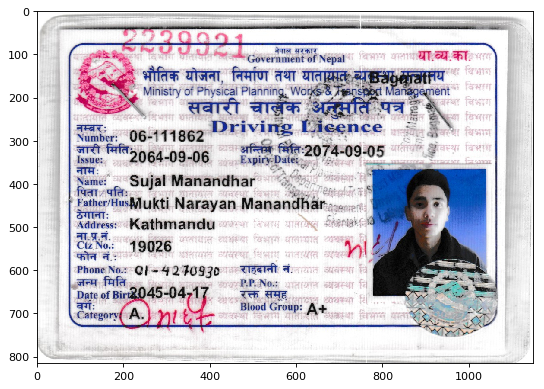

In [24]:
FOLDER_PATH = "/media/raj/new/Driving_license/Data/jpgfile"
INTERMEDIATE_FOLDER = "/media/raj/new/Driving_license/tmp"
for file in os.listdir(FOLDER_PATH):
    file_path = os.path.join(FOLDER_PATH, file)
    print(file_path)
    file_path = "/home/raj/Desktop/IMG_20190115_0005.jpg"
    img = cv2.imread(file_path)
    plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
    plt.imshow(img[:,:,::-1])
    cv2.imwrite(os.path.join(INTERMEDIATE_FOLDER, "original_image.jpg"), img)
    print(img.shape)
    
    CLUSTER_NUMBER=5
    cluster_centroid = {}
    cluster_pixels = {}
    cluster_values = {}
    for cluster_index in range(CLUSTER_NUMBER):
        '''store the location of the cluster centroid in rgb space'''
        cluster_centroid[cluster_index]=tuple(np.random.randint(0,255,3))
        '''store the location of the pixels in spatial co-ordinate belonging to the cluster'''
        cluster_pixels[cluster_index]=[]
        cluster_values[cluster_index]=[]

#     for iteration in range(10):
#         print(iteration)

    prev_cluster_centroid = {}
    iter_count = 0
    while cluster_centroid != prev_cluster_centroid:
        iter_count += 1
        print("Iteration: ",iter_count)
        prev_cluster_centroid = cluster_centroid
        clusters=np.array(list(cluster_centroid.values()))
        
        distance = np.zeros((img.shape[0], img.shape[1], CLUSTER_NUMBER))
        
        for cluster_index, centroid_value in cluster_centroid.items():
            
            cluster_pixels[cluster_index]=[]
            cluster_values[cluster_index]=[]        
            cluster_centroid = np.array([[list(centroid_value)]])
            distance[:,:,cluster_index] = np.linalg.norm(img-cluster_centroid, axis=2)
            
        min_distance_index = np.argmin(distance, axis=2)           

        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                print(img.shape, i, j)
                cluster_pixels[min_distance_index[i,j]].append((i,j))
                cluster_values[min_distance_index[i,j]].append(img[i,j,:].tolist())
            
        for cluster_index in cluster_centroid.keys():
            if len(cluster_values[cluster_index])==0:
                cluster_centroid[cluster_index] = tuple(np.random.randint(0,255,3))
            else:
                cluster_centroid[cluster_index]=tuple(np.nanmean(np.array(cluster_values[cluster_index]), axis=0))
    count=0
    for cluster_index in cluster_centroid.keys():
        img_filtered = np.zeros((img.shape[0],img.shape[1]),dtype=np.uint8)+255
#         print(img_filtered)
#         print(cluster_index)
        for location in cluster_pixels[cluster_index]:
#             print("location: ", location)
            img_filtered[location[0], location[1]] = 0
            count+=1
        cv2.imwrite("/home/raj/Desktop/Intermediate images/Cluster"+str(cluster_index)+".jpg", img_filtered)
    print(cluster_centroid)
    print(count)
    print(len(img.ravel()))
    
    input()
    clear_output()
























### End